# DEseq2

Script to calculate cell type resolved DEGs in each perturbation

## Loading packages

In [18]:
import scanpy as sc
import decoupler as dc

# Only needed for processing
import numpy as np
import pandas as pd

# Needed for some plotting
import matplotlib.pyplot as plt

# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

## Loading the data

In [ ]:
import scanpy as sc
import pandas as pd
import os
adata = sc.read('/wynton/group/pollen/jding/brainchromatin/HM2D/D7-filtered.h5ad', compression='gzip')
#adata = adata[adata.obs['timepoint']== 'D7']
#adata = adata[adata.obs['log'] > 10]
adata.obs['Gene_target'] = adata.obs['gene_NKS'] 
targets = [x for x in adata.obs['Gene_target'].unique() if x in adata.var_names]
targets.append('non-targeting')
adata = adata[adata.obs['Gene_target'].isin(targets)]
adata.obs['perturbation'] = ['NT' if x=='non-targeting' else 'Perturbed' for x in adata.obs['Gene_target'] ]

In [14]:
import os
import pandas as pd
dir='/wynton/group/pollen/jding/brainchromatin/HM2D/DEseq2/2D_guides_bulk'
df = pd.read_csv(os.path.join(dir, 'min_log2FC.csv'),index_col=0)

#load adata
adata = sc.read('/wynton/group/pollen/jding/brainchromatin/HM2D/D7-filtered_guides.h5ad', compression='gzip')
adata.obs['sex'] = [x.split('-')[-1] for x in adata.obs['individual']]
adata.obs['stage'] = [x.split('#')[0] for x in adata.obs['individual']]

#define 'sgRNA_effecitve' as sgRNAs that are not non-targeting
adata.obs['sgRNA_effecitve'] = [','.join(list(set(i for i in x.split(',') if not i.startswith('Non-Targeting')))) for x in adata.obs['sgRNA'].astype(str)]
adata.obs['num_sgRNA_effective'] = [len(list(set(x.split(',')))) for x in adata.obs['sgRNA_effecitve'].astype(str)]
adata.obs['sgRNA_effecitve'] = ['non-targeting' if x == '' else x for x in adata.obs['sgRNA_effecitve']]
adata = adata[adata.obs['num_sgRNA_effective'] == 1]

#removev guides that had <25% KD (log2FC > -0.4)
adata = adata[~adata.obs['sgRNA_effecitve'].isin(df[df['log2FC'] > -0.4]['guide'].to_list())]

adata.obs['Gene_target'] = adata.obs['gene_NKS'] 
targets = [x for x in adata.obs['Gene_target'].unique() if x in adata.var_names]
targets.append('non-targeting')
adata = adata[adata.obs['Gene_target'].isin(targets)]
adata.obs['perturbation'] = ['NT' if x=='non-targeting' else 'Perturbed' for x in adata.obs['Gene_target'] ]

/scratch/jding/ipykernel_3013514/1177280573.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Gene_target'] = adata.obs['gene_NKS']
/scratch/jding/ipykernel_3013514/1177280573.py:24: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['perturbation'] = ['NT' if x=='non-targeting' else 'Perturbed' for x in adata.obs['Gene_target'] ]


In [14]:
import scanpy as sc
import pandas as pd
import os
adata = sc.read('/wynton/group/pollen/jding/brainchromatin/HM2D/HM2D-filtered.h5ad', compression='gzip')
adata.obs['Gene_target'] = adata.obs['gene_NKS'] 
targets = [x for x in adata.obs['Gene_target'].unique() if x in adata.var_names]
targets.append('non-targeting')
adata = adata[adata.obs['Gene_target'].isin(targets)]
adata.obs['sex'] = [x.split('-')[-1] for x in adata.obs['individual']]
adata.obs['stage'] = [x.split('#')[0] for x in adata.obs['individual']]
adata.obs['perturbation'] = ['NT' if x in ['WT','non-targeting'] else 'Perturbed' for x in adata.obs['gene_NKS']]

adata = adata[adata.obs['species'] == 'human']

/scratch/jding/ipykernel_1396590/3440369069.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['sex'] = [x.split('-')[-1] for x in adata.obs['individual']]


In [14]:
import scanpy as sc
import pandas as pd
import os
adata = sc.read('/wynton/group/pollen/jding/brainchromatin/HM2D/HM2D-filtered.h5ad', compression='gzip')
adata.obs['Gene_target'] = adata.obs['gene_NKS'] 
targets = [x for x in adata.obs['Gene_target'].unique() if x in adata.var_names]
targets.append('non-targeting')
adata = adata[adata.obs['Gene_target'].isin(targets)]
adata.obs['sex'] = [x.split('-')[-1] for x in adata.obs['individual']]
adata.obs['stage'] = [x.split('#')[0] for x in adata.obs['individual']]
adata.obs['perturbation'] = ['NT' if x in ['WT','non-targeting'] else 'Perturbed' for x in adata.obs['gene_NKS']]

adata = adata[adata.obs['species'] == 'human']

/scratch/jding/ipykernel_1396590/3440369069.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['sex'] = [x.split('-')[-1] for x in adata.obs['individual']]


In [4]:
adata.obs['Gene_target'].unique()

['BHLHE22', 'ZBTB20', 'TFAP2C', 'SOX2', 'ZNF441', ..., 'KLF10', 'KLF11', 'RFX2', 'TBR1', 'NR2E1']
Length: 45
Categories (45, object): ['ARX', 'ASCL1', 'ATF7', 'BHLHE22', ..., 'ZNF219', 'ZNF281', 'ZNF441', 'non-targeting']

## Processing

In [15]:
# Store raw counts in layers
#adata.X = np.round(adata.X)
adata.raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

# Normalize and log-transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers['normalized'] = adata.X

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


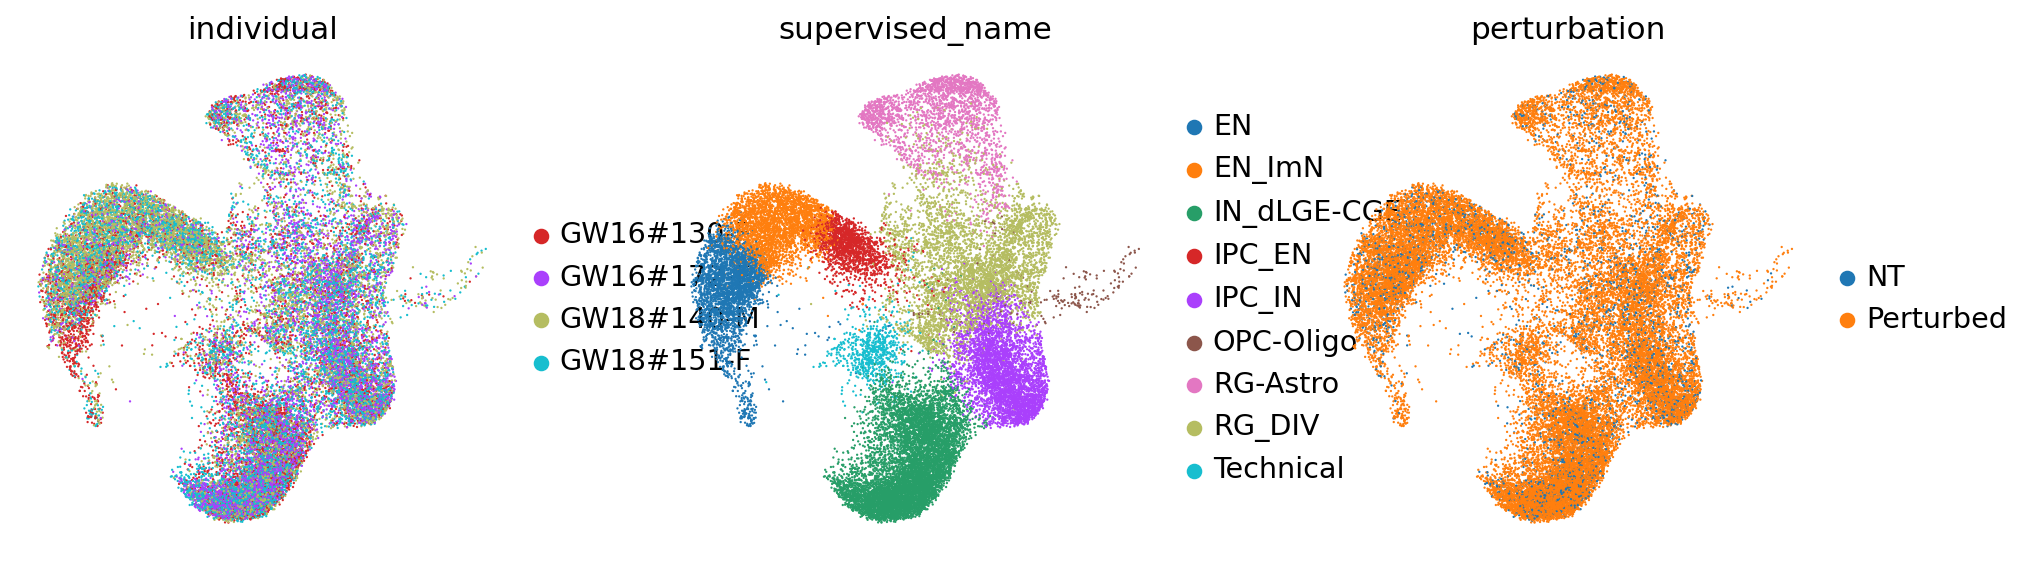

In [16]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, batch_key='individual',min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)

# Visualize
sc.pl.umap(adata, color=['individual','supervised_name','perturbation'], frameon=False)

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


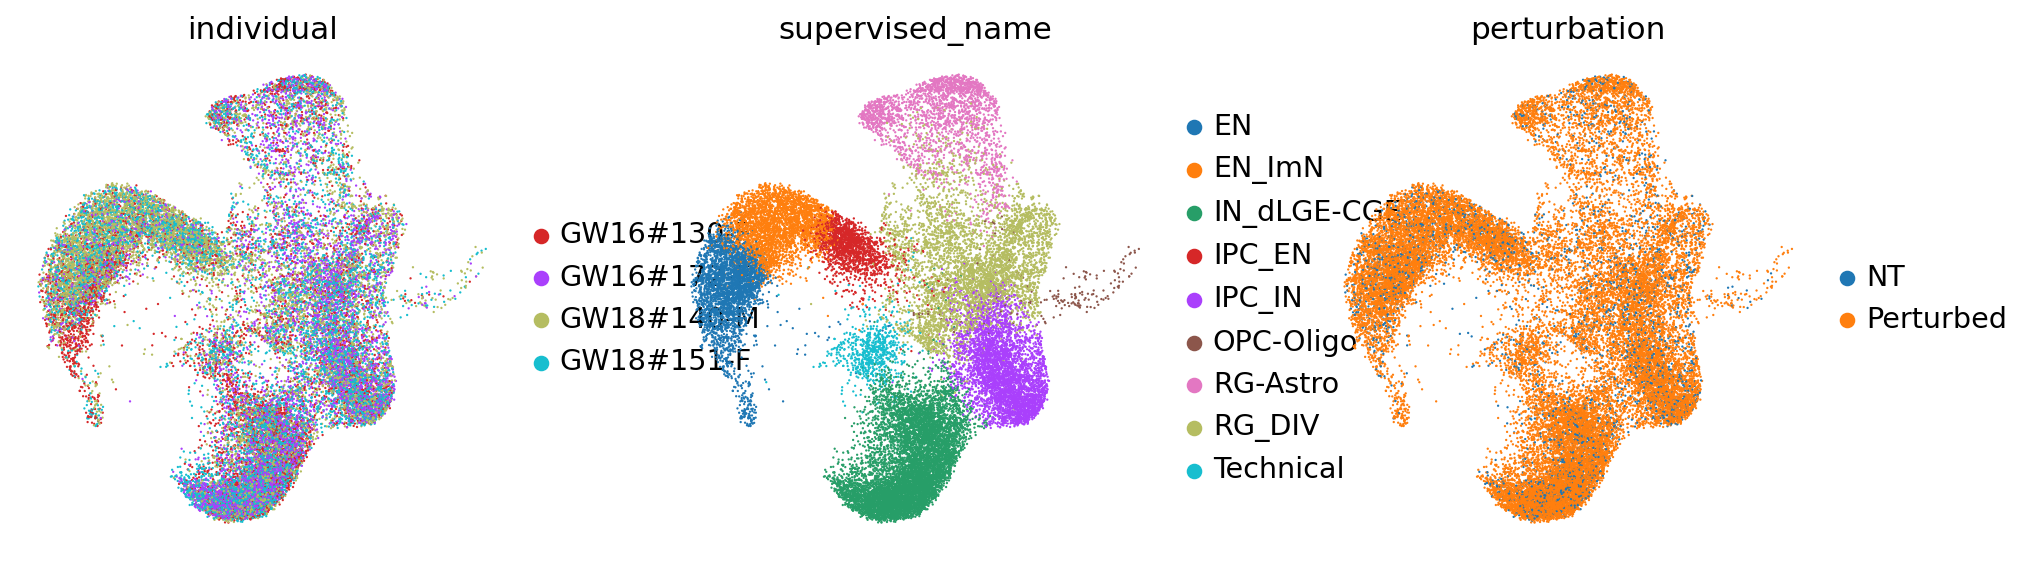

In [6]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, batch_key='individual',min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)

# Visualize
sc.pl.umap(adata, color=['individual','supervised_name','perturbation'], frameon=False)

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


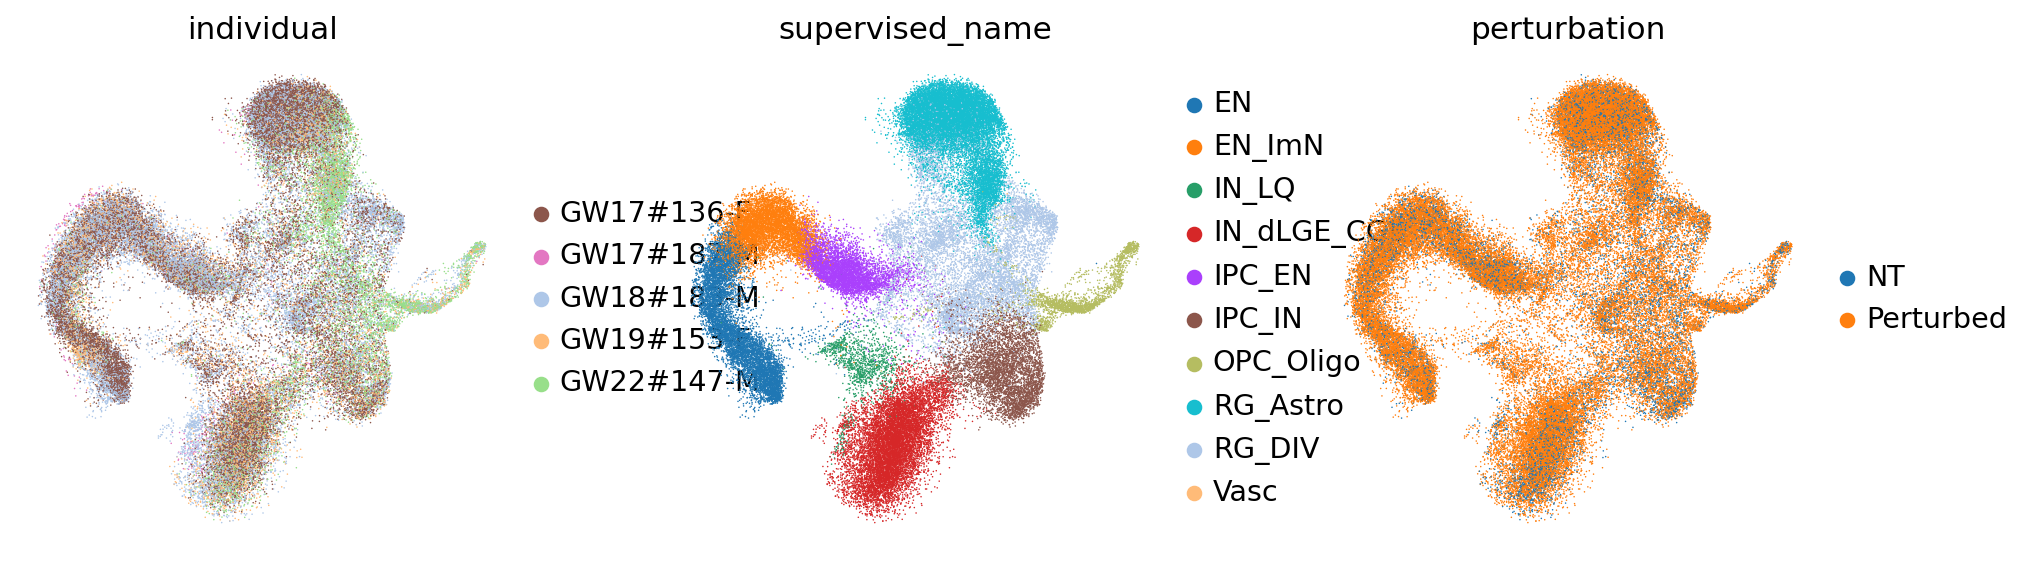

In [16]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, batch_key='individual',min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)

# Visualize
sc.pl.umap(adata, color=['individual','supervised_name','perturbation'], frameon=False)

## Generation of pseudo-bulk profiles

In [17]:
adata.obs['individual-Gene_target'] = adata.obs['individual'].astype(str) + adata.obs['Gene_target'].astype(str)

In [6]:
adata.obs['supervised_name'].value_counts()

IN_dLGE-CGE    8129
RG_DIV         4505
IPC_IN         3990
EN_ImN         3266
EN             3203
RG-Astro       2187
IPC_EN         1579
Technical       689
OPC-Oligo       176
Name: supervised_name, dtype: int64

In [7]:
#subset INs to test robustness of DEG profiles
adata = adata[adata.obs['supervised_name'] == 'IN_dLGE-CGE']
adata=adata[np.random.choice(adata.obs.index,4000,replace=False),:]

In [8]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata,
    sample_col='individual-Gene_target',
    groups_col='supervised_name',
    layer='counts',
    mode='sum',
    min_cells=2,
    min_counts=0
)

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [19]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata,
    sample_col='individual-Gene_target',
    groups_col='class',
    layer='counts',
    mode='sum',
    min_cells=2,
    min_counts=0
)

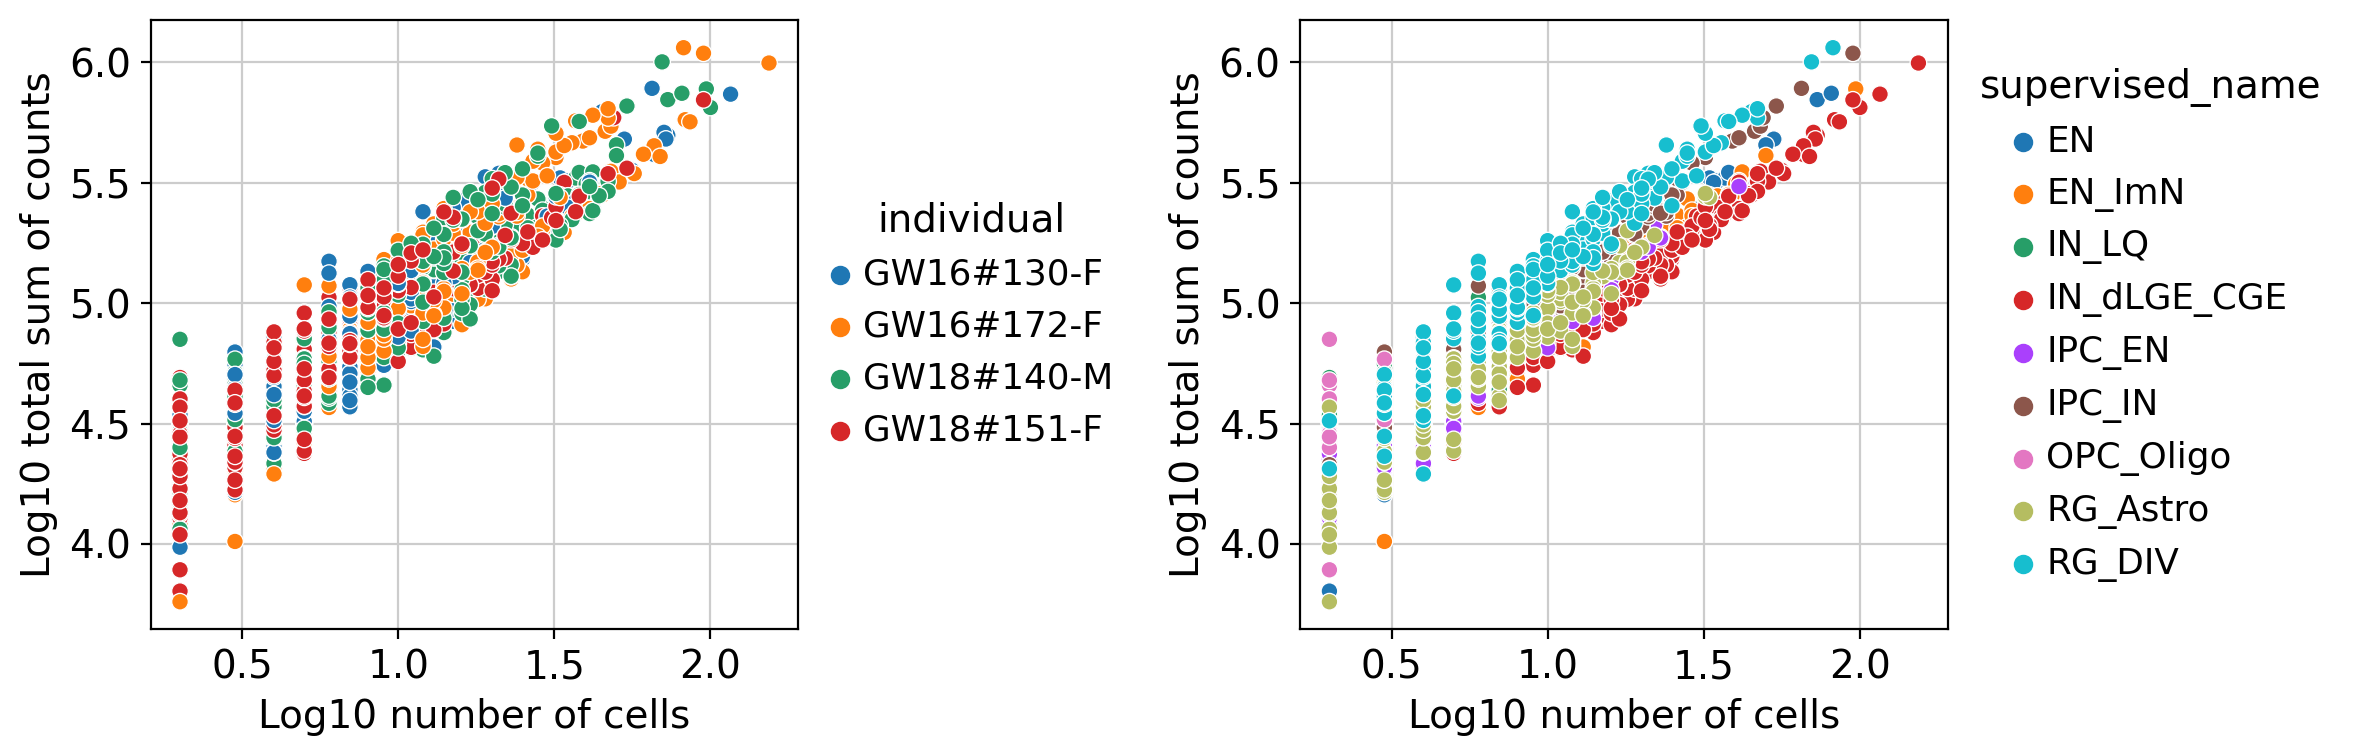

In [7]:
dc.plot_psbulk_samples(pdata, groupby=['individual', 'supervised_name'], figsize=(12, 4))

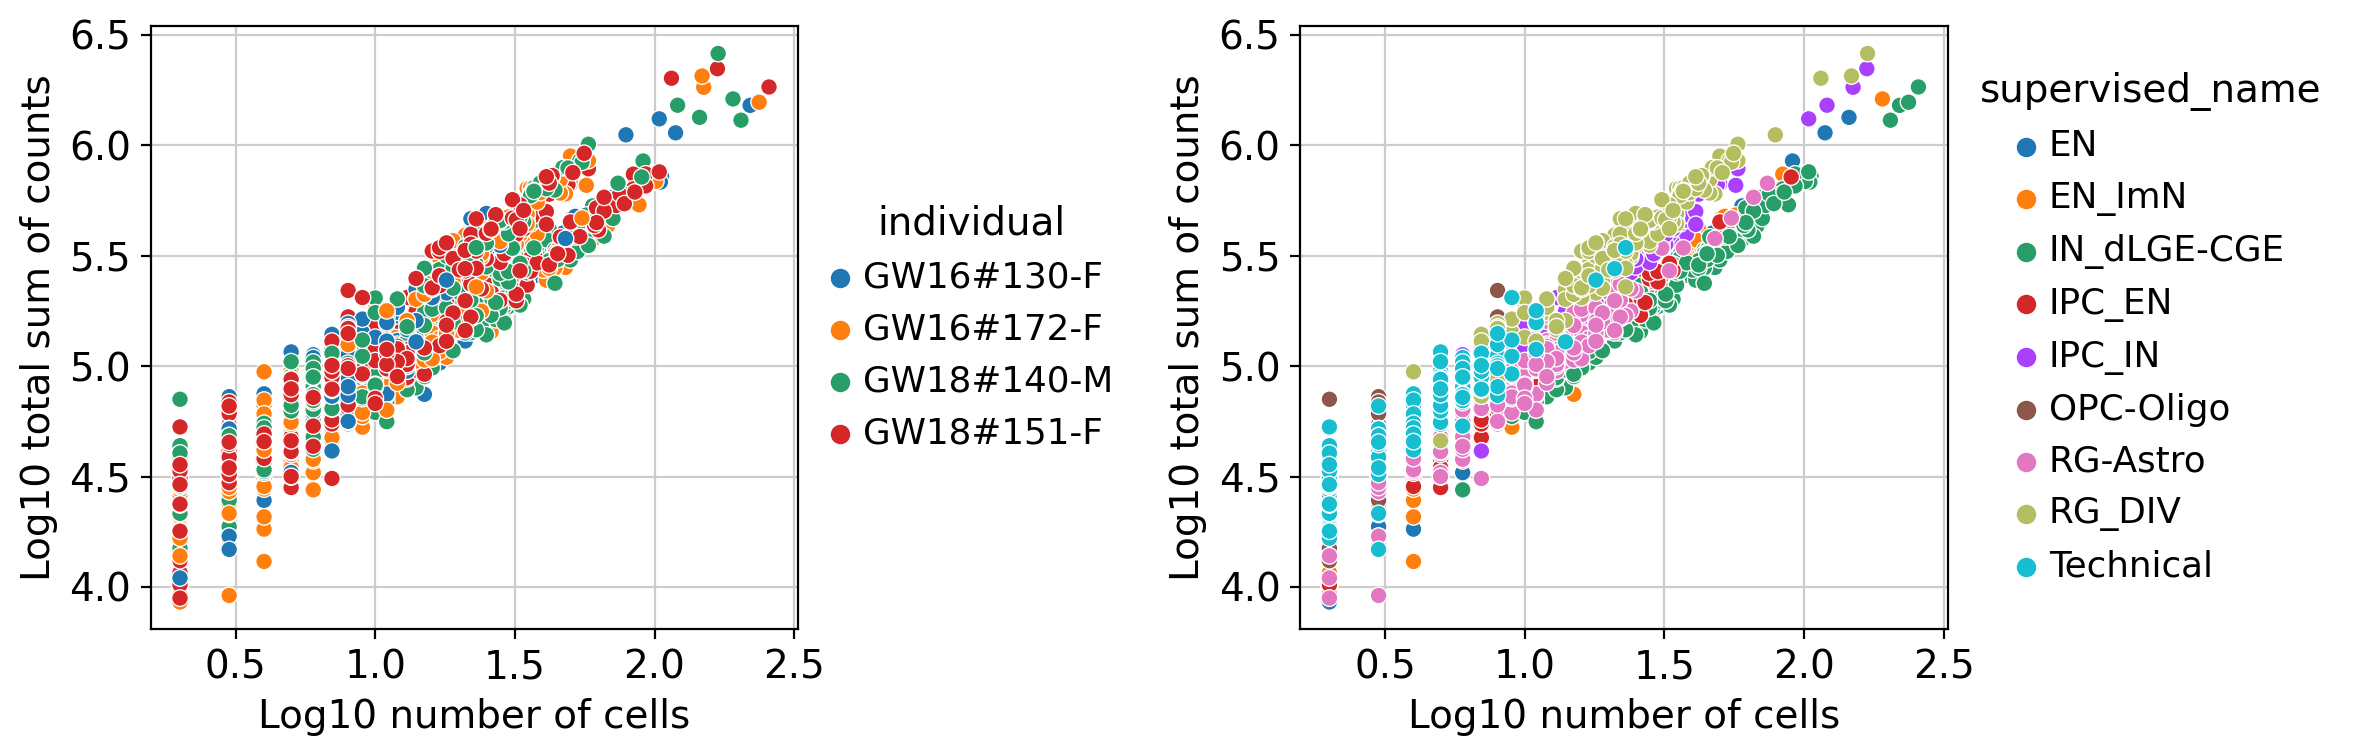

In [9]:
dc.plot_psbulk_samples(pdata, groupby=['individual', 'supervised_name'], figsize=(12, 4))

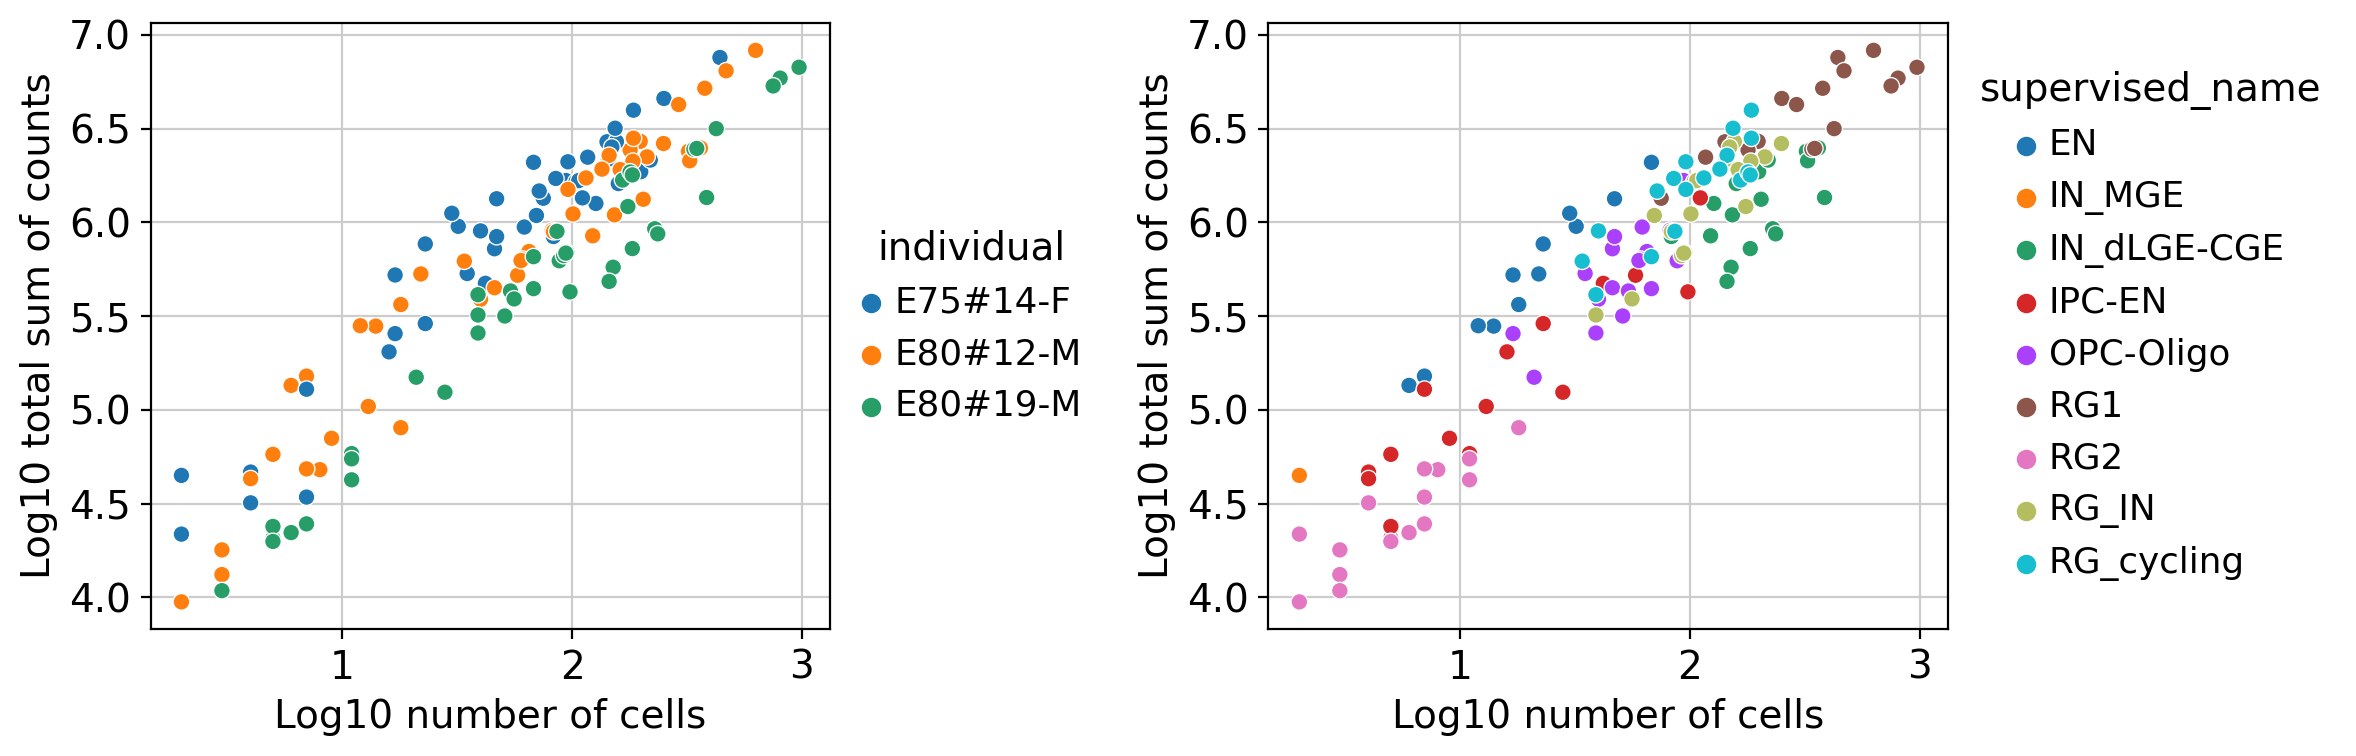

In [101]:
dc.plot_psbulk_samples(pdata, groupby=['individual', 'supervised_name'], figsize=(12, 4))

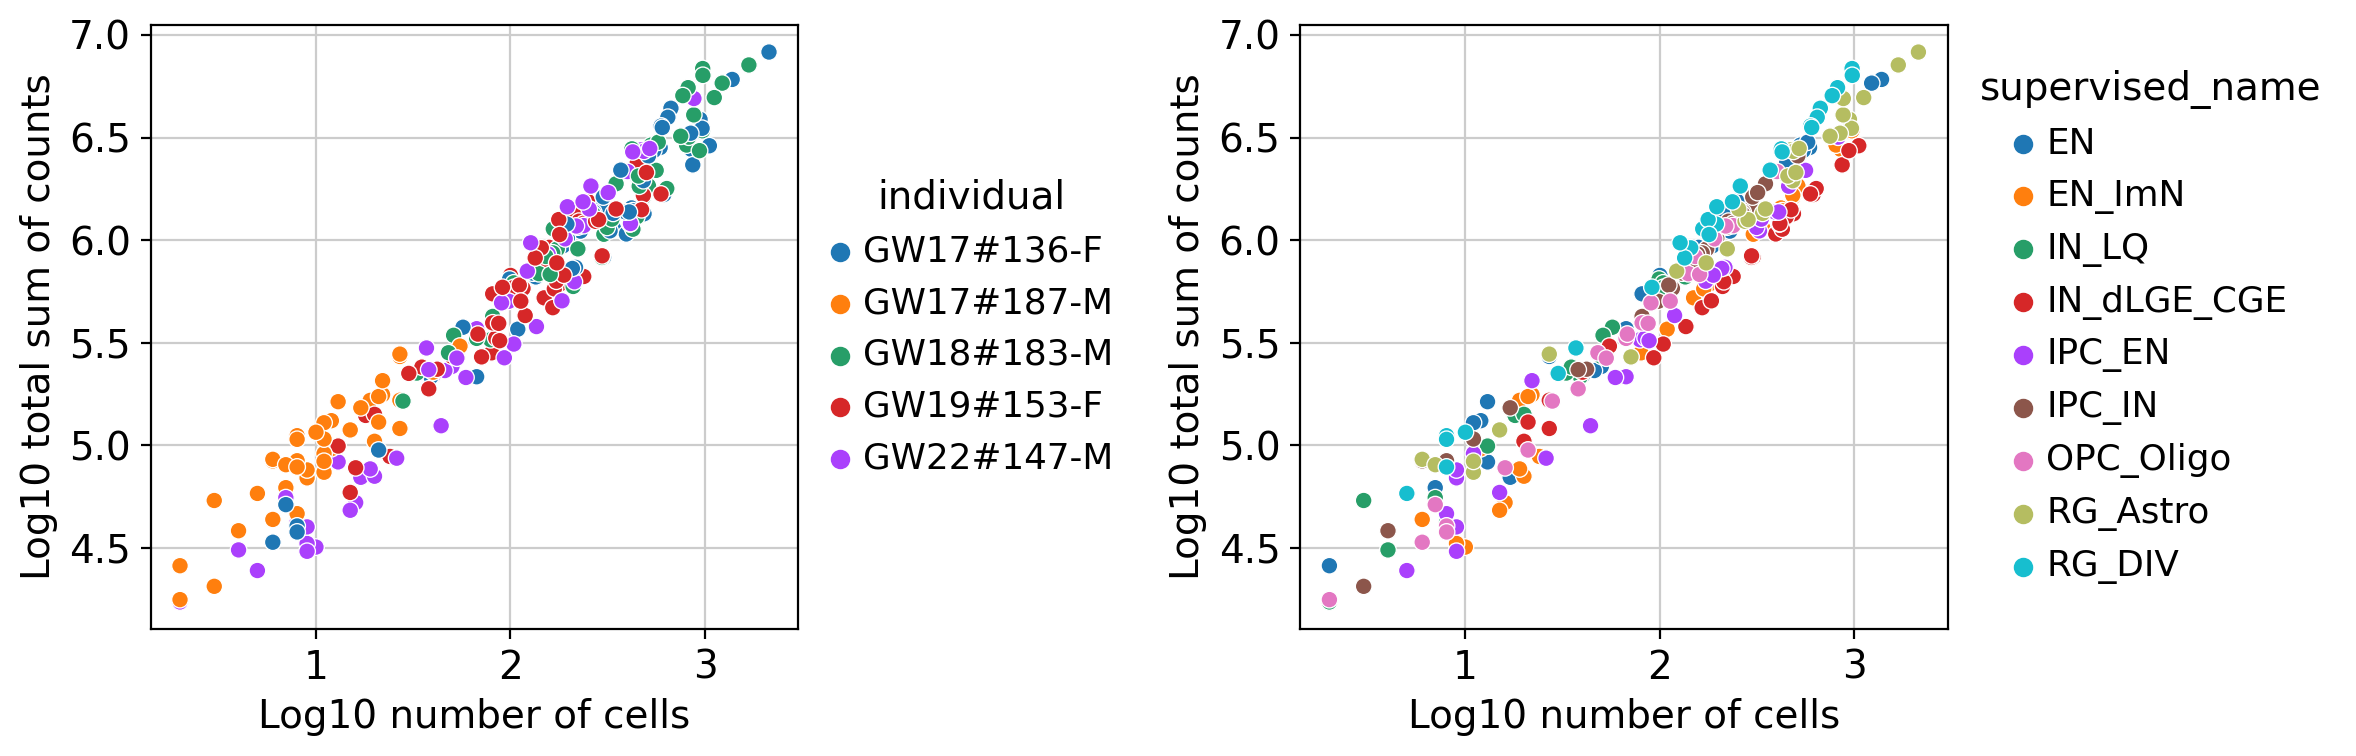

In [19]:
dc.plot_psbulk_samples(pdata, groupby=['individual', 'supervised_name'], figsize=(12, 4))

### Exploration of pseudobulk profiles

In [20]:
# Store raw counts in layers
pdata.layers['counts'] = pdata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)

# Return raw counts to X
dc.swap_layer(pdata, 'counts', X_layer_key=None, inplace=True)

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


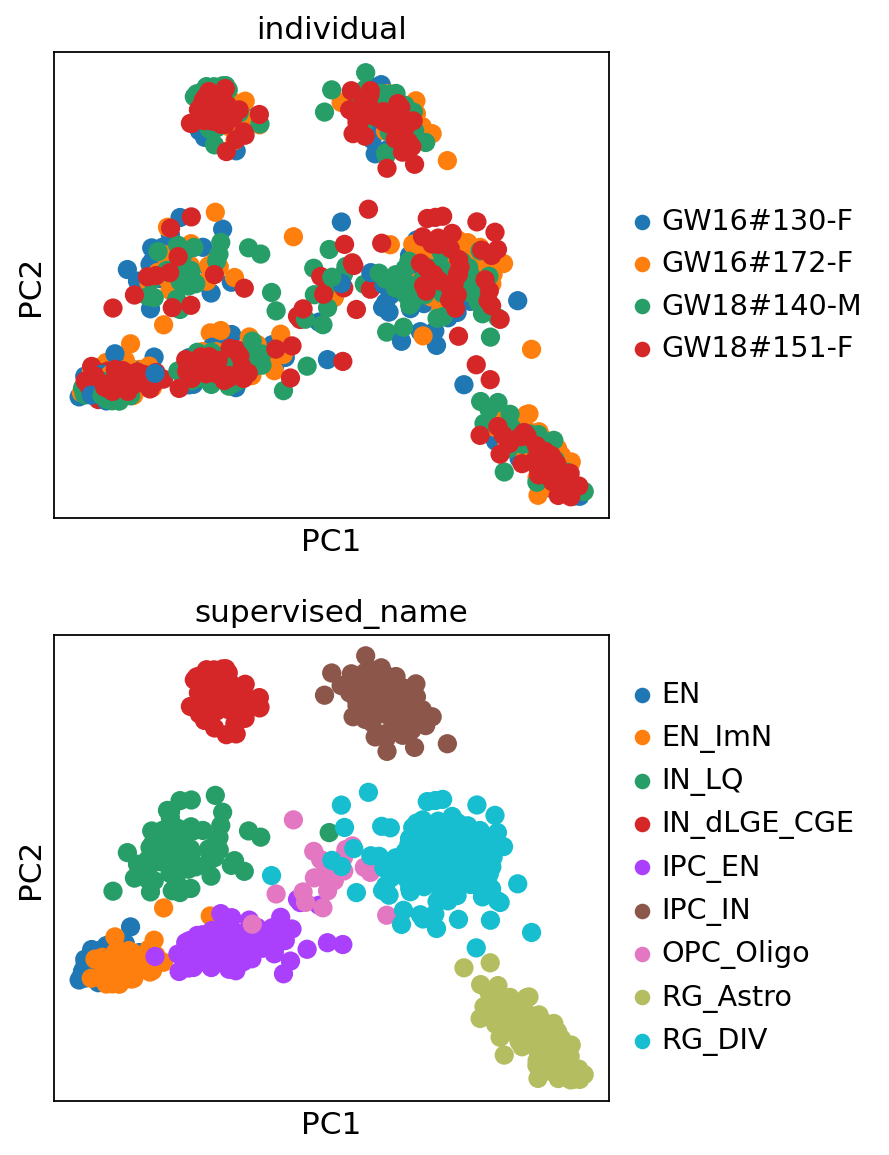

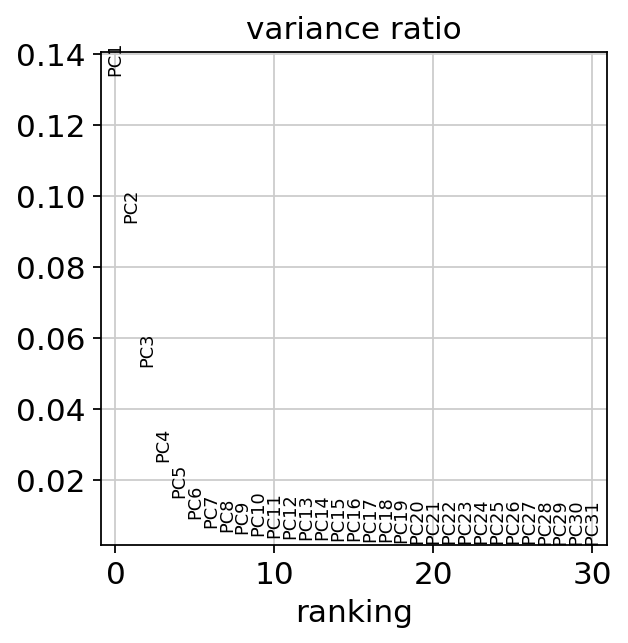

In [9]:
sc.pl.pca(pdata, color=['individual', 'supervised_name'], ncols=1, size=300)
sc.pl.pca_variance_ratio(pdata)

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


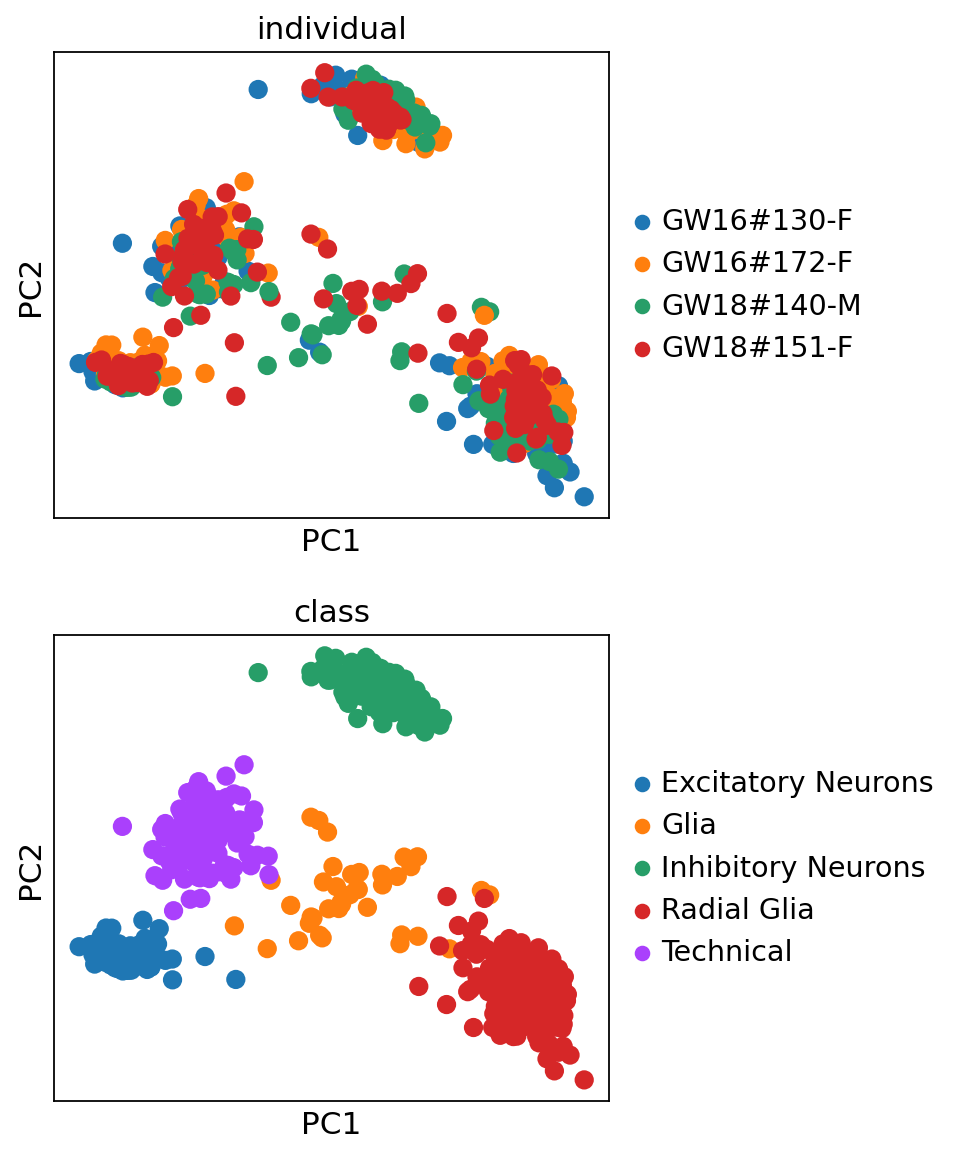

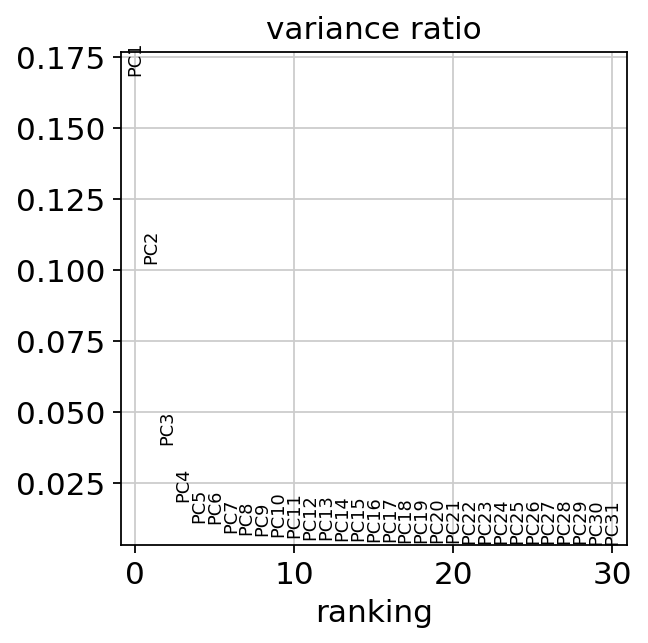

In [21]:
sc.pl.pca(pdata, color=['individual', 'class'], ncols=1, size=300)
sc.pl.pca_variance_ratio(pdata)

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


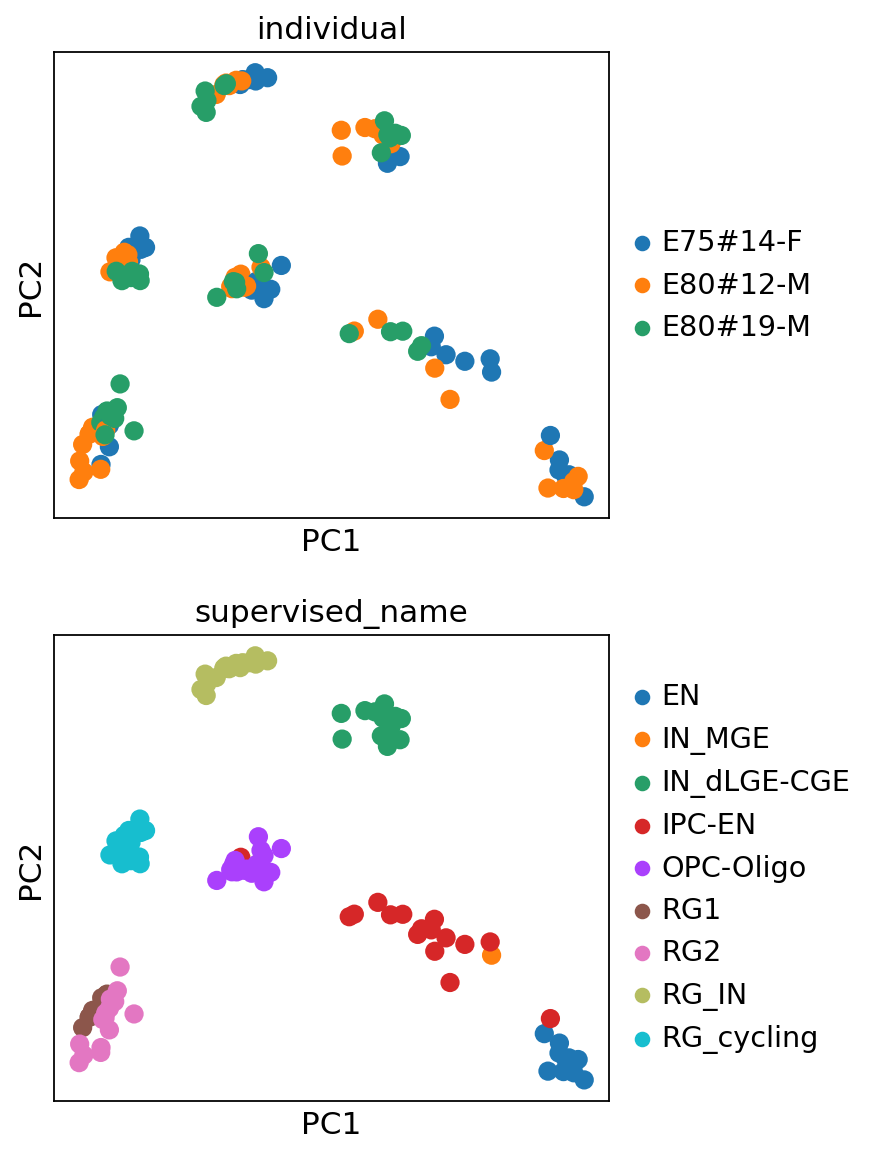

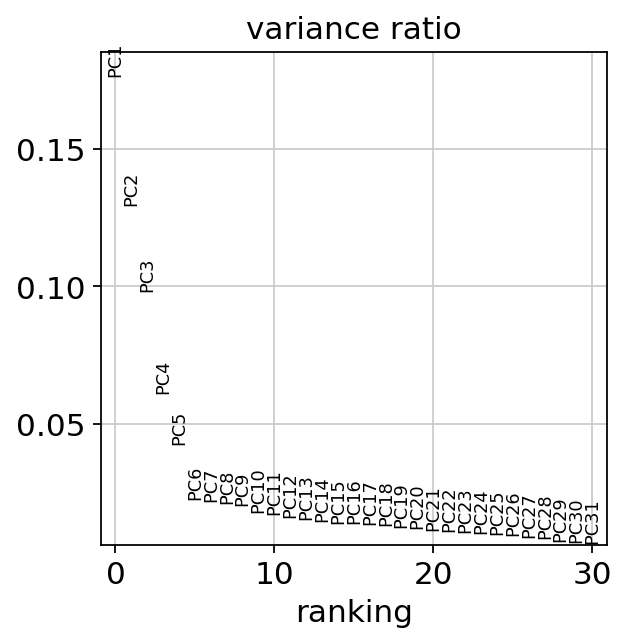

In [103]:
sc.pl.pca(pdata, color=['individual', 'supervised_name'], ncols=1, size=300)
sc.pl.pca_variance_ratio(pdata)

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


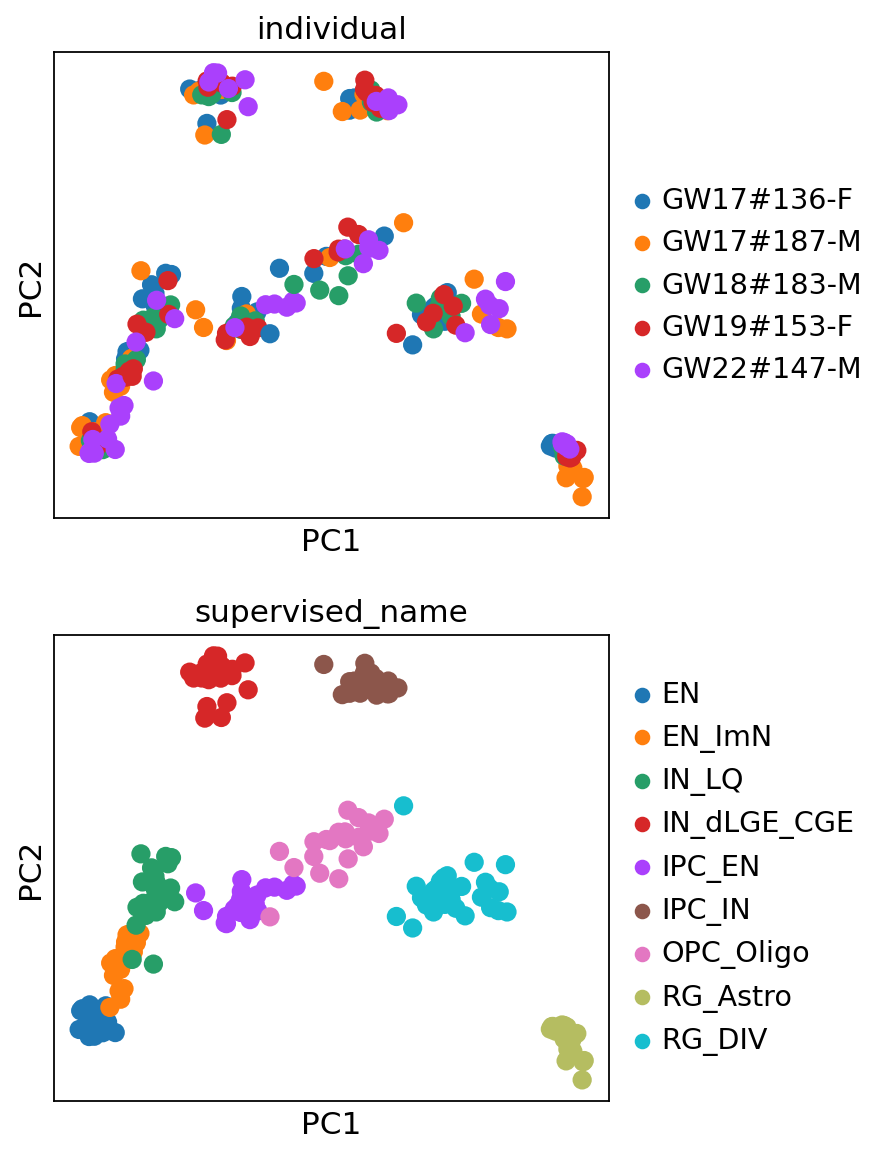

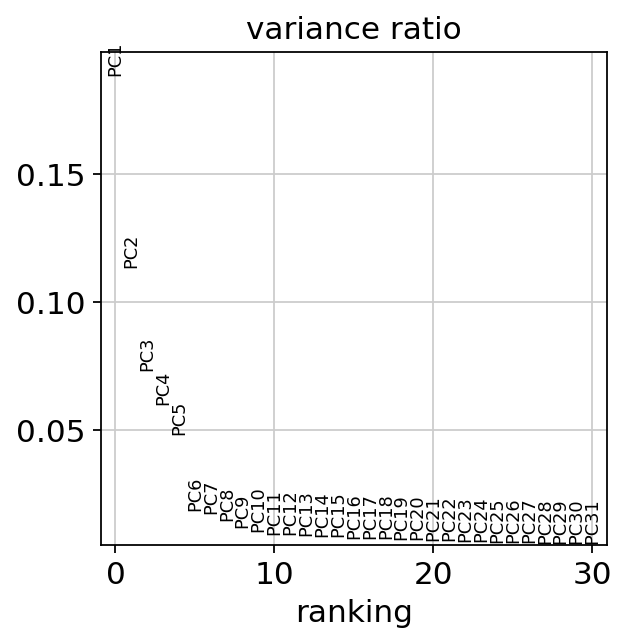

In [21]:
sc.pl.pca(pdata, color=['individual', 'supervised_name'], ncols=1, size=300)
sc.pl.pca_variance_ratio(pdata)

In [22]:
dc.get_metadata_associations(
    pdata,
    obs_keys = ['sex', 'Gene_target', 'supervised_name', 'psbulk_n_cells', 'psbulk_counts'],  # Metadata columns to associate to PCs
    obsm_key='X_pca',  # Where the PCs are stored
    uns_key='pca_anova',  # Where the results are stored
    inplace=True,
)

100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 18.39it/s]


In [22]:
dc.plot_associations(
    pdata,
    uns_key='pca_anova',  # Summary statistics from the anova tests
    obsm_key='X_pca',  # where the PCs are stored
    stat_col='p_adj',  # Which summary statistic to plot
    obs_annotation_cols = ['Gene_target', 'supervised_name'], # which sample annotations to plot
    titles=['Principle component scores', 'Adjusted p-values from ANOVA'],
    figsize=(7, 5),
    n_factors=10,
)

TypeError: plot_associations() got an unexpected keyword argument 'figsize'

## Contrast between conditions

In [12]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

In [13]:
dir='/wynton/scratch/jding/brainchromatin/HM2D/DEseq2/2D_guides_cleaned'
if not os.path.exists(os.path.join(dir)):
    os.makedirs(os.path.join(dir))
    
targets=[x for x in adata.obs['Gene_target'].unique() if x in adata.var_names]
inference = DefaultInference(n_cpus=1)

for celltype in pdata.obs['supervised_name'].unique():
    print(celltype)
    sub = pdata[pdata.obs['supervised_name'] == celltype]
    for gene in targets:
        print(gene)
        if gene in sub.obs['Gene_target'].unique():
            if (pd.crosstab(sub.obs['supervised_name'],sub.obs['Gene_target'])[gene] > 1).bool():
                sub2 = sub[sub.obs['Gene_target'].isin([gene,'non-targeting'])]
                #print(sub2.obs.head(5))
                try:
                    dds = DeseqDataSet(adata= sub2, design_factors='perturbation',ref_level=['perturbation', 'NT'],
                                       refit_cooks=True,inference=inference)
                except KeyError:
                    dds = DeseqDataSet(adata= sub2, design_factors='perturbation',ref_level=['perturbation', 'NT'],
                                   refit_cooks=True,inference=inference)
                dds.deseq2()
                stat_res = DeseqStats(dds,contrast=["perturbation", 'Perturbed', 'NT'],inference=inference)
                stat_res.summary()
                stat_res.results_df.to_csv(os.path.join(dir,gene + '.' + celltype +'.csv'))
        else:
            continue

EN
BHLHE22


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.94 seconds.

Fitting dispersion trend curve...
... done in 0.80 seconds.

Fitting MAP dispersions...
... done in 19.17 seconds.

Fitting LFCs...
... done in 15.09 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.23 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.145951       -1.086848  0.918360 -1.183466  0.236624       NaN
A1BG-AS1   1.163384        0.256760  1.337231  0.192009  0.847735       NaN
A1CF       0.331487       -0.768787  2.216565 -0.346837  0.728714       NaN
A2M        4.412557       -0.144882  0.711844 -0.203531  0.838720       NaN
A2M-AS1    0.681322        1.275704  1.485826  0.858582  0.390571       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.304802        2.002712  2.883029  0.694655  0.487271       NaN
ZYG11B    55.574900        0.231998  0.227860  1.018161  0.308602  0.997726
ZYX        7.972733        0.436451  0.479931  0.909404  0.363137       NaN
ZZEF1     26.434447       -0.259643  0.262029 -0.990892  0.321738       NaN
ZZZ3      43.466762        0.292560  0.213035  1.373296  0.169660  0.997726

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 11.25 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.65 seconds.

Fitting MAP dispersions...
... done in 21.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.357005        0.385338  0.687424  0.560554  0.575101  0.999524
A1BG-AS1   4.035940        2.010714  0.975034  2.062198  0.039189  0.999524
A1CF       0.921732        1.692709  1.145547  1.477643  0.139503  0.999524
A2M        5.680410        0.986117  0.771140  1.278778  0.200975  0.999524
A2M-AS1    0.458445        0.977879  1.246875  0.784264  0.432885  0.999524
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.297430        2.751381  1.668108  1.649402  0.099065  0.999524
ZYG11B    41.545967       -0.188264  0.293903 -0.640566  0.521805  0.999524
ZYX        4.523823       -0.379752  0.586236 -0.647780  0.517127  0.999524
ZZEF1     27.169214       -0.003637  0.318409 -0.011423  0.990886  0.999524
ZZZ3      34.564634        0.084144  0.300663  0.279860  0.779585  0.999524

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.35 seconds.

Fitting dispersion trend curve...
... done in 0.74 seconds.

Fitting MAP dispersions...
... done in 18.68 seconds.

Fitting LFCs...
... done in 15.45 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.46 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.649731       -0.449844  0.876227 -0.513387  0.607681  0.999806
A1BG-AS1   2.965549        1.470864  1.155043  1.273428  0.202866  0.999806
A1CF       0.852877        1.574041  1.346027  1.169398  0.242243  0.999806
A2M        3.986592        0.073591  0.743505  0.098979  0.921155  0.999806
A2M-AS1    1.391392        1.408048  1.514480  0.929724  0.352514  0.999806
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.062170        1.622712  3.895546  0.416556  0.677003  0.999806
ZYG11B    42.635965        0.009926  0.220166  0.045084  0.964040  0.999806
ZYX        5.383472       -0.305589  0.594134 -0.514344  0.607012  0.999806
ZZEF1     28.631122        0.344863  0.258443  1.334388  0.182077  0.999806
ZZZ3      32.857913        0.005908  0.255899  0.023088  0.981580  0.999806

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.72 seconds.

Fitting dispersion trend curve...
... done in 0.85 seconds.

Fitting MAP dispersions...
... done in 19.91 seconds.

Fitting LFCs...
... done in 15.58 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.39 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       4.299514        0.459283  0.671758  0.683703  0.494163  0.999783
A1BG-AS1   1.030050        0.144343  1.365585  0.105701  0.915820  0.999783
A1CF       0.512932        0.066293  1.749673  0.037889  0.969776  0.999783
A2M        5.735082        0.212897  0.806415  0.264004  0.791777  0.999783
A2M-AS1    0.398046        0.333474  1.932308  0.172578  0.862983  0.999783
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.071073        1.238708  3.895741  0.317965  0.750512  0.999783
ZYG11B    47.025226       -0.124620  0.202921 -0.614129  0.539130  0.999783
ZYX        5.052395       -0.937934  0.645754 -1.452463  0.146373  0.999783
ZZEF1     31.734117        0.271367  0.232920  1.165066  0.243992  0.999783
ZZZ3      36.490962       -0.202584  0.232215 -0.872401  0.382989  0.999783

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.10 seconds.

Fitting dispersion trend curve...
... done in 0.77 seconds.

Fitting MAP dispersions...
... done in 18.63 seconds.

Fitting LFCs...
... done in 15.28 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.64 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.273246       -0.294215  0.937910 -0.313692  0.753755  0.999678
A1BG-AS1   0.601452       -0.115380  1.710460 -0.067456  0.946219  0.999678
A1CF       0.500570        0.882172  1.658320  0.531967  0.594749  0.999678
A2M        3.652748        0.268419  0.774858  0.346410  0.729034  0.999678
A2M-AS1    0.159222        0.415993  2.531200  0.164346  0.869459  0.999678
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.053083        2.055358  3.890523  0.528299  0.597292  0.999678
ZYG11B    37.610837        0.063488  0.224097  0.283304  0.776944  0.999678
ZYX        4.584052       -0.276362  0.646511 -0.427467  0.669039  0.999678
ZZEF1     21.857260        0.103644  0.280822  0.369074  0.712073  0.999678
ZZZ3      26.062297       -0.169382  0.310469 -0.545569  0.585363  0.999678

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.67 seconds.

Fitting dispersion trend curve...
... done in 0.86 seconds.

Fitting MAP dispersions...
... done in 18.98 seconds.

Fitting LFCs...
... done in 14.85 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.52 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.694376       -0.112154  0.924871 -0.121265  0.903481  0.999352
A1BG-AS1   2.018218        1.942846  1.077432  1.803220  0.071354  0.999352
A1CF       0.351238       -0.162489  2.375756 -0.068395  0.945471  0.999352
A2M        5.210788        0.677957  0.783066  0.865773  0.386615  0.999352
A2M-AS1    0.226578        0.150592  2.754376  0.054674  0.956398  0.999352
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.360626        2.851360  2.840947  1.003665  0.315540  0.999352
ZYG11B    54.210891        0.376733  0.235106  1.602394  0.109069  0.999352
ZYX        5.112900       -0.956133  0.837528 -1.141613  0.253615  0.999352
ZZEF1     27.073919       -0.054918  0.316136 -0.173718  0.862087  0.999352
ZZZ3      32.758700       -0.376273  0.312727 -1.203201  0.228899  0.999352

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 13.92 seconds.

Fitting dispersion trend curve...
... done in 0.81 seconds.

Fitting MAP dispersions...
... done in 19.06 seconds.

Fitting LFCs...
... done in 15.36 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.41 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.410488       -1.008394  0.936360 -1.076929  0.281512  0.999984
A1BG-AS1   0.645840       -0.677139  1.750161 -0.386901  0.698829  0.999984
A1CF       0.423700        0.220652  1.777516  0.124135  0.901208  0.999984
A2M        3.844764       -0.118169  0.758953 -0.155701  0.876269  0.999984
A2M-AS1    0.712405        1.546373  1.386840  1.115034  0.264836  0.999984
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.065534        1.461823  3.901547  0.374678  0.707900  0.999984
ZYG11B    48.579330        0.024505  0.220346  0.111211  0.911449  0.999984
ZYX        6.166606        0.299120  0.531916  0.562345  0.573881  0.999984
ZZEF1     24.149563       -0.180316  0.283640 -0.635723  0.524957  0.999984
ZZZ3      34.126791       -0.037460  0.236157 -0.158622  0.873966  0.999984

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 16.39 seconds.

Fitting dispersion trend curve...
... done in 0.75 seconds.

Fitting MAP dispersions...
... done in 18.12 seconds.

Fitting LFCs...
... done in 14.47 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.39 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.063181        0.347142  0.790348  0.439227  0.660497       NaN
A1BG-AS1   0.941084        0.461729  1.394972  0.330995  0.740648       NaN
A1CF       0.613501        0.870028  1.659655  0.524222  0.600124       NaN
A2M        4.288429        0.378074  0.797914  0.473829  0.635622       NaN
A2M-AS1    0.161043        0.388783  2.574888  0.150990  0.879984       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.053699        2.025883  3.888792  0.520954  0.602399       NaN
ZYG11B    34.197029       -0.222297  0.241082 -0.922080  0.356487  0.978841
ZYX        4.271620       -0.284272  0.660084 -0.430660  0.666716       NaN
ZZEF1     24.023877        0.316490  0.266921  1.185710  0.235737  0.943804
ZZZ3      28.099527       -0.117219  0.268795 -0.436092  0.662770  0.989891

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.91 seconds.

Fitting dispersion trend curve...
... done in 0.80 seconds.

Fitting MAP dispersions...
... done in 19.77 seconds.

Fitting LFCs...
... done in 14.69 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.39 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.329667       -0.032176  0.809909 -0.039728  0.968310  0.999853
A1BG-AS1   1.954943        1.192022  1.090130  1.093468  0.274189  0.999853
A1CF       0.935884        1.163041  1.325030  0.877747  0.380081  0.999853
A2M        5.380246        0.007969  0.739816  0.010771  0.991406  0.999853
A2M-AS1    1.014394        1.542114  1.475253  1.045322  0.295874  0.999853
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.072551        1.180509  3.895664  0.303032  0.761866  0.999853
ZYG11B    49.872628       -0.061817  0.251622 -0.245673  0.805935  0.999853
ZYX        6.738358       -0.134115  0.550296 -0.243715  0.807452  0.999853
ZZEF1     31.949821        0.311793  0.282872  1.102240  0.270357  0.999853
ZZZ3      36.632754       -0.237699  0.231386 -1.027283  0.304287  0.999853

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.47 seconds.

Fitting dispersion trend curve...
... done in 0.75 seconds.

Fitting MAP dispersions...
... done in 17.82 seconds.

Fitting LFCs...
... done in 14.84 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.47 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG       3.067120        0.203705  0.807964  0.252122  0.800947  0.99852
A1BG-AS1   1.769210        1.207678  1.354474  0.891622  0.372596  0.99852
A1CF       0.518679        1.202007  1.591023  0.755493  0.449953  0.99852
A2M        3.501416       -0.468085  0.886937 -0.527754  0.597670  0.99852
A2M-AS1    0.165522        0.306957  2.583879  0.118797  0.905436  0.99852
...             ...             ...       ...       ...       ...      ...
ZYG11A     0.186830        2.592828  3.384788  0.766024  0.443662  0.99852
ZYG11B    38.213807       -0.038131  0.278363 -0.136982  0.891045  0.99852
ZYX        3.700653       -0.996423  0.776375 -1.283430  0.199342  0.99852
ZZEF1     21.590728       -0.201778  0.317819 -0.634883  0.525505  0.99852
ZZZ3      36.366545        0.342909  0.230283  1.489074  0.136468  0.99852

[34573 rows x 6 columns]
MEIS2


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.62 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.59 seconds.

Fitting MAP dispersions...
... done in 22.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.675569        0.396914  1.117295  0.355245  0.722406  0.920476
A1BG-AS1   0.244730        0.651326  2.008185  0.324336  0.745684  0.926983
A1CF       0.146497        1.692234  1.852631  0.913422  0.361021  0.849114
A2M        3.560652        0.966755  0.943107  1.025074  0.305328  0.849114
A2M-AS1    0.094917        1.816513  1.918513  0.946834  0.343723  0.849114
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.031431        3.543253  3.885625  0.911887  0.361828  0.849114
ZYG11B    21.987318        0.021455  0.333365  0.064358  0.948685  0.986518
ZYX        3.612104        0.480022  0.781730  0.614051  0.539181  0.868573
ZZEF1      9.819971       -1.086695  0.608618 -1.785511  0.074178  0.849114
ZZZ3      14.854326       -0.330450  0.421978 -0.783097  0.433570  0.849114

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.13 seconds.

Fitting dispersion trend curve...
... done in 0.76 seconds.

Fitting MAP dispersions...
... done in 17.91 seconds.

Fitting LFCs...
... done in 15.41 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.25 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.587552       -0.521345  0.753294 -0.692087  0.488883  0.999957
A1BG-AS1   1.285251        0.312389  1.266081  0.246737  0.805112  0.999957
A1CF       1.539283        0.755132  1.369973  0.551202  0.581495  0.999957
A2M        5.831354        0.280111  0.690380  0.405734  0.684938  0.999957
A2M-AS1    0.851788        1.364296  1.386936  0.983676  0.325275  0.999957
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.086093        0.691316  3.900021  0.177260  0.859305  0.999957
ZYG11B    53.996020       -0.282542  0.205593 -1.374277  0.169356  0.999957
ZYX        6.211018       -0.448497  0.593055 -0.756249  0.449500  0.999957
ZZEF1     34.305819       -0.135686  0.244563 -0.554811  0.579024  0.999957
ZZZ3      51.503881        0.228848  0.206519  1.108120  0.267810  0.999957

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.88 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.75 seconds.

Fitting MAP dispersions...
... done in 27.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.920090       -1.036598  1.077043 -0.962449  0.335824  0.998999
A1BG-AS1   1.104959        1.296507  1.077564  1.203183  0.228905  0.998999
A1CF       0.352714        1.024359  1.442146  0.710302  0.477517  0.998999
A2M        2.583911       -0.498927  0.925862 -0.538878  0.589971  0.998999
A2M-AS1    0.389131        1.185498  1.460267  0.811836  0.416886  0.998999
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.050203        2.226461  3.587121  0.620682  0.534809  0.998999
ZYG11B    30.082828       -0.272158  0.323847 -0.840390  0.400690  0.998999
ZYX        6.141573        0.571404  0.528209  1.081776  0.279352  0.998999
ZZEF1     20.779573        0.124930  0.295176  0.423240  0.672120  0.998999
ZZZ3      26.555654       -0.124356  0.280494 -0.443347  0.657515  0.998999

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 17.22 seconds.

Fitting dispersion trend curve...
... done in 0.88 seconds.

Fitting MAP dispersions...
... done in 20.13 seconds.

Fitting LFCs...
... done in 15.44 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.56 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       4.032181        0.459945  0.686516  0.669970  0.502877  0.999699
A1BG-AS1   1.275186        1.029006  1.480243  0.695160  0.486955       NaN
A1CF       0.506141        0.403706  1.697866  0.237772  0.812058       NaN
A2M        4.598318        0.387912  0.708107  0.547816  0.583818  0.999699
A2M-AS1    0.187848       -0.050306  2.564370 -0.019617  0.984349       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.279406        2.331383  2.932366  0.795052  0.426583       NaN
ZYG11B    41.028954       -0.171818  0.216018 -0.795389  0.426387  0.999699
ZYX        3.840490       -1.261638  0.766284 -1.646437  0.099674  0.999699
ZZEF1     26.326621        0.161465  0.258887  0.623690  0.532831  0.999699
ZZZ3      39.156840        0.426466  0.253374  1.683152  0.092346  0.999699

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 16.21 seconds.

Fitting dispersion trend curve...
... done in 0.75 seconds.

Fitting MAP dispersions...
... done in 19.64 seconds.

Fitting LFCs...
... done in 15.39 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.69 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG       3.665207       -0.022668  0.780595 -0.029039  0.976833  0.99984
A1BG-AS1   2.403661        1.642810  1.091630  1.504914  0.132346  0.99984
A1CF       2.286285        2.455269  1.333594  1.841092  0.065608  0.99984
A2M        5.921894        0.609709  0.725954  0.839873  0.400979  0.99984
A2M-AS1    0.491928        1.110316  1.608708  0.690191  0.490074  0.99984
...             ...             ...       ...       ...       ...      ...
ZYG11A     0.064358        1.514319  3.898446  0.388442  0.697689  0.99984
ZYG11B    44.014287        0.031303  0.227217  0.137768  0.890424  0.99984
ZYX        5.474735       -0.452510  0.654174 -0.691727  0.489109  0.99984
ZZEF1     24.695553       -0.031005  0.284878 -0.108835  0.913333  0.99984
ZZZ3      36.485659        0.074527  0.280479  0.265712  0.790461  0.99984

[34573 rows x 6 columns]
JUN


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.65 seconds.

Fitting dispersion trend curve...
... done in 0.82 seconds.

Fitting MAP dispersions...
... done in 19.16 seconds.

Fitting LFCs...
... done in 16.55 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.61 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG       2.370744       -0.542278  0.919274 -0.589898  0.555259  0.99932
A1BG-AS1   0.976253        0.668217  1.309124  0.510431  0.609750  0.99932
A1CF       0.383294        0.618322  1.738508  0.355663  0.722093  0.99932
A2M        7.349621        1.334633  0.684725  1.949153  0.051277  0.99932
A2M-AS1    1.049989        2.184373  1.406640  1.552902  0.120447  0.99932
...             ...             ...       ...       ...       ...      ...
ZYG11A     0.056727        1.871283  3.900226  0.479788  0.631378  0.99932
ZYG11B    32.183450       -0.462279  0.245085 -1.886198  0.059268  0.99932
ZYX        6.510086        0.672045  0.493165  1.362717  0.172972  0.99932
ZZEF1     21.744917        0.048236  0.283398  0.170206  0.864848  0.99932
ZZZ3      31.480070       -0.193266  0.263116 -0.734527  0.462628  0.99932

[34573 rows x 6 columns]
ASCL1


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.19 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.59 seconds.

Fitting MAP dispersions...
... done in 22.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.250182       -2.100989  1.662237 -1.263953  0.206247  0.985004
A1BG-AS1   0.355198       -0.432517  1.930000 -0.224102  0.822678  0.989948
A1CF       0.457079        1.343814  1.482779  0.906281  0.364787  0.985004
A2M        2.866684       -0.003498  0.887442 -0.003942  0.996855  0.999934
A2M-AS1    0.138082        0.735953  1.868272  0.393922  0.693639  0.985004
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.045980        2.461682  3.891911  0.632512  0.527052  0.985004
ZYG11B    37.776252        0.319823  0.386151  0.828233  0.407538  0.985004
ZYX        2.551524       -1.573020  1.027454 -1.530988  0.125772  0.985004
ZZEF1     19.002445        0.240833  0.307687  0.782721  0.433791  0.985004
ZZZ3      23.710787       -0.083694  0.297261 -0.281550  0.778288  0.989847

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.81 seconds.

Fitting dispersion trend curve...
... done in 0.74 seconds.

Fitting MAP dispersions...
... done in 18.24 seconds.

Fitting LFCs...
... done in 14.46 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.38 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.367164       -0.531909  0.988401 -0.538151  0.590472  0.999725
A1BG-AS1   0.393616       -0.690826  2.258014 -0.305944  0.759647       NaN
A1CF       0.487925        1.023663  1.638294  0.624835  0.532079       NaN
A2M        3.161879       -0.812688  1.069834 -0.759639  0.447470  0.999725
A2M-AS1    0.153066        0.534290  2.508817  0.212965  0.831354       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.051074        2.174697  3.894957  0.558336  0.576615       NaN
ZYG11B    38.676689        0.297410  0.213819  1.390943  0.164243  0.999725
ZYX        3.513730       -0.716627  0.764703 -0.937132  0.348691  0.999725
ZZEF1     24.030149        0.242975  0.288860  0.841153  0.400262  0.999725
ZZZ3      24.636530       -0.223367  0.311157 -0.717859  0.472844  0.999725

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.26 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.61 seconds.

Fitting MAP dispersions...
... done in 23.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.843319       -0.547098  0.949211 -0.576372  0.564364  0.988657
A1BG-AS1   0.551716        0.068078  1.404140  0.048484  0.961331  0.998414
A1CF       0.400104        1.163268  1.398844  0.831592  0.405639  0.988657
A2M        2.998860        0.071571  0.813616  0.087966  0.929904  0.998414
A2M-AS1    0.146020        0.553520  1.727134  0.320484  0.748601  0.992605
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.048207        2.293691  3.499504  0.655433  0.512189  0.988657
ZYG11B    26.342302       -0.523265  0.322267 -1.623699  0.104440  0.988657
ZYX        5.142997       -0.470255  0.719513 -0.653574  0.513386  0.988657
ZZEF1     16.677193       -0.188554  0.318996 -0.591086  0.554463  0.988657
ZZZ3      25.180751        0.088196  0.295995  0.297966  0.765729  0.992605

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 16.17 seconds.

Fitting dispersion trend curve...
... done in 0.72 seconds.

Fitting MAP dispersions...
... done in 19.51 seconds.

Fitting LFCs...
... done in 13.45 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.20 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.288803       -0.474233  1.395836 -0.339748  0.734046       NaN
A1BG-AS1   0.741887        1.163024  1.590584  0.731193  0.464661       NaN
A1CF       0.902727        2.892315  1.362805  2.122325  0.033810       NaN
A2M        1.173365       -1.630841  1.799768 -0.906139  0.364862       NaN
A2M-AS1    0.101268        1.698226  2.307229  0.736046  0.461703       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.033671        3.360453  3.881371  0.865790  0.386605       NaN
ZYG11B    26.531405        0.304979  0.290049  1.051475  0.293040  0.887765
ZYX        3.226997       -0.048195  0.883606 -0.054544  0.956502  0.997903
ZZEF1     14.234298        0.202829  0.387985  0.522776  0.601130  0.942499
ZZZ3      19.758653        0.141933  0.341347  0.415802  0.677555  0.959928

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.21 seconds.

Fitting dispersion trend curve...
... done in 0.74 seconds.

Fitting MAP dispersions...
... done in 18.37 seconds.

Fitting LFCs...
... done in 14.73 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.19 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.876099       -0.234170  0.826516 -0.283322  0.776930  0.999452
A1BG-AS1   1.236127        0.659725  1.330486  0.495853  0.619998  0.999452
A1CF       1.503368        1.875113  1.265902  1.481247  0.138541  0.999452
A2M        5.789204        0.547507  0.781150  0.700899  0.483366  0.999452
A2M-AS1    0.618986        1.593027  1.487459  1.070972  0.284182  0.999452
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.062214        1.610505  3.899308  0.413023  0.679590  0.999452
ZYG11B    46.281574       -0.034942  0.263364 -0.132676  0.894450  0.999452
ZYX        6.666458        0.393250  0.530832  0.740817  0.458804  0.999452
ZZEF1     25.731821        0.181841  0.290789  0.625337  0.531750  0.999452
ZZZ3      37.195770        0.079134  0.238931  0.331200  0.740494  0.999452

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.45 seconds.

Fitting dispersion trend curve...
... done in 0.74 seconds.

Fitting MAP dispersions...
... done in 18.60 seconds.

Fitting LFCs...
... done in 14.67 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.39 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.403017       -0.962668  1.022641 -0.941354  0.346523  0.999415
A1BG-AS1   0.458547       -1.141679  2.268147 -0.503353  0.614716  0.999415
A1CF       0.770856        1.595163  1.356274  1.176136  0.239541  0.999415
A2M        5.562761        1.067553  0.687722  1.552301  0.120590  0.999415
A2M-AS1    0.950494        2.173636  1.366764  1.590352  0.111756  0.999415
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.059614        1.721418  3.896464  0.441790  0.658641  0.999415
ZYG11B    37.171791       -0.208062  0.233024 -0.892878  0.371922  0.999415
ZYX        3.826504       -0.761725  0.712700 -1.068788  0.285165  0.999415
ZZEF1     24.419945        0.026536  0.267044  0.099368  0.920846  0.999415
ZZZ3      34.355272        0.227789  0.247046  0.922053  0.356501  0.999415

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.05 seconds.

Fitting dispersion trend curve...
... done in 0.72 seconds.

Fitting MAP dispersions...
... done in 17.56 seconds.

Fitting LFCs...
... done in 12.85 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.17 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.833746       -0.689349  1.163364 -0.592548  0.553484  0.999687
A1BG-AS1   1.093050        0.079696  1.741078  0.045774  0.963490  0.999687
A1CF       1.237836        2.024130  1.383662  1.462878  0.143501  0.999687
A2M        3.748725       -0.534653  1.024044 -0.522099  0.601601  0.999687
A2M-AS1    0.212348        0.371376  2.657796  0.139731  0.888873  0.999687
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.449182        2.993369  2.850398  1.050158  0.293645  0.999687
ZYG11B    37.440284       -0.559200  0.295405 -1.892994  0.058359  0.999687
ZYX        4.275785       -0.979215  0.929426 -1.053569  0.292080  0.999687
ZZEF1     23.056155       -0.251583  0.348859 -0.721160  0.470811  0.999687
ZZZ3      31.114341       -0.355913  0.312288 -1.139693  0.254414  0.999687

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.63 seconds.

Fitting dispersion trend curve...
... done in 0.73 seconds.

Fitting MAP dispersions...
... done in 18.60 seconds.

Fitting LFCs...
... done in 14.69 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.32 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.782308        0.276367  0.732830  0.377123  0.706083  0.999655
A1BG-AS1   0.618503       -0.458156  1.767580 -0.259199  0.795481  0.999655
A1CF       1.176530        2.384465  1.188691  2.005958  0.044861  0.999655
A2M        4.598513        0.430222  0.712929  0.603457  0.546205  0.999655
A2M-AS1    0.480387        1.276595  1.597975  0.798883  0.424358  0.999655
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.060544        1.694012  3.900072  0.434354  0.664031  0.999655
ZYG11B    41.571099       -0.021897  0.208072 -0.105237  0.916187  0.999655
ZYX        4.425292       -0.578080  0.666548 -0.867275  0.385791  0.999655
ZZEF1     28.795349        0.279434  0.255551  1.093454  0.274194  0.999655
ZZZ3      29.378590       -0.208213  0.259428 -0.802584  0.422215  0.999655

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 13.80 seconds.

Fitting dispersion trend curve...
... done in 0.76 seconds.

Fitting MAP dispersions...
... done in 17.64 seconds.

Fitting LFCs...
... done in 14.84 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.28 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG       2.561596       -1.798548  1.385868 -1.297777  0.194364  0.99988
A1BG-AS1   1.534591       -0.017749  1.778460 -0.009980  0.992037  0.99988
A1CF       0.495147        1.282635  1.609406  0.796962  0.425473  0.99988
A2M        3.027940       -0.162874  0.858901 -0.189630  0.849599  0.99988
A2M-AS1    0.422534        1.169019  1.799078  0.649788  0.515829  0.99988
...             ...             ...       ...       ...       ...      ...
ZYG11A     0.052794        2.068638  3.902436  0.530089  0.596050  0.99988
ZYG11B    36.199340       -0.158354  0.236313 -0.670103  0.502792  0.99988
ZYX        6.749988        0.878425  0.483656  1.816217  0.069337  0.99988
ZZEF1     21.758576        0.207420  0.282617  0.733926  0.462994  0.99988
ZZZ3      26.532072       -0.139160  0.264773 -0.525583  0.599178  0.99988

[34573 rows x 6 columns]
VEZF1


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.56 seconds.

Fitting dispersion trend curve...
... done in 0.73 seconds.

Fitting MAP dispersions...
... done in 18.52 seconds.

Fitting LFCs...
... done in 14.64 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.20 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.457513       -0.886302  0.929065 -0.953972  0.340098  0.999947
A1BG-AS1   1.209137        0.775268  1.290574  0.600716  0.548029  0.999947
A1CF       0.434235        0.316782  1.747666  0.181260  0.856163  0.999947
A2M        3.632611       -0.190364  0.839641 -0.226720  0.820641  0.999947
A2M-AS1    0.492349        0.617694  1.828736  0.337771  0.735536  0.999947
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.481255        3.136710  2.719681  1.153337  0.248772  0.999947
ZYG11B    38.501285       -0.399930  0.235079 -1.701259  0.088894  0.999947
ZYX        7.376288        0.434905  0.489290  0.888849  0.374084  0.999947
ZZEF1     26.759138       -0.123071  0.277310 -0.443802  0.657186  0.999947
ZZZ3      36.334463       -0.022709  0.235492 -0.096434  0.923176  0.999947

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.65 seconds.

Fitting dispersion trend curve...
... done in 0.85 seconds.

Fitting MAP dispersions...
... done in 18.63 seconds.

Fitting LFCs...
... done in 14.16 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.40 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.025041       -1.202461  1.142945 -1.052072  0.292767       NaN
A1BG-AS1   0.805338        0.420514  1.589225  0.264603  0.791315       NaN
A1CF       0.445726        0.801445  1.693275  0.473310  0.635992       NaN
A2M        5.572540        0.728103  0.732038  0.994624  0.319919  0.996895
A2M-AS1    1.263000        1.796433  1.484741  1.209930  0.226306       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.054495        1.985779  3.892255  0.510187  0.609920       NaN
ZYG11B    35.089225       -0.099240  0.231803 -0.428120  0.668563  0.996895
ZYX        4.319011       -0.183868  0.627674 -0.292935  0.769572       NaN
ZZEF1     22.867712        0.036071  0.280097  0.128781  0.897531  0.996895
ZZZ3      34.485450        0.434094  0.226199  1.919081  0.054974  0.953230

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.06 seconds.

Fitting dispersion trend curve...
... done in 0.80 seconds.

Fitting MAP dispersions...
... done in 18.16 seconds.

Fitting LFCs...
... done in 15.09 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.42 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.372123       -1.338344  1.346484 -0.993955  0.320245  0.978147
A1BG-AS1   0.346348       -0.320447  2.212060 -0.144864  0.884819  0.985690
A1CF       0.811649        2.068058  1.431140  1.445042  0.148446  0.978147
A2M        4.003921        0.915771  0.756159  1.211081  0.225864  0.978147
A2M-AS1    0.134742        0.904464  2.445147  0.369902  0.711456  0.978147
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.044720        2.551238  3.900596  0.654064  0.513071  0.978147
ZYG11B    29.393270       -0.121832  0.254154 -0.479363  0.631680  0.978147
ZYX        3.772798        0.074134  0.648266  0.114357  0.908955  0.988776
ZZEF1     21.008354        0.420181  0.279005  1.505997  0.132068  0.978147
ZZZ3      25.541478        0.020203  0.279132  0.072380  0.942300  0.992796

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.87 seconds.

Fitting dispersion trend curve...
... done in 0.73 seconds.

Fitting MAP dispersions...
... done in 18.22 seconds.

Fitting LFCs...
... done in 14.54 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.18 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       4.549795        0.506264  0.696771  0.726586  0.467480  0.999931
A1BG-AS1   1.145943        0.256644  1.324367  0.193786  0.846344  0.999931
A1CF       0.783795        1.271617  1.390578  0.914452  0.360479  0.999931
A2M        4.434316        0.141195  0.783326  0.180250  0.856956  0.999931
A2M-AS1    0.492494        0.998787  1.623203  0.615318  0.538345  0.999931
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.249799        2.256517  3.072662  0.734385  0.462714  0.999931
ZYG11B    43.627895       -0.158591  0.232304 -0.682685  0.494806  0.999931
ZYX        4.989628       -0.554815  0.612226 -0.906227  0.364816  0.999931
ZZEF1     26.968142        0.162965  0.269353  0.605022  0.545164  0.999931
ZZZ3      42.465886        0.295101  0.254333  1.160293  0.245930  0.999931

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.89 seconds.

Fitting dispersion trend curve...
... done in 0.79 seconds.

Fitting MAP dispersions...
... done in 17.63 seconds.

Fitting LFCs...
... done in 14.96 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.17 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.765466       -1.527284  1.332557 -1.146131  0.251741  0.997154
A1BG-AS1   2.793595        2.022776  1.061355  1.905843  0.056671  0.997154
A1CF       0.223901        0.377002  2.076092  0.181592  0.855903  0.997154
A2M        2.689948       -0.500323  0.932241 -0.536689  0.591482  0.997154
A2M-AS1    0.145059        0.679294  2.481161  0.273781  0.784253  0.997154
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.048258        2.321206  3.899193  0.595304  0.551640  0.997154
ZYG11B    30.916109       -0.174744  0.252945 -0.690837  0.489668  0.997154
ZYX        4.157663       -0.298313  0.694320 -0.429647  0.667452  0.997154
ZZEF1     19.436533       -0.038734  0.297439 -0.130226  0.896387  0.997154
ZZZ3      27.970922        0.140202  0.256379  0.546853  0.584480  0.997154

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.10 seconds.

Fitting dispersion trend curve...
... done in 0.78 seconds.

Fitting MAP dispersions...
... done in 18.08 seconds.

Fitting LFCs...
... done in 14.70 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.34 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       4.630061       -0.887319  0.741771 -1.196218  0.231612  0.999821
A1BG-AS1   3.029925        1.175359  0.871858  1.348109  0.177623  0.999821
A1CF       1.457101        1.521935  1.174896  1.295378  0.195190  0.999821
A2M        6.686749       -0.217162  0.622092 -0.349084  0.727026  0.999821
A2M-AS1    0.754691        0.590830  1.464111  0.403542  0.686549  0.999821
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.183387        0.805114  3.494430  0.230399  0.817782  0.999821
ZYG11B    75.832130        0.093248  0.189825  0.491229  0.623265  0.999821
ZYX        9.000768       -0.005759  0.459932 -0.012521  0.990010  0.999821
ZZEF1     42.634561        0.107850  0.234289  0.460329  0.645280  0.999821
ZZZ3      52.883744       -0.218766  0.204439 -1.070084  0.284582  0.999821

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.41 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.58 seconds.

Fitting MAP dispersions...
... done in 22.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.854321       -1.001249  1.669992 -0.599553  0.548804       NaN
A1BG-AS1   0.243553        0.664751  1.982649  0.335284  0.737411       NaN
A1CF       0.145767        1.705534  1.814783  0.939800  0.347320       NaN
A2M        1.659405       -0.137422  1.225509 -0.112135  0.910716       NaN
A2M-AS1    0.094482        1.830075  1.885091  0.970815  0.331640       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.031271        3.557529  3.892794  0.913876  0.360782       NaN
ZYG11B    19.265067       -0.271427  0.358125 -0.757911  0.448504  0.923021
ZYX        1.699545       -1.135583  1.269586 -0.894451  0.371081       NaN
ZZEF1     14.671929        0.626229  0.358558  1.746520  0.080721  0.736508
ZZZ3      17.282081        0.095311  0.370945  0.256941  0.797224  0.986522

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.15 seconds.

Fitting dispersion trend curve...
... done in 0.72 seconds.

Fitting MAP dispersions...
... done in 17.67 seconds.

Fitting LFCs...
... done in 14.38 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.16 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.229906       -0.418888  0.942946 -0.444234  0.656874  0.999456
A1BG-AS1   0.585466       -0.218976  1.721113 -0.127229  0.898759  0.999456
A1CF       0.752508        1.482822  1.479310  1.002374  0.316163  0.999456
A2M        3.220047       -0.230078  0.827634 -0.277995  0.781016  0.999456
A2M-AS1    0.491969        1.006887  1.748572  0.575834  0.564727  0.999456
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.055036        1.963907  3.891689  0.504641  0.613811  0.999456
ZYG11B    35.471951       -0.065822  0.231422 -0.284424  0.776086  0.999456
ZYX        4.004747       -0.648146  0.733063 -0.884161  0.376609  0.999456
ZZEF1     24.102337        0.235127  0.262765  0.894819  0.370884  0.999456
ZZZ3      39.214775        0.629236  0.211041  2.981578  0.002868  0.999456

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.29 seconds.

Fitting dispersion trend curve...
... done in 0.72 seconds.

Fitting MAP dispersions...
... done in 17.72 seconds.

Fitting LFCs...
... done in 13.82 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.38 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.870364       -1.154238  1.142223 -1.010518  0.312247  0.999347
A1BG-AS1   0.412521       -0.829431  2.203938 -0.376341  0.706664  0.999347
A1CF       0.461510        0.873171  1.647676  0.529941  0.596153  0.999347
A2M        3.093501       -0.360406  0.870606 -0.413971  0.678895  0.999347
A2M-AS1    0.160457        0.395194  2.443538  0.161730  0.871518  0.999347
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.053417        2.041337  3.889211  0.524872  0.599672  0.999347
ZYG11B    39.294143        0.051231  0.220140  0.232721  0.815978  0.999347
ZYX        4.478629        0.072469  0.595939  0.121604  0.903212  0.999347
ZZEF1     18.145679       -0.425897  0.321734 -1.323757  0.185584  0.999347
ZZZ3      24.786448       -0.550913  0.286390 -1.923643  0.054399  0.999347

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.02 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.60 seconds.

Fitting MAP dispersions...
... done in 22.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.441358        0.236702  0.816071  0.290050  0.771778  0.994961
A1BG-AS1   1.115667        1.183411  1.088136  1.087558  0.276790  0.994961
A1CF       0.908039        2.441757  1.329644  1.836399  0.066299  0.994961
A2M        3.864431        0.080286  0.868514  0.092441  0.926348  0.997737
A2M-AS1    0.144485        0.609762  1.857558  0.328260  0.742715  0.994961
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.402986        3.129426  2.504560  1.249491  0.211485  0.994961
ZYG11B    33.846045       -0.056983  0.254747 -0.223683  0.823004  0.996391
ZYX        4.000265        0.034232  0.608370  0.056269  0.955128  0.998843
ZZEF1     17.393049       -0.253831  0.317071 -0.800550  0.423392  0.994961
ZZZ3      24.138382       -0.062601  0.339299 -0.184501  0.853621  0.996391

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 13.86 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.58 seconds.

Fitting MAP dispersions...
... done in 21.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.711188        0.188931  0.989829  0.190873  0.848625  0.965295
A1BG-AS1   0.796723        0.794470  1.512443  0.525289  0.599382  0.906118
A1CF       0.177818        1.117181  1.774150  0.629699  0.528891  0.896740
A2M        2.029390       -0.695639  1.153431 -0.603104  0.546440  0.903026
A2M-AS1    0.735885        2.619575  1.418839  1.846280  0.064852  0.896740
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.038243        2.973276  3.899663  0.762444  0.445795  0.896740
ZYG11B    24.286336       -0.164812  0.299230 -0.550788  0.581779  0.904623
ZYX        3.045184        0.019554  0.728794  0.026831  0.978595  0.995289
ZZEF1     16.692179        0.176545  0.341738  0.516609  0.605429  0.906118
ZZZ3      21.107275       -0.094607  0.425460 -0.222365  0.824030  0.958901

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.54 seconds.

Fitting dispersion trend curve...
... done in 0.79 seconds.

Fitting MAP dispersions...
... done in 18.84 seconds.

Fitting LFCs...
... done in 14.39 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.27 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.362327       -1.212167  1.010579 -1.199478  0.230342  0.999638
A1BG-AS1   1.123754        0.481486  1.320147  0.364721  0.715320  0.999638
A1CF       0.300888       -0.486131  2.200733 -0.220895  0.825174  0.999638
A2M        4.710688       -0.270113  0.821771 -0.328696  0.742385  0.999638
A2M-AS1    0.883389        1.731029  1.421066  1.218120  0.223178  0.999638
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.065310        1.481886  3.891414  0.380809  0.703345  0.999638
ZYG11B    43.403399       -0.143088  0.269062 -0.531803  0.594862  0.999638
ZYX        5.683101       -0.094644  0.561628 -0.168517  0.866177  0.999638
ZZEF1     28.519623        0.105767  0.262376  0.403115  0.686864  0.999638
ZZZ3      41.724558        0.449894  0.210774  2.134489  0.032803  0.999638

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 13.34 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.60 seconds.

Fitting MAP dispersions...
... done in 22.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.106177       -0.714860  1.915227 -0.373251  0.708962  0.911187
A1BG-AS1   3.253623        3.245699  1.218711  2.663223  0.007740  0.821900
A1CF       0.188956        1.994625  2.037646  0.978887  0.327636  0.821900
A2M        2.600421        0.567291  1.199898  0.472783  0.636368  0.883013
A2M-AS1    0.122164        2.103045  2.084796  1.008753  0.313093  0.821900
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.040321        3.839584  4.224868  0.908806  0.363453  0.821900
ZYG11B    24.995343        0.003581  0.411371  0.008705  0.993054  0.997569
ZYX        1.835917       -1.567541  1.858363 -0.843506  0.398945  0.821900
ZZEF1      9.979129       -1.455702  0.850792 -1.710996  0.087082  0.821900
ZZZ3      16.013388       -0.505065  0.542697 -0.930657  0.352031  0.821900

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 13.85 seconds.

Fitting dispersion trend curve...
... done in 0.74 seconds.

Fitting MAP dispersions...
... done in 18.26 seconds.

Fitting LFCs...
... done in 14.62 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.16 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.659034       -0.409637  1.041879 -0.393171  0.694193  0.999807
A1BG-AS1   1.064654        0.757805  1.434217  0.528376  0.597239  0.999807
A1CF       0.327951        0.066896  2.335174  0.028647  0.977146  0.999807
A2M        3.937931        0.091527  0.887038  0.103183  0.917818  0.999807
A2M-AS1    0.211843        0.374265  2.723174  0.137437  0.890685  0.999807
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.070531        2.016183  4.234864  0.476092  0.634009  0.999807
ZYG11B    43.937075       -0.040241  0.255553 -0.157465  0.874878  0.999807
ZYX        4.577232       -0.304915  0.756084 -0.403282  0.686741  0.999807
ZZEF1     25.404814       -0.250458  0.349970 -0.715655  0.474204  0.999807
ZZZ3      32.050250       -0.068430  0.293769 -0.232937  0.815811  0.999807

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.99 seconds.

Fitting dispersion trend curve...
... done in 0.75 seconds.

Fitting MAP dispersions...
... done in 18.40 seconds.

Fitting LFCs...
... done in 14.94 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.23 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.645701       -0.270455  0.877518 -0.308204  0.757927  0.999591
A1BG-AS1   0.751524       -0.359634  1.673763 -0.214866  0.829872  0.999591
A1CF       0.422189        0.582724  1.705435  0.341686  0.732587  0.999591
A2M        3.801266       -0.389714  0.818473 -0.476147  0.633969  0.999591
A2M-AS1    0.174966        0.153560  2.555509  0.060090  0.952084  0.999591
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.058432        1.790610  3.894767  0.459748  0.645697  0.999591
ZYG11B    45.760070        0.129706  0.235986  0.549636  0.582569  0.999591
ZYX        4.856460       -0.408169  0.629160 -0.648752  0.516499  0.999591
ZZEF1     23.007092       -0.076283  0.271535 -0.280932  0.778763  0.999591
ZZZ3      29.297421       -0.264983  0.269295 -0.983986  0.325122  0.999591

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 16.05 seconds.

Fitting dispersion trend curve...
... done in 0.77 seconds.

Fitting MAP dispersions...
... done in 18.02 seconds.

Fitting LFCs...
... done in 17.65 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.68 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.820352       -0.739010  1.000935 -0.738320  0.460320  0.998881
A1BG-AS1   1.700250        1.191893  1.095880  1.087613  0.276766       NaN
A1CF       0.260594       -0.069231  2.124281 -0.032590  0.974001       NaN
A2M        3.862576        0.021356  0.835370  0.025564  0.979605  0.998881
A2M-AS1    0.169317        0.243195  2.553267  0.095249  0.924117       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.056366        1.883119  3.894245  0.483564  0.628695       NaN
ZYG11B    33.869317       -0.485792  0.268478 -1.809431  0.070384  0.811155
ZYX        4.224135       -0.204409  0.645341 -0.316746  0.751436  0.998881
ZZEF1     25.858233        0.416737  0.250151  1.665939  0.095726  0.859254
ZZZ3      30.507843       -0.033902  0.240310 -0.141076  0.887810  0.998881

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 16.89 seconds.

Fitting dispersion trend curve...
... done in 0.82 seconds.

Fitting MAP dispersions...
... done in 18.89 seconds.

Fitting LFCs...
... done in 15.88 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.54 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.434429       -0.686115  0.989747 -0.693223  0.488170  0.997400
A1BG-AS1   0.874117        0.566795  1.559450  0.363458  0.716263  0.997400
A1CF       0.857151        0.900144  1.615871  0.557064  0.577484  0.997400
A2M        6.882392        1.447412  0.593482  2.438848  0.014734  0.997400
A2M-AS1    1.147628        2.149345  1.249305  1.720432  0.085354  0.997400
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.053477        2.046271  3.897688  0.524996  0.599586  0.997400
ZYG11B    33.800412       -0.331878  0.242594 -1.368043  0.171299  0.997400
ZYX        5.276691        0.033950  0.589017  0.057639  0.954036  0.999024
ZZEF1     21.164381        0.037234  0.301864  0.123347  0.901833  0.997927
ZZZ3      36.284704        0.525411  0.219834  2.390036  0.016847  0.997400

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.57 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.60 seconds.

Fitting MAP dispersions...
... done in 22.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.017712        0.740538  0.981198  0.754728  0.450412  0.881883
A1BG-AS1   0.620012        1.168179  1.555113  0.751186  0.452541  0.881883
A1CF       0.528358        2.254853  1.520517  1.482951  0.138087  0.881883
A2M        4.742504        1.688696  0.998093  1.691922  0.090661  0.881883
A2M-AS1    0.473301        2.344041  1.552079  1.510259  0.130977  0.881883
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.033377        3.370537  3.884748  0.867633  0.385595  0.881883
ZYG11B    17.663056       -0.791148  0.409937 -1.929924  0.053616  0.881883
ZYX        2.966348        0.310567  0.791323  0.392466  0.694714  0.925985
ZZEF1     16.187498        0.347789  0.371507  0.936156  0.349193  0.881883
ZZZ3      17.305461       -0.047893  0.370483 -0.129271  0.897143  0.977079

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.24 seconds.

Fitting dispersion trend curve...
... done in 0.73 seconds.

Fitting MAP dispersions...
... done in 18.16 seconds.

Fitting LFCs...
... done in 14.41 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.29 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.049828        1.561523  0.907369  1.720935  0.085263  0.999615
A1BG-AS1   1.269941        0.526849  1.219610  0.431981  0.665755       NaN
A1CF       0.551636        0.628741  1.845672  0.340657  0.733362       NaN
A2M        5.142210        0.057629  0.632194  0.091158  0.927367  0.999615
A2M-AS1    0.791796        0.899674  1.624652  0.553764  0.579740       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.316156        0.764621  2.436127  0.313868  0.753622       NaN
ZYG11B    45.549847        0.257727  0.226765  1.136542  0.255730  0.999615
ZYX        6.419581       -0.028467  0.518487 -0.054903  0.956216  0.999615
ZZEF1     30.398261        0.489638  0.294663  1.661687  0.096576  0.999615
ZZZ3      35.657554       -0.192611  0.273066 -0.705365  0.480583  0.999615

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.13 seconds.

Fitting dispersion trend curve...
... done in 0.71 seconds.

Fitting MAP dispersions...
... done in 18.20 seconds.

Fitting LFCs...
... done in 14.53 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.28 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.936136        0.636558  1.160062  0.548728  0.583192  0.998356
A1BG-AS1   1.610946        0.748251  1.186185  0.630805  0.528168  0.998356
A1CF       0.273482       -0.710153  2.526277 -0.281106  0.778629  0.998356
A2M        6.081174        0.951965  0.547086  1.740065  0.081848  0.998356
A2M-AS1    0.346634        0.028291  2.264751  0.012492  0.990033  0.998724
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.129382        0.089817  3.707218  0.024228  0.980671  0.998356
ZYG11B    44.551406        0.253656  0.225772  1.123505  0.261223  0.998356
ZYX        6.069963       -0.105358  0.543495 -0.193853  0.846291  0.998356
ZZEF1     21.352669       -0.008473  0.312637 -0.027103  0.978378  0.998356
ZZZ3      31.304256       -0.319862  0.282879 -1.130737  0.258166  0.998356

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 13.83 seconds.

Fitting dispersion trend curve...
... done in 0.76 seconds.

Fitting MAP dispersions...
... done in 17.86 seconds.

Fitting LFCs...
... done in 15.56 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.37 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.039862        0.315648  1.920016  0.164399  0.869417  0.999708
A1BG-AS1   1.674933        1.449664  1.098764  1.319359  0.187049  0.999708
A1CF       0.488335        0.799288  1.842274  0.433860  0.664390  0.999708
A2M        2.399249       -1.488950  1.003063 -1.484403  0.137702  0.999708
A2M-AS1    0.189906        0.159437  3.303792  0.048259  0.961510  0.999708
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.102977        0.847486  3.780682  0.224162  0.822631  0.999708
ZYG11B    28.135488       -0.105264  0.347422 -0.302985  0.761901  0.999708
ZYX        4.733239       -0.391533  0.627241 -0.624215  0.532487  0.999708
ZZEF1     15.012614       -0.380802  0.376714 -1.010851  0.312088  0.999708
ZZZ3      27.871852       -0.274983  0.300137 -0.916188  0.359568  0.999708

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.01 seconds.

Fitting dispersion trend curve...
... done in 0.74 seconds.

Fitting MAP dispersions...
... done in 18.09 seconds.

Fitting LFCs...
... done in 14.38 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.20 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.202691        1.177441  1.349802  0.872306  0.383041  0.999006
A1BG-AS1   0.921866       -0.184541  1.724578 -0.107007  0.914784  0.999006
A1CF       0.353886        0.529227  1.932325  0.273881  0.784176  0.999006
A2M        4.487191        0.208851  0.656360  0.318195  0.750337  0.999006
A2M-AS1    0.665894        0.663514  2.030546  0.326767  0.743844  0.999006
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.106754        0.649397  3.786380  0.171509  0.863824  0.999006
ZYG11B    27.187835       -0.412447  0.472906 -0.872155  0.383124  0.999006
ZYX        5.901769        0.254535  0.542280  0.469380  0.638798  0.999006
ZZEF1     23.493139        0.549857  0.299754  1.834358  0.066601  0.999006
ZZZ3      31.934904        0.265294  0.254376  1.042920  0.296985  0.999006

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.10 seconds.

Fitting dispersion trend curve...
... done in 0.72 seconds.

Fitting MAP dispersions...
... done in 16.77 seconds.

Fitting LFCs...
... done in 16.32 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.18 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.503442       -0.087841  2.177872 -0.040334  0.967827  0.998869
A1BG-AS1   0.494345        0.784282  1.724460  0.454798  0.649254  0.991789
A1CF       0.754226        2.169796  1.377922  1.574687  0.115329  0.991789
A2M        1.887303       -1.025426  1.058355 -0.968886  0.332602  0.991789
A2M-AS1    0.353632        1.591129  2.179094  0.730179  0.465281  0.991789
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.083262        1.477827  3.777184  0.391251  0.695612  0.991789
ZYG11B    27.456197        0.100944  0.308652  0.327047  0.743632  0.991789
ZYX        3.161726       -0.160170  0.724588 -0.221050  0.825053  0.992705
ZZEF1     19.293916        0.569748  0.315947  1.803301  0.071341  0.991789
ZZZ3      27.518083        0.204400  0.334355  0.611326  0.540984  0.991789

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.14 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.58 seconds.

Fitting MAP dispersions...
... done in 20.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.523496       -0.279658  1.836814 -0.152252  0.878989  0.995341
A1BG-AS1   1.315462        1.792136  1.206770  1.485069  0.137526  0.992533
A1CF       0.384987        1.536040  1.386119  1.108159  0.267793  0.992533
A2M        3.549544        0.488880  0.647911  0.754548  0.450520  0.992533
A2M-AS1    0.261347        0.972506  1.568253  0.620121  0.535178  0.992533
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.187756        1.611438  1.626957  0.990461  0.321949  0.992533
ZYG11B    25.492693        0.054551  0.345510  0.157885  0.874547  0.995341
ZYX        4.371574        0.157782  0.578716  0.272642  0.785128  0.993299
ZZEF1     17.968004        0.319778  0.333732  0.958190  0.337967  0.992533
ZZZ3      25.278894        0.133111  0.325995  0.408323  0.683037  0.992533

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.29 seconds.

Fitting dispersion trend curve...
... done in 0.71 seconds.

Fitting MAP dispersions...
... done in 17.60 seconds.

Fitting LFCs...
... done in 14.41 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.10 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.676245       -1.131313  2.121752 -0.533197  0.593897  0.998698
A1BG-AS1   1.292390        0.821526  1.379954  0.595329  0.551624  0.998698
A1CF       0.347179        0.138706  2.017472  0.068753  0.945187  0.998698
A2M        2.957059       -1.222757  0.883955 -1.383279  0.166579  0.998698
A2M-AS1    0.222746       -0.384128  3.273624 -0.117340  0.906590  0.998698
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.211983        0.887020  2.600453  0.341102  0.733027  0.998698
ZYG11B    40.817627        0.281101  0.233429  1.204223  0.228503  0.998698
ZYX        3.473571       -1.763544  0.890637 -1.980092  0.047693  0.998698
ZZEF1     21.497193       -0.124801  0.341290 -0.365673  0.714609  0.998698
ZZZ3      37.484845        0.275030  0.233297  1.178884  0.238444  0.998698

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.19 seconds.

Fitting dispersion trend curve...
... done in 0.77 seconds.

Fitting MAP dispersions...
... done in 17.09 seconds.

Fitting LFCs...
... done in 13.58 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.10 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.990996        1.535450  1.280302  1.199288  0.230416  0.999781
A1BG-AS1   0.458274       -0.723444  2.451847 -0.295061  0.767947  0.999781
A1CF       0.273935        0.048510  2.631292  0.018436  0.985291  0.999781
A2M        3.600493       -0.323488  0.879388 -0.367856  0.712981  0.999781
A2M-AS1    0.238886        0.156540  3.335126  0.046937  0.962564  0.999781
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.919248        1.743607  2.100354  0.830149  0.406455  0.999781
ZYG11B    32.961816       -0.069392  0.319182 -0.217407  0.827891  0.999781
ZYX        4.372041       -0.789454  0.826566 -0.955101  0.339527  0.999781
ZZEF1     22.025498        0.228005  0.350156  0.651153  0.514948  0.999781
ZZZ3      29.253982       -0.303115  0.331601 -0.914096  0.360666  0.999781

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.36 seconds.

Fitting dispersion trend curve...
... done in 0.72 seconds.

Fitting MAP dispersions...
... done in 17.85 seconds.

Fitting LFCs...
... done in 14.35 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.35 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.558946        1.195728  1.000315  1.195351  0.231950  0.999296
A1BG-AS1   0.791206       -0.234065  1.486447 -0.157466  0.874877  0.999296
A1CF       0.833563        1.146314  1.377279  0.832303  0.405238  0.999296
A2M        5.121970        0.311425  0.595679  0.522806  0.601109  0.999296
A2M-AS1    0.241631       -0.626703  3.067920 -0.204276  0.838138  0.999296
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.359437        0.826235  2.264343  0.364889  0.715194  0.999296
ZYG11B    41.625256       -0.010691  0.255608 -0.041824  0.966639  0.999296
ZYX        4.183754       -1.373282  0.715051 -1.920536  0.054790  0.999296
ZZEF1     23.188580        0.027946  0.285422  0.097912  0.922002  0.999296
ZZZ3      32.525145       -0.343152  0.254789 -1.346810  0.178042  0.999296

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.65 seconds.

Fitting dispersion trend curve...
... done in 0.74 seconds.

Fitting MAP dispersions...
... done in 17.56 seconds.

Fitting LFCs...
... done in 13.81 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.15 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.815823        0.818280  1.197339  0.683416  0.494344  0.998063
A1BG-AS1   0.712677        0.337943  1.637229  0.206412  0.836469  0.998063
A1CF       0.228770       -0.188004  2.557943 -0.073498  0.941410  0.998063
A2M        3.651844       -0.036477  0.713871 -0.051098  0.959248  0.998063
A2M-AS1    0.199616       -0.067408  3.337109 -0.020199  0.983884  0.998063
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.108191        0.614029  3.782739  0.162324  0.871051  0.998063
ZYG11B    27.109928       -0.582553  0.306802 -1.898792  0.057592  0.998063
ZYX        4.817601       -0.615792  0.665786 -0.924909  0.355013  0.998063
ZZEF1     19.644763        0.234081  0.326647  0.716617  0.473610  0.998063
ZZZ3      25.575669       -0.580844  0.303501 -1.913816  0.055644  0.998063

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 12.06 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.54 seconds.

Fitting MAP dispersions...
... done in 20.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.632339        0.173361  3.267975  0.053049  0.957693  0.993711
A1BG-AS1   0.462174        0.599878  2.532789  0.236845  0.812777  0.976827
A1CF       0.276282        1.457132  2.548965  0.571656  0.567555  0.958478
A2M        3.212337       -0.211127  1.510072 -0.139813  0.888808  0.986092
A2M-AS1    0.964013        2.725344  1.825592  1.492855  0.135475  0.958478
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.130501        2.068603  2.816630  0.734425  0.462690  0.958478
ZYG11B    27.359058       -0.258377  0.589231 -0.438499  0.661025  0.963806
ZYX        3.990232       -0.685039  1.470627 -0.465814  0.641348  0.963806
ZZEF1     19.639159        0.130989  0.719434  0.182073  0.855526  0.983005
ZZZ3      27.166795        0.050108  0.536236  0.093444  0.925551  0.989621

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 13.50 seconds.

Fitting dispersion trend curve...
... done in 0.73 seconds.

Fitting MAP dispersions...
... done in 16.81 seconds.

Fitting LFCs...
... done in 15.02 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.41 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.338516        0.166282  1.380912  0.120415  0.904155  0.999225
A1BG-AS1   1.095403        0.554594  1.226727  0.452092  0.651202  0.999225
A1CF       0.485174       -0.144543  1.942455 -0.074413  0.940682  0.999225
A2M        5.776666        0.619278  0.585744  1.057251  0.290397  0.999225
A2M-AS1    0.342728       -0.238154  2.353197 -0.101205  0.919388  0.999225
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.141222       -0.155596  3.688405 -0.042185  0.966351  0.999225
ZYG11B    43.277021       -0.030724  0.236954 -0.129661  0.896835  0.999225
ZYX        7.259076       -0.209962  0.527586 -0.397968  0.690654  0.999225
ZZEF1     26.507727        0.287247  0.288050  0.997211  0.318662  0.999225
ZZZ3      43.634819        0.008753  0.287746  0.030418  0.975733  0.999225

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 13.74 seconds.

Fitting dispersion trend curve...
... done in 0.72 seconds.

Fitting MAP dispersions...
... done in 17.31 seconds.

Fitting LFCs...
... done in 14.32 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.14 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.167424        0.836756  1.519564  0.550655  0.581870  0.998474
A1BG-AS1   0.465557        0.182137  1.752717  0.103917  0.917235  0.998474
A1CF       0.475471        1.067551  1.752895  0.609022  0.542510  0.998474
A2M        3.023147       -0.020356  0.750329 -0.027130  0.978356  0.999396
A2M-AS1    0.168375        0.417316  3.357688  0.124287  0.901088  0.998474
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.091351        1.097438  3.786157  0.289855  0.771927  0.998474
ZYG11B    28.480248        0.165560  0.278712  0.594018  0.552500  0.998474
ZYX        5.844522        0.465112  0.571797  0.813422  0.415976  0.998474
ZZEF1     19.109146        0.420864  0.311006  1.353237  0.175980  0.998474
ZZZ3      26.154783        0.043590  0.281600  0.154795  0.876983  0.998474

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 13.88 seconds.

Fitting dispersion trend curve...
... done in 0.77 seconds.

Fitting MAP dispersions...
... done in 16.87 seconds.

Fitting LFCs...
... done in 14.80 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.15 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.281848        1.300820  1.021510  1.273429  0.202866  0.999854
A1BG-AS1   0.541819       -0.832461  1.858225 -0.447987  0.654163  0.999854
A1CF       0.357867       -0.055110  2.037819 -0.027043  0.978425  0.999854
A2M        4.594104       -0.297655  0.709680 -0.419421  0.674908  0.999854
A2M-AS1    0.323565        0.005597  2.321401  0.002411  0.998076  0.999854
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.129420        0.104502  3.673350  0.028449  0.977304  0.999854
ZYG11B    40.316589        0.101384  0.251130  0.403712  0.686424  0.999854
ZYX        5.622573       -0.621911  0.599110 -1.038058  0.299243  0.999854
ZZEF1     23.860323        0.122035  0.285170  0.427937  0.668697  0.999854
ZZZ3      35.705268       -0.090775  0.273467 -0.331942  0.739933  0.999854

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.03 seconds.

Fitting dispersion trend curve...
... done in 0.71 seconds.

Fitting MAP dispersions...
... done in 18.07 seconds.

Fitting LFCs...
... done in 13.99 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.29 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.998444        1.397362  0.984066  1.419988  0.155611  0.998824
A1BG-AS1   0.830727       -0.129988  1.466039 -0.088666  0.929347  0.998824
A1CF       0.275386       -0.720476  2.524013 -0.285448  0.775301  0.998824
A2M        4.655832        0.059089  0.633257  0.093310  0.925657  0.998824
A2M-AS1    0.393907        0.079347  2.182475  0.036357  0.970998  0.998824
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.130015        0.080052  3.680868  0.021748  0.982649  0.998824
ZYG11B    42.057574        0.128291  0.235129  0.545619  0.585328  0.998824
ZYX        5.256781       -0.437108  0.573196 -0.762580  0.445714  0.998824
ZZEF1     30.109050        0.582573  0.285408  2.041193  0.041232  0.998824
ZZZ3      35.719853       -0.080095  0.249971 -0.320416  0.748653  0.998824

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.76 seconds.

Fitting dispersion trend curve...
... done in 0.71 seconds.

Fitting MAP dispersions...
... done in 17.86 seconds.

Fitting LFCs...
... done in 13.96 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.16 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.517177        1.385303  1.239925  1.117247  0.263889  0.999998
A1BG-AS1   2.216700        1.769905  1.013100  1.747019  0.080634  0.999998
A1CF       0.615794        1.163452  1.729350  0.672768  0.501095  0.999998
A2M        4.864611        0.258800  0.645573  0.400884  0.688505  0.999998
A2M-AS1    0.964459        1.439743  1.408058  1.022503  0.306543  0.999998
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.239885        1.016232  2.510030  0.404868  0.685574  0.999998
ZYG11B    37.535231        0.101284  0.284399  0.356135  0.721739  0.999998
ZYX        4.669502       -0.689446  0.650634 -1.059653  0.289303  0.999998
ZZEF1     24.909693        0.478531  0.282164  1.695932  0.089899  0.999998
ZZZ3      30.782419       -0.116137  0.273086 -0.425275  0.670636  0.999998

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 13.13 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.55 seconds.

Fitting MAP dispersions...
... done in 21.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.627561        1.340779  1.997775  0.671136  0.502134  0.836961
A1BG-AS1   0.184763        1.089245  1.904658  0.571885  0.567400  0.859574
A1CF       0.110284        1.927315  1.915915  1.005950  0.314440  0.801961
A2M        2.246198        0.770536  0.953917  0.807760  0.419229  0.819581
A2M-AS1    0.095993        1.970034  2.541398  0.775177  0.438235  0.819581
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.052189        2.629784  2.535928  1.037011  0.299731  0.801961
ZYG11B    13.228967       -0.371452  0.480983 -0.772276  0.439951  0.819581
ZYX        1.939704       -0.878658  1.294220 -0.678909  0.497195  0.836961
ZZEF1      9.666655        0.303913  0.492896  0.616586  0.537508  0.848215
ZZZ3      12.787927       -0.350179  0.490235 -0.714310  0.475036  0.829077

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.86 seconds.

Fitting dispersion trend curve...
... done in 0.71 seconds.

Fitting MAP dispersions...
... done in 16.70 seconds.

Fitting LFCs...
... done in 14.18 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.37 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.705206        0.166565  2.082563  0.079981  0.936253  0.998313
A1BG-AS1   0.318681       -0.420428  2.339728 -0.179691  0.857395  0.998313
A1CF       0.190537        0.340928  2.529067  0.134804  0.892767  0.998313
A2M        2.799638       -0.494251  0.876568 -0.563848  0.572858  0.998313
A2M-AS1    0.166027        0.465497  3.418028  0.136189  0.891672  0.998313
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.089941        1.144171  3.785240  0.302272  0.762445  0.998313
ZYG11B    27.560622       -0.098218  0.321829 -0.305186  0.760225  0.998313
ZYX        4.017424       -0.169001  0.660242 -0.255968  0.797976  0.998313
ZZEF1     12.465220       -0.515681  0.428929 -1.202255  0.229265  0.998313
ZZZ3      21.595777       -0.327026  0.349596 -0.935440  0.349562  0.998313

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 13.22 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.57 seconds.

Fitting MAP dispersions...
... done in 20.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG       0.424859       -0.779469  2.750832 -0.283358  0.776903  0.99925
A1BG-AS1   0.310507       -0.385716  1.803761 -0.213840  0.830672  0.99925
A1CF       0.185406        0.447450  1.816350  0.246346  0.805414  0.99925
A2M        3.414101       -0.166558  0.805762 -0.206708  0.836238  0.99925
A2M-AS1    0.161578        0.491627  2.355681  0.208699  0.834684  0.99925
...             ...             ...       ...       ...       ...      ...
ZYG11A     0.087760        1.147875  2.356449  0.487121  0.626173  0.99925
ZYG11B    25.968820       -0.197854  0.316702 -0.624733  0.532146  0.99925
ZYX        3.903523       -0.491126  0.678958 -0.723353  0.469463  0.99925
ZZEF1     14.560434       -0.148311  0.432543 -0.342882  0.731687  0.99925
ZZZ3      26.468865        0.232015  0.290124  0.799710  0.423879  0.99925

[34573 rows x 6 columns]
PHF21A


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.86 seconds.

Fitting dispersion trend curve...
... done in 0.70 seconds.

Fitting MAP dispersions...
... done in 17.15 seconds.

Fitting LFCs...
... done in 12.49 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.13 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.252696        0.602131  1.926569  0.312540  0.754630  0.998873
A1BG-AS1   0.438084       -0.559770  2.494663 -0.224387  0.822456  0.998873
A1CF       0.261841        0.212452  2.636849  0.080570  0.935784  0.998873
A2M        3.645982       -0.395003  0.948389 -0.416499  0.677045  0.998873
A2M-AS1    0.228103        0.327273  3.464022  0.094478  0.924730  0.998873
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.123657        1.010582  3.918935  0.257872  0.796506  0.998873
ZYG11B    34.671691        0.128129  0.308494  0.415337  0.677895  0.998873
ZYX        5.086807       -0.145467  0.750332 -0.193870  0.846277  0.998873
ZZEF1     17.924909       -0.178290  0.429422 -0.415186  0.678006  0.998873
ZZZ3      27.335362       -0.347127  0.348846 -0.995073  0.319701  0.998873

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.84 seconds.

Fitting dispersion trend curve...
... done in 0.74 seconds.

Fitting MAP dispersions...
... done in 17.72 seconds.

Fitting LFCs...
... done in 14.06 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.12 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.598216        0.640886  1.302191  0.492160  0.622606  0.999605
A1BG-AS1   1.210890        0.779459  1.333939  0.584329  0.558999  0.999605
A1CF       0.480930        0.402241  1.855251  0.216812  0.828355  0.999605
A2M        2.926487       -1.623071  0.988497 -1.641959  0.100598  0.999605
A2M-AS1    0.327739        0.357435  2.286983  0.156291  0.875804  0.999605
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.459153        1.141789  2.199736  0.519057  0.603721  0.999605
ZYG11B    39.448073        0.263714  0.235943  1.117701  0.263695  0.999605
ZYX        4.400129       -0.828527  0.685598 -1.208474  0.226865  0.999605
ZZEF1     20.280342        0.062412  0.319629  0.195264  0.845186  0.999605
ZZZ3      30.378947       -0.146409  0.261305 -0.560297  0.575277  0.999605

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.15 seconds.

Fitting dispersion trend curve...
... done in 0.70 seconds.

Fitting MAP dispersions...
... done in 17.62 seconds.

Fitting LFCs...
... done in 14.42 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.18 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.573130       -1.681268  2.627465 -0.639882  0.522249  0.999463
A1BG-AS1   0.518011       -0.573274  1.848732 -0.310090  0.756492  0.999463
A1CF       0.447647        0.651593  1.872703  0.347942  0.727883  0.999463
A2M        3.557178       -0.251071  0.835553 -0.300485  0.763808  0.999463
A2M-AS1    0.316593        0.267670  2.307976  0.115976  0.907672  0.999463
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.118343        0.354710  3.775920  0.093940  0.925157  0.999463
ZYG11B    32.352262       -0.238837  0.301111 -0.793187  0.427669  0.999463
ZYX        4.929397       -0.534554  0.610839 -0.875114  0.381512  0.999463
ZZEF1     25.878147        0.405877  0.306754  1.323135  0.185791  0.999463
ZZZ3      32.701734       -0.076303  0.255092 -0.299120  0.764848  0.999463

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.94 seconds.

Fitting dispersion trend curve...
... done in 0.71 seconds.

Fitting MAP dispersions...
... done in 16.92 seconds.

Fitting LFCs...
... done in 15.02 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.30 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.121261        0.421205  1.529139  0.275453  0.782968  0.998875
A1BG-AS1   0.946627        0.573011  1.430600  0.400539  0.688760  0.998875
A1CF       0.206336        0.128048  2.582249  0.049588  0.960451  0.998875
A2M        1.960341       -2.293153  1.337223 -1.714862  0.086370  0.998875
A2M-AS1    0.179451        0.262315  3.449265  0.076049  0.939380  0.998875
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.097351        0.939411  3.784927  0.248198  0.803981  0.998875
ZYG11B    26.757538       -0.360773  0.308151 -1.170767  0.241692  0.998875
ZYX        3.858705       -0.521734  0.687003 -0.759435  0.447592  0.998875
ZZEF1     21.265563        0.397437  0.328253  1.210765  0.225986  0.998875
ZZZ3      27.351394       -0.091711  0.288262 -0.318152  0.750370  0.998875

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.99 seconds.

Fitting dispersion trend curve...
... done in 0.76 seconds.

Fitting MAP dispersions...
... done in 18.28 seconds.

Fitting LFCs...
... done in 13.15 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.15 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.085062        0.948951  1.086410  0.873475  0.382404       NaN
A1BG-AS1   0.656253       -0.677439  1.774544 -0.381754  0.702644       NaN
A1CF       0.624358        0.782849  1.565450  0.500079  0.617019       NaN
A2M        6.411932        0.647989  0.634408  1.021407  0.307062       NaN
A2M-AS1    0.935953        0.865862  1.626446  0.532364  0.594474       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.338155        0.840279  2.294473  0.366219  0.714202       NaN
ZYG11B    37.922624        0.021089  0.266146  0.079239  0.936843  0.998827
ZYX        5.668092       -0.218269  0.551764 -0.395583  0.692412       NaN
ZZEF1     19.665117       -0.339315  0.317756 -1.067847  0.285590  0.998827
ZZZ3      36.494252        0.073312  0.251657  0.291318  0.770808  0.998827

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.76 seconds.

Fitting dispersion trend curve...
... done in 0.72 seconds.

Fitting MAP dispersions...
... done in 16.92 seconds.

Fitting LFCs...
... done in 13.82 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.18 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.021995        0.223524  1.589843  0.140595  0.888190  0.999787
A1BG-AS1   0.733075        0.111999  1.666287  0.067214  0.946411  0.999787
A1CF       0.531763        1.420934  1.682700  0.844437  0.398425  0.999787
A2M        2.870480       -0.357895  0.833500 -0.429388  0.667641  0.999787
A2M-AS1    0.176056        0.293740  3.325413  0.088332  0.929613  0.999787
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.095384        0.975226  3.780663  0.257951  0.796445  0.999787
ZYG11B    34.330006        0.266996  0.300637  0.888102  0.374486  0.999787
ZYX        3.373854       -0.647924  0.815960 -0.794063  0.427158  0.999787
ZZEF1     19.378562        0.322928  0.353187  0.914324  0.360546  0.999787
ZZZ3      24.782746       -0.273043  0.296887 -0.919687  0.357737  0.999787

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.73 seconds.

Fitting dispersion trend curve...
... done in 0.73 seconds.

Fitting MAP dispersions...
... done in 18.64 seconds.

Fitting LFCs...
... done in 14.48 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.22 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.660936        0.021919  1.538508  0.014247  0.988633  0.999471
A1BG-AS1   1.613648        0.701762  1.386328  0.506202  0.612715  0.999471
A1CF       1.394332        1.699676  1.287840  1.319788  0.186906  0.999471
A2M        4.257385       -0.097063  0.701202 -0.138424  0.889905  0.999471
A2M-AS1    0.243736       -0.645671  3.157048 -0.204517  0.837949  0.999471
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.131987        0.042841  3.742224  0.011448  0.990866  0.999471
ZYG11B    36.856849       -0.265955  0.257571 -1.032547  0.301816  0.999471
ZYX        5.614299       -0.223096  0.558233 -0.399646  0.689417  0.999471
ZZEF1     24.325719        0.076102  0.281710  0.270142  0.787051  0.999471
ZZZ3      36.562204       -0.014008  0.246113 -0.056919  0.954610  0.999471

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.51 seconds.

Fitting dispersion trend curve...
... done in 0.71 seconds.

Fitting MAP dispersions...
... done in 17.41 seconds.

Fitting LFCs...
... done in 15.96 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.37 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.617825        0.462721  1.711223  0.270404  0.786849       NaN
A1BG-AS1   0.359277       -0.699563  2.346221 -0.298166  0.765576       NaN
A1CF       0.547160        1.519586  1.777109  0.855089  0.392502       NaN
A2M        5.090597        0.731495  0.595871  1.227607  0.219595  0.999352
A2M-AS1    0.187193        0.219863  3.401805  0.064631  0.948467       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.101418        0.904190  3.777481  0.239363  0.810824       NaN
ZYG11B    25.949192       -0.395931  0.344593 -1.148982  0.250563  0.999352
ZYX        5.612149        0.154822  0.553558  0.279686  0.779718  0.999352
ZZEF1     18.922855       -0.016784  0.339333 -0.049462  0.960551  0.999352
ZZZ3      35.069360        0.508060  0.324650  1.564945  0.117596  0.999352

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.43 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.70 seconds.

Fitting MAP dispersions...
... done in 23.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.355425       -0.220318  2.836936 -0.077660  0.938098  0.994103
A1BG-AS1   0.376875        0.712345  1.477081  0.482265  0.629618  0.960653
A1CF       0.154786        0.962398  1.830018  0.525895  0.598961  0.957988
A2M        2.337114        0.333751  1.020996  0.326888  0.743753  0.970041
A2M-AS1    0.135125        1.049791  2.456603  0.427334  0.669136  0.960653
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.073433        1.707069  2.454632  0.695448  0.486775  0.957469
ZYG11B    21.924740       -0.214717  0.411645 -0.521608  0.601943  0.957988
ZYX        3.987193        0.161058  0.650539  0.247576  0.804462  0.977958
ZZEF1     10.152725       -0.471797  0.500305 -0.943018  0.345672  0.957469
ZZZ3      18.067589       -0.085500  0.521988 -0.163797  0.869891  0.988048

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.40 seconds.

Fitting dispersion trend curve...
... done in 0.75 seconds.

Fitting MAP dispersions...
... done in 17.64 seconds.

Fitting LFCs...
... done in 14.14 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.18 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.246854       -0.722072  1.967094 -0.367076  0.713563  0.999466
A1BG-AS1   1.100236       -0.272919  1.715126 -0.159125  0.873571  0.999466
A1CF       0.334597        0.382604  1.957025  0.195503  0.844999  0.999466
A2M        3.741365        0.170945  0.722075  0.236741  0.812858  0.999466
A2M-AS1    0.305264        0.434405  2.273813  0.191047  0.848489  0.999466
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.111413        0.532873  3.770472  0.141328  0.887611  0.999466
ZYG11B    28.880352       -0.330251  0.341808 -0.966189  0.333950  0.999466
ZYX        5.463111       -0.414715  0.643011 -0.644958  0.518954  0.999466
ZZEF1     16.989649       -0.400917  0.349093 -1.148453  0.250782  0.999466
ZZZ3      33.323377        0.219700  0.246902  0.889826  0.373559  0.999466

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.33 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.56 seconds.

Fitting MAP dispersions...
... done in 20.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.165107        1.031497  1.304346  0.790816  0.429052  0.983560
A1BG-AS1   0.421536        0.435550  1.458432  0.298643  0.765213  0.986918
A1CF       0.173401        0.627937  1.826457  0.343801  0.730996  0.983560
A2M        2.072877       -1.171028  1.043143 -1.122596  0.261609  0.983560
A2M-AS1    1.932836        2.407696  1.388284  1.734297  0.082865  0.983560
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.212945        1.860962  1.707889  1.089627  0.275878  0.983560
ZYG11B    29.766519        0.295017  0.335998  0.878030  0.379927  0.983560
ZYX        2.438826       -1.655928  1.001703 -1.653113  0.098308  0.983560
ZZEF1     16.169996        0.391776  0.403383  0.971225  0.331436  0.983560
ZZZ3      18.045890       -0.455180  0.388606 -1.171313  0.241473  0.983560

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.73 seconds.

Fitting dispersion trend curve...
... done in 0.79 seconds.

Fitting MAP dispersions...
... done in 17.90 seconds.

Fitting LFCs...
... done in 14.54 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.21 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.748514        0.014109  1.341980  0.010514  0.991611  0.999826
A1BG-AS1   0.798073       -0.659409  1.572523 -0.419332  0.674974  0.999826
A1CF       2.985047        2.769292  1.222417  2.265424  0.023487  0.999826
A2M        4.703493       -0.342979  0.735813 -0.466122  0.641128  0.999826
A2M-AS1    0.468023        0.012701  2.217429  0.005728  0.995430  0.999826
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.153296       -0.384948  3.744756 -0.102797  0.918124  0.999826
ZYG11B    48.519585        0.087955  0.222439  0.395413  0.692538  0.999826
ZYX        6.392779       -0.548452  0.550536 -0.996215  0.319146  0.999826
ZZEF1     29.408424        0.128515  0.283413  0.453453  0.650223  0.999826
ZZZ3      42.186832        0.022558  0.247339  0.091203  0.927331  0.999826

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.42 seconds.

Fitting dispersion trend curve...
... done in 0.73 seconds.

Fitting MAP dispersions...
... done in 17.62 seconds.

Fitting LFCs...
... done in 14.17 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.09 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.762841       -0.692155  1.982110 -0.349201  0.726938       NaN
A1BG-AS1   0.859500        0.482502  1.576141  0.306129  0.759507       NaN
A1CF       0.228885       -0.201203  2.515139 -0.079997  0.936240       NaN
A2M        4.454172        0.531444  0.617338  0.860863  0.389314       NaN
A2M-AS1    0.199615       -0.084257  3.226555 -0.026114  0.979167       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.229995        1.204986  2.417794  0.498382  0.618215       NaN
ZYG11B    39.166194        0.306506  0.288572  1.062146  0.288169  0.996507
ZYX        3.665173       -1.219782  0.772266 -1.579484  0.114225       NaN
ZZEF1     21.716598        0.330289  0.294098  1.123057  0.261413  0.996507
ZZZ3      28.402041       -0.245543  0.275984 -0.889699  0.373628  0.996507

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.02 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.58 seconds.

Fitting MAP dispersions...
... done in 21.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.302544        1.717527  1.192072  1.440792  0.149643  0.998862
A1BG-AS1   0.908195        1.414883  1.128656  1.253600  0.209987  0.998862
A1CF       0.992485        1.667795  1.361112  1.225318  0.220455  0.998862
A2M        2.730222       -0.073479  0.816828 -0.089956  0.928322  0.998862
A2M-AS1    0.300778        0.903603  1.679228  0.538106  0.590504  0.998862
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.092142        0.992879  2.450037  0.405251  0.685293  0.998862
ZYG11B    29.554882        0.170521  0.310384  0.549387  0.582740  0.998862
ZYX        5.181537        0.031250  0.588103  0.053137  0.957623  0.998862
ZZEF1     16.826571        0.251906  0.344289  0.731670  0.464370  0.998862
ZZZ3      26.229785       -0.109177  0.315058 -0.346530  0.728945  0.998862

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.75 seconds.

Fitting dispersion trend curve...
... done in 0.72 seconds.

Fitting MAP dispersions...
... done in 17.00 seconds.

Fitting LFCs...
... done in 13.69 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.32 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.211973        0.898456  1.441963  0.623078  0.533233  0.999853
A1BG-AS1   0.665491        0.642366  1.590382  0.403907  0.686281  0.999853
A1CF       0.365473        0.907382  1.821967  0.498024  0.618467  0.999853
A2M        2.729856       -0.598385  0.876543 -0.682664  0.494819  0.999853
A2M-AS1    0.597607        1.508677  1.582458  0.953375  0.340400  0.999853
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.094598        1.000621  3.758822  0.266206  0.790081  0.999853
ZYG11B    33.061385        0.254081  0.265538  0.956855  0.338641  0.999853
ZYX        4.367076       -0.666038  0.750782 -0.887126  0.375011  0.999853
ZZEF1     15.551647       -0.246871  0.357405 -0.690731  0.489734  0.999853
ZZZ3      28.053535        0.262996  0.271521  0.968601  0.332744  0.999853

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.57 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.57 seconds.

Fitting MAP dispersions...
... done in 20.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.847683        1.677333  1.163800  1.441255  0.149513  0.970778
A1BG-AS1   0.281128       -0.084691  1.728241 -0.049004  0.960916  0.994701
A1CF       2.292124        2.899785  1.416113  2.047707  0.040589  0.970778
A2M        3.478534       -0.414462  0.917527 -0.451717  0.651473  0.974336
A2M-AS1    0.236192        1.231261  1.616942  0.761475  0.446373  0.970778
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.079199        1.479011  2.220931  0.665942  0.505448  0.970778
ZYG11B    25.048697       -0.008058  0.343120 -0.023484  0.981265  0.997673
ZYX        2.828615       -0.683546  0.741501 -0.921842  0.356611  0.970778
ZZEF1     14.081692        0.265586  0.408068  0.650838  0.515151  0.970778
ZZZ3      18.084346       -0.533058  0.485236 -1.098554  0.271963  0.970778

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.87 seconds.

Fitting dispersion trend curve...
... done in 0.71 seconds.

Fitting MAP dispersions...
... done in 16.38 seconds.

Fitting LFCs...
... done in 13.92 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.08 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.321757        0.982858  1.438608  0.683201  0.494480  0.997937
A1BG-AS1   0.452522        0.192675  1.792600  0.107484  0.914405  0.997937
A1CF       0.815120        1.644189  1.466368  1.121266  0.262175  0.997937
A2M        4.349731        0.551724  0.685693  0.804622  0.421038  0.997937
A2M-AS1    0.298847        1.028851  2.235642  0.460204  0.645370  0.997937
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.090417        1.119098  3.785407  0.295635  0.767509  0.997937
ZYG11B    27.358333        0.020463  0.291589  0.070177  0.944053  0.998059
ZYX        4.561426        0.169589  0.604794  0.280407  0.779165  0.997937
ZZEF1     22.238473        0.684962  0.360824  1.898325  0.057653  0.997937
ZZZ3      27.403947        0.265813  0.279248  0.951890  0.341153  0.997937

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.48 seconds.

Fitting dispersion trend curve...
... done in 0.70 seconds.

Fitting MAP dispersions...
... done in 17.09 seconds.

Fitting LFCs...
... done in 13.46 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.12 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.283542        0.272033  1.366615  0.199056  0.842219  0.999926
A1BG-AS1   0.576665       -0.303848  1.776862 -0.171003  0.864222  0.999926
A1CF       0.563811        1.075946  1.566152  0.687000  0.492083  0.999926
A2M        4.079299       -0.029862  0.687960 -0.043407  0.965377  0.999926
A2M-AS1    0.698233        0.527865  2.036862  0.259156  0.795515  0.999926
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.110682        0.545993  3.781150  0.144399  0.885186  0.999926
ZYG11B    32.986748       -0.017705  0.272964 -0.064862  0.948284  0.999926
ZYX        5.232568        0.134560  0.562406  0.239258  0.810906  0.999926
ZZEF1     19.971636        0.078882  0.307510  0.256518  0.797551  0.999926
ZZZ3      31.686131        0.087653  0.257615  0.340247  0.733671  0.999926

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 13.30 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.55 seconds.

Fitting MAP dispersions...
... done in 20.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.468041        1.071203  2.028812  0.527995  0.597503  0.872432
A1BG-AS1   0.197954        0.899263  1.850560  0.485941  0.627009  0.882353
A1CF       0.118304        1.737360  1.857639  0.935251  0.349659  0.816873
A2M        2.946511       -0.003892  1.122735 -0.003467  0.997234  0.999243
A2M-AS1    0.103303        1.781448  2.567267  0.693908  0.487740  0.842467
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.055985        2.444324  2.553051  0.957413  0.338359  0.816873
ZYG11B    16.841189        0.016022  0.404567  0.039603  0.968410  0.991584
ZYX        1.989895       -0.079643  0.900835 -0.088411  0.929550  0.979923
ZZEF1      8.353949       -0.117864  0.523889 -0.224979  0.821995  0.949343
ZZZ3      14.180860       -0.183435  0.420585 -0.436142  0.662734  0.896430

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 13.66 seconds.

Fitting dispersion trend curve...
... done in 0.70 seconds.

Fitting MAP dispersions...
... done in 16.42 seconds.

Fitting LFCs...
... done in 15.20 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.14 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.525093       -0.055414  2.138481 -0.025913  0.979327  0.998557
A1BG-AS1   0.666376        1.201263  1.588469  0.756239  0.449506  0.991584
A1CF       0.174667        0.593698  2.478065  0.239581  0.810655  0.991584
A2M        2.760448       -0.297177  0.885658 -0.335544  0.737215  0.991584
A2M-AS1    0.152286        0.723896  3.370995  0.214742  0.829968  0.991584
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.082735        1.403758  3.786818  0.370696  0.710864  0.991584
ZYG11B    26.107434        0.047205  0.292791  0.161225  0.871916  0.993308
ZYX        3.047095       -1.646908  1.051844 -1.565733  0.117411  0.991584
ZZEF1     16.921101        0.307510  0.335863  0.915582  0.359886  0.991584
ZZZ3      23.552937        0.072695  0.297770  0.244132  0.807128  0.991584

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 13.97 seconds.

Fitting dispersion trend curve...
... done in 0.72 seconds.

Fitting MAP dispersions...
... done in 17.09 seconds.

Fitting LFCs...
... done in 15.39 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.12 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.742820        0.610228  1.418312  0.430250  0.667014  0.999967
A1BG-AS1   0.663828        0.047000  1.758402  0.026729  0.978676  0.999967
A1CF       0.871067        1.902429  1.381277  1.377297  0.168420  0.999967
A2M        4.504913        0.696376  0.618569  1.125785  0.260256  0.999967
A2M-AS1    0.271545        0.683336  2.403504  0.284308  0.776174  0.999967
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.101452        0.902288  3.778272  0.238810  0.811253  0.999967
ZYG11B    30.725068       -0.013221  0.269610 -0.049039  0.960888  0.999967
ZYX        3.915404       -0.363446  0.668333 -0.543810  0.586573  0.999967
ZZEF1     21.545637        0.438582  0.318107  1.378725  0.167980  0.999967
ZZZ3      31.293592        0.321505  0.312821  1.027762  0.304062  0.999967

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.79 seconds.

Fitting dispersion trend curve...
... done in 0.69 seconds.

Fitting MAP dispersions...
... done in 17.00 seconds.

Fitting LFCs...
... done in 14.57 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.10 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.099488        0.451662  1.381111  0.327028  0.743647  0.999759
A1BG-AS1   0.651880       -0.017659  1.710100 -0.010326  0.991761  0.999759
A1CF       0.213831       -0.006982  2.567673 -0.002719  0.997830  0.999759
A2M        3.543945        0.304509  0.706214  0.431185  0.666334  0.999759
A2M-AS1    0.186960        0.110793  3.313209  0.033440  0.973324  0.999759
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.101454        0.792827  3.791605  0.209101  0.834370  0.999759
ZYG11B    29.847691       -0.129791  0.272489 -0.476314  0.633851  0.999759
ZYX        4.153942       -0.456621  0.650179 -0.702300  0.482492  0.999759
ZZEF1     18.700293        0.094649  0.350552  0.270000  0.787160  0.999759
ZZZ3      24.061817       -0.378273  0.304481 -1.242353  0.214106  0.999759

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.68 seconds.

Fitting dispersion trend curve...
... done in 0.71 seconds.

Fitting MAP dispersions...
... done in 17.19 seconds.

Fitting LFCs...
... done in 14.74 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.08 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.796166       -0.164569  2.055272 -0.080072  0.936180  0.999714
A1BG-AS1   0.783332       -0.176890  1.764571 -0.100245  0.920150  0.999714
A1CF       0.229818       -0.166705  2.609764 -0.063878  0.949068  0.999714
A2M        5.165276        0.397705  0.724568  0.548886  0.583084  0.999714
A2M-AS1    0.290397        0.492529  2.387975  0.206254  0.836593  0.999714
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.108850        0.648548  3.782209  0.171473  0.863852  0.999714
ZYG11B    33.993996        0.033978  0.262086  0.129643  0.896849  0.999714
ZYX        4.978656       -0.315004  0.606098 -0.519724  0.603256  0.999714
ZZEF1     20.628570        0.235952  0.305842  0.771483  0.440421  0.999714
ZZZ3      30.181584       -0.009578  0.305765 -0.031325  0.975010  0.999714

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 13.94 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.58 seconds.

Fitting MAP dispersions...
... done in 21.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.867791        0.602158  2.095229  0.287395  0.773810  0.988471
A1BG-AS1   0.738897        1.063937  1.604330  0.663166  0.507224  0.984904
A1CF       0.211267        0.965414  2.177064  0.443448  0.657442  0.984904
A2M        2.862682       -0.289554  1.108612 -0.261186  0.793949  0.989314
A2M-AS1    0.759990        1.853547  1.769229  1.047658  0.294796  0.984904
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.099552        1.650034  2.677968  0.616151  0.537795  0.984904
ZYG11B    22.525981       -0.629260  0.455885 -1.380303  0.167493  0.984904
ZYX        4.829866        0.240639  0.786374  0.306011  0.759596  0.988256
ZZEF1     15.700136       -0.138583  0.509488 -0.272004  0.785619  0.989314
ZZZ3      22.802381       -0.284194  0.441315 -0.643970  0.519595  0.984904

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.34 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.55 seconds.

Fitting MAP dispersions...
... done in 20.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.401309        0.317050  3.043340  0.104178  0.917028  0.980144
A1BG-AS1   0.887559        1.683685  1.547564  1.087958  0.276613  0.882442
A1CF       0.174702        1.577972  2.098502  0.751951  0.452080  0.882442
A2M        2.766453        0.247577  1.101913  0.224679  0.822229  0.957239
A2M-AS1    0.152954        1.587769  2.587769  0.613567  0.539502  0.890628
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.082785        2.244698  2.571965  0.872756  0.382796  0.882442
ZYG11B    21.210712       -0.055679  0.454959 -0.122383  0.902596  0.976181
ZYX        2.664690       -1.003602  1.344907 -0.746224  0.455532  0.882442
ZZEF1     15.220080        0.634335  0.457287  1.387170  0.165390  0.882442
ZZZ3      22.390408        0.188762  0.424648  0.444515  0.656670  0.916218

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 16.94 seconds.

Fitting dispersion trend curve...
... done in 0.86 seconds.

Fitting MAP dispersions...
... done in 20.71 seconds.

Fitting LFCs...
... done in 12.03 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.40 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       10.213733        0.189569  0.464503  0.408112  0.683191  0.999936
A1BG-AS1    3.463501       -0.500906  0.857758 -0.583971  0.559240  0.999936
A1CF        0.770384       -2.213545  2.008409 -1.102138  0.270402  0.999936
A2M        15.418547        0.467665  0.353786  1.321885  0.186206  0.999936
A2M-AS1     2.129966        0.421552  0.954954  0.441436  0.658897  0.999936
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.481848        0.988290  2.706911  0.365099  0.715038  0.999936
ZYG11B    124.713010        0.162402  0.159128  1.020572  0.307457  0.999936
ZYX        10.392658        0.327331  0.418397  0.782346  0.434011  0.999936
ZZEF1      75.236070        0.136622  0.184643  0.739923  0.459347  0.999936
ZZZ3      105.818143        0.147842  0.172270  0.858200  0.390782  0.999936

[34573 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 16.75 seconds.

Fitting dispersion trend curve...
... done in 0.81 seconds.

Fitting MAP dispersions...
... done in 20.72 seconds.

Fitting LFCs...
... done in 11.85 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.38 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        9.560696        0.205237  0.427820  0.479728  0.631421  0.999511
A1BG-AS1    4.146370        0.039806  0.703598  0.056574  0.954884  0.999511
A1CF        1.170446       -0.739968  1.343283 -0.550865  0.581726  0.999511
A2M        13.081611        0.103882  0.386775  0.268585  0.788249  0.999511
A2M-AS1     2.011601        0.266816  0.982135  0.271669  0.785877  0.999511
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.425062        1.038514  2.771867  0.374662  0.707912  0.999511
ZYG11B    109.991971       -0.148789  0.158537 -0.938512  0.347982  0.999511
ZYX         9.731160        0.231189  0.467976  0.494020  0.621292  0.999511
ZZEF1      74.700792        0.127501  0.178033  0.716163  0.473891  0.999511
ZZZ3       98.580327       -0.026759  0.186994 -0.143103  0.886209  0.999511

[34573 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 16.92 seconds.

Fitting dispersion trend curve...
... done in 0.82 seconds.

Fitting MAP dispersions...
... done in 20.63 seconds.

Fitting LFCs...
... done in 12.35 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.42 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        7.934398       -0.281290  0.484570 -0.580493  0.561582  0.999522
A1BG-AS1    3.146143       -0.581302  0.819868 -0.709019  0.478313  0.999522
A1CF        0.922468       -1.374193  1.623237 -0.846576  0.397232  0.999522
A2M        12.033064       -0.025563  0.414865 -0.061618  0.950867  0.999522
A2M-AS1     1.801295        0.200843  1.101080  0.182405  0.855265  0.999522
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.295419        1.102794  3.102769  0.355423  0.722273  0.999522
ZYG11B    115.135137        0.064373  0.150236  0.428478  0.668303  0.999522
ZYX         8.913614       -0.093029  0.472781 -0.196771  0.844007  0.999522
ZZEF1      67.250309       -0.101402  0.190529 -0.532215  0.594577  0.999522
ZZZ3       96.793393       -0.009278  0.205970 -0.045045  0.964071  0.999522

[34573 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 16.51 seconds.

Fitting dispersion trend curve...
... done in 0.81 seconds.

Fitting MAP dispersions...
... done in 21.18 seconds.

Fitting LFCs...
... done in 12.04 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.20 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        7.154814       -0.951091  0.564931 -1.683552  0.092268  0.757825
A1BG-AS1    4.140665       -0.073467  0.743768 -0.098777  0.921316  0.998922
A1CF        1.239014       -0.815877  1.403320 -0.581391  0.560977       NaN
A2M        16.562991        0.538331  0.362614  1.484584  0.137654  0.862008
A2M-AS1     1.675840       -0.531378  1.182681 -0.449300  0.653215       NaN
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.358899        0.916781  2.894339  0.316750  0.751434       NaN
ZYG11B    119.888888       -0.016359  0.143930 -0.113661  0.909506  0.998922
ZYX         7.019845       -1.002919  0.552969 -1.813698  0.069724  0.684410
ZZEF1      79.963166        0.201411  0.177637  1.133836  0.256863  0.966439
ZZZ3      105.019870        0.047263  0.182420  0.259090  0.795566  0.998922

[34573 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 17.78 seconds.

Fitting dispersion trend curve...
... done in 0.78 seconds.

Fitting MAP dispersions...
... done in 19.20 seconds.

Fitting LFCs...
... done in 12.14 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.21 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       5.040801       -0.057924  0.615746 -0.094071  0.925053  0.994029
A1BG-AS1   2.533167       -0.080038  0.964235 -0.083007  0.933846  0.995722
A1CF       0.450500       -0.666648  1.929566 -0.345491  0.729725  0.992685
A2M        7.100489       -0.067960  0.580826 -0.117006  0.906855  0.993693
A2M-AS1    0.804459       -0.249554  1.516196 -0.164592  0.869265  0.993144
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.076882        1.806802  3.782537  0.477669  0.632886  0.992685
ZYG11B    69.009449        0.026212  0.193549  0.135427  0.892274  0.993693
ZYX        5.050685       -0.294046  0.654802 -0.449061  0.653387  0.992685
ZZEF1     44.939539        0.229623  0.224049  1.024879  0.305420  0.992685
ZZZ3      66.680002        0.383398  0.211033  1.816768  0.069253  0.992685

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.25 seconds.

Fitting dispersion trend curve...
... done in 0.79 seconds.

Fitting MAP dispersions...
... done in 19.71 seconds.

Fitting LFCs...
... done in 12.02 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.25 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       5.719737       -0.243629  0.590281 -0.412734  0.679802  0.999747
A1BG-AS1   3.280747        0.490442  0.775039  0.632796  0.526867  0.999747
A1CF       0.880538       -0.351995  1.544393 -0.227918  0.819710  0.999747
A2M        8.740504       -0.136212  0.533880 -0.255136  0.798618  0.999747
A2M-AS1    1.002049       -0.661925  1.531241 -0.432280  0.665538  0.999747
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.088798        1.394502  3.781147  0.368804  0.712274  0.999747
ZYG11B    83.828340        0.126389  0.177502  0.712043  0.476438  0.999747
ZYX        6.841529        0.305265  0.503376  0.606435  0.544226  0.999747
ZZEF1     46.557824       -0.135557  0.225460 -0.601247  0.547675  0.999747
ZZZ3      58.802425       -0.384645  0.255204 -1.507206  0.131758  0.999747

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 17.34 seconds.

Fitting dispersion trend curve...
... done in 0.84 seconds.

Fitting MAP dispersions...
... done in 21.05 seconds.

Fitting LFCs...
... done in 11.80 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.32 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        6.759428       -0.615999  0.573641 -1.073840  0.282895  0.999587
A1BG-AS1    2.344353       -1.793103  1.174068 -1.527257  0.126697  0.999587
A1CF        1.898437        0.745026  1.291814  0.576728  0.564123  0.999587
A2M        13.593007        0.478688  0.425575  1.124804  0.260672  0.999587
A2M-AS1     1.957256        0.573928  0.978229  0.586701  0.557404  0.999587
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.114721        0.651900  3.779066  0.172503  0.863042  0.999587
ZYG11B    106.741688        0.106247  0.148002  0.717878  0.472832  0.999587
ZYX         8.049296        0.009002  0.467353  0.019262  0.984632  0.999587
ZZEF1      65.147154        0.084198  0.199034  0.423036  0.672269  0.999587
ZZZ3       85.809772       -0.082209  0.210704 -0.390164  0.696415  0.999587

[34573 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 17.35 seconds.

Fitting dispersion trend curve...
... done in 0.86 seconds.

Fitting MAP dispersions...
... done in 19.62 seconds.

Fitting LFCs...
... done in 12.17 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.27 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       6.759663        0.399970  0.500894  0.798512  0.424573  0.995771
A1BG-AS1   1.781126       -0.957101  1.160165 -0.824970  0.409389  0.995771
A1CF       1.147825        0.891376  1.245501  0.715677  0.474191  0.995771
A2M       11.496712        0.697362  0.425706  1.638131  0.101394  0.995771
A2M-AS1    1.224669        0.185033  1.232089  0.150178  0.880624  0.995832
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.083941        1.554275  3.788208  0.410293  0.681591  0.995771
ZYG11B    73.572416       -0.010753  0.179895 -0.059776  0.952334  0.998783
ZYX        6.401275        0.245476  0.519462  0.472559  0.636528  0.995771
ZZEF1     48.610874        0.193928  0.214347  0.904742  0.365602  0.995771
ZZZ3      68.808496        0.120436  0.210347  0.572557  0.566944  0.995771

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 17.38 seconds.

Fitting dispersion trend curve...
... done in 0.88 seconds.

Fitting MAP dispersions...
... done in 21.48 seconds.

Fitting LFCs...
... done in 12.61 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.32 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        6.302061       -0.960651  0.580423 -1.655088  0.097907  0.999594
A1BG-AS1    3.267466       -0.731215  0.912938 -0.800946  0.423163  0.999594
A1CF        0.989360       -1.314911  1.609441 -0.816999  0.413929  0.999594
A2M        16.849118        0.690244  0.486399  1.419089  0.155873  0.999594
A2M-AS1     2.002010        0.112243  1.061564  0.105734  0.915794  0.999594
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.456206        1.754707  2.785390  0.629968  0.528716  0.999594
ZYG11B    112.672007        0.041858  0.173917  0.240679  0.809804  0.999594
ZYX         7.985938       -0.148750  0.486656 -0.305658  0.759865  0.999594
ZZEF1      67.019352       -0.031956  0.186191 -0.171628  0.863730  0.999594
ZZZ3       95.439575        0.035043  0.182292  0.192234  0.847559  0.999594

[34573 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 17.86 seconds.

Fitting dispersion trend curve...
... done in 0.85 seconds.

Fitting MAP dispersions...
... done in 19.52 seconds.

Fitting LFCs...
... done in 12.58 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.36 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.673898       -1.659485  0.899200 -1.845513  0.064963  0.998441
A1BG-AS1   4.292762        0.864868  0.774514  1.116660  0.264140  0.998441
A1CF       1.001387       -0.267166  1.515424 -0.176298  0.860060       NaN
A2M       10.981009        0.751779  0.418937  1.794490  0.072735  0.998441
A2M-AS1    1.564934        0.951908  1.058221  0.899536  0.368367       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.086384        1.475440  3.785852  0.389725  0.696740       NaN
ZYG11B    76.499033        0.012949  0.177118  0.073112  0.941717  0.998441
ZYX        6.922231        0.439186  0.512768  0.856500  0.391721  0.998441
ZZEF1     48.848939        0.136208  0.218529  0.623294  0.533091  0.998441
ZZZ3      60.477348       -0.165769  0.247568 -0.669590  0.503119  0.998441

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 16.96 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.64 seconds.

Fitting MAP dispersions...
... done in 24.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.143167       -1.203324  1.287365 -0.934719  0.349933  0.797594
A1BG-AS1   1.218291       -0.044914  1.345525 -0.033380  0.973371  0.992200
A1CF       0.795753        1.382328  1.416424  0.975928  0.329100  0.795460
A2M        5.274049        0.464109  0.662613  0.700422  0.483663  0.821423
A2M-AS1    0.347589        0.339450  1.766229  0.192189  0.847594  0.954271
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.049026        3.111947  3.784650  0.822255  0.410932  0.797594
ZYG11B    43.063739       -0.076379  0.324266 -0.235543  0.813787  0.945621
ZYX        1.706525       -1.947497  1.640572 -1.187084  0.235195  0.789297
ZZEF1     25.422263       -0.086984  0.373510 -0.232882  0.815853  0.946163
ZZZ3      38.328467        0.068709  0.302809  0.226904  0.820498  0.947353

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 17.32 seconds.

Fitting dispersion trend curve...
... done in 0.88 seconds.

Fitting MAP dispersions...
... done in 21.00 seconds.

Fitting LFCs...
... done in 13.66 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.76 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       11.739607        0.302295  0.407673  0.741514  0.458382  0.999952
A1BG-AS1    6.923179        0.946923  0.568002  1.667112  0.095492  0.999952
A1CF        2.184736        0.471979  1.010931  0.466876  0.640588  0.999952
A2M        15.323031        0.177684  0.468393  0.379349  0.704429  0.999952
A2M-AS1     1.895574       -0.454981  1.149564 -0.395786  0.692263  0.999952
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.633458        1.382860  2.168673  0.637653  0.523700  0.999952
ZYG11B    138.192012        0.088013  0.143545  0.613139  0.539785  0.999952
ZYX        11.079620        0.165809  0.425073  0.390071  0.696484  0.999952
ZZEF1      87.602188        0.171578  0.195826  0.876174  0.380935  0.999952
ZZZ3      119.970796        0.125116  0.162089  0.771896  0.440176  0.999952

[34573 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 20.43 seconds.

Fitting dispersion trend curve...
... done in 0.84 seconds.

Fitting MAP dispersions...
... done in 20.19 seconds.

Fitting LFCs...
... done in 12.26 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.54 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       4.025736       -0.695533  0.776192 -0.896083  0.370208  0.992044
A1BG-AS1   1.132615       -1.942443  1.767311 -1.099095  0.271727  0.992044
A1CF       0.429003       -0.529289  1.932021 -0.273956  0.784118  0.992044
A2M        7.935935        0.358409  0.498980  0.718283  0.472583  0.992044
A2M-AS1    2.269933        1.865296  0.907101  2.056327  0.039751  0.992044
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.073435        1.941290  3.780377  0.513517  0.607589  0.992044
ZYG11B    67.614784        0.108639  0.186611  0.582168  0.560453  0.992044
ZYX        5.857042        0.286449  0.572721  0.500155  0.616966  0.992044
ZZEF1     39.488191        0.013568  0.242828  0.055873  0.955443  0.996128
ZZZ3      56.101500        0.048538  0.223975  0.216710  0.828434  0.993155

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.60 seconds.

Fitting dispersion trend curve...
... done in 0.93 seconds.

Fitting MAP dispersions...
... done in 21.27 seconds.

Fitting LFCs...
... done in 12.40 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.52 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       5.007060       -1.356619  0.724214 -1.873230  0.061037  0.999982
A1BG-AS1   3.060224        0.013368  0.815958  0.016383  0.986929  0.999982
A1CF       1.056878       -0.130420  1.378103 -0.094637  0.924603  0.999982
A2M       11.221225        0.206171  0.424640  0.485519  0.627308  0.999982
A2M-AS1    0.740339       -1.830475  1.963627 -0.932191  0.351238  0.999982
...             ...             ...       ...       ...       ...       ...
ZYG11A     1.087707        3.108418  1.952640  1.591906  0.111406  0.999982
ZYG11B    93.849023        0.040347  0.158522  0.254522  0.799092  0.999982
ZYX        5.267712       -1.120159  0.675299 -1.658760  0.097164  0.999982
ZZEF1     48.919825       -0.440423  0.235204 -1.872517  0.061135  0.999982
ZZZ3      77.604058       -0.065560  0.187604 -0.349457  0.726746  0.999982

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 17.56 seconds.

Fitting dispersion trend curve...
... done in 0.87 seconds.

Fitting MAP dispersions...
... done in 21.42 seconds.

Fitting LFCs...
... done in 12.43 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.70 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        8.254563       -0.154529  0.500285 -0.308882  0.757411  0.999985
A1BG-AS1    3.726162       -0.029663  0.715305 -0.041469  0.966922  0.999985
A1CF        1.741986        0.656906  1.060967  0.619158  0.535813  0.999985
A2M        14.324647        0.463927  0.366477  1.265909  0.205546  0.999985
A2M-AS1     2.337606        0.696896  0.942855  0.739134  0.459826  0.999985
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.123044        0.451900  3.779723  0.119559  0.904832  0.999985
ZYG11B    105.482107       -0.128987  0.154255 -0.836197  0.403044  0.999985
ZYX         8.015553       -0.278153  0.494614 -0.562363  0.573869  0.999985
ZZEF1      68.239443        0.019707  0.192288  0.102487  0.918370  0.999985
ZZZ3       90.630542       -0.125476  0.179356 -0.699590  0.484183  0.999985

[34573 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.39 seconds.

Fitting dispersion trend curve...
... done in 0.81 seconds.

Fitting MAP dispersions...
... done in 19.66 seconds.

Fitting LFCs...
... done in 12.59 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.35 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       5.441361       -0.334365  0.591539 -0.565245  0.571907  0.999989
A1BG-AS1   2.203971       -0.619768  1.005997 -0.616073  0.537847  0.999989
A1CF       0.740438       -0.414908  1.560680 -0.265851  0.790354  0.999989
A2M       10.587837        0.411137  0.426519  0.963936  0.335078  0.999989
A2M-AS1    0.647082       -1.443783  1.937989 -0.744990  0.456278  0.999989
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.470614        2.056659  2.929254  0.702110  0.482610  0.999989
ZYG11B    74.993251       -0.241549  0.187693 -1.286935  0.198117  0.999989
ZYX        6.624404        0.113511  0.523588  0.216794  0.828369  0.999989
ZZEF1     51.151225        0.057394  0.209954  0.273363  0.784574  0.999989
ZZZ3      65.956919       -0.133349  0.205085 -0.650215  0.515553  0.999989

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 17.88 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.62 seconds.

Fitting MAP dispersions...
... done in 24.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.377088       -1.185705  1.033317 -1.147474  0.251186  0.883090
A1BG-AS1   2.878237        0.606823  0.974096  0.622960  0.533311  0.889175
A1CF       0.354066        0.041001  1.745170  0.023494  0.981256  0.994539
A2M        7.173491        0.420781  0.551211  0.763376  0.445239  0.887679
A2M-AS1    0.430964       -0.278464  1.748742 -0.159237  0.873482  0.970373
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.060700        2.494689  3.788051  0.658568  0.510173  0.887679
ZYG11B    58.640913        0.259213  0.209641  1.236460  0.216288  0.883090
ZYX        4.551421        0.523808  0.606305  0.863935  0.387623  0.883090
ZZEF1     34.075295       -0.022355  0.283699 -0.078798  0.937194  0.985303
ZZZ3      46.540197        0.109305  0.286390  0.381663  0.702711  0.926510

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 16.52 seconds.

Fitting dispersion trend curve...
... done in 0.78 seconds.

Fitting MAP dispersions...
... done in 19.15 seconds.

Fitting LFCs...
... done in 13.14 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.19 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       4.742940       -0.067970  0.639136 -0.106347  0.915307  0.995535
A1BG-AS1   2.062499        0.238937  0.904557  0.264148  0.791666  0.991474
A1CF       0.891353        0.794213  1.317716  0.602720  0.546695  0.990982
A2M        8.729268        0.110580  0.527022  0.209820  0.833808  0.992663
A2M-AS1    1.217839        0.950037  1.116756  0.850712  0.394930  0.990982
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.073416        1.940525  3.793616  0.511524  0.608984  0.990982
ZYG11B    69.521302        0.068544  0.191474  0.357983  0.720356  0.990982
ZYX        3.260955       -1.299497  0.896930 -1.448828  0.147386  0.990982
ZZEF1     36.172532       -0.229356  0.259914 -0.882431  0.377544  0.990982
ZZZ3      53.418091       -0.082861  0.232071 -0.357048  0.721056  0.990982

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 17.76 seconds.

Fitting dispersion trend curve...
... done in 0.83 seconds.

Fitting MAP dispersions...
... done in 19.47 seconds.

Fitting LFCs...
... done in 11.94 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.23 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       7.143743        0.304295  0.487650  0.624004  0.532625  0.999913
A1BG-AS1   2.403292       -0.646856  0.998008 -0.648147  0.516890  0.999913
A1CF       0.882330       -0.524319  1.558786 -0.336364  0.736597  0.999913
A2M       11.324504        0.543291  0.442277  1.228395  0.219299  0.999913
A2M-AS1    1.002910       -0.833738  1.545273 -0.539541  0.589514  0.999913
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.094048        1.223907  3.778811  0.323887  0.746024  0.999913
ZYG11B    82.250109       -0.053721  0.171156 -0.313874  0.753617  0.999913
ZYX        5.044821       -0.836001  0.664686 -1.257738  0.208486  0.999913
ZZEF1     53.716330        0.092727  0.201362  0.460500  0.645157  0.999913
ZZZ3      71.894852       -0.014279  0.197660 -0.072242  0.942409  0.999913

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 17.65 seconds.

Fitting dispersion trend curve...
... done in 0.78 seconds.

Fitting MAP dispersions...
... done in 19.84 seconds.

Fitting LFCs...
... done in 11.90 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.15 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.877901        0.288601  0.764471  0.377518  0.705789  0.956661
A1BG-AS1   1.819447        0.466822  1.110295  0.420449  0.674157  0.948355
A1CF       0.304966        0.452716  1.887896  0.239799  0.810486       NaN
A2M        4.987470        0.080277  0.694267  0.115628  0.907947  0.986864
A2M-AS1    0.371251        0.146004  1.875314  0.077856  0.937943       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.052297        2.919303  3.779833  0.772336  0.439915       NaN
ZYG11B    42.066308       -0.246234  0.267460 -0.920639  0.357239  0.878026
ZYX        3.537102       -0.147487  0.870902 -0.169349  0.865522  0.980574
ZZEF1     25.744475       -0.326481  0.341187 -0.956897  0.338619  0.873293
ZZZ3      40.048848        0.024283  0.281381  0.086299  0.931228  0.991306

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 17.09 seconds.

Fitting dispersion trend curve...
... done in 0.83 seconds.

Fitting MAP dispersions...
... done in 20.29 seconds.

Fitting LFCs...
... done in 12.55 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.32 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        5.805879       -0.692807  0.606844 -1.141656  0.253597  0.999471
A1BG-AS1    2.997952       -0.360689  0.851224 -0.423730  0.671763  0.999471
A1CF        0.834101       -0.935583  1.590579 -0.588203  0.556396  0.999471
A2M        11.966433        0.254766  0.437243  0.582664  0.560119  0.999471
A2M-AS1     1.204921       -0.560919  1.294860 -0.433189  0.664878  0.999471
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.108223        0.816249  3.781872  0.215832  0.829119  0.999471
ZYG11B    101.131056        0.125890  0.178874  0.703793  0.481562  0.999471
ZYX         7.822779        0.054223  0.481570  0.112597  0.910350  0.999471
ZZEF1      61.738521        0.058343  0.192500  0.303082  0.761827  0.999471
ZZZ3       81.209794       -0.051610  0.184975 -0.279012  0.780236  0.999471

[34573 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 16.87 seconds.

Fitting dispersion trend curve...
... done in 0.81 seconds.

Fitting MAP dispersions...
... done in 20.48 seconds.

Fitting LFCs...
... done in 12.17 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.21 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        9.707643        0.398580  0.426607  0.934302  0.350148  0.999972
A1BG-AS1    3.894103        0.100377  0.752179  0.133448  0.893839  0.999972
A1CF        1.140359       -0.438725  1.320230 -0.332309  0.739656  0.999972
A2M        13.531081        0.505714  0.371404  1.361627  0.173316  0.999972
A2M-AS1     2.729798        1.045948  0.891355  1.173436  0.240621  0.999972
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.116782        0.594864  3.783136  0.157241  0.875055  0.999972
ZYG11B    110.387864        0.113978  0.150414  0.757762  0.448594  0.999972
ZYX         8.670815        0.078981  0.455429  0.173420  0.862321  0.999972
ZZEF1      61.317124       -0.211148  0.200843 -1.051310  0.293116  0.999972
ZZZ3       87.038611       -0.056790  0.188395 -0.301443  0.763077  0.999972

[34573 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 17.69 seconds.

Fitting dispersion trend curve...
... done in 0.83 seconds.

Fitting MAP dispersions...
... done in 20.22 seconds.

Fitting LFCs...
... done in 11.68 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.28 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       6.272599       -0.552472  0.582083 -0.949129  0.342555  0.999964
A1BG-AS1   2.516668       -0.980725  1.011973 -0.969121  0.332485  0.999964
A1CF       0.623021       -1.603222  1.999838 -0.801676  0.422741  0.999964
A2M        9.173333       -0.439844  0.491679 -0.894574  0.371015  0.999964
A2M-AS1    1.287294       -0.474097  1.285021 -0.368941  0.712171  0.999964
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.346373        1.596055  3.045113  0.524137  0.600184  0.999964
ZYG11B    95.828538        0.023186  0.155373  0.149226  0.881376  0.999964
ZYX        8.634049        0.409494  0.469194  0.872762  0.382793  0.999964
ZZEF1     63.847457        0.234536  0.184513  1.271108  0.203690  0.999964
ZZZ3      81.231698        0.004885  0.193389  0.025258  0.979850  0.999964

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 17.22 seconds.

Fitting dispersion trend curve...
... done in 0.81 seconds.

Fitting MAP dispersions...
... done in 20.69 seconds.

Fitting LFCs...
... done in 12.25 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.21 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        6.447591       -0.308085  0.546488 -0.563754  0.572922  0.999227
A1BG-AS1    3.044838       -0.102579  0.848211 -0.120936  0.903742  0.999227
A1CF        0.651966       -1.739041  1.998507 -0.870170  0.384207       NaN
A2M        12.062525        0.151083  0.419049  0.360538  0.718445  0.999227
A2M-AS1     1.137704       -0.708279  1.400453 -0.505750  0.613032       NaN
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.111161        0.739066  3.784341  0.195296  0.845161       NaN
ZYG11B    104.165951        0.121966  0.164901  0.739633  0.459523  0.999227
ZYX        10.306179        0.717480  0.410966  1.745838  0.080839  0.836502
ZZEF1      59.148958       -0.054034  0.202940 -0.266258  0.790041  0.999227
ZZZ3       86.526779        0.020446  0.197988  0.103267  0.917751  0.999227

[34573 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 17.73 seconds.

Fitting dispersion trend curve...
... done in 0.78 seconds.

Fitting MAP dispersions...
... done in 19.43 seconds.

Fitting LFCs...
... done in 11.51 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.16 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       5.279021       -0.734872  0.644757 -1.139767  0.254383  0.998999
A1BG-AS1   2.490805       -0.774241  0.985534 -0.785605  0.432099  0.998999
A1CF       1.089283        0.053889  1.289714  0.041784  0.966671  0.998999
A2M       10.280583        0.242302  0.498443  0.486118  0.626884  0.998999
A2M-AS1    1.466742        0.280066  1.133251  0.247135  0.804803  0.998999
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.382461        1.820042  2.934221  0.620281  0.535073  0.998999
ZYG11B    91.908342        0.118438  0.164083  0.721819  0.470406  0.998999
ZYX        5.541441       -0.747215  0.656292 -1.138542  0.254894  0.998999
ZZEF1     50.946321       -0.182960  0.209994 -0.871266  0.383609  0.998999
ZZZ3      68.868339       -0.244486  0.210819 -1.159697  0.246172  0.998999

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 16.78 seconds.

Fitting dispersion trend curve...
... done in 0.90 seconds.

Fitting MAP dispersions...
... done in 22.81 seconds.

Fitting LFCs...
... done in 12.33 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.29 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        9.843336        0.155716  0.430314  0.361865  0.717453       NaN
A1BG-AS1    3.919891       -0.217826  0.719860 -0.302595  0.762198       NaN
A1CF        1.458245       -0.102618  1.293337 -0.079344  0.936759       NaN
A2M        15.789931        0.370861  0.373417  0.993154  0.320635  0.999917
A2M-AS1     2.059734        0.082700  0.965132  0.085688  0.931714       NaN
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.137617        0.117909  3.780667  0.031187  0.975120       NaN
ZYG11B    124.111194       -0.003390  0.142396 -0.023808  0.981006  0.999917
ZYX        10.338149        0.237823  0.424643  0.560054  0.575442       NaN
ZZEF1      73.562824       -0.112530  0.179437 -0.627129  0.530575  0.999917
ZZZ3      109.120321        0.087879  0.168927  0.520219  0.602911  0.999917

[34573 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.05 seconds.

Fitting dispersion trend curve...
... done in 0.81 seconds.

Fitting MAP dispersions...
... done in 20.67 seconds.

Fitting LFCs...
... done in 12.58 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.33 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       7.372060        0.279867  0.475147  0.589012  0.555854  0.954239
A1BG-AS1   2.711094       -0.449248  0.896140 -0.501315  0.616149       NaN
A1CF       0.860672       -0.718231  1.572888 -0.456632  0.647935       NaN
A2M        9.902703       -0.038197  0.448135 -0.085234  0.932075  0.996801
A2M-AS1    0.717871       -1.747223  1.955608 -0.893443  0.371620       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.311450        1.753769  3.143145  0.557966  0.576867       NaN
ZYG11B    85.507764       -0.122025  0.168459 -0.724359  0.468845  0.929871
ZYX        8.702861        0.608489  0.438617  1.387291  0.165353  0.778271
ZZEF1     52.823371       -0.143009  0.205209 -0.696893  0.485870  0.937327
ZZZ3      80.057804        0.147710  0.201231  0.734030  0.462930  0.929236

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 17.51 seconds.

Fitting dispersion trend curve...
... done in 0.77 seconds.

Fitting MAP dispersions...
... done in 19.32 seconds.

Fitting LFCs...
... done in 11.89 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.24 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       5.907324       -0.146556  0.583509 -0.251163  0.801688  0.999607
A1BG-AS1   2.458927       -0.018601  0.918922 -0.020242  0.983850  0.999607
A1CF       1.091287        0.493061  1.255907  0.392594  0.694620  0.999607
A2M       11.577341        0.780655  0.427611  1.825621  0.067907  0.999607
A2M-AS1    1.554885        0.195078  1.238482  0.157513  0.874840  0.999607
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.084856        1.526551  3.783606  0.403465  0.686606  0.999607
ZYG11B    78.148836        0.019630  0.198855  0.098717  0.921363  0.999607
ZYX        4.757095       -0.852874  0.710033 -1.201176  0.229683  0.999607
ZZEF1     44.657220       -0.002057  0.240561 -0.008550  0.993179  0.999607
ZZZ3      57.926728       -0.284784  0.218809 -1.301519  0.193081  0.999607

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 17.90 seconds.

Fitting dispersion trend curve...
... done in 0.79 seconds.

Fitting MAP dispersions...
... done in 20.95 seconds.

Fitting LFCs...
... done in 12.43 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.40 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       5.898540       -0.658033  0.614509 -1.070828  0.284247  0.999774
A1BG-AS1   3.630898        0.318497  0.714139  0.445988  0.655606  0.999774
A1CF       0.626015       -1.618296  1.986650 -0.814585  0.415310  0.999774
A2M       15.476563        0.935454  0.379167  2.467129  0.013620  0.999774
A2M-AS1    1.844214        0.182419  1.160784  0.157152  0.875125  0.999774
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.411262        1.581809  2.925132  0.540765  0.588670  0.999774
ZYG11B    90.378411       -0.184926  0.163282 -1.132552  0.257403  0.999774
ZYX        6.915342       -0.009554  0.533737 -0.017901  0.985718  0.999774
ZZEF1     59.483061        0.058196  0.194003  0.299973  0.764197  0.999774
ZZZ3      78.254690       -0.125014  0.203195 -0.615240  0.538396  0.999774

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.29 seconds.

Fitting dispersion trend curve...
... done in 0.79 seconds.

Fitting MAP dispersions...
... done in 19.64 seconds.

Fitting LFCs...
... done in 13.18 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.45 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.576844       -2.216394  1.060078 -2.090784  0.036547  0.998686
A1BG-AS1   3.739855        0.631354  0.816952  0.772816  0.439631  0.998686
A1CF       0.875458        0.266410  1.387120  0.192060  0.847695  0.998686
A2M       12.450587        0.788710  0.516322  1.527553  0.126623  0.998686
A2M-AS1    1.549069        0.609771  1.122278  0.543334  0.586900  0.998686
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.086801        1.455700  3.785723  0.384524  0.700590  0.998686
ZYG11B    77.463007       -0.032914  0.173935 -0.189234  0.849909  0.998686
ZYX        5.246882       -0.661119  0.659949 -1.001774  0.316453  0.998686
ZZEF1     45.573309       -0.214168  0.232137 -0.922593  0.356219  0.998686
ZZZ3      65.547552       -0.000197  0.207260 -0.000950  0.999242  0.999786

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 17.90 seconds.

Fitting dispersion trend curve...
... done in 0.83 seconds.

Fitting MAP dispersions...
... done in 21.04 seconds.

Fitting LFCs...
... done in 12.16 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.61 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       6.345085       -0.537240  0.557297 -0.964011  0.335040  0.981881
A1BG-AS1   3.369706       -0.091979  0.803585 -0.114461  0.908873  0.999949
A1CF       0.647833       -1.717276  2.003295 -0.857226  0.391320       NaN
A2M       15.254738        0.839454  0.352199  2.383464  0.017151  0.368000
A2M-AS1    1.016197       -1.296723  1.578729 -0.821372  0.411435       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.110017        0.761972  3.778644  0.201652  0.840189       NaN
ZYG11B    95.296244       -0.105360  0.167145 -0.630351  0.528465  0.998292
ZYX        6.493111       -0.552507  0.547829 -1.008539  0.313196  0.976663
ZZEF1     56.913831       -0.193265  0.213854 -0.903725  0.366141  0.987369
ZZZ3      85.758782        0.050617  0.191701  0.264040  0.791749  0.999546

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 17.78 seconds.

Fitting dispersion trend curve...
... done in 0.81 seconds.

Fitting MAP dispersions...
... done in 19.43 seconds.

Fitting LFCs...
... done in 12.17 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.21 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       5.782623       -0.224635  0.587234 -0.382531  0.702068  0.999436
A1BG-AS1   2.299752       -0.472271  0.995696 -0.474312  0.635277  0.999436
A1CF       0.510796       -1.032368  1.948664 -0.529782  0.596263  0.999436
A2M        9.294324        0.318161  0.451602  0.704517  0.481111  0.999436
A2M-AS1    1.231065        0.094965  1.247279  0.076138  0.939309  0.999436
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.087341        1.440368  3.782901  0.380758  0.703383  0.999436
ZYG11B    80.579062        0.127139  0.173804  0.731508  0.464469  0.999436
ZYX        8.036745        0.656977  0.463382  1.417786  0.156253  0.999436
ZZEF1     44.851408       -0.112583  0.235123 -0.478827  0.632062  0.999436
ZZZ3      67.006500       -0.010111  0.203393 -0.049714  0.960351  0.999436

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.64 seconds.

Fitting dispersion trend curve...
... done in 0.84 seconds.

Fitting MAP dispersions...
... done in 20.34 seconds.

Fitting LFCs...
... done in 12.18 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.52 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       8.356480        0.641312  0.449874  1.425536  0.154002  0.999719
A1BG-AS1   2.721208       -0.204661  0.870518 -0.235102  0.814129  0.999719
A1CF       0.545768       -1.220937  1.970575 -0.619584  0.535532  0.999719
A2M       11.568649        0.675898  0.411870  1.641046  0.100788  0.999719
A2M-AS1    0.959425       -0.802968  1.546186 -0.519321  0.603537  0.999719
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.092968        1.254745  3.779268  0.332008  0.739884  0.999719
ZYG11B    77.666458       -0.193868  0.186729 -1.038232  0.299162  0.999719
ZYX        5.995672       -0.221233  0.567007 -0.390177  0.696406  0.999719
ZZEF1     52.184633        0.014034  0.221160  0.063458  0.949402  0.999719
ZZZ3      75.261656        0.158565  0.189225  0.837971  0.402047  0.999719

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.32 seconds.

Fitting dispersion trend curve...
... done in 0.82 seconds.

Fitting MAP dispersions...
... done in 19.62 seconds.

Fitting LFCs...
... done in 11.66 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.41 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       6.296487        0.255993  0.533188  0.480119  0.631143  0.999759
A1BG-AS1   2.322193       -0.325098  0.971926 -0.334489  0.738011  0.999759
A1CF       0.493909       -0.933359  1.965510 -0.474869  0.634880  0.999759
A2M        9.683865        0.415472  0.474799  0.875049  0.381547  0.999759
A2M-AS1    0.601532       -1.235830  1.944902 -0.635420  0.525155  0.999759
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.084172        1.541939  3.778037  0.408132  0.683177  0.999759
ZYG11B    74.545717       -0.046656  0.188015 -0.248150  0.804018  0.999759
ZYX        5.323272       -0.281143  0.614657 -0.457397  0.647385  0.999759
ZZEF1     46.070670       -0.026592  0.220497 -0.120600  0.904008  0.999759
ZZZ3      61.162078       -0.148067  0.222630 -0.665083  0.505997  0.999759

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.80 seconds.

Fitting dispersion trend curve...
... done in 0.83 seconds.

Fitting MAP dispersions...
... done in 19.85 seconds.

Fitting LFCs...
... done in 12.07 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.52 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.652311       -1.277384  0.887315 -1.439606  0.149979  0.999561
A1BG-AS1   3.396954        0.884367  0.760518  1.162848  0.244891  0.999561
A1CF       0.744134        0.020596  1.541644  0.013360  0.989341  0.999931
A2M        9.092261        0.445679  0.582979  0.764486  0.444578  0.999561
A2M-AS1    1.246369        0.408135  1.240938  0.328892  0.742237  0.999561
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.077962        1.766585  3.779201  0.467449  0.640178  0.999561
ZYG11B    64.024727       -0.226810  0.209393 -1.083178  0.278730  0.999561
ZYX        5.219659       -0.073624  0.611685 -0.120363  0.904195  0.999561
ZZEF1     40.237019       -0.190548  0.243829 -0.781481  0.434520  0.999561
ZZZ3      54.491705       -0.263368  0.230417 -1.143004  0.253037  0.999561

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.00 seconds.

Fitting dispersion trend curve...
... done in 0.86 seconds.

Fitting MAP dispersions...
... done in 19.82 seconds.

Fitting LFCs...
... done in 11.89 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.50 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       5.510783       -0.402819  0.617126 -0.652734  0.513928       NaN
A1BG-AS1   2.705707       -0.058091  0.880529 -0.065973  0.947399       NaN
A1CF       0.887900       -0.342036  1.545049 -0.221376  0.824800       NaN
A2M        9.816523        0.340781  0.436110  0.781410  0.434561  0.912548
A2M-AS1    2.248797        1.360783  0.911944  1.492178  0.135652       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.088235        1.404524  3.779633  0.371603  0.710188       NaN
ZYG11B    70.386354       -0.331504  0.192676 -1.720529  0.085336  0.727875
ZYX        8.468057        0.763336  0.445926  1.711799  0.086934  0.728133
ZZEF1     49.298637        0.064129  0.215743  0.297245  0.766279  0.974560
ZZZ3      67.315067       -0.027072  0.205303 -0.131866  0.895091  0.987376

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 17.73 seconds.

Fitting dispersion trend curve...
... done in 0.82 seconds.

Fitting MAP dispersions...
... done in 20.40 seconds.

Fitting LFCs...
... done in 12.25 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.30 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       6.118323       -0.392043  0.567729 -0.690545  0.489851  0.999937
A1BG-AS1   3.574740        0.400299  0.726022  0.551359  0.581388  0.999937
A1CF       1.429931        0.587408  1.258606  0.466714  0.640705  0.999937
A2M        9.922284        0.072905  0.436575  0.166993  0.867376  0.999937
A2M-AS1    1.752273        0.660801  1.069864  0.617649  0.536807  0.999937
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.099634        1.060194  3.779614  0.280503  0.779091  0.999937
ZYG11B    92.669598        0.114186  0.158798  0.719064  0.472101  0.999937
ZYX        6.112647       -0.282381  0.551114 -0.512382  0.608384  0.999937
ZZEF1     47.409577       -0.432302  0.236170 -1.830470  0.067180  0.999937
ZZZ3      75.150176       -0.041239  0.199559 -0.206652  0.836281  0.999937

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.36 seconds.

Fitting dispersion trend curve...
... done in 0.81 seconds.

Fitting MAP dispersions...
... done in 19.60 seconds.

Fitting LFCs...
... done in 12.00 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.22 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.701040       -0.641058  0.873574 -0.733833  0.463050  0.953345
A1BG-AS1   2.000176       -0.055864  1.122335 -0.049775  0.960302  0.993674
A1CF       2.290435        2.379657  1.212501  1.962602  0.049692  0.953345
A2M        4.241445       -1.178927  0.880775 -1.338511  0.180730  0.953345
A2M-AS1    0.446887       -0.385488  1.900153 -0.202872  0.839235  0.971917
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.062910        2.387254  3.779050  0.631707  0.527578  0.953345
ZYG11B    53.181678       -0.173878  0.235453 -0.738482  0.460222  0.953345
ZYX        3.050604       -1.248517  1.054559 -1.183923  0.236444  0.953345
ZZEF1     36.221012        0.092170  0.270339  0.340944  0.733146  0.958851
ZZZ3      49.554572        0.122260  0.245237  0.498538  0.618105  0.953345

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.10 seconds.

Fitting dispersion trend curve...
... done in 0.77 seconds.

Fitting MAP dispersions...
... done in 19.36 seconds.

Fitting LFCs...
... done in 11.80 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.19 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       6.468183        0.229710  0.538065  0.426918  0.669439  0.999617
A1BG-AS1   2.611410        0.050729  0.876063  0.057905  0.953824  0.999617
A1CF       0.791936       -0.226741  1.547926 -0.146480  0.883542  0.999617
A2M       13.201762        1.015135  0.447822  2.266826  0.023401  0.999617
A2M-AS1    1.402374        0.194813  1.242309  0.156815  0.875391  0.999617
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.085060        1.517330  3.778830  0.401534  0.688027  0.999617
ZYG11B    75.561995       -0.017250  0.176472 -0.097749  0.922132  0.999617
ZYX        5.998367        0.174189  0.569807  0.305699  0.759834  0.999617
ZZEF1     42.876686       -0.250282  0.237023 -1.055941  0.290995  0.999617
ZZZ3      59.683196       -0.264779  0.234311 -1.130031  0.258463  0.999617

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 21.08 seconds.

Fitting dispersion trend curve...
... done in 0.93 seconds.

Fitting MAP dispersions...
... done in 21.53 seconds.

Fitting LFCs...
... done in 13.35 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.49 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue  padj
A1BG       6.817992       -0.199622  0.553141 -0.360887  0.718184   1.0
A1BG-AS1   2.908766       -0.361237  0.894692 -0.403756  0.686392   1.0
A1CF       0.578380       -1.386189  1.974170 -0.702163  0.482578   1.0
A2M       10.829106        0.311469  0.422378  0.737417  0.460869   1.0
A2M-AS1    2.040919        1.007921  0.930396  1.083325  0.278664   1.0
...             ...             ...       ...       ...       ...   ...
ZYG11A     0.308891        1.813294  3.118813  0.581405  0.560967   1.0
ZYG11B    92.365728        0.079159  0.175098  0.452084  0.651208   1.0
ZYX        8.250379        0.348499  0.472543  0.737497  0.460820   1.0
ZZEF1     54.084793       -0.012505  0.210708 -0.059349  0.952674   1.0
ZZZ3      75.871386        0.039974  0.194312  0.205723  0.837007   1.0

[34573 rows x 6 columns]
TBR1


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.78 seconds.

Fitting dispersion trend curve...
... done in 0.91 seconds.

Fitting MAP dispersions...
... done in 21.07 seconds.

Fitting LFCs...
... done in 12.90 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.33 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       6.129206       -0.160062  0.559837 -0.285908  0.774949  0.998644
A1BG-AS1   2.763414       -0.306482  0.876844 -0.349529  0.726692  0.998644
A1CF       0.560020       -1.297962  1.969238 -0.659119  0.509820  0.998644
A2M       10.828300        0.336447  0.454317  0.740555  0.458963  0.998644
A2M-AS1    1.439032       -0.159145  1.258761 -0.126430  0.899392  0.998644
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.095268        1.179584  3.781679  0.311921  0.755101  0.998644
ZYG11B    84.254121       -0.087223  0.176084 -0.495351  0.620352  0.998644
ZYX        6.925918       -0.139576  0.565985 -0.246607  0.805213  0.998644
ZZEF1     53.510385        0.066159  0.209075  0.316436  0.751672  0.998644
ZZZ3      73.456782        0.002517  0.245847  0.010240  0.991830  0.999576

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 16.69 seconds.

Fitting dispersion trend curve...
... done in 0.87 seconds.

Fitting MAP dispersions...
... done in 20.16 seconds.

Fitting LFCs...
... done in 12.43 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.30 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       11.430216        0.197991  0.419304  0.472191  0.636791  0.999978
A1BG-AS1    3.780561       -0.654855  0.763102 -0.858149  0.390810  0.999978
A1CF        1.491166       -0.600128  1.227299 -0.488983  0.624854  0.999978
A2M        16.054179        0.209399  0.394008  0.531458  0.595101  0.999978
A2M-AS1     2.791908        0.649800  0.901460  0.720831  0.471014  0.999978
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.397770        0.565471  2.780275  0.203387  0.838833  0.999978
ZYG11B    145.911090        0.182092  0.139610  1.304295  0.192133  0.999978
ZYX        12.072926        0.331936  0.395570  0.839132  0.401395  0.999978
ZZEF1      87.277214        0.106107  0.187967  0.564499  0.572415  0.999978
ZZZ3      119.012264        0.054682  0.174270  0.313778  0.753690  0.999978

[34573 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 17.81 seconds.

Fitting dispersion trend curve...
... done in 0.78 seconds.

Fitting MAP dispersions...
... done in 19.40 seconds.

Fitting LFCs...
... done in 12.49 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.32 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.465548       -0.870585  0.881228 -0.987923  0.323190  0.978435
A1BG-AS1   1.496057       -0.948544  1.386686 -0.684037  0.493952  0.978435
A1CF       0.698342        0.470098  1.508381  0.311657  0.755301  0.978435
A2M        6.513222        0.164492  0.586627  0.280403  0.779168  0.980433
A2M-AS1    1.248473        0.850673  1.214343  0.700522  0.483602  0.978435
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.067055        2.210343  3.782698  0.584330  0.558998  0.978435
ZYG11B    51.178672       -0.514219  0.235991 -2.178973  0.029334  0.978435
ZYX        4.299545       -0.169806  0.711890 -0.238528  0.811471  0.980504
ZZEF1     35.506040       -0.172627  0.270184 -0.638926  0.522871  0.978435
ZZZ3      50.762462        0.017072  0.237287  0.071945  0.942646  0.993810

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 17.49 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.63 seconds.

Fitting MAP dispersions...
... done in 25.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       4.258094        0.478721  0.759727  0.630123  0.528614  0.832762
A1BG-AS1   2.100470        0.646478  1.105367  0.584854  0.558646  0.842699
A1CF       0.287566        0.636020  1.798622  0.353615  0.723627  0.905279
A2M        6.804434        0.764929  0.601282  1.272164  0.203315  0.779833
A2M-AS1    0.349987        0.316169  1.801361  0.175517  0.860674  0.956244
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.049271        3.090793  3.778884  0.817912  0.413408  0.793278
ZYG11B    49.640043        0.301623  0.253408  1.190266  0.233942  0.779833
ZYX        2.781355       -0.542418  1.046352 -0.518390  0.604187  0.860312
ZZEF1     26.370296       -0.131236  0.353324 -0.371433  0.710315  0.900872
ZZZ3      29.719985       -0.690669  0.370760 -1.862843  0.062484  0.779833

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.51 seconds.

Fitting dispersion trend curve...
... done in 0.71 seconds.

Fitting MAP dispersions...
... done in 15.73 seconds.

Fitting LFCs...
... done in 14.86 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.12 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.033411        2.853870  1.781652  1.601811  0.109197  0.999893
A1BG-AS1   0.292187       -0.101627  2.627361 -0.038680  0.969145  0.999893
A1CF       0.112210        1.431492  3.780573  0.378644  0.704952  0.999893
A2M        3.347864       -0.772496  0.847089 -0.911942  0.361799  0.999893
A2M-AS1    0.247883        0.391976  2.374202  0.165098  0.868867  0.999893
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    18.746102       -0.002947  0.327822 -0.008989  0.992828  0.999893
ZYX        2.768320        0.791233  0.957412  0.826428  0.408561  0.999893
ZZEF1      8.287497       -0.174724  0.515129 -0.339186  0.734470  0.999893
ZZZ3      18.234021        0.056547  0.349584  0.161754  0.871500  0.999893

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 11.84 seconds.

Fitting dispersion trend curve...
... done in 0.66 seconds.

Fitting MAP dispersions...
... done in 15.21 seconds.

Fitting LFCs...
... done in 13.02 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.06 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.079080       -0.189795  4.188156 -0.045317  0.963855  0.998992
A1BG-AS1   0.696957        0.170212  1.998722  0.085160  0.932134  0.998992
A1CF       0.208285        0.985999  3.655317  0.269744  0.787357  0.998992
A2M        4.273572       -0.916451  0.864520 -1.060069  0.289113  0.998992
A2M-AS1    0.803913        1.095374  1.962904  0.558038  0.576819  0.998992
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    25.061938       -0.220900  0.343809 -0.642509  0.520543  0.998992
ZYX        2.617421       -0.054703  1.019587 -0.053652  0.957213  0.998992
ZZEF1     14.289688        0.301630  0.433175  0.696324  0.486226  0.998992
ZZZ3      25.545415        0.202640  0.338417  0.598787  0.549315  0.998992

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 11.88 seconds.

Fitting dispersion trend curve...
... done in 0.66 seconds.

Fitting MAP dispersions...
... done in 14.17 seconds.

Fitting LFCs...
... done in 14.48 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.34 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.066182        0.390757  4.221137  0.092572  0.926244  0.999054
A1BG-AS1   0.381754       -0.127477  2.747150 -0.046403  0.962989  0.999054
A1CF       0.051673        0.599264  4.247132  0.141099  0.887792  0.999054
A2M        3.697861       -1.196599  1.120093 -1.068303  0.285384  0.999054
A2M-AS1    0.322290        0.366590  2.609706  0.140472  0.888287  0.999054
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.090299        2.280533  4.199939  0.542992  0.587135  0.999054
ZYG11B    19.337307       -0.559073  0.405914 -1.377318  0.168414  0.999054
ZYX        3.449715        1.072408  0.930671  1.152295  0.249200  0.999054
ZZEF1     11.125231        0.079556  0.523961  0.151836  0.879316  0.999054
ZZZ3      21.400491        0.128510  0.379251  0.338853  0.734721  0.999054

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.30 seconds.

Fitting dispersion trend curve...
... done in 0.68 seconds.

Fitting MAP dispersions...
... done in 14.78 seconds.

Fitting LFCs...
... done in 13.59 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.26 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.351641        1.654773  2.836427  0.583400  0.559624  0.999592
A1BG-AS1   0.392224       -0.471854  2.372028 -0.198924  0.842322  0.999592
A1CF       0.045911        0.330606  3.893588  0.084910  0.932333  0.999592
A2M        3.087553       -1.293383  0.857061 -1.509090  0.131276  0.999592
A2M-AS1    0.206489       -0.750281  2.905673 -0.258213  0.796243  0.999592
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.097605        1.886654  3.917878  0.481550  0.630126  0.999592
ZYG11B    19.869385       -0.437315  0.323502 -1.351815  0.176434  0.999592
ZYX        1.792350       -0.310515  1.094188 -0.283786  0.776574  0.999592
ZZEF1     10.157771       -0.161387  0.455999 -0.353921  0.723398  0.999592
ZZZ3      20.622337        0.043202  0.307459  0.140512  0.888255  0.999592

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 11.40 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.52 seconds.

Fitting MAP dispersions...
... done in 17.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.033989        1.677221  3.879920  0.432282  0.665536  0.999699
A1BG-AS1   0.150684        0.331666  2.675434  0.123967  0.901341  0.999699
A1CF       0.026738        1.880117  3.907441  0.481163  0.630400  0.999699
A2M        1.388951       -1.879735  1.285398 -1.462375  0.143638  0.999699
A2M-AS1    0.233109        1.629066  1.659581  0.981613  0.326291  0.999699
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.576102        3.675968  3.895326  0.943687  0.345330  0.999699
ZYG11B    12.878521       -0.064725  0.402993 -0.160610  0.872400  0.999699
ZYX        2.876025        1.392607  1.169436  1.190836  0.233718  0.999699
ZZEF1      7.180596        0.386071  0.536924  0.719042  0.472115  0.999699
ZZZ3      14.856294        0.565736  0.465246  1.215995  0.223987  0.999699

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 11.57 seconds.

Fitting dispersion trend curve...
... done in 0.65 seconds.

Fitting MAP dispersions...
... done in 13.87 seconds.

Fitting LFCs...
... done in 13.64 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.22 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.003160        3.362563  1.837667  1.829800  0.067280  0.999465
A1BG-AS1   0.684824        0.940991  1.946309  0.483475  0.628759  0.999465
A1CF       0.158154        1.684790  3.805817  0.442688  0.657991  0.999465
A2M        2.272191       -3.549673  1.921548 -1.847298  0.064704  0.999465
A2M-AS1    0.324573        0.658197  2.432480  0.270587  0.786709  0.999465
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    19.362503       -0.105829  0.397141 -0.266478  0.789871  0.999465
ZYX        1.296183       -1.159999  1.586337 -0.731244  0.464630  0.999465
ZZEF1     10.161795        0.177004  0.520985  0.339749  0.734046  0.999465
ZZZ3      19.430223        0.083339  0.413396  0.201595  0.840233  0.999465

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.22 seconds.

Fitting dispersion trend curve...
... done in 0.69 seconds.

Fitting MAP dispersions...
... done in 15.02 seconds.

Fitting LFCs...
... done in 14.60 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.34 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.191145        1.449979  3.437411  0.421823  0.673154  0.999557
A1BG-AS1   0.297100       -0.233789  2.554614 -0.091516  0.927082  0.999557
A1CF       0.872629        3.133399  2.375197  1.319216  0.187097  0.999557
A2M        2.338349       -1.745386  1.021294 -1.708995  0.087452  0.999557
A2M-AS1    0.182119       -0.374779  2.968309 -0.126260  0.899526  0.999557
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.069647        2.167797  3.941788  0.549953  0.582352  0.999557
ZYG11B    18.922575       -0.116584  0.328286 -0.355131  0.722492  0.999557
ZYX        2.429687        0.452097  0.986235  0.458407  0.646660  0.999557
ZZEF1      9.495257        0.094559  0.468422  0.201867  0.840021  0.999557
ZZZ3      20.356108        0.259847  0.325495  0.798313  0.424689  0.999557

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.04 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.52 seconds.

Fitting MAP dispersions...
... done in 18.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.027785        2.212174  3.862780  0.572690  0.566855  0.981162
A1BG-AS1   0.124039        0.884768  2.924593  0.302527  0.762250  0.981162
A1CF       0.022029        2.409195  3.889618  0.619391  0.535659  0.981162
A2M        1.450606       -1.281752  1.332394 -0.961992  0.336054  0.981162
A2M-AS1    0.098708        1.468949  2.089600  0.702981  0.482067  0.981162
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    11.066816        0.155809  0.463863  0.335894  0.736951  0.981162
ZYX        0.493919       -1.034956  1.871656 -0.552962  0.580289  0.981162
ZZEF1      5.165417        0.152974  0.594724  0.257219  0.797010  0.982384
ZZZ3      10.368438        0.094531  0.456352  0.207145  0.835896  0.989038

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.50 seconds.

Fitting dispersion trend curve...
... done in 0.71 seconds.

Fitting MAP dispersions...
... done in 15.09 seconds.

Fitting LFCs...
... done in 13.62 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.06 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.515837        2.012431  2.226051  0.904036  0.365976  0.999833
A1BG-AS1   0.365938       -0.674584  2.477726 -0.272259  0.785423  0.999833
A1CF       0.184484        0.957773  3.477125  0.275450  0.782971  0.999833
A2M        4.210988       -0.377685  0.681806 -0.553948  0.579614  0.999833
A2M-AS1    0.446206        0.499880  1.919568  0.260413  0.794545  0.999833
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    22.063196       -0.182194  0.308995 -0.589635  0.555436  0.999833
ZYX        1.645162       -0.856707  1.169625 -0.732463  0.463886  0.999833
ZZEF1     13.274734        0.319630  0.405696  0.787856  0.430781  0.999833
ZZZ3      19.528651       -0.232269  0.336065 -0.691144  0.489475  0.999833

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.47 seconds.

Fitting dispersion trend curve...
... done in 0.66 seconds.

Fitting MAP dispersions...
... done in 15.85 seconds.

Fitting LFCs...
... done in 14.00 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.10 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.563061        2.766040  2.219415  1.246293  0.212657  0.999014
A1BG-AS1   0.281098        0.472175  2.489198  0.189689  0.849553  0.999014
A1CF       0.031632        1.370137  3.902491  0.351093  0.725519  0.999014
A2M        2.610898       -0.018156  0.904925 -0.020063  0.983993  0.999014
A2M-AS1    0.142978        0.290237  2.912429  0.099655  0.920619  0.999014
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    14.402579       -0.144742  0.366844 -0.394559  0.693168  0.999014
ZYX        2.066088        0.524446  0.986689  0.531521  0.595058  0.999014
ZZEF1      7.411935       -0.004256  0.485057 -0.008774  0.992999  0.999014
ZZZ3      12.044002       -0.245057  0.460056 -0.532667  0.594264  0.999014

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 11.69 seconds.

Fitting dispersion trend curve...
... done in 0.73 seconds.

Fitting MAP dispersions...
... done in 15.59 seconds.

Fitting LFCs...
... done in 16.09 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.10 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.084971        2.774189  1.748272  1.586818  0.112554  0.999731
A1BG-AS1   0.547123        0.944109  2.220319  0.425213  0.670681  0.999731
A1CF       0.099525        1.551248  3.796655  0.408583  0.682846  0.999731
A2M        2.494888       -0.627010  0.963908 -0.650487  0.515378  0.999731
A2M-AS1    0.354030        1.172969  2.152982  0.544812  0.585883  0.999731
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.169670        2.844475  3.894560  0.730371  0.465163  0.999731
ZYG11B    18.831025       -0.000229  0.343566 -0.000665  0.999469  0.999812
ZYX        1.922263        0.204169  1.014794  0.201192  0.840548  0.999731
ZZEF1      8.318863       -0.096893  0.489063 -0.198120  0.842951  0.999731
ZZZ3      19.664068        0.248482  0.365596  0.679662  0.496719  0.999731

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.26 seconds.

Fitting dispersion trend curve...
... done in 0.65 seconds.

Fitting MAP dispersions...
... done in 15.77 seconds.

Fitting LFCs...
... done in 12.29 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.23 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.336364        2.015677  3.152396  0.639411  0.522555  0.999388
A1BG-AS1   0.237478       -0.237586  3.581231 -0.066342  0.947106  0.999388
A1CF       0.042118        1.270571  4.212970  0.301585  0.762968  0.999388
A2M        3.694434        0.022238  0.823007  0.027021  0.978443  0.999388
A2M-AS1    0.189653        0.206381  3.003378  0.068716  0.945215  0.999388
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    14.288283       -1.026933  0.490352 -2.094275  0.036236  0.999388
ZYX        1.528751       -0.415306  1.352178 -0.307138  0.758738  0.999388
ZZEF1      9.811511        0.286723  0.503126  0.569882  0.568758  0.999388
ZZZ3      15.806292       -0.261018  0.459840 -0.567628  0.570288  0.999388

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.61 seconds.

Fitting dispersion trend curve...
... done in 0.67 seconds.

Fitting MAP dispersions...
... done in 15.24 seconds.

Fitting LFCs...
... done in 13.85 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.03 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.484542        2.194018  2.272685  0.965386  0.334352  0.999625
A1BG-AS1   0.465646        0.200854  2.030394  0.098924  0.921199  0.999625
A1CF       0.447090        1.300895  2.868665  0.453485  0.650200  0.999625
A2M        3.515397       -0.790883  0.798850 -0.990027  0.322161  0.999625
A2M-AS1    0.194520       -0.584368  3.000052 -0.194786  0.845561  0.999625
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    19.702673       -0.334162  0.322147 -1.037298  0.299597  0.999625
ZYX        3.095847        0.866322  0.799914  1.083019  0.278800  0.999625
ZZEF1     10.605152        0.152414  0.451082  0.337886  0.735449  0.999625
ZZZ3      18.565644       -0.072137  0.394615 -0.182804  0.854952  0.999625

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.41 seconds.

Fitting dispersion trend curve...
... done in 0.69 seconds.

Fitting MAP dispersions...
... done in 15.15 seconds.

Fitting LFCs...
... done in 14.42 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.06 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG       0.371889        2.160677  2.858947  0.755760  0.449793  0.99926
A1BG-AS1   0.219901       -0.712024  3.351323 -0.212460  0.831748  0.99926
A1CF       0.039026        0.793918  3.903394  0.203392  0.838829  0.99926
A2M        2.607552       -1.174864  0.966741 -1.215283  0.224258  0.99926
A2M-AS1    0.174848       -0.291839  3.005972 -0.097086  0.922658  0.99926
...             ...             ...       ...       ...       ...      ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN      NaN
ZYG11B    19.559679        0.146605  0.323976  0.452517  0.650896  0.99926
ZYX        3.245801        1.156982  0.899314  1.286516  0.198263  0.99926
ZZEF1      9.834381        0.080237  0.539906  0.148612  0.881860  0.99926
ZZZ3      17.716858        0.220350  0.363139  0.606793  0.543989  0.99926

[34573 rows x 6 columns]
JUN


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 11.86 seconds.

Fitting dispersion trend curve...
... done in 0.69 seconds.

Fitting MAP dispersions...
... done in 14.45 seconds.

Fitting LFCs...
... done in 13.29 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.21 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.069562        0.213388  4.194381  0.050875  0.959425  0.999416
A1BG-AS1   0.878497        1.034035  1.788966  0.578007  0.563260  0.999416
A1CF       0.054402        0.420618  4.220396  0.099663  0.920612  0.999416
A2M        3.814720       -1.020688  1.001655 -1.019002  0.308202  0.999416
A2M-AS1    0.845747        1.469701  1.794464  0.819020  0.412775  0.999416
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    22.059845       -0.180761  0.370445 -0.487957  0.625580  0.999416
ZYX        1.929132       -0.260097  1.315740 -0.197681  0.843294  0.999416
ZZEF1     12.933785        0.288181  0.472962  0.609311  0.542318  0.999416
ZZZ3      26.026226        0.576871  0.349981  1.648294  0.099292  0.999416

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 11.04 seconds.

Fitting dispersion trend curve...
... done in 0.68 seconds.

Fitting MAP dispersions...
... done in 15.30 seconds.

Fitting LFCs...
... done in 12.80 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.25 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.697774        3.078677  2.805699  1.097294  0.272513       NaN
A1BG-AS1   0.765047        1.586163  2.396423  0.661888  0.508043       NaN
A1CF       0.050261        1.780529  4.806708  0.370426  0.711065       NaN
A2M        2.877512       -1.198730  1.609642 -0.744719  0.456442  0.984804
A2M-AS1    0.225824        0.717325  3.489049  0.205593  0.837109       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    17.097554       -0.499110  0.594413 -0.839668  0.401094  0.984804
ZYX        3.363338        1.692914  1.096042  1.544571  0.122450  0.984804
ZZEF1      6.437715       -2.494145  1.523172 -1.637468  0.101533  0.984804
ZZZ3      17.283303        0.097753  0.545130  0.179320  0.857686  0.993077

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 13.07 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.57 seconds.

Fitting MAP dispersions...
... done in 19.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.035060        1.576344  3.874399  0.406862  0.684110  0.999395
A1BG-AS1   0.154921        0.258817  2.951110  0.087702  0.930114  0.999395
A1CF       0.562652        2.689887  2.871341  0.936805  0.348859  0.999395
A2M        1.964816       -1.378238  1.094048 -1.259760  0.207756  0.999395
A2M-AS1    0.124471        0.825457  2.083267  0.396232  0.691934  0.999395
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    14.410971        0.093958  0.354409  0.265110  0.790925  0.999395
ZYX        1.773863        0.440610  1.023217  0.430613  0.666750  0.999395
ZZEF1      7.536609        0.129280  0.537372  0.240579  0.809882  0.999395
ZZZ3      13.600724        0.307374  0.367949  0.835371  0.403509  0.999395

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.02 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.51 seconds.

Fitting MAP dispersions...
... done in 18.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.048386        1.392427  4.193782  0.332022  0.739873  0.999456
A1BG-AS1   0.477415        0.943515  2.123447  0.444332  0.656803  0.999456
A1CF       0.300334        2.612743  2.475042  1.055636  0.291135  0.999456
A2M        2.604780       -0.517517  1.021602 -0.506574  0.612454  0.999456
A2M-AS1    0.171567        0.658772  2.309741  0.285215  0.775480  0.999456
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    13.735094       -0.663484  0.500451 -1.325773  0.184915  0.999456
ZYX        1.383144       -0.167253  1.376368 -0.121518  0.903281  0.999456
ZZEF1      7.571187       -0.155408  0.721577 -0.215373  0.829476  0.999456
ZZZ3      12.479412       -0.737260  0.521534 -1.413636  0.157469  0.999456

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.54 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.52 seconds.

Fitting MAP dispersions...
... done in 18.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.046590        1.511159  4.212137  0.358763  0.719772  0.998927
A1BG-AS1   0.781557        1.244734  2.228824  0.558471  0.576523  0.998927
A1CF       0.036957        1.708792  4.236855  0.403316  0.686716  0.998927
A2M        2.093070       -1.138317  1.165279 -0.976863  0.328637  0.998927
A2M-AS1    0.166023        0.774071  2.257416  0.342901  0.731673  0.998927
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    15.496199       -0.350163  0.552375 -0.633922  0.526132  0.998927
ZYX        1.933479        0.706249  1.091480  0.647056  0.517596  0.998927
ZZEF1      9.135821        0.545281  0.523900  1.040812  0.297963  0.998927
ZZZ3      11.649179       -1.066302  0.568105 -1.876946  0.060526  0.998927

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.62 seconds.

Fitting dispersion trend curve...
... done in 0.67 seconds.

Fitting MAP dispersions...
... done in 15.78 seconds.

Fitting LFCs...
... done in 13.05 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.18 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.255804        1.708328  3.393700  0.503382  0.614696  0.999966
A1BG-AS1   1.152965        1.791366  1.682662  1.064602  0.287056  0.999966
A1CF       0.045985        0.972975  4.216498  0.230754  0.817506  0.999966
A2M        3.249443       -0.959735  1.033858 -0.928305  0.353250  0.999966
A2M-AS1    0.404163        0.920371  2.205425  0.417321  0.676443  0.999966
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    18.411026       -0.387962  0.398186 -0.974323  0.329896  0.999966
ZYX        2.674390        0.845842  1.031848  0.819736  0.412367  0.999966
ZZEF1      7.891733       -0.668300  0.623383 -1.072055  0.283695  0.999966
ZZZ3      20.190099        0.320312  0.362455  0.883731  0.376842  0.999966

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 13.35 seconds.

Fitting dispersion trend curve...
... done in 0.68 seconds.

Fitting MAP dispersions...
... done in 16.68 seconds.

Fitting LFCs...
... done in 13.65 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.15 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.048345        0.681997  3.867517  0.176340  0.860027  0.999342
A1BG-AS1   0.212991       -0.612663  3.453868 -0.177385  0.859206  0.999342
A1CF       0.037764        0.889856  3.895781  0.228415  0.819323  0.999342
A2M        3.205457       -0.108902  0.759988 -0.143295  0.886057  0.999342
A2M-AS1    0.376734        1.010139  2.082914  0.484964  0.627702  0.999342
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    18.734361        0.002040  0.315161  0.006473  0.994836  0.999342
ZYX        2.728780        0.997984  0.847127  1.178080  0.238765  0.999342
ZZEF1      8.454362       -0.241643  0.510654 -0.473203  0.636068  0.999342
ZZZ3      19.361986        0.288636  0.351173  0.821921  0.411122  0.999342

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 13.29 seconds.

Fitting dispersion trend curve...
... done in 0.70 seconds.

Fitting MAP dispersions...
... done in 16.50 seconds.

Fitting LFCs...
... done in 14.86 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.09 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.127306        1.538834  3.745113  0.410891  0.681152  0.999815
A1BG-AS1   0.362037        0.590631  2.470935  0.239031  0.811081  0.999815
A1CF       0.034754        1.146454  3.898415  0.294082  0.768695  0.999815
A2M        2.660554       -0.310013  0.908299 -0.341312  0.732869  0.999815
A2M-AS1    0.156502        0.055283  3.017494  0.018321  0.985383  0.999815
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    17.164448       -0.052677  0.351554 -0.149839  0.880891  0.999815
ZYX        4.562226        1.823269  0.776936  2.346743  0.018938  0.999815
ZZEF1      8.067854       -0.146211  0.491922 -0.297225  0.766295  0.999815
ZZZ3      15.628528       -0.093242  0.386838 -0.241035  0.809528  0.999815

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.76 seconds.

Fitting dispersion trend curve...
... done in 0.67 seconds.

Fitting MAP dispersions...
... done in 16.05 seconds.

Fitting LFCs...
... done in 14.07 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.14 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.339051        2.238527  3.028181  0.739232  0.459766  0.999853
A1BG-AS1   0.392735        0.637477  2.379011  0.267959  0.788731  0.999853
A1CF       0.034817        1.112871  3.898771  0.285441  0.775306  0.999853
A2M        3.545368        0.063544  0.706944  0.089886  0.928378  0.999853
A2M-AS1    0.406501        0.907780  2.061333  0.440385  0.659658  0.999853
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    15.098609       -0.325769  0.363208 -0.896921  0.369761  0.999853
ZYX        1.521171       -0.488608  1.185818 -0.412043  0.680308  0.999853
ZZEF1      9.121936        0.355322  0.459545  0.773204  0.439402  0.999853
ZZZ3      16.011159        0.038078  0.366036  0.104027  0.917148  0.999853

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 11.09 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.53 seconds.

Fitting MAP dispersions...
... done in 18.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.079206        0.677115  4.303033  0.157358  0.874963  0.999976
A1BG-AS1   0.349937       -0.688721  3.167991 -0.217400  0.827897  0.999976
A1CF       0.062067        0.903314  4.067630  0.222074  0.824257  0.999976
A2M        4.871279        0.458379  0.830479  0.551945  0.580986  0.999976
A2M-AS1    0.278362       -0.042913  2.651260 -0.016186  0.987086  0.999976
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    21.714942       -0.233382  0.487205 -0.479024  0.631922  0.999976
ZYX        3.074571        0.814104  1.169320  0.696219  0.486291  0.999976
ZZEF1     11.580792        0.201443  0.621401  0.324176  0.745805  0.999976
ZZZ3      18.457185       -0.524851  0.569596 -0.921445  0.356818  0.999976

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 11.86 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.53 seconds.

Fitting MAP dispersions...
... done in 19.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG       0.042647        1.251340  3.857438  0.324397  0.745638  0.99907
A1BG-AS1   0.188210       -0.147790  2.615578 -0.056504  0.954941  0.99907
A1CF       0.033377        1.456395  3.829123  0.380347  0.703688  0.99907
A2M        2.633522       -0.073107  1.260118 -0.058016  0.953736  0.99907
A2M-AS1    0.150785        0.335539  1.939462  0.173006  0.862646  0.99907
...             ...             ...       ...       ...       ...      ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN      NaN
ZYG11B    15.691950       -0.076497  0.360689 -0.212087  0.832039  0.99907
ZYX        1.013471       -0.546754  1.438954 -0.379966  0.703971  0.99907
ZZEF1      6.018516       -0.854259  0.584460 -1.461622  0.143845  0.99907
ZZZ3      12.823665       -0.232210  0.518568 -0.447791  0.654304  0.99907

[34573 rows x 6 columns]
ZNF219


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.41 seconds.

Fitting dispersion trend curve...
... done in 0.74 seconds.

Fitting MAP dispersions...
... done in 15.58 seconds.

Fitting LFCs...
... done in 14.41 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.04 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG       0.215227        1.861706  3.426720  0.543291  0.586930  0.99991
A1BG-AS1   0.284479        0.161295  2.578022  0.062565  0.950113  0.99991
A1CF       0.035373        1.080879  3.902410  0.276977  0.781797  0.99991
A2M        3.094302       -0.320817  0.837063 -0.383265  0.701523  0.99991
A2M-AS1    0.158701       -0.007818  3.013907 -0.002594  0.997930  0.99991
...             ...             ...       ...       ...       ...      ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN      NaN
ZYG11B    16.257166       -0.038954  0.386540 -0.100775  0.919729  0.99991
ZYX        1.137499       -0.612591  1.477102 -0.414725  0.678343  0.99991
ZZEF1      6.688562       -0.593633  0.556254 -1.067199  0.285882  0.99991
ZZZ3      15.782595       -0.141611  0.402081 -0.352195  0.724692  0.99991

[34573 rows x 6 columns]
ATF7


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 11.22 seconds.

Fitting dispersion trend curve...
... done in 0.64 seconds.

Fitting MAP dispersions...
... done in 13.72 seconds.

Fitting LFCs...
... done in 16.06 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.51 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.307153        1.950998  3.464611  0.563122  0.573352  0.999892
A1BG-AS1   0.579214        0.599112  2.580297  0.232187  0.816393  0.999892
A1CF       0.062371        0.878469  4.823629  0.182118  0.855490  0.999892
A2M        4.225208       -0.260693  1.008763 -0.258428  0.796076  0.999892
A2M-AS1    0.278396       -0.188467  3.505847 -0.053758  0.957128  0.999892
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    20.974240       -0.370977  0.494664 -0.749957  0.453281  0.999892
ZYX        2.441804        0.285084  1.288425  0.221266  0.824886  0.999892
ZZEF1     11.966827        0.258348  0.597867  0.432116  0.665657  0.999892
ZZZ3      17.880295       -0.755952  0.558571 -1.353368  0.175938  0.999892

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 13.60 seconds.

Fitting dispersion trend curve...
... done in 0.74 seconds.

Fitting MAP dispersions...
... done in 17.26 seconds.

Fitting LFCs...
... done in 16.46 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.43 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.040901        1.195859  3.869014  0.309086  0.757256  0.999762
A1BG-AS1   0.266488        0.439804  2.539934  0.173156  0.862529  0.999762
A1CF       0.031940        1.403574  3.897257  0.360144  0.718739  0.999762
A2M        2.376042       -0.387673  0.902025 -0.429780  0.667355  0.999762
A2M-AS1    0.230347        0.957934  2.243581  0.426966  0.669404  0.999762
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    18.541335        0.330015  0.357759  0.922449  0.356294  0.999762
ZYX        1.703648        0.414689  1.012232  0.409678  0.682042  0.999762
ZZEF1      9.847277        0.469902  0.463678  1.013424  0.310858  0.999762
ZZZ3      12.084800       -0.279671  0.480103 -0.582523  0.560215  0.999762

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.85 seconds.

Fitting dispersion trend curve...
... done in 0.67 seconds.

Fitting MAP dispersions...
... done in 15.56 seconds.

Fitting LFCs...
... done in 14.21 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.16 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.236919        2.043624  3.462457  0.590224  0.555041  0.999927
A1BG-AS1   0.230243       -0.144009  3.625889 -0.039717  0.968319  0.999927
A1CF       0.040842        1.362208  4.224611  0.322446  0.747115  0.999927
A2M        2.318890       -1.399743  1.248606 -1.121045  0.262269  0.999927
A2M-AS1    0.183634        0.292085  3.069031  0.095172  0.924178  0.999927
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    18.539334        0.121325  0.374364  0.324082  0.745876  0.999927
ZYX        1.290835       -0.512128  1.517450 -0.337492  0.735746  0.999927
ZZEF1      9.840334        0.423678  0.501883  0.844176  0.398571  0.999927
ZZZ3      19.077879        0.559421  0.364278  1.535700  0.124612  0.999927

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 13.06 seconds.

Fitting dispersion trend curve...
... done in 0.73 seconds.

Fitting MAP dispersions...
... done in 16.64 seconds.

Fitting LFCs...
... done in 14.41 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.24 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.044538        0.894015  3.874365  0.230751  0.817508  0.999784
A1BG-AS1   0.333396        0.311900  2.484058  0.125561  0.900080  0.999784
A1CF       0.150823        1.780016  3.729607  0.477266  0.633173  0.999784
A2M        2.846825       -0.554128  0.898236 -0.616907  0.537296  0.999784
A2M-AS1    0.429360        1.390771  2.027028  0.686113  0.492642  0.999784
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    13.081674       -0.771283  0.405261 -1.903177  0.057017  0.999784
ZYX        1.765967        0.272066  1.010392  0.269268  0.787723  0.999784
ZZEF1      8.617271        0.041556  0.466668  0.089048  0.929044  0.999784
ZZZ3      15.939961       -0.055825  0.363133 -0.153731  0.877822  0.999784

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.63 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.54 seconds.

Fitting MAP dispersions...
... done in 19.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.279715        1.782326  1.901401  0.937375  0.348566  0.999147
A1BG-AS1   0.414932        0.506598  2.088819  0.242528  0.808371  0.999147
A1CF       0.039200        0.866516  3.897576  0.222322  0.824063  0.999147
A2M        4.244617        0.383414  0.567121  0.676071  0.498995  0.999147
A2M-AS1    0.240403        0.500464  1.674112  0.298943  0.764984  0.999147
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    18.131713       -0.349396  0.379272 -0.921228  0.356931  0.999147
ZYX        1.536586       -0.139854  1.020296 -0.137072  0.890974  0.999147
ZZEF1      9.830493        0.131671  0.435726  0.302187  0.762510  0.999147
ZZZ3      16.594613       -0.068313  0.337388 -0.202476  0.839545  0.999147

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.44 seconds.

Fitting dispersion trend curve...
... done in 0.70 seconds.

Fitting MAP dispersions...
... done in 16.13 seconds.

Fitting LFCs...
... done in 14.43 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.19 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.398118        2.057140  2.882792  0.713593  0.475479  0.999478
A1BG-AS1   0.772817        1.014372  2.082761  0.487032  0.626236  0.999478
A1CF       0.049396        0.743148  4.220645  0.176074  0.860235  0.999478
A2M        2.512663       -2.709171  1.522732 -1.779151  0.075215  0.999478
A2M-AS1    0.555937        1.340598  2.003982  0.668967  0.503516  0.999478
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    17.817467       -0.588983  0.422968 -1.392501  0.163771  0.999478
ZYX        2.434757        0.551177  1.067969  0.516099  0.605785  0.999478
ZZEF1     12.432504        0.418374  0.488259  0.856869  0.391517  0.999478
ZZZ3      22.501413        0.379577  0.359175  1.056803  0.290601  0.999478

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 11.86 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.53 seconds.

Fitting MAP dispersions...
... done in 18.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.357074        1.950565  2.653086  0.735206  0.462214  0.999428
A1BG-AS1   0.799496        1.412656  1.597271  0.884419  0.376470  0.999428
A1CF       0.045523        1.000099  4.025144  0.248463  0.803776  0.999428
A2M        3.510060       -0.556171  0.839546 -0.662466  0.507673  0.999428
A2M-AS1    0.205097        0.056735  2.236430  0.025369  0.979761  0.999428
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    17.043808       -0.542639  0.522818 -1.037912  0.299311  0.999428
ZYX        1.568920       -0.424130  1.185065 -0.357896  0.720421  0.999428
ZZEF1      9.257563       -0.068201  0.563826 -0.120960  0.903722  0.999428
ZZZ3      15.875971       -0.322973  0.449934 -0.717824  0.472866  0.999428

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 10.43 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.54 seconds.

Fitting MAP dispersions...
... done in 19.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.171790        2.805464  2.471223  1.135253  0.256269  0.984104
A1BG-AS1   0.269486        1.429630  1.952980  0.732025  0.464153  0.984104
A1CF       0.022412        2.369968  3.874817  0.611634  0.540780  0.984104
A2M        2.478917        0.259076  0.850545  0.304600  0.760671  0.984104
A2M-AS1    0.101525        1.438927  1.946881  0.739093  0.459850  0.984104
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B     9.593373       -0.096021  0.459880 -0.208797  0.834607  0.987133
ZYX        1.037775        0.512651  1.133939  0.452097  0.651199  0.984104
ZZEF1      4.213380       -0.226312  0.653252 -0.346439  0.729013  0.984104
ZZZ3      11.122620        0.149908  0.426528  0.351462  0.725242  0.984104

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 13.02 seconds.

Fitting dispersion trend curve...
... done in 0.67 seconds.

Fitting MAP dispersions...
... done in 15.46 seconds.

Fitting LFCs...
... done in 14.09 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.13 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG       0.285297        2.547408  3.279519  0.776763  0.437299  0.99899
A1BG-AS1   0.160850        0.204131  3.688881  0.055337  0.955870  0.99899
A1CF       0.028552        1.698008  3.896256  0.435805  0.662978  0.99899
A2M        2.427739       -0.731154  1.022725 -0.714908  0.474666  0.99899
A2M-AS1    0.127864        0.620439  2.902556  0.213756  0.830737  0.99899
...             ...             ...       ...       ...       ...      ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN      NaN
ZYG11B    11.101126       -0.600157  0.433813 -1.383445  0.166529  0.99899
ZYX        1.293715       -0.036890  1.211458 -0.030451  0.975707  0.99899
ZZEF1     11.123608        0.980093  0.538174  1.821147  0.068584  0.99899
ZZZ3      13.126050        0.080601  0.379594  0.212335  0.831845  0.99899

[34573 rows x 6 columns]
POU3F2


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.28 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.54 seconds.

Fitting MAP dispersions...
... done in 18.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG       0.106214        1.546377  2.657311  0.581933  0.560612  0.99953
A1BG-AS1   0.316786        0.541473  2.091456  0.258898  0.795714  0.99953
A1CF       0.033983        1.318954  3.890295  0.339037  0.734582  0.99953
A2M        5.173963        0.945344  0.663626  1.424512  0.154298  0.99953
A2M-AS1    0.496736        1.826293  1.373678  1.329492  0.183686  0.99953
...             ...             ...       ...       ...       ...      ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN      NaN
ZYG11B    12.691626       -0.740482  0.512493 -1.444862  0.148497  0.99953
ZYX        1.737715        0.454683  0.983222  0.462442  0.643764  0.99953
ZZEF1      8.968001        0.012868  0.610521  0.021077  0.983184  0.99953
ZZZ3      16.567813        0.136924  0.371071  0.368997  0.712130  0.99953

[34573 rows x 6 columns]
SATB2
K

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 11.97 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.51 seconds.

Fitting MAP dispersions...
... done in 18.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.045488        1.586085  4.199107  0.377720  0.705639  0.999792
A1BG-AS1   0.200091        0.257227  3.057992  0.084116  0.932964  0.999792
A1CF       0.035470        1.793957  4.225153  0.424590  0.671136  0.999792
A2M        2.810589       -0.337337  0.959432 -0.351601  0.725138  0.999792
A2M-AS1    0.159868        0.858459  2.289259  0.374994  0.707665  0.999792
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    13.344589       -0.347636  0.479281 -0.725329  0.468250  0.999792
ZYX        2.315593        1.238420  1.005665  1.231443  0.218157  0.999792
ZZEF1     10.804612        0.840292  0.513080  1.637741  0.101476  0.999792
ZZZ3      14.083096        0.040378  0.443429  0.091058  0.927447  0.999792

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.36 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.54 seconds.

Fitting MAP dispersions...
... done in 18.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG       0.265856        1.809189  2.621348  0.690175  0.490084  0.99971
A1BG-AS1   0.181664       -0.228041  2.751581 -0.082876  0.933950  0.99971
A1CF       0.032225        1.311831  3.893474  0.336931  0.736169  0.99971
A2M        3.609499        0.625237  0.821422  0.761163  0.446559  0.99971
A2M-AS1    0.481491        1.744569  1.577364  1.106003  0.268725  0.99971
...             ...             ...       ...       ...       ...      ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN      NaN
ZYG11B    13.744653       -0.292354  0.412889 -0.708067  0.478903  0.99971
ZYX        1.901803        0.606971  0.933260  0.650377  0.515449  0.99971
ZZEF1      6.784706       -0.191092  0.544262 -0.351102  0.725512  0.99971
ZZZ3      18.258856        0.376702  0.386317  0.975109  0.329506  0.99971

[34573 rows x 6 columns]
TBR1


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.58 seconds.

Fitting dispersion trend curve...
... done in 0.67 seconds.

Fitting MAP dispersions...
... done in 15.75 seconds.

Fitting LFCs...
... done in 13.53 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.08 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.098939        3.238950  1.802652  1.796769  0.072372  0.999412
A1BG-AS1   0.291977        0.344024  2.503098  0.137439  0.890684  0.999412
A1CF       0.326753        2.113011  2.984352  0.708030  0.478927  0.999412
A2M        2.610252       -0.224775  0.896198 -0.250809  0.801961  0.999412
A2M-AS1    0.356882        1.329808  2.050350  0.648576  0.516613  0.999412
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    13.912825       -0.409534  0.387219 -1.057629  0.290225  0.999412
ZYX        2.045191        0.617566  0.976862  0.632193  0.527261  0.999412
ZZEF1      9.200393        0.323774  0.449700  0.719978  0.471539  0.999412
ZZZ3      15.699366       -0.001942  0.373002 -0.005208  0.995845  0.999412

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.16 seconds.

Fitting dispersion trend curve...
... done in 0.66 seconds.

Fitting MAP dispersions...
... done in 15.46 seconds.

Fitting LFCs...
... done in 13.18 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.15 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.052029        1.157938  4.205381  0.275347  0.783050  0.999826
A1BG-AS1   0.230131       -0.146227  3.560220 -0.041073  0.967238  0.999826
A1CF       0.040823        1.362514  4.230990  0.322032  0.747429  0.999826
A2M        3.803655        0.501826  0.788005  0.636831  0.524235  0.999826
A2M-AS1    0.183671        0.290624  3.090348  0.094043  0.925075  0.999826
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    15.663038       -0.647253  0.461794 -1.401606  0.161033  0.999826
ZYX        2.937846        1.097638  1.045926  1.049442  0.293975  0.999826
ZZEF1      9.460019        0.104106  0.565296  0.184162  0.853886  0.999826
ZZZ3      18.656146        0.566945  0.377980  1.499934  0.133631  0.999826

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 10.85 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.50 seconds.

Fitting MAP dispersions...
... done in 18.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.843022        3.014946  2.885749  1.044771  0.296129  0.999907
A1BG-AS1   0.305941       -0.124932  3.222320 -0.038771  0.969073  0.999907
A1CF       0.343025        2.836470  2.445893  1.159687  0.246176  0.999907
A2M        3.465411       -0.197736  1.063615 -0.185909  0.852516  0.999907
A2M-AS1    0.245363        0.513880  2.655977  0.193480  0.846583  0.999907
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    19.563103       -0.358777  0.547786 -0.654957  0.512495  0.999907
ZYX        2.096258        0.641841  1.334328  0.481022  0.630501  0.999907
ZZEF1      9.438932       -0.186092  0.717215 -0.259464  0.795277  0.999907
ZZZ3      17.594296       -0.353747  0.567420 -0.623431  0.533002  0.999907

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 17.95 seconds.

Fitting dispersion trend curve...
... done in 0.82 seconds.

Fitting MAP dispersions...
... done in 21.31 seconds.

Fitting LFCs...
... done in 12.20 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.24 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        4.382996       -0.034755  0.687329 -0.050566  0.959672  0.999313
A1BG-AS1    3.394768        0.418427  0.857139  0.488167  0.625432  0.999313
A1CF        0.413685       -1.253178  2.245476 -0.558090  0.576783  0.999313
A2M        14.936707        0.341645  0.429011  0.796355  0.425826  0.999313
A2M-AS1     1.775583        0.385153  0.992289  0.388146  0.697908  0.999313
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.025384        1.497218  1.477824  1.013124  0.311001  0.999313
ZYG11B    101.623667        0.125065  0.152073  0.822398  0.410850  0.999313
ZYX        16.137861        0.033828  0.354467  0.095434  0.923970  0.999313
ZZEF1      59.700318        0.007784  0.249405  0.031209  0.975103  0.999313
ZZZ3       80.808537        0.080118  0.164575  0.486818  0.626387  0.999313

[34573 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.02 seconds.

Fitting dispersion trend curve...
... done in 0.83 seconds.

Fitting MAP dispersions...
... done in 21.58 seconds.

Fitting LFCs...
... done in 11.88 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.54 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG       4.406805       -0.126896  0.694923 -0.182605  0.855108  0.99889
A1BG-AS1   2.717646        0.154724  0.795372  0.194531  0.845760  0.99889
A1CF       0.644132       -0.455378  1.743357 -0.261207  0.793933  0.99889
A2M       10.014451       -1.001056  0.499512 -2.004066  0.045063  0.99889
A2M-AS1    1.730390        0.235620  1.008617  0.233608  0.815290  0.99889
...             ...             ...       ...       ...       ...      ...
ZYG11A     0.241161       -0.476930  3.096956 -0.154000  0.877610  0.99889
ZYG11B    98.317325        0.115673  0.153936  0.751434  0.452392  0.99889
ZYX       14.279295       -0.250190  0.430626 -0.580992  0.561246  0.99889
ZZEF1     53.971251       -0.223440  0.222021 -1.006390  0.314228  0.99889
ZZZ3      85.247585        0.263344  0.165807  1.588251  0.112230  0.99889

[34573 rows x 6 columns]
TFAP2C


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 17.73 seconds.

Fitting dispersion trend curve...
... done in 0.87 seconds.

Fitting MAP dispersions...
... done in 21.32 seconds.

Fitting LFCs...
... done in 11.78 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.33 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       5.254497        0.391507  0.613015  0.638658  0.523046  0.999242
A1BG-AS1   2.320135       -0.322821  0.962290 -0.335472  0.737269  0.999242
A1CF       0.904010        0.366049  1.443380  0.253605  0.799800  0.999242
A2M       12.541050       -0.079548  0.411563 -0.193282  0.846738  0.999242
A2M-AS1    1.740335        0.323352  1.013121  0.319165  0.749602  0.999242
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.466289        0.322322  2.185919  0.147454  0.882774  0.999242
ZYG11B    90.016537       -0.037329  0.162316 -0.229980  0.818107  0.999242
ZYX       17.047408        0.318049  0.339941  0.935598  0.349480  0.999242
ZZEF1     56.391129        0.018904  0.215103  0.087882  0.929970  0.999242
ZZZ3      79.296391        0.158646  0.209140  0.758564  0.448113  0.999242

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 17.42 seconds.

Fitting dispersion trend curve...
... done in 0.81 seconds.

Fitting MAP dispersions...
... done in 20.13 seconds.

Fitting LFCs...
... done in 12.47 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.46 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       4.442145        0.567948  0.701222  0.809941  0.417974  0.998804
A1BG-AS1   1.448908       -0.626187  1.150928 -0.544071  0.586393  0.998804
A1CF       0.299234       -0.328430  2.167738 -0.151508  0.879575  0.998804
A2M       12.489661        0.362570  0.444175  0.816279  0.414341  0.998804
A2M-AS1    2.056012        0.931825  0.986271  0.944796  0.344763  0.998804
...             ...             ...       ...       ...       ...       ...
ZYG11A     1.241865        1.802191  1.632928  1.103656  0.269742  0.998804
ZYG11B    67.747735       -0.148721  0.191831 -0.775271  0.438180  0.998804
ZYX        7.141105       -1.811201  0.672773 -2.692141  0.007099  0.998804
ZZEF1     46.798530        0.264317  0.207928  1.271198  0.203658  0.998804
ZZZ3      62.686285        0.272264  0.178777  1.522928  0.127777  0.998804

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 16.94 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.66 seconds.

Fitting MAP dispersions...
... done in 23.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.992118       -0.639209  1.051513 -0.607894  0.543258  0.953856
A1BG-AS1   1.003470       -0.401342  1.278812 -0.313840  0.753643  0.971155
A1CF       0.822150        1.958650  1.321952  1.481634  0.138438  0.953856
A2M        4.677873       -1.678202  0.883064 -1.900431  0.057377  0.953856
A2M-AS1    0.728145        0.257338  1.326069  0.194061  0.846128  0.984338
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.431655        2.000864  1.691033  1.183220  0.236722  0.953856
ZYG11B    44.786303       -0.244030  0.356989 -0.683578  0.494242  0.953856
ZYX       11.433405        0.380820  0.526848  0.722827  0.469786  0.953856
ZZEF1     30.391357        0.124175  0.281216  0.441563  0.658805  0.961538
ZZZ3      40.741068        0.028930  0.242406  0.119347  0.905000  0.990005

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.86 seconds.

Fitting dispersion trend curve...
... done in 0.80 seconds.

Fitting MAP dispersions...
... done in 19.46 seconds.

Fitting LFCs...
... done in 12.42 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.50 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.925238        0.013947  0.844173  0.016522  0.986818  0.999865
A1BG-AS1   0.803554       -1.510314  1.768446 -0.854034  0.393086  0.996232
A1CF       0.590844        0.919827  1.649464  0.557652  0.577082  0.996232
A2M        5.803687       -1.495617  0.791937 -1.888556  0.058951  0.996232
A2M-AS1    0.488435       -0.828492  1.884726 -0.439582  0.660240  0.996232
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.657728        2.163987  1.991303  1.086719  0.277161  0.996232
ZYG11B    58.187531       -0.023007  0.201790 -0.114013  0.909227  0.996415
ZYX       10.895171        0.492056  0.517913  0.950076  0.342074  0.996232
ZZEF1     37.808944        0.166266  0.235478  0.706078  0.480139  0.996232
ZZZ3      48.981922        0.071160  0.231109  0.307906  0.758154  0.996232

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.25 seconds.

Fitting dispersion trend curve...
... done in 0.81 seconds.

Fitting MAP dispersions...
... done in 20.81 seconds.

Fitting LFCs...
... done in 12.01 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.45 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       6.401796        1.044039  0.544327  1.918038  0.055106  0.999974
A1BG-AS1   2.400946       -0.066175  0.918800 -0.072023  0.942583  0.999974
A1CF       0.989827        0.643770  1.424624  0.451888  0.651350  0.999974
A2M       10.928892       -0.296932  0.462115 -0.642551  0.520515  0.999974
A2M-AS1    1.453823       -0.376393  1.329158 -0.283182  0.777038  0.999974
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.685432        1.276109  1.707262  0.747459  0.454786  0.999974
ZYG11B    83.859303        0.032971  0.161782  0.203801  0.838509  0.999974
ZYX       14.064786        0.032022  0.382199  0.083783  0.933229  0.999974
ZZEF1     48.081370       -0.219652  0.225033 -0.976088  0.329021  0.999974
ZZZ3      75.850095        0.249306  0.170939  1.458445  0.144718  0.999974

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.33 seconds.

Fitting dispersion trend curve...
... done in 0.80 seconds.

Fitting MAP dispersions...
... done in 19.66 seconds.

Fitting LFCs...
... done in 12.32 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.49 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG       4.508266        0.988839  0.680176  1.453799  0.146002  0.99684
A1BG-AS1   1.162347       -0.842279  1.417098 -0.594369  0.552266  0.99684
A1CF       0.536053        0.861741  1.672542  0.515228  0.606393  0.99684
A2M        7.018670       -0.538164  0.593503 -0.906758  0.364535  0.99684
A2M-AS1    1.462727        1.073386  1.069794  1.003358  0.315688  0.99684
...             ...             ...       ...       ...       ...      ...
ZYG11A     0.152077        0.840120  3.592489  0.233855  0.815098  0.99684
ZYG11B    55.233701       -0.198408  0.220613 -0.899347  0.368468  0.99684
ZYX       11.735038        0.404647  0.441360  0.916819  0.359238  0.99684
ZZEF1     34.673884       -0.096063  0.257533 -0.373014  0.709138  0.99684
ZZZ3      49.670079        0.068695  0.207594  0.330910  0.740713  0.99684

[34573 rows x 6 columns]
TCF7L1


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 17.88 seconds.

Fitting dispersion trend curve...
... done in 0.83 seconds.

Fitting MAP dispersions...
... done in 21.45 seconds.

Fitting LFCs...
... done in 12.28 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.45 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       4.659632        0.190992  0.627407  0.304416  0.760811  0.999142
A1BG-AS1   2.628693        0.347785  0.842348  0.412875  0.679698  0.999142
A1CF       0.690291       -0.360883  1.748353 -0.206413  0.836468  0.999142
A2M       13.724972        0.098521  0.429253  0.229517  0.818467  0.999142
A2M-AS1    1.559428       -0.092514  1.110796 -0.083286  0.933624  0.999142
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.745603        1.073048  1.730626  0.620035  0.535235  0.999142
ZYG11B    88.942062       -0.080489  0.156404 -0.514619  0.606819  0.999142
ZYX       14.280805       -0.152401  0.388709 -0.392070  0.695007  0.999142
ZZEF1     55.329168       -0.027300  0.199944 -0.136537  0.891397  0.999142
ZZZ3      81.836474        0.250183  0.161376  1.550312  0.121067  0.999142

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 16.92 seconds.

Fitting dispersion trend curve...
... done in 0.85 seconds.

Fitting MAP dispersions...
... done in 20.25 seconds.

Fitting LFCs...
... done in 16.82 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.48 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.561554        0.088599  0.946815  0.093576  0.925446  0.987666
A1BG-AS1   1.206484        0.380181  1.108663  0.342919  0.731660  0.946154
A1CF       0.200734        0.823145  2.051194  0.401300  0.688199  0.939305
A2M        8.284327        0.609990  0.496986  1.227380  0.219680  0.934711
A2M-AS1    1.972149        1.955166  0.938555  2.083166  0.037236  0.934711
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.119419        1.545391  3.515226  0.439628  0.660207  0.935974
ZYG11B    45.779585        0.076972  0.221162  0.348036  0.727813  0.946095
ZYX        6.544275        0.064371  0.559476  0.115056  0.908401  0.984428
ZZEF1     30.979261        0.252053  0.262366  0.960692  0.336707  0.934711
ZZZ3      42.161198        0.287878  0.235961  1.220022  0.222457  0.934711

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 17.93 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.64 seconds.

Fitting MAP dispersions...
... done in 24.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.718405        0.017060  1.358927  0.012554  0.989984  0.996966
A1BG-AS1   0.450555        0.166419  1.726431  0.096395  0.923207  0.975629
A1CF       0.140317        1.879289  1.874246  1.002690  0.316010  0.716240
A2M        3.499626       -0.785227  1.060209 -0.740634  0.458915  0.773598
A2M-AS1    0.274053        0.817753  1.761311  0.464286  0.642443  0.869163
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.083434        2.553115  2.595648  0.983614  0.325305  0.725862
ZYG11B    30.400011       -0.175083  0.354908 -0.493320  0.621787  0.859050
ZYX        5.039764       -0.052590  0.781009 -0.067337  0.946314  0.982829
ZZEF1     17.748988       -0.350111  0.443909 -0.788699  0.430288  0.757761
ZZZ3      25.055330       -0.254629  0.375629 -0.677874  0.497852  0.795486

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 17.99 seconds.

Fitting dispersion trend curve...
... done in 0.85 seconds.

Fitting MAP dispersions...
... done in 21.58 seconds.

Fitting LFCs...
... done in 12.95 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.61 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.514652       -0.920662  0.887261 -1.037645  0.299435  0.999371
A1BG-AS1   1.475190       -2.238579  1.468333 -1.524572  0.127366  0.999371
A1CF       1.035534        0.677043  1.311790  0.516121  0.605770  0.999371
A2M       16.442204        0.394860  0.396516  0.995824  0.319336  0.999371
A2M-AS1    1.977251        0.405362  0.961718  0.421497  0.673392  0.999371
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.699910        0.842471  1.787234  0.471383  0.637367  0.999371
ZYG11B    96.726403        0.040510  0.163741  0.247403  0.804597  0.999371
ZYX       16.008005       -0.102992  0.380475 -0.270693  0.786627  0.999371
ZZEF1     60.531142        0.088858  0.202157  0.439552  0.660262  0.999371
ZZZ3      86.147955        0.210569  0.168153  1.252244  0.210481  0.999371

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.95 seconds.

Fitting dispersion trend curve...
... done in 0.82 seconds.

Fitting MAP dispersions...
... done in 19.75 seconds.

Fitting LFCs...
... done in 12.31 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.59 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.800099        0.337167  0.838107  0.402295  0.687467  0.972897
A1BG-AS1   1.007318       -0.468521  1.408347 -0.332674  0.739380  0.975130
A1CF       0.651056        1.240267  1.629136  0.761304  0.446476  0.972897
A2M        9.614503        0.652507  0.480011  1.359358  0.174033  0.972897
A2M-AS1    1.457310        0.912991  1.195312  0.763810  0.444981  0.972897
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.133122        1.216214  3.600367  0.337803  0.735512  0.974873
ZYG11B    46.115066       -0.378676  0.236825 -1.598970  0.109827  0.972897
ZYX        8.105891       -0.100040  0.543058 -0.184215  0.853845  0.986535
ZZEF1     34.036929        0.236734  0.265648  0.891158  0.372844  0.972897
ZZZ3      41.328397       -0.048057  0.238500 -0.201496  0.840310  0.984641

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.84 seconds.

Fitting dispersion trend curve...
... done in 0.83 seconds.

Fitting MAP dispersions...
... done in 20.95 seconds.

Fitting LFCs...
... done in 12.13 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.53 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.698984       -0.060142  0.734388 -0.081894  0.934731  0.999963
A1BG-AS1   1.097631       -2.404773  1.812896 -1.326481  0.184680  0.999963
A1CF       0.600461        0.021213  1.726153  0.012289  0.990195  0.999963
A2M       10.486381       -0.193989  0.451187 -0.429951  0.667231  0.999963
A2M-AS1    1.636312        0.650498  0.994648  0.653998  0.513113  0.999963
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.462032        0.710262  2.180685  0.325706  0.744647  0.999963
ZYG11B    80.309996        0.012826  0.162471  0.078941  0.937080  0.999963
ZYX       13.225206       -0.014546  0.401067 -0.036269  0.971068  0.999963
ZZEF1     48.899015       -0.019631  0.211003 -0.093038  0.925873  0.999963
ZZZ3      65.660650        0.037223  0.182848  0.203573  0.838687  0.999963

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.22 seconds.

Fitting dispersion trend curve...
... done in 0.83 seconds.

Fitting MAP dispersions...
... done in 22.84 seconds.

Fitting LFCs...
... done in 13.68 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.70 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       4.257852       -0.010807  0.725942 -0.014887  0.988122  0.999599
A1BG-AS1   2.117241       -0.201011  0.925307 -0.217237  0.828024  0.999599
A1CF       0.576027       -0.187236  1.759453 -0.106417  0.915251  0.999599
A2M       11.644655       -0.147771  0.486351 -0.303836  0.761253  0.999599
A2M-AS1    1.783087        0.518532  1.071543  0.483912  0.628449  0.999599
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.990684        1.791942  1.568637  1.142356  0.253306  0.999599
ZYG11B    89.024520        0.082257  0.174374  0.471725  0.637123  0.999599
ZYX       16.298978        0.344312  0.360904  0.954025  0.340071  0.999599
ZZEF1     57.670704        0.221382  0.212363  1.042471  0.297193  0.999599
ZZZ3      73.395591        0.098666  0.178089  0.554027  0.579560  0.999599

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.69 seconds.

Fitting dispersion trend curve...
... done in 0.85 seconds.

Fitting MAP dispersions...
... done in 20.35 seconds.

Fitting LFCs...
... done in 12.71 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.56 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.637097       -0.722804  0.960932 -0.752190  0.451937  0.999655
A1BG-AS1   2.643958        0.606567  0.883766  0.686344  0.492496  0.999655
A1CF       0.741001        1.232974  1.492168  0.826297  0.408636  0.999655
A2M        8.636917       -0.145564  0.523393 -0.278117  0.780923  0.999655
A2M-AS1    1.640473        1.187578  1.010017  1.175800  0.239675  0.999655
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.165927        0.592087  3.496110  0.169356  0.865517  0.999655
ZYG11B    65.939076        0.086520  0.180359  0.479708  0.631435  0.999655
ZYX        9.774130       -0.266612  0.468792 -0.568720  0.569546  0.999655
ZZEF1     41.963642        0.094550  0.224249  0.421627  0.673297  0.999655
ZZZ3      56.008076        0.202339  0.196326  1.030624  0.302717  0.999655

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.70 seconds.

Fitting dispersion trend curve...
... done in 0.85 seconds.

Fitting MAP dispersions...
... done in 20.98 seconds.

Fitting LFCs...
... done in 12.38 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.55 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.192690       -1.842179  1.731869 -1.063694  0.287467  0.961808
A1BG-AS1   1.272015       -0.257949  1.387748 -0.185876  0.852542  0.979378
A1CF       0.810651        1.453416  1.583651  0.917763  0.358743  0.961808
A2M        6.138434       -0.172111  0.624079 -0.275784  0.782714  0.971902
A2M-AS1    0.407385       -0.307474  1.854795 -0.165772  0.868336  0.981407
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.124228        1.420178  3.487645  0.407203  0.683859  0.962485
ZYG11B    47.806384       -0.058157  0.225412 -0.258002  0.796405  0.973487
ZYX        8.719504        0.130589  0.528848  0.246931  0.804961  0.975461
ZZEF1     28.607790       -0.184158  0.295480 -0.623248  0.533122  0.961808
ZZZ3      39.508410       -0.015189  0.244322 -0.062169  0.950428  0.994380

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.64 seconds.

Fitting dispersion trend curve...
... done in 0.82 seconds.

Fitting MAP dispersions...
... done in 12.27 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.68 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.727222       -0.246040  0.878513 -0.280064  0.779429  0.999919
A1BG-AS1   1.103311       -1.002010  1.401992 -0.714705  0.474792  0.999919
A1CF       0.270461       -0.033492  2.134335 -0.015692  0.987480  0.999919
A2M        7.006988       -0.604457  0.574669 -1.051834  0.292876  0.999919
A2M-AS1    1.425929        0.363543  1.207581  0.301051  0.763376  0.999919
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.425074        1.388134  2.120189  0.654722  0.512647  0.999919
ZYG11B    63.915644        0.061787  0.185986  0.332212  0.739729  0.999919
ZYX       10.058527       -0.098157  0.469548 -0.209045  0.834413  0.999919
ZZEF1     36.720249       -0.122862  0.259761 -0.472982  0.636226  0.999919
ZZZ3      49.721388       -0.059662  0.207060 -0.288140  0.773239  0.999919

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 17.51 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.63 seconds.

Fitting MAP dispersions...
... done in 24.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.364485       -0.502759  1.305295 -0.385169  0.700113  0.908267
A1BG-AS1   1.770467        1.843921  0.909200  2.028070  0.042553  0.808216
A1CF       0.167948        1.357462  1.821430  0.745273  0.456107  0.828212
A2M        6.460096        0.758208  0.630797  1.201984  0.229370  0.808216
A2M-AS1    1.039940        1.651491  1.131144  1.460018  0.144285  0.808216
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.407562        2.722886  1.737619  1.567021  0.117110  0.808216
ZYG11B    37.300622       -0.229525  0.286762 -0.800402  0.423478  0.821930
ZYX        6.175068        0.089490  0.616921  0.145059  0.884664  0.967613
ZZEF1     22.040775       -0.251767  0.462059 -0.544881  0.585835  0.865895
ZZZ3      25.692717       -0.987399  0.390174 -2.530659  0.011385  0.808216

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.30 seconds.

Fitting dispersion trend curve...
... done in 0.80 seconds.

Fitting MAP dispersions...
... done in 20.61 seconds.

Fitting LFCs...
... done in 12.68 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.30 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.393417       -0.431541  0.797383 -0.541197  0.588372  0.999983
A1BG-AS1   1.217680       -1.514585  1.423239 -1.064182  0.287246  0.999983
A1CF       0.785129        0.871675  1.525966  0.571228  0.567845  0.999983
A2M       10.938799       -0.065915  0.483878 -0.136222  0.891646  0.999983
A2M-AS1    0.629271       -1.550141  1.913266 -0.810206  0.417822  0.999983
...             ...             ...       ...       ...       ...       ...
ZYG11A     1.301743        2.544234  1.527474  1.665648  0.095784  0.999983
ZYG11B    74.397978       -0.033142  0.177583 -0.186626  0.851954  0.999983
ZYX       10.362805       -0.539182  0.464964 -1.159621  0.246203  0.999983
ZZEF1     45.146454       -0.184021  0.236534 -0.777988  0.436576  0.999983
ZZZ3      68.880446        0.263579  0.213923  1.232124  0.217903  0.999983

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.04 seconds.

Fitting dispersion trend curve...
... done in 0.79 seconds.

Fitting MAP dispersions...
... done in 20.21 seconds.

Fitting LFCs...
... done in 12.05 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.25 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.858019       -0.788629  0.873102 -0.903249  0.366394  0.999075
A1BG-AS1   1.753474       -0.357515  1.030519 -0.346927  0.728646  0.999075
A1CF       0.330986       -0.617724  2.197627 -0.281087  0.778644  0.999075
A2M       10.113828       -0.274933  0.478994 -0.573980  0.565981  0.999075
A2M-AS1    0.924285       -0.905395  1.536580 -0.589228  0.555709  0.999075
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.196845        0.098295  3.392036  0.028978  0.976882  0.999075
ZYG11B    79.846415        0.130172  0.167010  0.779427  0.435728  0.999075
ZYX       11.523430       -0.275509  0.446357 -0.617240  0.537076  0.999075
ZZEF1     44.674413       -0.257703  0.240497 -1.071542  0.283926  0.999075
ZZZ3      64.479130        0.026024  0.200178  0.130003  0.896564  0.999075

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.18 seconds.

Fitting dispersion trend curve...
... done in 0.80 seconds.

Fitting MAP dispersions...
... done in 19.40 seconds.

Fitting LFCs...
... done in 12.95 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.20 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.539674       -0.234229  0.884366 -0.264855  0.791121       NaN
A1BG-AS1   1.577799        0.226441  1.009252  0.224365  0.822473       NaN
A1CF       1.207424        1.505498  1.358261  1.108401  0.267689       NaN
A2M        8.535364        0.080609  0.505806  0.159367  0.873379       NaN
A2M-AS1    1.341887        0.896779  1.085572  0.826089  0.408754       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.571715        1.465873  2.045392  0.716671  0.473577       NaN
ZYG11B    69.463124        0.269044  0.181309  1.483896  0.137837  0.756287
ZYX       11.106327        0.090841  0.458062  0.198317  0.842797       NaN
ZZEF1     36.327949       -0.043245  0.241067 -0.179392  0.857630  0.983259
ZZZ3      51.518419       -0.000991  0.208661 -0.004748  0.996212  0.999043

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.24 seconds.

Fitting dispersion trend curve...
... done in 0.83 seconds.

Fitting MAP dispersions...
... done in 20.09 seconds.

Fitting LFCs...
... done in 13.25 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.25 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       4.115101        0.892251  0.644685  1.384011  0.166355       NaN
A1BG-AS1   2.058021        0.752018  0.856964  0.877537  0.380195       NaN
A1CF       0.279738       -0.130233  2.142483 -0.060786  0.951529       NaN
A2M        8.558044       -0.284433  0.535895 -0.530764  0.595583       NaN
A2M-AS1    0.545266       -1.137675  1.872039 -0.607720  0.543373       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.166542        0.583780  3.529651  0.165393  0.868635       NaN
ZYG11B    65.703361       -0.039658  0.186353 -0.212813  0.831473  0.996751
ZYX       10.657913        0.007585  0.458790  0.016534  0.986809  0.999113
ZZEF1     39.810001       -0.058318  0.247155 -0.235959  0.813465  0.996751
ZZZ3      49.951705       -0.069258  0.238852 -0.289963  0.771845  0.996751

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.82 seconds.

Fitting dispersion trend curve...
... done in 0.81 seconds.

Fitting MAP dispersions...
... done in 19.56 seconds.

Fitting LFCs...
... done in 11.96 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.24 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.725679       -0.256913  0.951798 -0.269924  0.787219  0.987046
A1BG-AS1   1.481297        0.000241  1.146348  0.000210  0.999832  0.999988
A1CF       0.243675        0.266748  2.147928  0.124189  0.901166  0.992195
A2M        6.247567       -0.803974  0.668787 -1.202138  0.229310  0.987046
A2M-AS1    1.695765        1.265421  1.057880  1.196186  0.231624  0.987046
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.144899        0.981409  3.633628  0.270091  0.787091  0.987046
ZYG11B    66.758571        0.446612  0.176914  2.524457  0.011588  0.987046
ZYX        9.688809       -0.025825  0.493602 -0.052320  0.958273  0.997308
ZZEF1     37.092056        0.176505  0.241235  0.731674  0.464368  0.987046
ZZZ3      51.778578        0.283530  0.203715  1.391798  0.163983  0.987046

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 17.88 seconds.

Fitting dispersion trend curve...
... done in 0.79 seconds.

Fitting MAP dispersions...
... done in 21.12 seconds.

Fitting LFCs...
... done in 12.02 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.28 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       5.680415        0.537026  0.607966  0.883316  0.377066       NaN
A1BG-AS1   2.757881        0.234003  0.818720  0.285816  0.775019       NaN
A1CF       0.676968       -0.343716  1.752059 -0.196178  0.844470       NaN
A2M       11.998880       -0.284907  0.485497 -0.586837  0.557313  0.999953
A2M-AS1    1.953176        0.620722  0.957144  0.648515  0.516652       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.807984        1.176662  1.993447  0.590265  0.555013       NaN
ZYG11B    90.335026       -0.018358  0.155641 -0.117948  0.906109  0.999953
ZYX       15.489408        0.065452  0.361701  0.180957  0.856401  0.999953
ZZEF1     54.256705       -0.019357  0.280002 -0.069131  0.944885  0.999953
ZZZ3      75.275888        0.063229  0.178769  0.353692  0.723570  0.999953

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.10 seconds.

Fitting dispersion trend curve...
... done in 0.83 seconds.

Fitting MAP dispersions...
... done in 19.69 seconds.

Fitting LFCs...
... done in 13.10 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.23 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.139877       -1.710728  1.675876 -1.020796  0.307351  0.928075
A1BG-AS1   0.876778       -0.139656  1.361536 -0.102573  0.918302  0.983730
A1CF       0.199610        0.841387  2.055180  0.409398  0.682248  0.932923
A2M        4.585706       -1.362486  0.892594 -1.526434  0.126902  0.928075
A2M-AS1    0.389227       -0.175784  1.808227 -0.097213  0.922557  0.984643
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.118593        1.552671  3.430440  0.452616  0.650826  0.929883
ZYG11B    41.177538       -0.475100  0.259273 -1.832430  0.066887  0.928075
ZYX        5.459103       -0.654951  0.675593 -0.969446  0.332322  0.928075
ZZEF1     23.345484       -0.409797  0.330100 -1.241435  0.214445  0.928075
ZZZ3      47.037472        0.494435  0.313160  1.578854  0.114370  0.928075

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.19 seconds.

Fitting dispersion trend curve...
... done in 0.81 seconds.

Fitting MAP dispersions...
... done in 19.34 seconds.

Fitting LFCs...
... done in 11.86 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.22 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.345392       -0.270363  0.992075 -0.272522  0.785220  0.988604
A1BG-AS1   1.094722       -0.653895  1.410935 -0.463448  0.643043  0.988235
A1CF       1.919161        2.567578  1.441955  1.780623  0.074974  0.988235
A2M       13.278493        1.237314  0.511609  2.418478  0.015586  0.988235
A2M-AS1    1.216555        0.722786  1.204408  0.600117  0.548428  0.988235
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.142482        1.029392  3.691549  0.278851  0.780359  0.988323
ZYG11B    62.541402        0.368864  0.194174  1.899655  0.057478  0.988235
ZYX        6.247164       -1.583729  0.774219 -2.045583  0.040797  0.988235
ZZEF1     33.826890       -0.024923  0.262068 -0.095100  0.924236  0.996737
ZZZ3      45.650961       -0.029203  0.224960 -0.129816  0.896712  0.994463

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.53 seconds.

Fitting dispersion trend curve...
... done in 0.79 seconds.

Fitting MAP dispersions...
... done in 20.65 seconds.

Fitting LFCs...
... done in 14.06 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.69 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.326548       -1.568953  1.128312 -1.390532  0.164367  0.999688
A1BG-AS1   1.263358       -0.784534  1.230699 -0.637470  0.523819  0.999688
A1CF       0.302567       -0.359771  2.183482 -0.164769  0.869126  0.999688
A2M        8.410198       -0.492706  0.514438 -0.957755  0.338186  0.999688
A2M-AS1    1.483116        0.786993  1.055075  0.745912  0.455721  0.999688
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.179939        0.357606  3.466042  0.103174  0.917825  0.999688
ZYG11B    67.912015       -0.031927  0.189271 -0.168685  0.866044  0.999688
ZYX        9.382479       -0.361665  0.506177 -0.714505  0.474915  0.999688
ZZEF1     41.658021       -0.151024  0.225825 -0.668766  0.503645  0.999688
ZZZ3      60.300801        0.109446  0.186776  0.585972  0.557894  0.999688

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.91 seconds.

Fitting dispersion trend curve...
... done in 0.83 seconds.

Fitting MAP dispersions...
... done in 19.79 seconds.

Fitting LFCs...
... done in 12.29 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.60 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.773084       -0.406730  0.860094 -0.472890  0.636292  0.998641
A1BG-AS1   1.477364       -0.512527  1.163179 -0.440626  0.659484  0.998641
A1CF       0.624583        0.508577  1.679869  0.302748  0.762082  0.998641
A2M        9.099390       -0.284879  0.523214 -0.544478  0.586112  0.998641
A2M-AS1    1.591148        0.739377  1.055542  0.700471  0.483633  0.998641
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.386974        1.196648  2.227113  0.537309  0.591054  0.998641
ZYG11B    73.561999        0.187560  0.188266  0.996249  0.319129  0.998641
ZYX       12.011538        0.119564  0.425704  0.280863  0.778816  0.998641
ZZEF1     40.174169       -0.017186  0.241113 -0.071278  0.943177  0.998641
ZZZ3      56.356570        0.066716  0.202605  0.329293  0.741934  0.998641

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.39 seconds.

Fitting dispersion trend curve...
... done in 0.83 seconds.

Fitting MAP dispersions...
... done in 20.19 seconds.

Fitting LFCs...
... done in 12.66 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.23 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.589161       -0.681215  0.947127 -0.719243  0.471991  0.999971
A1BG-AS1   0.875543       -1.756819  1.752261 -1.002601  0.316053  0.999971
A1CF       0.272966       -0.063714  2.118432 -0.030076  0.976006       NaN
A2M        8.974071       -0.141447  0.575699 -0.245696  0.805918  0.999971
A2M-AS1    1.242370        0.325428  1.207489  0.269508  0.787539  0.999971
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.162431        0.648237  3.364257  0.192684  0.847207       NaN
ZYG11B    67.051942        0.145224  0.177223  0.819444  0.412533  0.999971
ZYX        9.682936       -0.143050  0.462002 -0.309631  0.756841  0.999971
ZZEF1     37.778847       -0.049135  0.235850 -0.208330  0.834971  0.999971
ZZZ3      54.194174        0.040485  0.199825  0.202602  0.839446  0.999971

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.27 seconds.

Fitting dispersion trend curve...
... done in 0.79 seconds.

Fitting MAP dispersions...
... done in 19.51 seconds.

Fitting LFCs...
... done in 12.25 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.28 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG       2.509520       -0.484067  0.950329 -0.509368  0.610494  0.99893
A1BG-AS1   1.389439       -0.188175  1.155841 -0.162803  0.870673  0.99893
A1CF       0.733087        0.832177  1.644302  0.506098  0.612788  0.99893
A2M        8.313840        0.085583  0.512335  0.167045  0.867335  0.99893
A2M-AS1    0.978528       -0.202196  1.487625 -0.135919  0.891886  0.99893
...             ...             ...       ...       ...       ...      ...
ZYG11A     0.154018        0.806088  3.573963  0.225545  0.821556  0.99893
ZYG11B    66.089973        0.168318  0.216778  0.776453  0.437481  0.99893
ZYX        9.345410       -0.389110  0.639691 -0.608279  0.543003  0.99893
ZZEF1     34.398463       -0.225989  0.254867 -0.886693  0.375244  0.99893
ZZZ3      47.789982       -0.036656  0.227868 -0.160866  0.872199  0.99893

[34573 rows x 6 columns]
KLF3


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.66 seconds.

Fitting dispersion trend curve...
... done in 0.80 seconds.

Fitting MAP dispersions...
... done in 20.61 seconds.

Fitting LFCs...
... done in 12.72 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.24 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.814706       -0.586773  0.895119 -0.655525  0.512130  0.999558
A1BG-AS1   1.972663       -0.071634  1.012733 -0.070734  0.943610  0.999558
A1CF       1.730835        2.173967  1.438941  1.510811  0.130837  0.999558
A2M        8.223443       -0.609533  0.544491 -1.119455  0.262946  0.999558
A2M-AS1    0.594235       -1.387491  1.924426 -0.720990  0.470916  0.999558
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.944994        2.184699  1.529772  1.428120  0.153257  0.999558
ZYG11B    69.818585       -0.037062  0.180816 -0.204971  0.837595  0.999558
ZYX       13.625823        0.298442  0.394419  0.756662  0.449252  0.999558
ZZEF1     41.714174       -0.223903  0.263969 -0.848216  0.396317  0.999558
ZZZ3      59.364522        0.090391  0.196637  0.459685  0.645742  0.999558

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.98 seconds.

Fitting dispersion trend curve...
... done in 0.84 seconds.

Fitting MAP dispersions...
... done in 19.80 seconds.

Fitting LFCs...
... done in 12.29 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.22 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.491708       -0.566087  0.961516 -0.588744  0.556033  0.999915
A1BG-AS1   1.124219       -0.966856  1.421738 -0.680052  0.496471  0.999915
A1CF       0.267232        0.000766  2.155791  0.000355  0.999716  0.999915
A2M        7.308575       -0.648692  0.592455 -1.094922  0.273551  0.999915
A2M-AS1    0.965728       -0.294003  1.492575 -0.196977  0.843846  0.999915
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.603834        1.421392  2.070415  0.686525  0.492382  0.999915
ZYG11B    62.735916       -0.013273  0.200768 -0.066110  0.947290  0.999915
ZYX       11.473782        0.390945  0.449206  0.870303  0.384135  0.999915
ZZEF1     32.993713       -0.407024  0.266127 -1.529435  0.126157  0.999915
ZZZ3      50.832416       -0.041241  0.218669 -0.188602  0.850405  0.999915

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.26 seconds.

Fitting dispersion trend curve...
... done in 0.80 seconds.

Fitting MAP dispersions...
... done in 19.35 seconds.

Fitting LFCs...
... done in 12.24 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.36 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.129860       -0.663960  1.113469 -0.596299  0.550976  0.977627
A1BG-AS1   0.733825       -1.248193  1.786670 -0.698615  0.484793  0.977627
A1CF       0.228633        0.444698  2.143295  0.207483  0.835632  0.981581
A2M        6.222596       -0.612489  0.666644 -0.918764  0.358219  0.977627
A2M-AS1    0.859315        0.147244  1.487596  0.098981  0.921153  0.990999
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.135809        1.160593  3.606252  0.321828  0.747583  0.977627
ZYG11B    54.457602        0.063769  0.210186  0.303393  0.761591  0.980123
ZYX        9.839984        0.265221  0.504101  0.526126  0.598801  0.977627
ZZEF1     27.200122       -0.627611  0.316454 -1.983260  0.047338  0.977627
ZZZ3      47.339742        0.236430  0.213483  1.107488  0.268083  0.977627

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.58 seconds.

Fitting dispersion trend curve...
... done in 0.80 seconds.

Fitting MAP dispersions...
... done in 19.59 seconds.

Fitting LFCs...
... done in 12.24 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.44 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.503149       -0.431820  0.956769 -0.451331  0.651751  0.989779
A1BG-AS1   1.525422       -0.137197  1.145734 -0.119746  0.904684  0.995573
A1CF       0.581404        0.846163  1.668388  0.507174  0.612033       NaN
A2M        8.418725       -0.060243  0.549315 -0.109669  0.912672  0.996438
A2M-AS1    0.825278       -0.186347  1.502499 -0.124025  0.901296       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.509090        1.529958  2.129424  0.718484  0.472459       NaN
ZYG11B    62.026578        0.063610  0.193514  0.328712  0.742374  0.992004
ZYX        9.575714       -0.073011  0.489265 -0.149227  0.881375  0.995573
ZZEF1     42.239778        0.413906  0.238429  1.735971  0.082569  0.904983
ZZZ3      57.153702        0.378260  0.192436  1.965640  0.049340  0.854443

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.56 seconds.

Fitting dispersion trend curve...
... done in 0.83 seconds.

Fitting MAP dispersions...
... done in 20.33 seconds.

Fitting LFCs...
... done in 13.52 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.36 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       4.016460        0.380374  0.714947  0.532032  0.594704  0.999498
A1BG-AS1   2.213712        0.049948  0.986581  0.050628  0.959622  0.999498
A1CF       1.338665        1.351440  1.472270  0.917930  0.358656  0.999498
A2M        8.137905       -0.304010  0.512272 -0.593455  0.552877  0.999498
A2M-AS1    0.774838       -0.485372  1.486937 -0.326424  0.744104  0.999498
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.892654        1.897015  1.584256  1.197416  0.231144  0.999498
ZYG11B    68.591431        0.088039  0.175785  0.500833  0.616489  0.999498
ZYX       12.688661        0.258625  0.401140  0.644723  0.519107  0.999498
ZZEF1     42.374358        0.109720  0.221752  0.494786  0.620751  0.999498
ZZZ3      60.181736        0.291676  0.185396  1.573260  0.115659  0.999498

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 17.79 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.64 seconds.

Fitting MAP dispersions...
... done in 25.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.729824       -0.251071  1.352515 -0.185633  0.852733  0.957099
A1BG-AS1   0.493778       -0.101869  1.717848 -0.059300  0.952713  0.987321
A1CF       0.153826        1.608116  1.879367  0.855669  0.392181  0.791641
A2M        4.717805       -0.089018  0.782422 -0.113772  0.909418  0.973441
A2M-AS1    0.788538        1.269400  1.403129  0.904692  0.365629  0.790548
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.091458        2.287143  2.761230  0.828306  0.407497  0.793401
ZYG11B    39.568441        0.260240  0.268091  0.970714  0.331691  0.785472
ZYX        7.524853        0.489266  0.607460  0.805429  0.420572  0.796151
ZZEF1     22.470895        0.101752  0.362813  0.280452  0.779131  0.930533
ZZZ3      34.030397        0.413873  0.281616  1.469639  0.141660  0.770402

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.90 seconds.

Fitting dispersion trend curve...
... done in 0.83 seconds.

Fitting MAP dispersions...
... done in 19.97 seconds.

Fitting LFCs...
... done in 12.86 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.36 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.246769       -0.146948  0.956668 -0.153604  0.877922  0.989350
A1BG-AS1   2.431745        1.456568  0.802356  1.815363  0.069468  0.982408
A1CF       0.226463        0.476474  2.124518  0.224274  0.822544  0.985810
A2M        9.384624        0.398436  0.521473  0.764059  0.444832  0.982408
A2M-AS1    1.215931        0.883009  1.193728  0.739707  0.459478  0.982408
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.412006        1.898601  2.136551  0.888629  0.374202  0.982408
ZYG11B    46.278432       -0.336515  0.231477 -1.453777  0.146008  0.982408
ZYX        7.018629       -0.494118  0.584884 -0.844813  0.398215  0.982408
ZZEF1     34.143993        0.122636  0.255648  0.479706  0.631437  0.982408
ZZZ3      50.136091        0.301703  0.211219  1.428392  0.153179  0.982408

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.55 seconds.

Fitting dispersion trend curve...
... done in 0.83 seconds.

Fitting MAP dispersions...
... done in 20.13 seconds.

Fitting LFCs...
... done in 13.99 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.38 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.352775        0.020981  0.779094  0.026930  0.978516  0.999349
A1BG-AS1   2.378853        0.241942  1.003916  0.240999  0.809556  0.999026
A1CF       0.525052        0.685113  1.664355  0.411639  0.680604  0.999026
A2M        8.670669       -0.226248  0.720765 -0.313901  0.753597  0.999026
A2M-AS1    1.736965        1.230916  0.965274  1.275198  0.202239  0.999026
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.908158        2.273328  1.953911  1.163476  0.244636  0.999026
ZYG11B    60.124119       -0.096975  0.189567 -0.511558  0.608960  0.999026
ZYX       10.170811        0.003907  0.449728  0.008687  0.993069  0.999467
ZZEF1     37.972846       -0.043761  0.234472 -0.186638  0.851944  0.999026
ZZZ3      55.012696        0.178317  0.195640  0.911457  0.362055  0.999026

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.49 seconds.

Fitting dispersion trend curve...
... done in 0.81 seconds.

Fitting MAP dispersions...
... done in 20.36 seconds.

Fitting LFCs...
... done in 12.16 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.30 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.439814       -0.539411  0.959863 -0.561967  0.574138  0.999775
A1BG-AS1   2.305056        0.765058  0.903703  0.846581  0.397229  0.999775
A1CF       0.264914        0.025095  2.149779  0.011673  0.990686  0.999775
A2M        7.946013       -0.294439  0.544445 -0.540806  0.588641  0.999775
A2M-AS1    0.912594       -0.270256  1.495288 -0.180738  0.856573  0.999775
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.157524        0.739624  3.576244  0.206816  0.836154  0.999775
ZYG11B    61.324210       -0.018736  0.188572 -0.099355  0.920856  0.999775
ZYX       10.584179        0.188977  0.487824  0.387387  0.698469  0.999775
ZZEF1     40.428004        0.154490  0.229621  0.672804  0.501072  0.999775
ZZZ3      53.414649        0.193699  0.212387  0.912009  0.361764  0.999775

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.77 seconds.

Fitting dispersion trend curve...
... done in 0.99 seconds.

Fitting MAP dispersions...
... done in 22.94 seconds.

Fitting LFCs...
... done in 13.28 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.51 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue    padj
A1BG       3.574188        0.109963  0.730466  0.150538  0.880340  0.9998
A1BG-AS1   2.459024        0.429230  0.895275  0.479439  0.631627  0.9998
A1CF       0.300973       -0.339510  2.188854 -0.155109  0.876736     NaN
A2M        8.777561       -0.230597  0.525068 -0.439177  0.660534  0.9998
A2M-AS1    1.197886        0.094846  1.290553  0.073493  0.941414     NaN
...             ...             ...       ...       ...       ...     ...
ZYG11A     0.179006        0.376780  3.532803  0.106652  0.915065     NaN
ZYG11B    70.666250        0.045590  0.178992  0.254704  0.798952  0.9998
ZYX       10.354472       -0.325623  0.475372 -0.684986  0.493353  0.9998
ZZEF1     40.707283       -0.137198  0.242147 -0.566591  0.570992  0.9998
ZZZ3      57.972884       -0.003772  0.212458 -0.017752  0.985836  0.9998

[34573 rows x 6 columns]
KLF10


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.46 seconds.

Fitting dispersion trend curve...
... done in 0.95 seconds.

Fitting MAP dispersions...
... done in 21.58 seconds.

Fitting LFCs...
... done in 13.68 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.31 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.186800        0.203748  0.937967  0.217223  0.828035  0.960928
A1BG-AS1   0.839460       -0.052684  1.345938 -0.039143  0.968776  0.995469
A1CF       0.192624        0.939928  2.029179  0.463206  0.643217  0.929878
A2M        7.378776        0.141140  0.585047  0.241246  0.809365  0.958051
A2M-AS1    1.721282        1.284225  1.155096  1.111791  0.266228  0.927313
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.114477        1.650090  3.419191  0.482597  0.629382  0.927806
ZYG11B    39.016295       -0.359948  0.255986 -1.406125  0.159687  0.927313
ZYX        7.494414        0.165610  0.529812  0.312582  0.754598  0.946720
ZZEF1     28.621101        0.055551  0.288636  0.192460  0.847382  0.965706
ZZZ3      35.586849       -0.141844  0.258967 -0.547730  0.583877  0.927313

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 16.76 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.63 seconds.

Fitting MAP dispersions...
... done in 25.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.385826       -0.071141  1.406469 -0.050581  0.959659  0.990341
A1BG-AS1   2.425213        1.582621  1.117253  1.416529  0.156621  0.805505
A1CF       0.225829        1.559033  2.058801  0.757253  0.448898  0.826606
A2M        5.830654       -0.235797  0.902971 -0.261135  0.793989  0.942399
A2M-AS1    1.421859        2.186550  1.189712  1.837882  0.066080  0.805505
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.134072        2.224091  2.565507  0.866921  0.385985  0.820689
ZYG11B    51.882117        0.364825  0.293151  1.244496  0.213317  0.805505
ZYX       11.756627        0.857147  0.650550  1.317573  0.187647  0.805505
ZZEF1     23.900935       -0.381049  0.461154 -0.826294  0.408637  0.826581
ZZZ3      39.956435        0.320101  0.332821  0.961779  0.336161  0.805505

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 9.05 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.45 seconds.

/wynton/home/pollenlab/jding/miniconda3/env

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.187710       -0.936699  3.807024 -0.246045  0.805647  0.999802
A1BG-AS1   0.371453        1.033739  2.638174  0.391839  0.695177  0.999802
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        3.398508       -1.822222  1.731333 -1.052496  0.292572  0.999802
A2M-AS1    0.515255       -1.456287  3.337922 -0.436285  0.662630  0.999802
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B     5.877091        0.321028  1.082443  0.296577  0.766789  0.999802
ZYX        2.448604        0.018995  1.256035  0.015123  0.987934  0.999802
ZZEF1      3.992300       -1.531367  1.527402 -1.002596  0.316056  0.999802
ZZZ3      13.510508       -0.293810  0.914825 -0.321165  0.748085  0.999802

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 10.88 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.49 seconds.

Fitting MAP dispersions...
... done in 17.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.268378        0.079460  2.690163  0.029537  0.976436  0.998871
A1BG-AS1   0.078519       -0.320614  4.067942 -0.078815  0.937180  0.998871
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        4.818733        0.354264  0.894403  0.396089  0.692039  0.998871
A2M-AS1    0.636852        0.491517  1.821269  0.269876  0.787255  0.998871
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B     4.620977       -0.051521  0.913402 -0.056406  0.955019  0.998871
ZYX        1.631167       -0.961029  1.071977 -0.896501  0.369985  0.998871
ZZEF1      4.519523       -0.226074  0.761208 -0.296993  0.766472  0.998871
ZZZ3      11.060770       -0.550739  0.535925 -1.027643  0.304118  0.998871

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 8.78 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.47 seconds.

/wynton/home/pollenlab/jding/miniconda3/env

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.171363       -0.636052  4.045819 -0.157212  0.875078  0.999664
A1BG-AS1   0.110295       -0.146416  4.009366 -0.036519  0.970869  0.999664
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        5.372644        0.709709  1.347762  0.526583  0.598483  0.999664
A2M-AS1    1.094241        1.397004  2.329998  0.599573  0.548791  0.999664
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B     6.131422        0.699727  1.249867  0.559841  0.575588  0.999664
ZYX        1.326080       -3.115380  2.679919 -1.162490  0.245036  0.999664
ZZEF1      5.295511        0.185204  1.084388  0.170791  0.864388  0.999664
ZZZ3      10.606609       -1.073315  0.883706 -1.214561  0.224534  0.999664

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 8.93 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.43 seconds.

/wynton/home/pollenlab/jding/miniconda3/env

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
          baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG      0.629704        1.766128  2.858074  0.617943  0.536613  0.99789
A1BG-AS1  0.088510        0.659264  4.888500  0.134860  0.892722  0.99789
A1CF      0.000000             NaN       NaN       NaN       NaN      NaN
A2M       3.290690       -0.106814  1.401379 -0.076220  0.939244  0.99789
A2M-AS1   0.384596       -0.397269  3.576521 -0.111077  0.911555  0.99789
...            ...             ...       ...       ...       ...      ...
ZYG11A    0.000000             NaN       NaN       NaN       NaN      NaN
ZYG11B    4.384263        0.337789  1.095775  0.308265  0.757881  0.99789
ZYX       1.049063       -2.284652  2.591886 -0.881463  0.378067  0.99789
ZZEF1     3.681215       -0.387923  1.232331 -0.314788  0.752923  0.99789
ZZZ3      8.499259       -1.086816  0.914294 -1.188694  0.234560  0.99789

[34573 rows x 6 columns]
EMX1


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 8.44 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.43 seconds.

/wynton/home/pollenlab/jding/miniconda3/env

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
          baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG      0.156811       -0.331385  4.185472 -0.079175  0.936893  0.99827
A1BG-AS1  0.100475        0.155937  4.137114  0.037692  0.969933  0.99827
A1CF      0.000000             NaN       NaN       NaN       NaN      NaN
A2M       4.300396        0.354060  1.279247  0.276772  0.781955  0.99827
A2M-AS1   0.439821       -0.882562  3.421527 -0.257944  0.796450  0.99827
...            ...             ...       ...       ...       ...      ...
ZYG11A    0.000000             NaN       NaN       NaN       NaN      NaN
ZYG11B    4.035523       -0.309579  1.199298 -0.258134  0.796304  0.99827
ZYX       1.472196       -1.412094  1.794326 -0.786978  0.431295  0.99827
ZZEF1     4.157718       -0.444817  1.252336 -0.355190  0.722448  0.99827
ZZZ3      9.811287       -0.986172  0.863350 -1.142263  0.253345  0.99827

[34573 rows x 6 columns]
JUN
ASCL1
FOS
NFIA


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 8.61 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.44 seconds.

/wynton/home/pollenlab/jding/miniconda3/env

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue    padj
A1BG       0.693000        1.874584  2.597563  0.721670  0.470497  0.9997
A1BG-AS1   0.102555        0.106548  4.187152  0.025447  0.979699  0.9997
A1CF       0.000000             NaN       NaN       NaN       NaN     NaN
A2M        3.036952       -1.385258  1.712914 -0.808714  0.418680  0.9997
A2M-AS1    0.819101        0.673031  2.471739  0.272290  0.785399  0.9997
...             ...             ...       ...       ...       ...     ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN     NaN
ZYG11B     6.584513        1.039581  1.045480  0.994357  0.320049  0.9997
ZYX        1.230247       -2.857739  2.664423 -1.072555  0.283471  0.9997
ZZEF1      3.932461       -0.635118  1.218324 -0.521305  0.602155  0.9997
ZZZ3      11.019400       -0.441134  1.148820 -0.383988  0.700987  0.9997

[34573 rows x 6 columns]
ZNF148
VEZF1


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 8.62 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.45 seconds.

/wynton/home/pollenlab/jding/miniconda3/env

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.175034       -0.717675  3.944587 -0.181939  0.855630  0.997354
A1BG-AS1   0.113364       -0.227664  3.919232 -0.058089  0.953678  0.997354
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        4.068160       -0.367743  1.718264 -0.214020  0.830531  0.997354
A2M-AS1    0.490999       -1.260999  3.389023 -0.372083  0.709831  0.997354
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B     5.326748        0.237109  1.202480  0.197184  0.843684  0.997354
ZYX        1.356194       -3.195757  2.704813 -1.181507  0.237401  0.997354
ZZEF1      4.405872       -0.601003  1.180714 -0.509017  0.610741  0.997354
ZZZ3      14.495645        0.184747  0.805179  0.229448  0.818521  0.997354

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 8.78 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.44 seconds.

/wynton/home/pollenlab/jding/miniconda3/env

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.165959       -0.518514  3.916418 -0.132395  0.894672  0.999397
A1BG-AS1   0.107056       -0.024453  3.890515 -0.006285  0.994985  0.999397
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        3.119775       -1.535192  1.731700 -0.886523  0.375336  0.999397
A2M-AS1    0.718256        0.428927  2.448524  0.175178  0.860940  0.999397
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B     6.511419        0.912513  1.094635  0.833623  0.404493  0.999397
ZYX        1.641968       -1.526912  1.840373 -0.829675  0.406722  0.999397
ZZEF1      4.496717       -0.227305  1.228351 -0.185049  0.853191  0.999397
ZZZ3      12.640187       -0.120956  0.846431 -0.142902  0.886368  0.999397

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 8.64 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.42 seconds.

/wynton/home/pollenlab/jding/miniconda3/env

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG      0.134574        0.176034  4.602914  0.038244  0.969493  0.998023
A1BG-AS1  0.087994        0.632500  4.543087  0.139222  0.889274  0.998023
A1CF      0.572100        3.543891  4.572669  0.775016  0.438330  0.998023
A2M       2.974559       -0.456854  1.620307 -0.281955  0.777978  0.998023
A2M-AS1   0.387250       -0.420327  3.512274 -0.119674  0.904742  0.998023
...            ...             ...       ...       ...       ...       ...
ZYG11A    0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    3.368274       -0.556437  1.254066 -0.443707  0.657255  0.998023
ZYX       1.054955       -2.319688  2.581164 -0.898698  0.368813  0.998023
ZZEF1     4.291787        0.350235  1.117154  0.313506  0.753896  0.998023
ZZZ3      8.309746       -1.042669  0.935149 -1.114976  0.264860  0.998023

[34573 rows x 6 columns]
SOX5
NE

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.13 seconds.

Fitting dispersion trend curve...
... done in 0.76 seconds.

Fitting MAP dispersions...
... done in 19.22 seconds.

Fitting LFCs...
... done in 11.20 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.14 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.022042       -0.478707  0.927593 -0.516074  0.605803  0.999748
A1BG-AS1   0.685059       -0.841700  1.830931 -0.459711  0.645723  0.999748
A1CF       0.208991        2.478760  3.870813  0.640372  0.521931  0.999748
A2M        8.245631        0.196923  0.555301  0.354623  0.722872  0.999748
A2M-AS1    0.580141       -0.498460  1.697361 -0.293668  0.769012  0.999748
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.090446        1.036075  3.870799  0.267665  0.788958  0.999748
ZYG11B    20.414904        0.108700  0.330649  0.328747  0.742347  0.999748
ZYX        7.633761       -0.661686  0.539096 -1.227398  0.219673  0.999748
ZZEF1     12.479057        0.103389  0.401763  0.257338  0.796917  0.999748
ZZZ3      45.687764        0.091396  0.208844  0.437628  0.661656  0.999748

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.12 seconds.

Fitting dispersion trend curve...
... done in 0.72 seconds.

Fitting MAP dispersions...
... done in 18.83 seconds.

Fitting LFCs...
... done in 11.25 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.14 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.182676       -2.817026  1.813800 -1.553107  0.120398  0.999938
A1BG-AS1   1.327217        0.880811  1.321396  0.666576  0.505043  0.999938
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        8.434702        0.268970  0.447262  0.601369  0.547594  0.999938
A2M-AS1    0.373163       -1.153107  2.130244 -0.541303  0.588299  0.999938
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.258063        1.821118  3.189777  0.570923  0.568052  0.999938
ZYG11B    21.527262        0.284362  0.303367  0.937353  0.348577  0.999938
ZYX        8.215028       -0.249398  0.481928 -0.517502  0.604806  0.999938
ZZEF1     10.758808       -0.207443  0.420231 -0.493642  0.621559  0.999938
ZZZ3      41.857297       -0.055970  0.212566 -0.263308  0.792313  0.999938

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.82 seconds.

Fitting dispersion trend curve...
... done in 0.75 seconds.

Fitting MAP dispersions...
... done in 19.51 seconds.

Fitting LFCs...
... done in 11.32 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.13 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.421693       -2.295689  1.473315 -1.558179  0.119191  0.999986
A1BG-AS1   1.115217        0.269866  1.284860  0.210035  0.833640  0.999986
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        9.174753        0.285052  0.455830  0.625348  0.531743  0.999986
A2M-AS1    0.892501        0.105279  1.415518  0.074375  0.940712  0.999986
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.094739        0.899932  3.871697  0.232439  0.816197  0.999986
ZYG11B    25.541652        0.566965  0.298204  1.901265  0.057267  0.999986
ZYX       10.225796        0.176166  0.428010  0.411594  0.680637  0.999986
ZZEF1     11.215829       -0.330211  0.440996 -0.748785  0.453987  0.999986
ZZZ3      44.177384       -0.120410  0.215267 -0.559351  0.575922  0.999986

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.39 seconds.

Fitting dispersion trend curve...
... done in 0.75 seconds.

Fitting MAP dispersions...
... done in 17.72 seconds.

Fitting LFCs...
... done in 11.85 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.25 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.730174       -2.673682  1.481953 -1.804161  0.071206  0.998901
A1BG-AS1   1.073026       -0.155506  1.349405 -0.115240  0.908255  0.998901
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        9.570039        0.149862  0.459698  0.326001  0.744424  0.998901
A2M-AS1    0.982517        0.174064  1.363518  0.127658  0.898420  0.998901
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.396140        1.242444  2.808727  0.442351  0.658235  0.998901
ZYG11B    28.855609        0.555800  0.274847  2.022215  0.043154  0.998901
ZYX        8.150872       -0.984383  0.526530 -1.869567  0.061544  0.998901
ZZEF1     17.816746        0.561210  0.342874  1.636783  0.101676  0.998901
ZZZ3      54.106453        0.130895  0.216594  0.604333  0.545622  0.998901

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 16.01 seconds.

Fitting dispersion trend curve...
... done in 0.75 seconds.

Fitting MAP dispersions...
... done in 18.96 seconds.

Fitting LFCs...
... done in 12.04 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.39 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.442665        0.227556  0.867284  0.262378  0.793030  0.999583
A1BG-AS1   0.423204       -1.206063  2.449132 -0.492445  0.622405  0.999583
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M       11.280194        1.206474  1.009136  1.195551  0.231872  0.999583
A2M-AS1    0.779526        0.525544  1.386834  0.378953  0.704723  0.999583
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.080283        1.375979  3.871819  0.355383  0.722303  0.999583
ZYG11B    18.052659        0.123389  0.339423  0.363524  0.716213  0.999583
ZYX        6.863725       -0.495299  0.563106 -0.879585  0.379084  0.999583
ZZEF1     13.931532        0.661971  0.363124  1.822992  0.068305  0.999583
ZZZ3      39.655895        0.050408  0.215317  0.234111  0.814899  0.999583

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.74 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.58 seconds.

Fitting MAP dispersions...
... done in 22.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.640260       -1.068476  1.626011 -0.657115  0.511107  0.949896
A1BG-AS1   0.458824        0.933917  1.552446  0.601578  0.547455  0.949896
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        2.863872       -0.940407  0.885144 -1.062434  0.288039  0.949896
A2M-AS1    0.201928        0.592929  1.743973  0.339987  0.733866  0.962903
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.047829        2.857474  3.885953  0.735334  0.462136  0.949896
ZYG11B    11.842711        0.392118  0.416285  0.941944  0.346221  0.949896
ZYX        3.208867       -1.631764  1.037083 -1.573417  0.115622  0.949896
ZZEF1      7.126649        0.404976  0.537705  0.753155  0.451357  0.949896
ZZZ3      20.782525       -0.180261  0.409243 -0.440473  0.659595  0.951093

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 16.46 seconds.

Fitting dispersion trend curve...
... done in 0.77 seconds.

Fitting MAP dispersions...
... done in 17.76 seconds.

Fitting LFCs...
... done in 11.29 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.17 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.587837       -0.606177  1.160058 -0.522540  0.601294  0.999613
A1BG-AS1   0.356040       -0.716044  2.382754 -0.300511  0.763787  0.999613
A1CF       0.254247        3.312047  3.870778  0.855654  0.392189  0.999613
A2M        5.466009       -0.315467  0.603869 -0.522409  0.601385  0.999613
A2M-AS1    0.626956        0.330696  1.594157  0.207443  0.835664  0.999613
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.067484        1.869363  3.870853  0.482933  0.629143  0.999613
ZYG11B    14.397219       -0.104820  0.378306 -0.277078  0.781720  0.999613
ZYX        5.685091       -0.717958  0.636436 -1.128091  0.259281  0.999613
ZZEF1     10.529613        0.455296  0.410263  1.109765  0.267101  0.999613
ZZZ3      33.386539        0.057206  0.234506  0.243941  0.807277  0.999613

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.91 seconds.

Fitting dispersion trend curve...
... done in 0.76 seconds.

Fitting MAP dispersions...
... done in 18.68 seconds.

Fitting LFCs...
... done in 11.74 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.25 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.232592       -1.587449  1.424916 -1.114065  0.265251  0.999992
A1BG-AS1   0.630810       -0.270713  1.781278 -0.151977  0.879205  0.999992
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        6.548932       -0.127133  0.564688 -0.225139  0.821871  0.999992
A2M-AS1    0.553320        0.074221  1.632556  0.045463  0.963738  0.999992
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.073826        1.610996  3.873366  0.415916  0.677471  0.999992
ZYG11B    17.294257        0.272073  0.372088  0.731206  0.464653  0.999992
ZYX        7.637355       -0.010470  0.511174 -0.020483  0.983658  0.999992
ZZEF1     14.249729        0.873074  0.353403  2.470480  0.013493  0.999992
ZZZ3      34.605244       -0.076981  0.234222 -0.328665  0.742409  0.999992

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.61 seconds.

Fitting dispersion trend curve...
... done in 0.78 seconds.

Fitting MAP dispersions...
... done in 20.10 seconds.

Fitting LFCs...
... done in 11.52 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.15 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.291591       -0.567058  0.988036 -0.573924  0.566019  0.999883
A1BG-AS1   0.675295       -1.000297  1.854422 -0.539412  0.589603  0.999883
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        8.969943        0.187314  0.456596  0.410240  0.681630  0.999883
A2M-AS1    0.829398        0.045666  1.422452  0.032104  0.974389  0.999883
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.358837        1.598470  2.964972  0.539118  0.589805  0.999883
ZYG11B    23.047705        0.277132  0.291877  0.949481  0.342376  0.999883
ZYX        8.502344       -0.460096  0.501595 -0.917267  0.359003  0.999883
ZZEF1     14.374905        0.315356  0.372961  0.845545  0.397806  0.999883
ZZZ3      51.409450        0.246439  0.201547  1.222737  0.221429  0.999883

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.78 seconds.

Fitting dispersion trend curve...
... done in 0.74 seconds.

Fitting MAP dispersions...
... done in 18.56 seconds.

Fitting LFCs...
... done in 11.79 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.16 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.273417       -1.761483  1.443604 -1.220198  0.222390  0.999821
A1BG-AS1   0.413568       -1.149172  2.382838 -0.482270  0.629614  0.999821
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        5.038598       -1.147928  0.709526 -1.617881  0.105688  0.999821
A2M-AS1    0.798105        0.607309  1.430172  0.424641  0.671099  0.999821
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.301453        2.157805  3.072779  0.702232  0.482534  0.999821
ZYG11B    18.772292        0.232852  0.320833  0.725774  0.467977  0.999821
ZYX        9.759265        0.544107  0.483472  1.125416  0.260413  0.999821
ZZEF1     10.946830        0.166379  0.458623  0.362779  0.716770  0.999821
ZZZ3      37.111077       -0.058593  0.233944 -0.250459  0.802233  0.999821

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.67 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.57 seconds.

Fitting MAP dispersions...
... done in 22.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.872861        1.682759  0.944194  1.782218  0.074714  0.948608
A1BG-AS1   0.315663        0.555419  2.253398  0.246481  0.805310  0.973438
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        5.716418        0.715266  0.722489  0.990003  0.322173  0.948608
A2M-AS1    0.883206        1.862446  1.567250  1.188353  0.234694  0.948608
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.059558        3.168036  4.201564  0.754014  0.450841  0.948608
ZYG11B    13.753577        0.551324  0.508829  1.083516  0.278579  0.948608
ZYX        4.320216       -0.807796  1.072844 -0.752948  0.451481  0.948608
ZZEF1      9.763335        0.965925  0.563815  1.713196  0.086676  0.948608
ZZZ3      22.619845       -0.482675  0.446357 -1.081363  0.279536  0.948608

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.59 seconds.

Fitting dispersion trend curve...
... done in 0.75 seconds.

Fitting MAP dispersions...
... done in 19.20 seconds.

Fitting LFCs...
... done in 13.59 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.26 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG       1.566882       -1.298822  1.191824 -1.089777  0.275811  0.99954
A1BG-AS1   0.747610       -0.913959  1.844514 -0.495501  0.620247  0.99954
A1CF       0.000000             NaN       NaN       NaN       NaN      NaN
A2M       11.058229        0.796230  0.412725  1.929202  0.053706  0.99954
A2M-AS1    1.095150        0.914516  1.239012  0.738101  0.460453  0.99954
...             ...             ...       ...       ...       ...      ...
ZYG11A     0.093262        0.925611  3.880856  0.238507  0.811488  0.99954
ZYG11B    23.332674        0.372387  0.298170  1.248908  0.211699  0.99954
ZYX        7.947263       -0.555730  0.510765 -1.088036  0.276579  0.99954
ZZEF1     14.776764        0.417481  0.363750  1.147714  0.251087  0.99954
ZZZ3      41.772640       -0.341954  0.262109 -1.304624  0.192021  0.99954

[34573 rows x 6 columns]
SOX6


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 16.95 seconds.

Fitting dispersion trend curve...
... done in 0.75 seconds.

Fitting MAP dispersions...
... done in 18.28 seconds.

Fitting LFCs...
... done in 11.57 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.25 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.135268       -1.256413  1.414653 -0.888143  0.374464  0.999644
A1BG-AS1   0.348033       -0.642942  2.379181 -0.270237  0.786978  0.999644
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        8.417145        0.980752  0.505262  1.941075  0.052249  0.999644
A2M-AS1    0.530840        0.405286  1.594481  0.254181  0.799356  0.999644
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.065880        1.944406  3.870579  0.502355  0.615418  0.999644
ZYG11B    15.751025        0.250086  0.348753  0.717086  0.473321  0.999644
ZYX        7.738703        0.434262  0.496653  0.874378  0.381912  0.999644
ZZEF1      7.291005       -0.536308  0.534744 -1.002925  0.315897  0.999644
ZZZ3      29.203836       -0.263957  0.259417 -1.017498  0.308917  0.999644

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.34 seconds.

Fitting dispersion trend curve...
... done in 0.77 seconds.

Fitting MAP dispersions...
... done in 20.10 seconds.

Fitting LFCs...
... done in 11.63 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.26 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.727238       -1.489890  1.193290 -1.248557  0.211827  0.999996
A1BG-AS1   0.724265       -0.899224  1.814608 -0.495547  0.620214  0.999996
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        9.042726        0.359711  0.477495  0.753331  0.451251  0.999996
A2M-AS1    0.389276       -1.271943  2.145809 -0.592757  0.553344  0.999996
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.091962        0.980434  3.870075  0.253337  0.800008  0.999996
ZYG11B    22.352072        0.308088  0.301635  1.021394  0.307068  0.999996
ZYX        9.105855       -0.095353  0.465196 -0.204973  0.837593  0.999996
ZZEF1     13.788516        0.322972  0.369773  0.873432  0.382428  0.999996
ZZZ3      47.346358        0.146876  0.203117  0.723111  0.469612  0.999996

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.93 seconds.

Fitting dispersion trend curve...
... done in 0.76 seconds.

Fitting MAP dispersions...
... done in 19.28 seconds.

Fitting LFCs...
... done in 11.75 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.31 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.611444       -0.994330  1.165661 -0.853018  0.393649  0.999674
A1BG-AS1   0.407486       -1.105524  2.385256 -0.463482  0.643019  0.999674
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        7.342787        0.283129  0.497722  0.568849  0.569459  0.999674
A2M-AS1    1.118543        1.246044  1.216355  1.024408  0.305643  0.999674
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.077169        1.480266  3.869928  0.382505  0.702087  0.999674
ZYG11B    16.717929       -0.019952  0.367273 -0.054326  0.956676  0.999674
ZYX        7.957504        0.001886  0.484304  0.003895  0.996893  0.999674
ZZEF1     13.821364        0.773283  0.367880  2.101996  0.035554  0.999674
ZZZ3      37.056229       -0.028345  0.228109 -0.124261  0.901108  0.999674

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 16.36 seconds.

Fitting dispersion trend curve...
... done in 0.76 seconds.

Fitting MAP dispersions...
... done in 18.81 seconds.

Fitting LFCs...
... done in 11.76 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.26 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.741351        0.778597  0.762056  1.021705  0.306921  0.999448
A1BG-AS1   0.379203       -0.895904  2.388380 -0.375109  0.707579  0.999448
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        7.428309        0.395099  0.480805  0.821744  0.411222  0.999448
A2M-AS1    0.781597        0.842410  1.343446  0.627052  0.530625  0.999448
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.071839        1.687702  3.871438  0.435937  0.662883  0.999448
ZYG11B    17.436141        0.268816  0.330693  0.812888  0.416282  0.999448
ZYX        5.558917       -0.932469  0.655158 -1.423272  0.154657  0.999448
ZZEF1      9.204918       -0.045416  0.447344 -0.101524  0.919135  0.999448
ZZZ3      39.453617        0.346850  0.224000  1.548440  0.121517  0.999448

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 16.33 seconds.

Fitting dispersion trend curve...
... done in 0.76 seconds.

Fitting MAP dispersions...
... done in 18.54 seconds.

Fitting LFCs...
... done in 11.47 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.18 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.165319        0.210644  1.137844  0.185125  0.853131  0.987457
A1BG-AS1   0.260873        0.174360  2.319315  0.075177  0.940074  0.992580
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        3.516255       -0.910563  0.883778 -1.030307  0.302866  0.980952
A2M-AS1    0.910800        1.916723  1.311311  1.461685  0.143828  0.980952
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.400347        3.482095  2.861879  1.216716  0.223712  0.980952
ZYG11B    10.964797        0.169293  0.432534  0.391399  0.695503  0.980952
ZYX        7.051831        0.766551  0.520042  1.474017  0.140477  0.980952
ZZEF1      6.267938        0.173779  0.555028  0.313099  0.754206  0.981585
ZZZ3      21.115808       -0.332245  0.320993 -1.035053  0.300644  0.980952

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 16.15 seconds.

Fitting dispersion trend curve...
... done in 0.76 seconds.

Fitting MAP dispersions...
... done in 18.09 seconds.

Fitting LFCs...
... done in 12.32 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.22 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.693784       -1.283795  1.716255 -0.748021  0.454447  0.983353
A1BG-AS1   0.488478        0.736522  1.678549  0.438785  0.660817  0.983353
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        3.493337       -0.658695  0.786936 -0.837037  0.402572  0.983353
A2M-AS1    0.434117        1.091357  1.538379  0.709420  0.478064  0.983353
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.267031        3.339707  2.899424  1.151852  0.249382  0.983353
ZYG11B    11.288055       -0.133895  0.447235 -0.299384  0.764647  0.983353
ZYX        7.210857        0.637580  0.529037  1.205171  0.228137  0.983353
ZZEF1      8.442900        0.454551  0.488234  0.931010  0.351848  0.983353
ZZZ3      28.009163        0.180211  0.271280  0.664300  0.506498  0.983353

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 16.32 seconds.

Fitting dispersion trend curve...
... done in 0.74 seconds.

Fitting MAP dispersions...
... done in 17.53 seconds.

Fitting LFCs...
... done in 11.54 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.11 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.219796       -1.210756  1.398752 -0.865597  0.386711  0.999612
A1BG-AS1   0.537602        0.107614  1.776109  0.060590  0.951686  0.999612
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        4.257646       -0.935497  0.728722 -1.283750  0.199229  0.999612
A2M-AS1    0.274383       -0.265302  2.025005 -0.131013  0.895765  0.999612
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.064529        1.989645  3.874854  0.513476  0.607618  0.999612
ZYG11B    16.414007        0.418825  0.340871  1.228692  0.219187  0.999612
ZYX        5.863858       -0.106826  0.605577 -0.176403  0.859977  0.999612
ZZEF1     10.555882        0.590315  0.422962  1.395671  0.162814  0.999612
ZZZ3      34.614651        0.296161  0.238820  1.240102  0.214938  0.999612

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.15 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.57 seconds.

Fitting MAP dispersions...
... done in 23.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.521314       -0.488532  1.668959 -0.292716  0.769739  0.943275
A1BG-AS1   0.522218        1.536649  1.556510  0.987240  0.323525  0.881910
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        4.006111        0.133648  0.779673  0.171416  0.863897  0.968708
A2M-AS1    0.164138        1.173673  1.778117  0.660065  0.509212  0.881910
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.038577        3.438869  3.878573  0.886633  0.375277  0.881910
ZYG11B     5.778803       -1.190816  0.769395 -1.547730  0.121687  0.881910
ZYX        3.207528       -0.476810  0.888326 -0.536752  0.591439  0.897427
ZZEF1      6.717993        0.690127  0.568510  1.213922  0.224778  0.881910
ZZZ3      20.051336        0.178998  0.335615  0.533343  0.593796  0.897624

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 17.57 seconds.

Fitting dispersion trend curve...
... done in 0.85 seconds.

Fitting MAP dispersions...
... done in 19.96 seconds.

Fitting LFCs...
... done in 13.15 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.48 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG       1.485899        0.036637  0.999733  0.036647  0.970767  0.99934
A1BG-AS1   0.541929        0.192603  1.746586  0.110274  0.912192  0.99934
A1CF       0.000000             NaN       NaN       NaN       NaN      NaN
A2M        6.736609        0.277418  0.544308  0.509671  0.610282  0.99934
A2M-AS1    0.265796       -0.178132  2.008862 -0.088673  0.929342  0.99934
...             ...             ...       ...       ...       ...      ...
ZYG11A     0.062432        2.077104  3.878266  0.535576  0.592252  0.99934
ZYG11B    14.422612        0.206383  0.371817  0.555065  0.578850  0.99934
ZYX        4.930836       -0.647115  0.646496 -1.000958  0.316847  0.99934
ZZEF1     10.343131        0.561189  0.411212  1.364721  0.172341  0.99934
ZZZ3      28.680526       -0.076947  0.272051 -0.282841  0.777298  0.99934

[34573 rows x 6 columns]
MEF2C


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.98 seconds.

Fitting dispersion trend curve...
... done in 0.75 seconds.

Fitting MAP dispersions...
... done in 18.69 seconds.

Fitting LFCs...
... done in 12.54 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.32 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.720147       -0.077995  0.962276 -0.081053  0.935400  0.999446
A1BG-AS1   0.393782       -1.000136  2.396929 -0.417257  0.676490  0.999446
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        7.608139        0.514765  0.467850  1.100280  0.271210  0.999446
A2M-AS1    0.493384        0.049190  1.664582  0.029551  0.976425  0.999446
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.074250        1.584946  3.877964  0.408706  0.682756  0.999446
ZYG11B    15.017508       -0.176378  0.364491 -0.483902  0.628456  0.999446
ZYX       10.031876        0.682317  0.425079  1.605153  0.108460  0.999446
ZZEF1      9.270625       -0.032019  0.462625 -0.069212  0.944821  0.999446
ZZZ3      36.039698       -0.012586  0.238212 -0.052836  0.957862  0.999446

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 16.18 seconds.

Fitting dispersion trend curve...
... done in 0.78 seconds.

Fitting MAP dispersions...
... done in 18.53 seconds.

Fitting LFCs...
... done in 11.89 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.35 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.737431        0.383939  0.963822  0.398351  0.690372  0.990474
A1BG-AS1   0.805736        0.502845  1.635515  0.307453  0.758498  0.990474
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        3.016707       -2.500742  1.301227 -1.921834  0.054627  0.990474
A2M-AS1    0.237465        0.141545  1.965843  0.072002  0.942600  0.997732
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.056058        2.397555  3.878556  0.618157  0.536472  0.990474
ZYG11B    11.714797       -0.122725  0.418235 -0.293436  0.769189  0.990474
ZYX        6.152017        0.213706  0.553034  0.386425  0.699182  0.990474
ZZEF1      7.174796        0.060238  0.504700  0.119354  0.904995  0.996637
ZZZ3      24.335629       -0.413075  0.298067 -1.385848  0.165793  0.990474

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 16.14 seconds.

Fitting dispersion trend curve...
... done in 0.74 seconds.

Fitting MAP dispersions...
... done in 18.59 seconds.

Fitting LFCs...
... done in 11.75 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.50 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.989824       -2.308539  1.792086 -1.288185  0.197681  0.999885
A1BG-AS1   0.389317       -0.975078  2.375486 -0.410475  0.681457  0.999885
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        5.507361       -0.435924  0.590725 -0.737948  0.460546  0.999885
A2M-AS1    0.586012        0.072712  1.626523  0.044704  0.964343  0.999885
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.073612        1.610034  3.871607  0.415857  0.677515  0.999885
ZYG11B    15.043147       -0.171270  0.392286 -0.436595  0.662405  0.999885
ZYX        7.139167       -0.112592  0.511872 -0.219961  0.825901  0.999885
ZZEF1     13.254099        0.790173  0.391455  2.018554  0.043534  0.999885
ZZZ3      34.522648       -0.077003  0.233893 -0.329222  0.741988  0.999885

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 16.41 seconds.

Fitting dispersion trend curve...
... done in 0.76 seconds.

Fitting MAP dispersions...
... done in 17.73 seconds.

Fitting LFCs...
... done in 11.10 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.37 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.631316        0.148198  0.985106  0.150439  0.880418  0.998681
A1BG-AS1   0.327370       -0.471386  2.342083 -0.201268  0.840489  0.998681
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        7.079406        0.780401  0.490128  1.592238  0.111331  0.998681
A2M-AS1    0.262527       -0.140842  2.011263 -0.070027  0.944173  0.998681
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.062063        2.114500  3.873115  0.545943  0.585105  0.998681
ZYG11B    13.698983        0.036529  0.377637  0.096731  0.922940  0.998681
ZYX        5.210115       -0.523301  0.636574 -0.822059  0.411043  0.998681
ZZEF1      7.930453       -0.131199  0.495912 -0.264561  0.791347  0.998681
ZZZ3      32.952527        0.154505  0.244179  0.632754  0.526894  0.998681

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.95 seconds.

Fitting dispersion trend curve...
... done in 0.75 seconds.

Fitting MAP dispersions...
... done in 18.63 seconds.

Fitting LFCs...
... done in 11.48 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.40 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.221599        0.067742  0.897970  0.075439  0.939865  0.999784
A1BG-AS1   0.396517       -1.021881  2.377816 -0.429756  0.667373  0.999784
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        5.915875       -0.225682  0.542536 -0.415976  0.677428  0.999784
A2M-AS1    1.221434        1.650430  1.091304  1.512347  0.130446  0.999784
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.075094        1.561937  3.873367  0.403250  0.686764  0.999784
ZYG11B    19.345770        0.423831  0.319495  1.326565  0.184652  0.999784
ZYX        5.883285       -1.056851  0.643256 -1.642972  0.100389  0.999784
ZZEF1     11.198030        0.439087  0.417304  1.052200  0.292708  0.999784
ZZZ3      38.074079        0.062436  0.231626  0.269555  0.787502  0.999784

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 16.39 seconds.

Fitting dispersion trend curve...
... done in 0.77 seconds.

Fitting MAP dispersions...
... done in 18.12 seconds.

Fitting LFCs...
... done in 11.35 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.19 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.627443       -0.237963  1.124527 -0.211612  0.832410       NaN
A1BG-AS1   0.305743       -0.300075  2.355501 -0.127393  0.898629       NaN
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        6.007439        0.198670  0.568125  0.349694  0.726568  0.991538
A2M-AS1    0.568777        0.742407  1.557971  0.476522  0.633703       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.057975        2.281099  3.875942  0.588528  0.556178       NaN
ZYG11B    12.828329        0.090378  0.425054  0.212628  0.831617  0.992253
ZYX        5.690640       -0.029661  0.593989 -0.049936  0.960173  0.996905
ZZEF1      8.376169       -0.072655  0.540371 -0.134454  0.893044  0.995415
ZZZ3      33.618371        0.423544  0.279419  1.515806  0.129569  0.883386

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 16.18 seconds.

Fitting dispersion trend curve...
... done in 0.71 seconds.

Fitting MAP dispersions...
... done in 17.61 seconds.

Fitting LFCs...
... done in 11.44 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.27 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.172849        0.909729  0.860714  1.056947  0.290536  0.994123
A1BG-AS1   0.769859        1.157948  1.567373  0.738783  0.460039  0.994123
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        4.328020       -0.456794  0.714219 -0.639572  0.522451  0.994123
A2M-AS1    1.187572        1.632551  1.281640  1.273798  0.202735  0.994123
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.509134        3.177670  2.720253  1.168152  0.242745  0.994123
ZYG11B    12.004614        0.129643  0.410685  0.315674  0.752250  0.994123
ZYX        3.767328       -1.413866  0.901818 -1.567796  0.116929  0.994123
ZZEF1      7.734713        0.194477  0.495873  0.392192  0.694916  0.994123
ZZZ3      24.416843       -0.338333  0.301733 -1.121300  0.262160  0.994123

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 16.17 seconds.

Fitting dispersion trend curve...
... done in 0.74 seconds.

Fitting MAP dispersions...
... done in 17.71 seconds.

Fitting LFCs...
... done in 10.91 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.42 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.773416       -0.125911  0.974766 -0.129171  0.897222  0.999896
A1BG-AS1   0.684602       -0.103344  1.748002 -0.059121  0.952856  0.999896
A1CF       0.636063        4.054142  3.771504  1.074940  0.282401  0.999896
A2M        7.362846        0.499792  0.468811  1.066084  0.286386  0.999896
A2M-AS1    0.293870       -0.473224  2.038805 -0.232109  0.816454  0.999896
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.069475        1.781691  3.869965  0.460389  0.645237  0.999896
ZYG11B    15.232593       -0.007323  0.358309 -0.020437  0.983695  0.999896
ZYX        7.936098        0.302058  0.472680  0.639033  0.522801  0.999896
ZZEF1      9.335660        0.073752  0.466497  0.158097  0.874380  0.999896
ZZZ3      31.759123       -0.200147  0.246280 -0.812683  0.416400  0.999896

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 16.34 seconds.

Fitting dispersion trend curve...
... done in 0.72 seconds.

Fitting MAP dispersions...
... done in 17.86 seconds.

Fitting LFCs...
... done in 10.98 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.34 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.755467       -1.524137  1.755676 -0.868120  0.385329  0.995571
A1BG-AS1   1.248352        1.734047  1.240763  1.397565  0.162244  0.995571
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        6.109939        0.508794  0.543870  0.935506  0.349528  0.995571
A2M-AS1    0.238228        0.140859  1.978270  0.071203  0.943236  0.997441
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.056145        2.397820  3.871945  0.619280  0.535732  0.995571
ZYG11B    14.670426        0.463320  0.361826  1.280503  0.200368  0.995571
ZYX        6.107434        0.286811  0.558252  0.513766  0.607416  0.995571
ZZEF1      8.084681        0.274931  0.485201  0.566633  0.570964  0.995571
ZZZ3      26.664408       -0.079122  0.270665 -0.292325  0.770038  0.995571

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.82 seconds.

Fitting dispersion trend curve...
... done in 0.75 seconds.

Fitting MAP dispersions...
... done in 18.81 seconds.

Fitting LFCs...
... done in 11.09 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.16 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.778706        0.182256  0.822204  0.221668  0.824573       NaN
A1BG-AS1   0.503370       -1.711908  2.364160 -0.724108  0.468999       NaN
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        7.564207       -0.323011  0.512786 -0.629914  0.528751       NaN
A2M-AS1    1.197764        1.012474  1.166688  0.867819  0.385493       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.095440        0.874247  3.871828  0.225797  0.821359       NaN
ZYG11B    22.562441        0.200447  0.307299  0.652285  0.514218  0.976802
ZYX        7.618253       -0.847481  0.538255 -1.574499  0.115372       NaN
ZZEF1     11.233412       -0.355455  0.420055 -0.846209  0.397436       NaN
ZZZ3      46.468686       -0.040230  0.222620 -0.180712  0.856594  0.998548

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.55 seconds.

Fitting dispersion trend curve...
... done in 0.73 seconds.

Fitting MAP dispersions...
... done in 17.82 seconds.

Fitting LFCs...
... done in 10.87 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.09 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.056077       -2.487666  1.806323 -1.377198  0.168451  0.999898
A1BG-AS1   0.415643       -1.155078  2.385912 -0.484124  0.628298  0.999898
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        7.596554        0.275249  0.705404  0.390201  0.696388  0.999898
A2M-AS1    0.333153       -0.823365  2.087565 -0.394414  0.693275  0.999898
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.078989        1.430115  3.870141  0.369525  0.711736  0.999898
ZYG11B    18.035289        0.141093  0.326543  0.432083  0.665681  0.999898
ZYX        8.551259        0.133636  0.470471  0.284047  0.776374  0.999898
ZZEF1     12.548815        0.492977  0.370428  1.330831  0.183245  0.999898
ZZZ3      36.646966       -0.137706  0.241160 -0.571016  0.567989  0.999898

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.34 seconds.

Fitting dispersion trend curve...
... done in 0.71 seconds.

Fitting MAP dispersions...
... done in 17.86 seconds.

Fitting LFCs...
... done in 11.30 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.34 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.654337       -0.190350  0.990070 -0.192259  0.847540  0.999387
A1BG-AS1   0.583501       -0.099437  1.739486 -0.057165  0.954414  0.999387
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        4.469952       -0.895974  0.676295 -1.324827  0.185228  0.999387
A2M-AS1    0.511364        0.245890  1.590962  0.154554  0.877173  0.999387
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.069383        1.783348  3.875006  0.460218  0.645360  0.999387
ZYG11B    15.438481        0.028908  0.351229  0.082307  0.934403  0.999387
ZYX        6.220668       -0.239523  0.546465 -0.438313  0.661159  0.999387
ZZEF1      9.541121       -0.056643  0.455392 -0.124384  0.901011  0.999387
ZZZ3      30.989748       -0.151549  0.247837 -0.611487  0.540877  0.999387

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.49 seconds.

Fitting dispersion trend curve...
... done in 0.73 seconds.

Fitting MAP dispersions...
... done in 18.14 seconds.

Fitting LFCs...
... done in 11.02 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.10 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.009893       -0.115983  0.903584 -0.128359  0.897865  0.999193
A1BG-AS1   0.633050       -0.469100  1.800906 -0.260480  0.794493  0.999193
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        8.111743        0.387684  0.497099  0.779894  0.435453  0.999193
A2M-AS1    0.875187        0.589267  1.355227  0.434810  0.663700  0.999193
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.079462        1.411726  3.872374  0.364564  0.715437  0.999193
ZYG11B    20.426667        0.464040  0.304091  1.525994  0.127011  0.999193
ZYX        7.385335       -0.235856  0.572211 -0.412183  0.680205  0.999193
ZZEF1     11.354266        0.273797  0.403784  0.678077  0.497723  0.999193
ZZZ3      42.118008        0.233847  0.206381  1.133087  0.257178  0.999193

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.34 seconds.

Fitting dispersion trend curve...
... done in 0.70 seconds.

Fitting MAP dispersions...
... done in 17.97 seconds.

Fitting LFCs...
... done in 11.45 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.47 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.778066       -0.039582  1.118061 -0.035402  0.971759  0.997749
A1BG-AS1   0.530997        0.575229  1.712979  0.335806  0.737017  0.986797
A1CF       0.242384        3.903044  3.876833  1.006761  0.314050  0.986797
A2M        6.510245        0.806139  0.579411  1.391309  0.164132  0.986797
A2M-AS1    0.231692        0.205011  1.980707  0.103504  0.917563  0.993559
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.831890        4.083269  2.673472  1.527328  0.126679  0.986797
ZYG11B    13.059836        0.139517  0.399593  0.349147  0.726979  0.986797
ZYX        4.801548       -0.442378  0.675467 -0.654922  0.512518  0.986797
ZZEF1      7.956282        0.172576  0.504864  0.341826  0.732482  0.986797
ZZZ3      33.252056        0.661716  0.230478  2.871053  0.004091  0.986797

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.30 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.62 seconds.

Fitting MAP dispersions...
... done in 22.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.340318       -0.711655  1.088802 -0.653613  0.513361  0.997756
A1BG-AS1   0.361266       -0.783970  1.991452 -0.393668  0.693826  0.997756
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        9.042543        0.890328  0.435281  2.045410  0.040814  0.997756
A2M-AS1    1.235658        0.977773  1.250918  0.781645  0.434423  0.997756
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.068549        1.821600  3.879687  0.469522  0.638696  0.997756
ZYG11B    14.934006        0.032632  0.368239  0.088616  0.929387  0.997756
ZYX        4.909972       -1.702872  0.803338 -2.119745  0.034028  0.997756
ZZEF1      8.320613       -0.313263  0.695008 -0.450733  0.652182  0.997756
ZZZ3      33.388578        0.090749  0.239026  0.379663  0.704195  0.997756

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.80 seconds.

Fitting dispersion trend curve...
... done in 0.75 seconds.

Fitting MAP dispersions...
... done in 17.98 seconds.

Fitting LFCs...
... done in 12.28 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.16 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.905346       -0.363801  0.998371 -0.364395  0.715563  0.999329
A1BG-AS1   0.738129       -0.267823  1.766717 -0.151593  0.879508  0.999329
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        6.896218       -0.001972  0.596478 -0.003306  0.997362  0.999329
A2M-AS1    0.468714        0.063864  1.655686  0.038572  0.969231  0.999329
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.326898        2.348153  3.049139  0.770104  0.441238  0.999329
ZYG11B    16.908764        0.144525  0.334953  0.431479  0.666120  0.999329
ZYX        7.188566       -0.092846  0.508072 -0.182741  0.855001  0.999329
ZZEF1     11.267723        0.371256  0.397772  0.933338  0.350646  0.999329
ZZZ3      36.652436        0.001694  0.253351  0.006687  0.994664  0.999329

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 13.32 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.59 seconds.

Fitting MAP dispersions...
... done in 22.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.562557        0.424679  1.960543  0.216613  0.828510  0.953696
A1BG-AS1   0.218549        1.743864  2.188620  0.796787  0.425575  0.795992
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        3.293631        0.523435  1.068226  0.490004  0.624131  0.882124
A2M-AS1    0.176731        2.087137  2.046695  1.019759  0.307843  0.782252
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.041267        4.353620  4.205802  1.035146  0.300601  0.779194
ZYG11B     8.573876        0.227385  0.768184  0.296003  0.767228  0.935113
ZYX        3.645492        0.313380  1.083375  0.289262  0.772381  0.936679
ZZEF1      7.878410        1.503863  0.658870  2.282488  0.022461  0.779194
ZZZ3      17.618660       -0.336486  0.609055 -0.552473  0.580624  0.867192

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.48 seconds.

Fitting dispersion trend curve...
... done in 0.74 seconds.

Fitting MAP dispersions...
... done in 17.39 seconds.

Fitting LFCs...
... done in 11.22 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.40 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.446913       -1.045524  1.379326 -0.757997  0.448453  0.998396
A1BG-AS1   0.322705       -0.431161  2.368016 -0.182077  0.855522  0.998396
A1CF       0.200824        3.598502  3.878128  0.927897  0.353461  0.998396
A2M        5.540477       -0.115338  0.595581 -0.193656  0.846446  0.998396
A2M-AS1    0.886092        0.615614  1.549887  0.397199  0.691221  0.998396
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.060993        2.155817  3.877228  0.556020  0.578197  0.998396
ZYG11B    11.604046       -0.293995  0.420249 -0.699574  0.484193  0.998396
ZYX        6.434818        0.121059  0.532682  0.227264  0.820219  0.998396
ZZEF1      9.550753        0.496187  0.424937  1.167673  0.242939  0.998396
ZZZ3      27.300041       -0.147746  0.275923 -0.535462  0.592330  0.998396

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.21 seconds.

Fitting dispersion trend curve...
... done in 0.72 seconds.

Fitting MAP dispersions...
... done in 18.16 seconds.

Fitting LFCs...
... done in 10.98 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.37 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG       1.309538       -1.554341  1.427280 -1.089023  0.276144  0.99941
A1BG-AS1   0.607656       -0.236526  1.780998 -0.132805  0.894347  0.99941
A1CF       0.000000             NaN       NaN       NaN       NaN      NaN
A2M        9.361410        0.969507  0.559375  1.733196  0.083061  0.99941
A2M-AS1    0.579868        0.107515  1.621411  0.066310  0.947131  0.99941
...             ...             ...       ...       ...       ...      ...
ZYG11A     0.072760        1.644660  3.870541  0.424917  0.670897  0.99941
ZYG11B    14.648574       -0.268310  0.386044 -0.695024  0.487040  0.99941
ZYX        8.573391        0.412513  0.454445  0.907729  0.364022  0.99941
ZZEF1     11.649949        0.535827  0.392942  1.363630  0.172684  0.99941
ZZZ3      32.978623       -0.170904  0.246373 -0.693681  0.487882  0.99941

[34573 rows x 6 columns]
TBR1


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 14.88 seconds.

Fitting dispersion trend curve...
... done in 0.71 seconds.

Fitting MAP dispersions...
... done in 18.00 seconds.

Fitting LFCs...
... done in 11.36 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.15 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.522900       -0.276577  1.125988 -0.245631  0.805968  0.998957
A1BG-AS1   0.827617        0.362401  1.645459  0.220243  0.825682  0.998957
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        6.202985        0.538625  0.515056  1.045761  0.295672  0.998957
A2M-AS1    0.981122        1.387993  1.288484  1.077229  0.281378  0.998957
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.058962        2.256488  3.878231  0.581834  0.560678  0.998957
ZYG11B    12.222677       -0.041961  0.401513 -0.104508  0.916766  0.999477
ZYX        4.293449       -1.640864  0.896964 -1.829354  0.067347  0.998957
ZZEF1     11.523708        0.989558  0.388319  2.548316  0.010824  0.998957
ZZZ3      32.309244        0.365570  0.235309  1.553572  0.120287  0.998957

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.59 seconds.

Fitting dispersion trend curve...
... done in 0.72 seconds.

Fitting MAP dispersions...
... done in 17.55 seconds.

Fitting LFCs...
... done in 11.26 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.14 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.223198       -0.397396  1.154677 -0.344162  0.730724  0.999095
A1BG-AS1   0.791378        0.269592  1.646372  0.163749  0.869929  0.999095
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        5.721375        0.513677  0.522098  0.983870  0.325179  0.999095
A2M-AS1    0.460800        0.624427  1.568367  0.398138  0.690528  0.999095
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.060906        2.163070  3.878669  0.557684  0.577060  0.999095
ZYG11B    15.136951        0.359211  0.352271  1.019701  0.307870  0.999095
ZYX        4.563450       -1.030822  0.728294 -1.415392  0.156954  0.999095
ZZEF1      9.547665        0.562088  0.433256  1.297357  0.194508  0.999095
ZZZ3      25.055438       -0.386219  0.406769 -0.949482  0.342376  0.999095

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.09 seconds.

Fitting dispersion trend curve...
... done in 0.70 seconds.

Fitting MAP dispersions...
... done in 18.06 seconds.

Fitting LFCs...
... done in 10.40 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.33 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.481175       -0.162488  1.472712 -0.110332  0.912146       NaN
A1BG-AS1   0.351965        0.206040  2.463782  0.083628  0.933352       NaN
A1CF       0.470379        4.484208  4.115333  1.089634  0.275874       NaN
A2M        5.186519        0.022971  0.779451  0.029471  0.976489       NaN
A2M-AS1    0.869663        1.498624  1.608938  0.931437  0.351628       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.066487        2.801078  4.202334  0.666553  0.505058       NaN
ZYG11B    15.556629        0.622494  0.433790  1.435013  0.151283  0.636572
ZYX        7.910522        0.817120  0.635045  1.286713  0.198194       NaN
ZZEF1      7.868160        0.009313  0.650620  0.014313  0.988580       NaN
ZZZ3      25.179404       -0.445448  0.389670 -1.143142  0.252980  0.713419

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 12.43 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.59 seconds.

Fitting MAP dispersions...
... done in 22.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.263209       -0.961439  2.310606 -0.416098  0.677338  0.989328
A1BG-AS1   0.497287        0.347651  2.572154  0.135159  0.892486  0.995249
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        6.646337        0.202264  0.925319  0.218588  0.826971  0.990242
A2M-AS1    0.935740        2.043377  1.638334  1.247229  0.212314  0.989328
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.092792        2.965045  4.445066  0.667042  0.504745  0.989328
ZYG11B    16.522830        0.293077  0.619187  0.473325  0.635982  0.989328
ZYX        4.860468       -2.867167  2.283924 -1.255369  0.209345  0.989328
ZZEF1     10.378538        0.566621  0.718891  0.788188  0.430587  0.989328
ZZZ3      34.833907        0.200275  0.430988  0.464687  0.642155  0.989328

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.19 seconds.

Fitting dispersion trend curve...
... done in 0.90 seconds.

Fitting MAP dispersions...
... done in 23.18 seconds.

Fitting LFCs...
... done in 13.81 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.63 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG        5.063567       -0.087491  0.725912 -0.120525  0.904067  0.99995
A1BG-AS1    2.908292        0.951189  0.762431  1.247574  0.212187  0.99995
A1CF        0.557175        0.007898  1.934086  0.004084  0.996742  0.99995
A2M        12.168978       -0.634792  0.451989 -1.404443  0.160187  0.99995
A2M-AS1     3.214087       -0.381662  0.781754 -0.488213  0.625399  0.99995
...              ...             ...       ...       ...       ...      ...
ZYG11A      1.118838        0.132735  1.576270  0.084208  0.932891  0.99995
ZYG11B     96.409077        0.136455  0.157594  0.865863  0.386565  0.99995
ZYX        18.372634        0.239715  0.321163  0.746397  0.455427  0.99995
ZZEF1      60.799912       -0.004545  0.208898 -0.021756  0.982643  0.99995
ZZZ3      125.041621       -0.051215  0.237249 -0.215869  0.829090  0.99995

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.77 seconds.

Fitting dispersion trend curve...
... done in 0.88 seconds.

Fitting MAP dispersions...
... done in 23.56 seconds.

Fitting LFCs...
... done in 12.92 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.29 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        6.132121        0.306772  0.567451  0.540614  0.588774  0.999974
A1BG-AS1    1.791572       -1.036031  1.114512 -0.929583  0.352587  0.999974
A1CF        1.476049        1.780983  1.352800  1.316516  0.188001  0.999974
A2M        18.365421        0.056779  0.338370  0.167801  0.866740  0.999974
A2M-AS1     3.427099       -0.581968  0.825065 -0.705360  0.480586  0.999974
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.409033        0.165654  1.212663  0.136603  0.891345  0.999974
ZYG11B    114.703079        0.157747  0.169756  0.929258  0.352756  0.999974
ZYX        19.576169       -0.048862  0.322889 -0.151329  0.879717  0.999974
ZZEF1      71.913790        0.036202  0.195512  0.185164  0.853100  0.999974
ZZZ3      158.326034        0.118854  0.174962  0.679312  0.496940  0.999974

[34573 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.50 seconds.

Fitting dispersion trend curve...
... done in 0.85 seconds.

Fitting MAP dispersions...
... done in 22.46 seconds.

Fitting LFCs...
... done in 12.86 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.25 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        4.585579       -0.053940  0.693677 -0.077760  0.938019  0.999087
A1BG-AS1    2.792160        0.662056  0.802801  0.824682  0.409552  0.999087
A1CF        0.766949        0.700505  1.582364  0.442696  0.657986  0.999087
A2M        17.448961        0.272122  0.356499  0.763319  0.445273  0.999087
A2M-AS1     2.190892       -1.934391  1.169495 -1.654040  0.098119  0.999087
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.940188       -0.370709  1.654456 -0.224067  0.822705  0.999087
ZYG11B     94.340869        0.059588  0.160709  0.370782  0.710800  0.999087
ZYX        18.549999        0.238756  0.318382  0.749906  0.453311  0.999087
ZZEF1      59.825892       -0.067532  0.213845 -0.315800  0.752155  0.999087
ZZZ3      135.026752        0.093996  0.173842  0.540695  0.588718  0.999087

[34573 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.53 seconds.

Fitting dispersion trend curve...
... done in 0.85 seconds.

Fitting MAP dispersions...
... done in 22.50 seconds.

Fitting LFCs...
... done in 12.93 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.25 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG        4.532888       -0.519501  0.685345 -0.758013  0.448443  0.99995
A1BG-AS1    2.921734        0.515935  0.784615  0.657565  0.510818  0.99995
A1CF        1.271458        1.425337  1.405248  1.014296  0.310442  0.99995
A2M        17.576044       -0.006802  0.357607 -0.019020  0.984825  0.99995
A2M-AS1     4.413378        0.107630  0.688397  0.156349  0.875758  0.99995
...              ...             ...       ...       ...       ...      ...
ZYG11A      1.109765       -0.632283  1.497958 -0.422096  0.672955  0.99995
ZYG11B    110.363505        0.133031  0.174535  0.762203  0.445939  0.99995
ZYX        22.239940        0.403589  0.300897  1.341289  0.179827  0.99995
ZZEF1      68.915160       -0.003338  0.189178 -0.017643  0.985923  0.99995
ZZZ3      147.532093        0.019469  0.150965  0.128964  0.897386  0.99995

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.17 seconds.

Fitting dispersion trend curve...
... done in 0.82 seconds.

Fitting MAP dispersions...
... done in 21.58 seconds.

Fitting LFCs...
... done in 16.41 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.80 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        3.773608       -0.072149  0.751561 -0.095999  0.923521  0.999901
A1BG-AS1    1.035805       -1.113276  1.450210 -0.767665  0.442686  0.999901
A1CF        0.229355        0.001465  2.597891  0.000564  0.999550  0.999901
A2M        11.069544       -0.076432  0.469813 -0.162686  0.870765  0.999901
A2M-AS1     1.827282       -1.229219  1.137828 -1.080321  0.279999  0.999901
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.643689       -0.292410  1.790378 -0.163323  0.870264  0.999901
ZYG11B     76.465798        0.187521  0.181985  1.030418  0.302814  0.999901
ZYX        15.978332        0.403433  0.350256  1.151825  0.249393  0.999901
ZZEF1      47.047103        0.030406  0.222688  0.136540  0.891395  0.999901
ZZZ3      101.743817        0.050198  0.173983  0.288522  0.772947  0.999901

[34573 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 20.29 seconds.

Fitting dispersion trend curve...
... done in 0.92 seconds.

Fitting MAP dispersions...
... done in 23.68 seconds.

Fitting LFCs...
... done in 14.53 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.65 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        3.688800       -0.121101  0.755873 -0.160213  0.872713  0.999705
A1BG-AS1    0.823391       -1.814214  1.783159 -1.017416  0.308956  0.999705
A1CF        0.227340        0.025535  2.559398  0.009977  0.992040  0.999705
A2M        15.962484        0.583366  0.407491  1.431604  0.152257  0.999705
A2M-AS1     4.101404        0.888394  0.661499  1.343002  0.179271  0.999705
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.689875       -0.271832  1.747391 -0.155565  0.876376  0.999705
ZYG11B     71.380502        0.022549  0.180969  0.124604  0.900837  0.999705
ZYX        14.797091        0.274452  0.364081  0.753820  0.450957  0.999705
ZZEF1      44.801492       -0.017683  0.228248 -0.077473  0.938247  0.999705
ZZZ3      108.520317        0.139712  0.298753  0.467652  0.640033  0.999705

[34573 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.76 seconds.

Fitting dispersion trend curve...
... done in 0.88 seconds.

Fitting MAP dispersions...
... done in 22.76 seconds.

Fitting LFCs...
... done in 15.02 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.59 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue    padj
A1BG        3.764044       -0.492004  0.780508 -0.630364  0.528457  0.9996
A1BG-AS1    1.545816       -0.276333  1.056504 -0.261554  0.793665  0.9996
A1CF        0.547267        0.437159  1.885015  0.231913  0.816606  0.9996
A2M        12.929783       -0.271146  0.413646 -0.655503  0.512144  0.9996
A2M-AS1     2.802679       -0.118720  0.783356 -0.151553  0.879539  0.9996
...              ...             ...       ...       ...       ...     ...
ZYG11A      0.818018       -0.011945  1.506603 -0.007928  0.993674  0.9996
ZYG11B     79.934568       -0.024795  0.177621 -0.139594  0.888981  0.9996
ZYX        16.581695        0.338146  0.358347  0.943629  0.345359  0.9996
ZZEF1      53.967493        0.094227  0.215009  0.438248  0.661206  0.9996
ZZZ3      102.374264       -0.234271  0.174062 -1.345911  0.178331  0.9996

[34573 rows x 6 columns]
KAT7


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.58 seconds.

Fitting dispersion trend curve...
... done in 0.86 seconds.

Fitting MAP dispersions...
... done in 21.09 seconds.

Fitting LFCs...
... done in 13.60 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.66 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.442497       -0.719075  0.978237 -0.735073  0.462295  0.999187
A1BG-AS1   0.974616       -0.719583  1.417849 -0.507517  0.611792  0.999187
A1CF       0.200279        0.391149  2.574449  0.151935  0.879238  0.999187
A2M        8.325174       -0.507898  0.545367 -0.931297  0.351700  0.999187
A2M-AS1    1.223390       -2.219865  1.700295 -1.305577  0.191697  0.999187
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.626529        0.094685  1.752638  0.054025  0.956916  0.999187
ZYG11B    60.729479       -0.082355  0.217723 -0.378257  0.705240  0.999187
ZYX       12.179475        0.271815  0.386346  0.703554  0.481711  0.999187
ZZEF1     42.371163        0.060874  0.238928  0.254780  0.798893  0.999187
ZZZ3      85.603566       -0.145017  0.217760 -0.665949  0.505443  0.999187

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.17 seconds.

Fitting dispersion trend curve...
... done in 0.91 seconds.

Fitting MAP dispersions...
... done in 23.39 seconds.

Fitting LFCs...
... done in 14.20 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.33 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG        3.863954       -0.732493  0.774707 -0.945510  0.344398  0.99993
A1BG-AS1    1.520614       -1.293710  1.246057 -1.038243  0.299157  0.99993
A1CF        0.708684        0.552244  1.619766  0.340941  0.733148  0.99993
A2M        14.931329       -0.312356  0.377063 -0.828393  0.407448  0.99993
A2M-AS1     3.072289       -0.544689  0.794573 -0.685512  0.493021  0.99993
...              ...             ...       ...       ...       ...      ...
ZYG11A      1.365065        0.404768  1.323758  0.305772  0.759778  0.99993
ZYG11B    100.114806        0.073314  0.177484  0.413072  0.679554  0.99993
ZYX        19.676552        0.221438  0.317445  0.697564  0.485450  0.99993
ZZEF1      62.654994       -0.042088  0.200218 -0.210212  0.833502  0.99993
ZZZ3      143.552587        0.142461  0.155484  0.916239  0.359542  0.99993

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.71 seconds.

Fitting dispersion trend curve...
... done in 0.87 seconds.

Fitting MAP dispersions...
... done in 22.03 seconds.

Fitting LFCs...
... done in 14.11 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.52 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.124995       -0.338087  0.812794 -0.415957  0.677441  0.999606
A1BG-AS1   1.686239        0.150875  1.048185  0.143939  0.885548  0.999606
A1CF       1.041490        1.460278  1.494544  0.977073  0.328533  0.999606
A2M       14.731908        0.467881  0.426376  1.097345  0.272490  0.999606
A2M-AS1    3.202573        0.351052  0.741080  0.473703  0.635712  0.999606
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.436494       -0.970507  2.375758 -0.408504  0.682904  0.999606
ZYG11B    65.209921       -0.205786  0.199355 -1.032259  0.301951  0.999606
ZYX       12.886156       -0.020649  0.396888 -0.052028  0.958506  0.999606
ZZEF1     45.463745       -0.077444  0.237000 -0.326768  0.743844  0.999606
ZZZ3      90.808568       -0.313205  0.193083 -1.622122  0.104777  0.999606

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.21 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.69 seconds.

Fitting MAP dispersions...
... done in 26.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.923529        0.362155  1.090100  0.332222  0.739722  0.918130
A1BG-AS1   1.189957        1.529171  1.097238  1.393655  0.163422  0.738455
A1CF       0.656523        3.244442  1.436893  2.257956  0.023948  0.738455
A2M        9.776977        0.900898  0.552062  1.631878  0.102705  0.738455
A2M-AS1    4.218931        1.708028  0.847928  2.014355  0.043972  0.738455
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.216920        1.002732  1.943956  0.515821  0.605980  0.864212
ZYG11B    38.262571        0.064019  0.331379  0.193188  0.846811  0.955768
ZYX        4.582592       -1.010506  0.864065 -1.169479  0.242211  0.738455
ZZEF1     26.460108        0.258253  0.344677  0.749260  0.453700  0.794956
ZZZ3      50.912015        0.110527  0.268023  0.412379  0.680062  0.895270

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.60 seconds.

Fitting dispersion trend curve...
... done in 1.12 seconds.

Fitting MAP dispersions...
... done in 22.66 seconds.

Fitting LFCs...
... done in 13.57 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.50 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        5.429249       -0.298263  0.640416 -0.465733  0.641407  0.999637
A1BG-AS1    2.316350       -0.559108  0.919921 -0.607779  0.543334  0.999637
A1CF        0.548167       -0.731091  2.026025 -0.360850  0.718212  0.999637
A2M        22.436393        0.273833  0.317839  0.861546  0.388937  0.999637
A2M-AS1     4.307850       -0.411625  0.735997 -0.559275  0.575974  0.999637
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.377064       -0.155353  1.233730 -0.125921  0.899794  0.999637
ZYG11B    127.762231        0.188417  0.155581  1.211053  0.225875  0.999637
ZYX        24.607405        0.256486  0.309674  0.828246  0.407531  0.999637
ZZEF1      81.407518        0.092056  0.184922  0.497809  0.618619  0.999637
ZZZ3      164.900614       -0.055853  0.160179 -0.348694  0.727319  0.999637

[34573 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 20.95 seconds.

Fitting dispersion trend curve...
... done in 0.88 seconds.

Fitting MAP dispersions...
... done in 21.76 seconds.

Fitting LFCs...
... done in 14.82 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.49 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.579827        0.391408  0.732783  0.534139  0.593245  0.999711
A1BG-AS1   1.837457        1.014046  0.932017  1.088012  0.276590  0.999711
A1CF       0.569329        1.538362  1.774554  0.866900  0.385997  0.999711
A2M       10.004630       -0.195543  0.472257 -0.414061  0.678830  0.999711
A2M-AS1    1.435694       -1.575157  1.385298 -1.137053  0.255516  0.999711
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.393117       -0.664051  2.392523 -0.277553  0.781356  0.999711
ZYG11B    57.737966       -0.257952  0.209312 -1.232378  0.217808  0.999711
ZYX       11.921457        0.154375  0.407721  0.378628  0.704964  0.999711
ZZEF1     42.868363        0.080836  0.241433  0.334817  0.737763  0.999711
ZZZ3      93.290687        0.093336  0.209950  0.444564  0.656635  0.999711

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.56 seconds.

Fitting dispersion trend curve...
... done in 0.88 seconds.

Fitting MAP dispersions...
... done in 22.92 seconds.

Fitting LFCs...
... done in 13.60 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.59 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        4.531980       -0.006102  0.658417 -0.009268  0.992605  0.999928
A1BG-AS1    1.932625       -0.117355  1.032009 -0.113715  0.909464  0.999928
A1CF        0.925663        1.308037  1.479453  0.884136  0.376623  0.999928
A2M        18.039041        0.417492  0.360053  1.159529  0.246241  0.999928
A2M-AS1     3.240798       -0.309252  0.777609 -0.397696  0.690854  0.999928
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.983533       -0.223061  1.492116 -0.149493  0.881164  0.999928
ZYG11B     89.798970        0.013045  0.163676  0.079700  0.936476  0.999928
ZYX        19.589995        0.441469  0.325955  1.354389  0.175612  0.999928
ZZEF1      66.143940        0.369932  0.212618  1.739892  0.081878  0.999928
ZZZ3      125.709259       -0.006553  0.161719 -0.040524  0.967675  0.999928

[34573 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.16 seconds.

Fitting dispersion trend curve...
... done in 0.88 seconds.

Fitting MAP dispersions...
... done in 23.11 seconds.

Fitting LFCs...
... done in 14.08 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.35 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        4.011096       -0.425574  0.742404 -0.573238  0.566484  0.999724
A1BG-AS1    3.303955        1.105926  0.749555  1.475444  0.140093  0.999724
A1CF        0.985581        1.255236  1.474180  0.851480  0.394503  0.999724
A2M        13.054086       -0.464319  0.450956 -1.029634  0.303182  0.999724
A2M-AS1     3.215244       -0.088055  0.782911 -0.112471  0.910450  0.999724
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.829421       -1.028397  1.812084 -0.567522  0.570360  0.999724
ZYG11B     96.132557        0.149880  0.170990  0.876542  0.380735  0.999724
ZYX        17.877053        0.190514  0.342303  0.556565  0.577825  0.999724
ZZEF1      59.828982       -0.082135  0.217192 -0.378167  0.705307  0.999724
ZZZ3      132.994529        0.078417  0.167647  0.467748  0.639965  0.999724

[34573 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 20.06 seconds.

Fitting dispersion trend curve...
... done in 0.85 seconds.

Fitting MAP dispersions...
... done in 21.37 seconds.

Fitting LFCs...
... done in 13.19 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.25 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       4.799472        0.718337  0.647161  1.109981  0.267007  0.999941
A1BG-AS1   1.419617       -0.276119  1.186322 -0.232752  0.815954  0.999941
A1CF       0.939074        1.608332  1.644026  0.978289  0.327931  0.999941
A2M       12.191642        0.136300  0.407234  0.334696  0.737854  0.999941
A2M-AS1    1.647996       -1.768010  1.406189 -1.257307  0.208643  0.999941
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.421201       -0.866240  2.378218 -0.364239  0.715679  0.999941
ZYG11B    61.868969       -0.282307  0.205615 -1.372989  0.169756  0.999941
ZYX       11.116658       -0.399526  0.461703 -0.865331  0.386857  0.999941
ZZEF1     44.139013       -0.047165  0.231263 -0.203946  0.838396  0.999941
ZZZ3      92.207516       -0.119802  0.203045 -0.590030  0.555171  0.999941

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.42 seconds.

Fitting dispersion trend curve...
... done in 0.87 seconds.

Fitting MAP dispersions...
... done in 21.54 seconds.

Fitting LFCs...
... done in 13.77 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.34 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.937213       -0.262244  1.087779 -0.241082  0.809491       NaN
A1BG-AS1   0.515633       -0.470845  1.728819 -0.272351  0.785352       NaN
A1CF       0.477012        2.079690  1.709171  1.216783  0.223687       NaN
A2M        9.100047        0.781090  0.478790  1.631385  0.102809  0.843754
A2M-AS1    1.193454       -0.528463  1.326467 -0.398399  0.690336       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     2.681527        2.033351  1.708564  1.190094  0.234010       NaN
ZYG11B    41.527798        0.060903  0.257473  0.236543  0.813011  0.996427
ZYX        6.396826       -0.631030  0.635348 -0.993205  0.320610  0.936301
ZZEF1     30.100467       -0.008327  0.298401 -0.027906  0.977737  0.999488
ZZZ3      67.600287        0.224511  0.216246  1.038220  0.299168  0.935340

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 20.05 seconds.

Fitting dispersion trend curve...
... done in 0.95 seconds.

Fitting MAP dispersions...
... done in 22.93 seconds.

Fitting LFCs...
... done in 13.80 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.33 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        4.005325        0.213815  0.778235  0.274743  0.783513  0.999866
A1BG-AS1    1.501285       -0.065472  1.128851 -0.057999  0.953750  0.999866
A1CF        0.238232       -0.104841  2.593071 -0.040431  0.967749  0.999866
A2M        11.920359       -0.174644  0.424227 -0.411676  0.680577  0.999866
A2M-AS1     2.081866       -1.280273  1.142708 -1.120385  0.262550  0.999866
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.039138       -0.405895  1.736126 -0.233793  0.815145  0.999866
ZYG11B     83.272927        0.289127  0.175757  1.645040  0.099962  0.999866
ZYX        14.664665        0.143984  0.368898  0.390308  0.696309  0.999866
ZZEF1      52.324849        0.154131  0.248061  0.621344  0.534374  0.999866
ZZZ3      109.979491        0.176309  0.170527  1.033905  0.301181  0.999866

[34573 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.93 seconds.

Fitting dispersion trend curve...
... done in 0.83 seconds.

Fitting MAP dispersions...
... done in 21.34 seconds.

Fitting LFCs...
... done in 13.26 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.34 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.446660       -0.790620  0.983466 -0.803911  0.421448  0.998888
A1BG-AS1   1.566586        0.402532  1.033695  0.389411  0.696972  0.998888
A1CF       0.207320        0.290158  2.571071  0.112855  0.910145  0.998888
A2M       12.739699        0.444028  0.397045  1.118331  0.263426  0.998888
A2M-AS1    2.105547       -0.372032  0.971369 -0.382997  0.701722  0.998888
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.396431       -0.697369  2.354623 -0.296170  0.767100  0.998888
ZYG11B    59.826145       -0.209669  0.200176 -1.047425  0.294904  0.998888
ZYX        9.950506       -0.407200  0.476704 -0.854199  0.392995  0.998888
ZZEF1     44.000453        0.097590  0.236344  0.412916  0.679668  0.998888
ZZZ3      96.373598        0.178923  0.187841  0.952519  0.340834  0.998888

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 20.30 seconds.

Fitting dispersion trend curve...
... done in 0.83 seconds.

Fitting MAP dispersions...
... done in 21.73 seconds.

Fitting LFCs...
... done in 13.33 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.33 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.277513       -1.969078  1.742701 -1.129900  0.258518       NaN
A1BG-AS1   1.302201        0.640475  1.152192  0.555876  0.578296       NaN
A1CF       0.159660        1.046981  2.537986  0.412524  0.679955       NaN
A2M        7.024262       -0.322028  0.596314 -0.540032  0.589175  0.996351
A2M-AS1    2.461110        0.425885  0.940410  0.452871  0.650641  0.996351
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.305797        0.058927  2.374273  0.024819  0.980199       NaN
ZYG11B    50.211420        0.022007  0.226425  0.097194  0.922573  0.998775
ZYX       10.441472        0.186114  0.471828  0.394453  0.693247  0.996351
ZZEF1     29.919846       -0.345202  0.309246 -1.116268  0.264307  0.988847
ZZZ3      69.829203        0.024733  0.214484  0.115312  0.908198  0.998775

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.26 seconds.

Fitting dispersion trend curve...
... done in 0.84 seconds.

Fitting MAP dispersions...
... done in 22.25 seconds.

Fitting LFCs...
... done in 13.33 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.52 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        4.355160        0.237270  0.661391  0.358744  0.719787  0.999873
A1BG-AS1    1.836542        0.261148  0.991208  0.263464  0.792193  0.999873
A1CF        0.246932       -0.216489  2.569981 -0.084238  0.932867  0.999873
A2M        16.326444        0.753516  0.376776  1.999902  0.045511  0.999873
A2M-AS1     3.279550        0.080443  0.751618  0.107026  0.914768  0.999873
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.684055       -0.512740  1.774513 -0.288947  0.772622  0.999873
ZYG11B     81.255010        0.184540  0.195395  0.944449  0.344940  0.999873
ZYX        14.080908        0.114072  0.372112  0.306554  0.759183  0.999873
ZZEF1      50.641027       -0.049426  0.243104 -0.203313  0.838890  0.999873
ZZZ3      117.667412        0.197426  0.177492  1.112310  0.266005  0.999873

[34573 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.16 seconds.

Fitting dispersion trend curve...
... done in 0.84 seconds.

Fitting MAP dispersions...
... done in 22.68 seconds.

Fitting LFCs...
... done in 13.68 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.37 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        5.620863        0.615578  0.601197  1.023920  0.305873  0.999958
A1BG-AS1    1.906389       -0.524993  1.067736 -0.491688  0.622940  0.999958
A1CF        1.090077        1.598491  1.420766  1.125091  0.260551  0.999958
A2M        15.254451       -0.011000  0.366596 -0.030006  0.976062  0.999958
A2M-AS1     3.239099       -0.551312  0.844736 -0.652643  0.513986  0.999958
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.932070       -0.333187  1.657918 -0.200967  0.840724  0.999958
ZYG11B     92.269010        0.047608  0.169227  0.281328  0.778459  0.999958
ZYX        21.092078        0.569868  0.303854  1.875468  0.060728  0.999958
ZZEF1      60.035028       -0.000808  0.204201 -0.003954  0.996845  0.999958
ZZZ3      134.635309        0.106776  0.182802  0.584107  0.559148  0.999958

[34573 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.16 seconds.

Fitting dispersion trend curve...
... done in 0.85 seconds.

Fitting MAP dispersions...
... done in 21.74 seconds.

Fitting LFCs...
... done in 14.42 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.34 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       4.296100        0.118781  0.708243  0.167712  0.866810  0.999958
A1BG-AS1   2.338958        0.575151  0.887540  0.648028  0.516967  0.999958
A1CF       0.745780        1.288910  1.693825  0.760947  0.446689  0.999958
A2M       11.642264       -0.276382  0.430791 -0.641569  0.521153  0.999958
A2M-AS1    2.575516       -0.220661  0.817334 -0.269976  0.787179  0.999958
...             ...             ...       ...       ...       ...       ...
ZYG11A     1.122750        0.652972  1.335166  0.489057  0.624801  0.999958
ZYG11B    79.677292        0.107459  0.171496  0.626602  0.530920  0.999958
ZYX       15.597575        0.279880  0.341249  0.820163  0.412123  0.999958
ZZEF1     58.500947        0.314392  0.220475  1.425973  0.153876  0.999958
ZZZ3      99.000186       -0.227339  0.180850 -1.257059  0.208732  0.999958

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.55 seconds.

Fitting dispersion trend curve...
... done in 0.83 seconds.

Fitting MAP dispersions...
... done in 22.11 seconds.

Fitting LFCs...
... done in 13.42 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.36 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       4.416387        0.128274  0.688961  0.186184  0.852300       NaN
A1BG-AS1   2.204197        0.591552  0.878271  0.673542  0.500603       NaN
A1CF       1.161867        1.740349  1.311717  1.326771  0.184584       NaN
A2M       12.566644       -0.213893  0.418283 -0.511358  0.609100       NaN
A2M-AS1    1.876470       -2.180232  1.415414 -1.540350  0.123475       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.973038        0.118994  1.621379  0.073391  0.941495       NaN
ZYG11B    81.446917        0.076784  0.166410  0.461414  0.644502  0.992046
ZYX       16.363775        0.343806  0.339084  1.013927  0.310618       NaN
ZZEF1     51.737896       -0.027889  0.212006 -0.131550  0.895340  0.997329
ZZZ3      98.423186       -0.394590  0.186580 -2.114852  0.034443  0.566696

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 20.68 seconds.

Fitting dispersion trend curve...
... done in 0.89 seconds.

Fitting MAP dispersions...
... done in 22.07 seconds.

Fitting LFCs...
Fitting dispersions...
... done in 20.75 seconds.

Fitting dispersion trend curve...
... done in 1.10 seconds.

Fitting MAP dispersions...
... done in 21.57 seconds.

Fitting LFCs...
... done in 13.34 seconds.

Calculating cook

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.440294       -0.413379  0.883162 -0.468067  0.639737       NaN
A1BG-AS1   1.412675        0.186376  1.128684  0.165127  0.868844       NaN
A1CF       0.425899        0.904046  1.900410  0.475711  0.634280       NaN
A2M       11.833247       -0.007721  0.447803 -0.017242  0.986243       NaN
A2M-AS1    1.567720       -1.708821  1.383589 -1.235064  0.216807       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.412056       -0.805097  2.401500 -0.335248  0.737438       NaN
ZYG11B    63.842167       -0.148535  0.203410 -0.730223  0.465254  0.822589
ZYX       13.396579        0.306075  0.372936  0.820717  0.411808       NaN
ZZEF1     45.078202        0.024872  0.229565  0.108342  0.913724  0.980631
ZZZ3      98.468480        0.109086  0.184772  0.590380  0.554936  0.861910

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 20.29 seconds.

Fitting dispersion trend curve...
... done in 0.86 seconds.

Fitting MAP dispersions...
... done in 20.86 seconds.

Fitting LFCs...
... done in 12.92 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.24 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.587435        0.047933  0.802839  0.059704  0.952391  0.999752
A1BG-AS1   0.979339       -0.798803  1.451985 -0.550145  0.582220  0.999752
A1CF       0.206097        0.312811  2.591807  0.120692  0.903935  0.999752
A2M       18.113278        1.215003  0.325185  3.736345  0.000187  0.999752
A2M-AS1    2.070420       -0.351423  0.974183 -0.360736  0.718297  0.999752
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.740105        0.013273  1.755055  0.007563  0.993966  0.999752
ZYG11B    60.027232       -0.135091  0.225869 -0.598097  0.549775  0.999752
ZYX       12.317792       -0.031274  0.424264 -0.073713  0.941239  0.999752
ZZEF1     42.222436       -0.030201  0.238677 -0.126536  0.899307  0.999752
ZZZ3      88.581870       -0.083916  0.225011 -0.372941  0.709193  0.999752

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.81 seconds.

Fitting dispersion trend curve...
... done in 0.86 seconds.

Fitting MAP dispersions...
... done in 22.13 seconds.

Fitting LFCs...
... done in 13.41 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.48 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        3.863107       -0.551769  0.778342 -0.708903  0.478385  0.999753
A1BG-AS1    2.143914        0.541206  0.861167  0.628456  0.529705  0.999753
A1CF        0.461335        0.256359  1.938877  0.132221  0.894810  0.999753
A2M        15.159010        0.250770  0.377611  0.664096  0.506629  0.999753
A2M-AS1     2.451210       -0.792453  0.901610 -0.878931  0.379438  0.999753
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.126088        0.377353  1.264624  0.298391  0.765404  0.999753
ZYG11B     82.738633       -0.018682  0.176130 -0.106071  0.915526  0.999753
ZYX        13.736442       -0.362859  0.464999 -0.780344  0.435188  0.999753
ZZEF1      57.147424        0.126005  0.203982  0.617727  0.536755  0.999753
ZZZ3      124.431918        0.117345  0.188326  0.623097  0.533221  0.999753

[34573 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.80 seconds.

Fitting dispersion trend curve...
... done in 0.89 seconds.

Fitting MAP dispersions...
... done in 22.05 seconds.

Fitting LFCs...
... done in 15.71 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 4.13 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        3.633884        0.084056  0.786541  0.106867  0.914894  0.999946
A1BG-AS1    1.814985        0.291288  1.013698  0.287352  0.773843  0.999946
A1CF        0.221780        0.098845  2.613136  0.037826  0.969826  0.999946
A2M        12.067819        0.106005  0.438934  0.241505  0.809164  0.999946
A2M-AS1     2.781932        0.212836  0.804793  0.264460  0.791425  0.999946
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.135331        0.504530  1.419194  0.355505  0.722212  0.999946
ZYG11B     69.560678        0.038512  0.185465  0.207650  0.835502  0.999946
ZYX        14.846030        0.425925  0.355507  1.198076  0.230888  0.999946
ZZEF1      42.613129       -0.163248  0.254313 -0.641919  0.520926  0.999946
ZZZ3      108.654040        0.320642  0.186828  1.716244  0.086117  0.999946

[34573 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 21.47 seconds.

Fitting dispersion trend curve...
... done in 0.99 seconds.

Fitting MAP dispersions...
... done in 24.46 seconds.

Fitting LFCs...
... done in 13.72 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.67 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG        3.443180       -1.367122  0.895815 -1.526120  0.126980      NaN
A1BG-AS1    2.139684       -0.146575  1.139921 -0.128583  0.897687      NaN
A1CF        0.958076        1.181119  1.364078  0.865874  0.386559      NaN
A2M        18.417649        0.329364  0.377463  0.872574  0.382895  0.99885
A2M-AS1     2.871027       -0.963827  0.897495 -1.073908  0.282864      NaN
...              ...             ...       ...       ...       ...      ...
ZYG11A      0.780459       -1.086296  1.830379 -0.593482  0.552859      NaN
ZYG11B     95.705910        0.038115  0.155836  0.244582  0.806780  0.99885
ZYX        18.513550        0.189099  0.322433  0.586476  0.557555  0.99885
ZZEF1      67.956244        0.242816  0.192999  1.258122  0.208348  0.99885
ZZZ3      131.563432       -0.018455  0.154833 -0.119195  0.905121  0.99885

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 20.51 seconds.

Fitting dispersion trend curve...
... done in 0.85 seconds.

Fitting MAP dispersions...
... done in 22.18 seconds.

Fitting LFCs...
... done in 13.87 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.45 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.427246       -0.267631  0.795512 -0.336427  0.736549  0.999891
A1BG-AS1   1.767330        0.179172  1.020072  0.175646  0.860572  0.999891
A1CF       0.230311       -0.005794  2.617864 -0.002213  0.998234  0.999891
A2M       11.764155       -0.070319  0.436640 -0.161046  0.872057  0.999891
A2M-AS1    2.426830       -0.585833  0.975684 -0.600433  0.548218  0.999891
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.441216       -0.993384  2.387182 -0.416133  0.677313  0.999891
ZYG11B    80.252093        0.296410  0.179792  1.648632  0.099223  0.999891
ZYX       16.875786        0.612711  0.360714  1.698608  0.089393  0.999891
ZZEF1     48.958706        0.107732  0.222111  0.485039  0.627649  0.999891
ZZZ3      96.781586       -0.119949  0.209351 -0.572959  0.566672  0.999891

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.51 seconds.

Fitting dispersion trend curve...
... done in 0.83 seconds.

Fitting MAP dispersions...
... done in 22.21 seconds.

Fitting LFCs...
... done in 13.13 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.40 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        3.591975       -0.385412  0.794039 -0.485381  0.627406  0.999983
A1BG-AS1    2.504968        0.818517  0.817760  1.000927  0.316862  0.999983
A1CF        1.002339        1.617851  1.400484  1.155208  0.248005  0.999983
A2M        11.047406       -0.667719  0.457863 -1.458339  0.144747  0.999983
A2M-AS1     3.348941        0.251199  0.742181  0.338460  0.735016  0.999983
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.313570        0.609570  1.315714  0.463300  0.643149  0.999983
ZYG11B     74.573979       -0.236874  0.182143 -1.300487  0.193434  0.999983
ZYX        13.014602       -0.517430  0.414792 -1.247445  0.212234  0.999983
ZZEF1      53.084682       -0.035629  0.234673 -0.151826  0.879324  0.999983
ZZZ3      113.073632       -0.020479  0.181517 -0.112821  0.910173  0.999983

[34573 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.89 seconds.

Fitting dispersion trend curve...
... done in 0.86 seconds.

Fitting MAP dispersions...
... done in 21.39 seconds.

Fitting LFCs...
... done in 13.66 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.27 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.290926       -1.478686  1.155635 -1.279545  0.200705  0.999953
A1BG-AS1   1.511392       -0.285735  1.180787 -0.241987  0.808790  0.999953
A1CF       0.587055        0.843646  1.821035  0.463278  0.643165  0.999953
A2M        9.925637       -0.423113  0.483364 -0.875351  0.381383  0.999953
A2M-AS1    1.952994       -1.068495  1.128469 -0.946854  0.343713  0.999953
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.926193        0.470974  1.432580  0.328759  0.742338  0.999953
ZYG11B    73.647445        0.192028  0.192409  0.998021  0.318269  0.999953
ZYX       12.274096       -0.159052  0.413494 -0.384654  0.700493  0.999953
ZZEF1     46.812971        0.087297  0.223628  0.390365  0.696267  0.999953
ZZZ3      90.872315       -0.166869  0.191321 -0.872196  0.383102  0.999953

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.93 seconds.

Fitting dispersion trend curve...
... done in 0.85 seconds.

Fitting MAP dispersions...
... done in 20.97 seconds.

Fitting LFCs...
... done in 14.55 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.27 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.782836       -1.002607  1.155818 -0.867444  0.385699  0.992063
A1BG-AS1   1.644997        0.323212  1.183225  0.273162  0.784729  0.992063
A1CF       0.541327        1.920172  1.727804  1.111337  0.266423  0.992063
A2M       10.411818        0.344474  0.445375  0.773446  0.439259  0.992063
A2M-AS1    1.083438       -1.871028  1.663120 -1.125011  0.260585  0.992063
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.339667       -0.248566  2.339277 -0.106258  0.915378  0.993497
ZYG11B    57.660652        0.186096  0.205738  0.904527  0.365716  0.992063
ZYX       10.618191        0.306293  0.417008  0.734501  0.462644  0.992063
ZZEF1     36.346735       -0.057242  0.263810 -0.216983  0.828222  0.992063
ZZZ3      87.338409        0.284039  0.200245  1.418455  0.156058  0.992063

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 20.27 seconds.

Fitting dispersion trend curve...
... done in 0.86 seconds.

Fitting MAP dispersions...
... done in 20.83 seconds.

Fitting LFCs...
... done in 13.16 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.25 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.514119       -0.778922  0.964922 -0.807239  0.419529  0.999836
A1BG-AS1   2.770672        1.425554  0.833849  1.709607  0.087339  0.999836
A1CF       0.206502        0.299380  2.567379  0.116609  0.907170  0.999836
A2M       13.886877        0.485945  0.441998  1.099429  0.271581  0.999836
A2M-AS1    2.366396        0.026069  0.860144  0.030307  0.975822  0.999836
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.395633       -0.689835  2.354347 -0.293005  0.769518  0.999836
ZYG11B    60.891822       -0.237916  0.205134 -1.159806  0.246128  0.999836
ZYX       15.062123        0.381267  0.413220  0.922674  0.356177  0.999836
ZZEF1     46.576342        0.259417  0.230466  1.125616  0.260328  0.999836
ZZZ3      89.679110       -0.014423  0.186571 -0.077305  0.938381  0.999836

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.06 seconds.

Fitting dispersion trend curve...
... done in 0.85 seconds.

Fitting MAP dispersions...
... done in 21.75 seconds.

Fitting LFCs...
... done in 14.37 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.47 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        3.108646       -1.185925  0.905078 -1.310301  0.190094  0.999697
A1BG-AS1    1.547493       -0.898625  1.220579 -0.736228  0.461592  0.999697
A1CF        0.502497        0.258979  1.951130  0.132733  0.894404  0.999697
A2M        14.178523        0.155124  0.445415  0.348269  0.727638  0.999697
A2M-AS1     1.994610       -2.375022  1.395435 -1.701994  0.088756  0.999697
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.109618       -0.159920  1.479601 -0.108083  0.913930  0.999697
ZYG11B     85.824086        0.013352  0.170144  0.078472  0.937452  0.999697
ZYX        14.740433       -0.070515  0.378713 -0.186196  0.852291  0.999697
ZZEF1      57.893470        0.111718  0.204805  0.545488  0.585418  0.999697
ZZZ3      109.750105       -0.206496  0.192806 -1.071005  0.284167  0.999697

[34573 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.11 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.67 seconds.

Fitting MAP dispersions...
... done in 25.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.062962       -1.450478  1.634603 -0.887358  0.374886  0.817262
A1BG-AS1   0.754388        0.466019  1.317727  0.353654  0.723598  0.920093
A1CF       0.133082        1.564285  1.951029  0.801774  0.422684  0.826505
A2M        6.082757       -0.146131  0.616099 -0.237187  0.812512  0.948071
A2M-AS1    0.812194       -1.043279  1.616181 -0.645521  0.518590  0.850793
...             ...             ...       ...       ...       ...       ...
ZYG11A     1.675135        2.425561  1.228461  1.974471  0.048328  0.807083
ZYG11B    43.246462        0.211282  0.247189  0.854739  0.392695  0.817572
ZYX       10.293310        0.441265  0.501898  0.879193  0.379297  0.817572
ZZEF1     30.629025        0.342716  0.291009  1.177682  0.238923  0.807083
ZZZ3      55.675922       -0.188469  0.258460 -0.729199  0.465880  0.828651

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.50 seconds.

Fitting dispersion trend curve...
... done in 0.89 seconds.

Fitting MAP dispersions...
... done in 21.14 seconds.

Fitting LFCs...
... done in 14.64 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.28 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.799944        0.360898  0.718070  0.502595  0.615249  0.999656
A1BG-AS1   0.766828       -1.603828  1.792418 -0.894785  0.370902  0.999656
A1CF       0.578139        0.967144  1.810212  0.534271  0.593154  0.999656
A2M       12.683498        0.393455  0.393759  0.999227  0.317685  0.999656
A2M-AS1    2.163640       -0.456000  0.960722 -0.474643  0.635042  0.999656
...             ...             ...       ...       ...       ...       ...
ZYG11A     2.407637        2.044840  1.142909  1.789154  0.073590  0.999656
ZYG11B    60.504552       -0.197307  0.245835 -0.802601  0.422206  0.999656
ZYX       10.751728       -0.374688  0.462178 -0.810700  0.417538  0.999656
ZZEF1     37.895273       -0.362806  0.257128 -1.410992  0.158247  0.999656
ZZZ3      93.101424       -0.031438  0.206340 -0.152362  0.878902  0.999656

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.62 seconds.

Fitting dispersion trend curve...
... done in 0.91 seconds.

Fitting MAP dispersions...
... done in 22.05 seconds.

Fitting LFCs...
... done in 13.08 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.42 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        2.690219       -1.044031  0.969888 -1.076445  0.281728  0.999802
A1BG-AS1    1.802436        0.506496  0.967523  0.523498  0.600628  0.999802
A1CF        0.229958       -0.011303  2.589676 -0.004365  0.996518  0.999802
A2M        11.885581       -0.196231  0.473963 -0.414021  0.678859  0.999802
A2M-AS1     2.656804        0.065314  0.822579  0.079401  0.936713  0.999802
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.855482       -0.312798  1.745194 -0.179234  0.857754  0.999802
ZYG11B     69.778674       -0.062322  0.182642 -0.341225  0.732934  0.999802
ZYX        15.711144        0.455221  0.342685  1.328398  0.184047  0.999802
ZZEF1      50.868555        0.181940  0.224406  0.810762  0.417502  0.999802
ZZZ3      101.226164       -0.019568  0.203291 -0.096257  0.923316  0.999802

[34573 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.75 seconds.

Fitting dispersion trend curve...
... done in 0.85 seconds.

Fitting MAP dispersions...
... done in 21.44 seconds.

Fitting LFCs...
... done in 13.12 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.29 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.672041       -0.010700  0.800740 -0.013363  0.989338  0.999784
A1BG-AS1   2.289349        0.641778  0.928034  0.691546  0.489223  0.999784
A1CF       0.226017        0.043512  2.596800  0.016756  0.986631  0.999784
A2M       14.686096        0.576540  0.369059  1.562188  0.118244  0.999784
A2M-AS1    2.609393        0.088474  0.827474  0.106920  0.914852  0.999784
...             ...             ...       ...       ...       ...       ...
ZYG11A     1.257785        0.902763  1.298349  0.695316  0.486857  0.999784
ZYG11B    71.667336        0.057079  0.178600  0.319591  0.749278  0.999784
ZYX       12.041113       -0.196657  0.411446 -0.477965  0.632675  0.999784
ZZEF1     47.202032        0.061772  0.261558  0.236170  0.813301  0.999784
ZZZ3      94.737769       -0.114663  0.179858 -0.637520  0.523786  0.999784

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 20.14 seconds.

Fitting dispersion trend curve...
... done in 0.86 seconds.

Fitting MAP dispersions...
... done in 21.58 seconds.

Fitting LFCs...
... done in 12.93 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.24 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.835248       -0.054998  0.772443 -0.071201  0.943238  0.999657
A1BG-AS1   1.642634        0.088499  1.049126  0.084355  0.932774  0.999657
A1CF       0.233879       -0.052546  2.612311 -0.020115  0.983952  0.999657
A2M       13.143217        0.095783  0.403984  0.237095  0.812583  0.999657
A2M-AS1    1.885823       -1.943482  1.403011 -1.385223  0.165984  0.999657
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.447905       -1.040340  2.377690 -0.437542  0.661718  0.999657
ZYG11B    77.220764        0.147183  0.180308  0.816288  0.414336  0.999657
ZYX       14.623315        0.250142  0.379306  0.659472  0.509593  0.999657
ZZEF1     48.080120        0.009785  0.222784  0.043921  0.964968  0.999657
ZZZ3      99.170092       -0.085734  0.207732 -0.412716  0.679815  0.999657

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 21.09 seconds.

Fitting dispersion trend curve...
... done in 0.91 seconds.

Fitting MAP dispersions...
... done in 21.56 seconds.

Fitting LFCs...
... done in 13.22 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.58 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.964873       -0.397979  1.132430 -0.351438  0.725260  0.963700
A1BG-AS1   0.546293       -0.631892  1.792832 -0.352455  0.724497  0.963700
A1CF       0.150925        1.200231  2.492917  0.481456  0.630192  0.961013
A2M        5.989803       -0.809961  0.700152 -1.156836  0.247339  0.961013
A2M-AS1    1.591426       -0.688463  1.372296 -0.501687  0.615888  0.961013
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.288564        0.209988  2.326406  0.090263  0.928078  0.990057
ZYG11B    47.732993       -0.004667  0.241476 -0.019326  0.984581  0.997581
ZYX        9.420907        0.223804  0.485277  0.461187  0.644664  0.961013
ZZEF1     28.465013       -0.276545  0.311315 -0.888311  0.374374  0.961013
ZZZ3      58.684000       -0.342151  0.238709 -1.433339  0.151761  0.961013

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.36 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.68 seconds.

Fitting MAP dispersions...
... done in 25.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.170272        0.021446  1.455569  0.014734  0.988245       NaN
A1BG-AS1   0.584335        0.263689  1.992436  0.132345  0.894711       NaN
A1CF       0.161591        2.073223  2.186420  0.948227  0.343014       NaN
A2M        7.508457        0.171374  0.780122  0.219675  0.826124       NaN
A2M-AS1    0.986879       -0.531619  1.970510 -0.269787  0.787324       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.309582        1.040219  2.219715  0.468627  0.639336       NaN
ZYG11B    37.359331       -0.577812  0.416534 -1.387190  0.165384  0.723498
ZYX       11.352289        0.677772  0.662416  1.023183  0.306221       NaN
ZZEF1     34.343495        0.537561  0.371449  1.447202  0.147840  0.700561
ZZZ3      62.763613        0.079711  0.327175  0.243634  0.807514  0.979432

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 11.71 seconds.

Fitting dispersion trend curve...
... done in 0.72 seconds.

Fitting MAP dispersions...
... done in 15.14 seconds.

Fitting LFCs...
... done in 11.72 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.35 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.316338       -1.335310  3.363273 -0.397027  0.691348  0.998936
A1BG-AS1   0.357617        0.467985  2.714168  0.172423  0.863105  0.998936
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        4.189427       -0.765429  0.922714 -0.829541  0.406798  0.998936
A2M-AS1    0.463569        1.083339  3.013836  0.359455  0.719254  0.998936
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.083027        0.121118  4.212441  0.028752  0.977062  0.998936
ZYG11B    20.195372        0.309499  0.384241  0.805483  0.420541  0.998936
ZYX        1.497795        0.449747  1.575931  0.285385  0.775349  0.998936
ZZEF1     15.376053        0.178824  0.458201  0.390274  0.696334  0.998936
ZZZ3      17.108404       -0.000498  0.419848 -0.001187  0.999053  0.999642

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 11.61 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.55 seconds.

Fitting MAP dispersions...
... done in 19.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.690868        0.710382  1.526871  0.465254  0.641750  0.996283
A1BG-AS1   0.958162        2.582314  1.569247  1.645575  0.099851  0.996283
A1CF       0.190787        2.090450  4.048602  0.516339  0.605618  0.996283
A2M        3.609845       -1.086792  1.009552 -1.076509  0.281700  0.996283
A2M-AS1    0.503061        1.369117  2.855044  0.479543  0.631552  0.996283
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.076203        0.407319  4.140663  0.098371  0.921638  0.996283
ZYG11B    18.927012        0.380467  0.434836  0.874967  0.381592  0.996283
ZYX        1.670450        0.930920  1.359797  0.684602  0.493595  0.996283
ZZEF1     13.715560        0.075195  0.506530  0.148451  0.881987  0.996283
ZZZ3      18.434075        0.485671  0.428978  1.132158  0.257568  0.996283

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.82 seconds.

Fitting dispersion trend curve...
... done in 0.64 seconds.

Fitting MAP dispersions...
... done in 15.78 seconds.

Fitting LFCs...
... done in 12.30 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.14 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.325081        0.583475  2.302186  0.253444  0.799925  0.999869
A1BG-AS1   0.080602        0.730185  3.810820  0.191608  0.848049  0.999869
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        2.115693       -1.639828  1.250536 -1.311300  0.189756  0.999869
A2M-AS1    0.155188        1.328153  3.887208  0.341673  0.732597  0.999869
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.045022        1.328153  3.887208  0.341673  0.732597  0.999869
ZYG11B    12.391438        0.257087  0.385712  0.666524  0.505076  0.999869
ZYX        0.374685       -1.106514  3.118744 -0.354795  0.722743  0.999869
ZZEF1      7.291589       -0.619224  0.533738 -1.160166  0.245981  0.999869
ZZZ3      12.820148        0.479084  0.507095  0.944762  0.344780  0.999869

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.81 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.56 seconds.

Fitting MAP dispersions...
... done in 19.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.313129        0.062131  1.860075  0.033402  0.973354  0.999273
A1BG-AS1   0.528807        2.061788  2.010287  1.025619  0.305071  0.999273
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        2.747491       -0.910240  1.080926 -0.842093  0.399736  0.999273
A2M-AS1    0.182447        0.844390  3.896604  0.216699  0.828443  0.999273
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.052937        0.844390  3.896604  0.216699  0.828443  0.999273
ZYG11B    14.674789        0.358971  0.371043  0.967465  0.333311  0.999273
ZYX        1.453760        0.639584  1.313797  0.486821  0.626385  0.999273
ZZEF1     12.163870        0.371644  0.488160  0.761316  0.446468  0.999273
ZZZ3      14.841819        0.568114  0.578451  0.982131  0.326035  0.999273

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.19 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.53 seconds.

Fitting MAP dispersions...
... done in 18.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.781140        2.054385  1.507746  1.362554  0.173023  0.999933
A1BG-AS1   0.088093        1.196210  2.868780  0.416975  0.676697  0.999933
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        1.853331       -2.583957  2.089180 -1.236828  0.216151  0.999933
A2M-AS1    0.171281        1.806828  4.220249  0.428133  0.668554  0.999933
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.049103        1.806828  4.220249  0.428133  0.668554  0.999933
ZYG11B    10.904545        0.075503  0.496341  0.152119  0.879093  0.999933
ZYX        1.275926        1.471935  1.628537  0.903838  0.366081  0.999933
ZZEF1      6.990587       -0.645769  0.686505 -0.940661  0.346878  0.999933
ZZZ3       9.550974       -0.213488  0.591472 -0.360944  0.718141  0.999933

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 11.78 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.52 seconds.

Fitting MAP dispersions...
... done in 18.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG       0.394525        0.750738  1.930819  0.388818  0.697411  0.99901
A1BG-AS1   0.102306        0.704413  2.733398  0.257706  0.796634  0.99901
A1CF       0.176196        2.945626  4.151150  0.709593  0.477957  0.99901
A2M        2.566755       -1.315468  1.279642 -1.027997  0.303951  0.99901
A2M-AS1    0.193044        1.325774  4.228430  0.313538  0.753872  0.99901
...             ...             ...       ...       ...       ...      ...
ZYG11A     0.057009        1.325774  4.228430  0.313538  0.753872  0.99901
ZYG11B    11.575557       -0.173781  0.489403 -0.355088  0.722523  0.99901
ZYX        0.652586       -0.287177  2.195211 -0.130820  0.895918  0.99901
ZZEF1      9.885630       -0.114190  0.598174 -0.190897  0.848606  0.99901
ZZZ3       8.705854       -1.380324  0.708427 -1.948436  0.051363  0.99901

[34573 rows x 6 columns]
ZBTB18


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.53 seconds.

Fitting dispersion trend curve...
... done in 0.66 seconds.

Fitting MAP dispersions...
... done in 15.75 seconds.

Fitting LFCs...
... done in 12.24 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.41 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.385955        0.734636  2.202855  0.333493  0.738762  0.999707
A1BG-AS1   0.298732        1.590183  2.327319  0.683268  0.494437  0.999707
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        1.813953       -2.166926  1.510078 -1.434977  0.151294  0.999707
A2M-AS1    0.147181        1.483967  3.883676  0.382104  0.702384  0.999707
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.042757        1.483967  3.883676  0.382104  0.702384  0.999707
ZYG11B    11.205184        0.018737  0.412114  0.045467  0.963735  0.999707
ZYX        1.022535        0.865654  2.027663  0.426922  0.669436  0.999707
ZZEF1     10.120641        0.336192  0.459641  0.731423  0.464521  0.999707
ZZZ3      11.046062        0.145388  0.453010  0.320938  0.748258  0.999707

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.52 seconds.

Fitting dispersion trend curve...
... done in 0.66 seconds.

Fitting MAP dispersions...
... done in 15.18 seconds.

Fitting LFCs...
... done in 11.78 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.22 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.963137        2.365787  1.593753  1.484412  0.137700  0.999119
A1BG-AS1   0.082537        1.441698  4.143147  0.347972  0.727861  0.999119
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        3.928258        0.912963  0.939711  0.971536  0.331282  0.999119
A2M-AS1    0.160820        2.035638  4.213044  0.483175  0.628971  0.999119
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.046125        2.035638  4.213044  0.483175  0.628971  0.999119
ZYG11B     9.255490       -0.401895  0.587872 -0.683644  0.494200  0.999119
ZYX        0.383544       -0.390784  3.430089 -0.113928  0.909295  0.999119
ZZEF1      6.246378       -1.106023  0.804951 -1.374025  0.169434  0.999119
ZZZ3      12.564164        0.798706  0.505139  1.581162  0.113841  0.999119

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 11.66 seconds.

Fitting dispersion trend curve...
... done in 0.67 seconds.

Fitting MAP dispersions...
... done in 15.11 seconds.

Fitting LFCs...
... done in 12.01 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.29 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.506430       -0.736804  2.501865 -0.294502  0.768374  0.999843
A1BG-AS1   0.445508        0.884537  2.261470  0.391134  0.695698  0.999843
A1CF       0.125316        1.456608  4.127891  0.352870  0.724186  0.999843
A2M        5.084927       -0.483994  0.947708 -0.510700  0.609561  0.999843
A2M-AS1    0.453775        0.734121  3.154949  0.232689  0.816003  0.999843
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.092829       -0.227902  4.217248 -0.054040  0.956903  0.999843
ZYG11B    19.955153       -0.056163  0.380859 -0.147464  0.882766  0.999843
ZYX        2.232314        1.172047  1.242309  0.943443  0.345454  0.999843
ZZEF1     18.947535        0.473944  0.388205  1.220860  0.222139  0.999843
ZZZ3      19.437226        0.017994  0.439753  0.040918  0.967362  0.999843

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.55 seconds.

Fitting dispersion trend curve...
... done in 0.65 seconds.

Fitting MAP dispersions...
... done in 15.36 seconds.

Fitting LFCs...
... done in 12.83 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.04 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.306977        0.578249  2.336629  0.247471  0.804544  0.999904
A1BG-AS1   0.585704        2.477187  1.734118  1.428500  0.153148  0.999904
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        2.906273       -0.341054  1.009099 -0.337979  0.735379  0.999904
A2M-AS1    0.154417        1.339920  3.890423  0.344415  0.730534  0.999904
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.180675        2.038662  3.484928  0.584994  0.558552  0.999904
ZYG11B    13.948060        0.425020  0.412263  1.030944  0.302567  0.999904
ZYX        1.383834        1.295555  1.335366  0.970187  0.331953  0.999904
ZZEF1      9.021152       -0.007448  0.452955 -0.016444  0.986880  0.999904
ZZZ3       9.784199       -0.053700  0.573614 -0.093617  0.925414  0.999904

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.37 seconds.

Fitting dispersion trend curve...
... done in 0.70 seconds.

Fitting MAP dispersions...
... done in 15.10 seconds.

Fitting LFCs...
... done in 12.15 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.09 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.466975       -0.590107  2.289804 -0.257711  0.796630       NaN
A1BG-AS1   0.433353        0.935687  2.080342  0.449776  0.652872       NaN
A1CF       0.459283        2.593592  2.872867  0.902789  0.366638       NaN
A2M        3.705220       -1.108552  0.904799 -1.225191  0.220503       NaN
A2M-AS1    0.433971        0.880620  2.905884  0.303047  0.761854       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.277078        1.390311  3.108216  0.447302  0.654657       NaN
ZYG11B    15.580115       -0.348178  0.410120 -0.848966  0.395900  0.999012
ZYX        0.566894       -2.316924  2.695404 -0.859583  0.390019       NaN
ZZEF1     15.863168        0.405589  0.383552  1.057453  0.290305  0.999012
ZZZ3      18.762124        0.377530  0.405554  0.930899  0.351906  0.999012

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 10.98 seconds.

Fitting dispersion trend curve...
... done in 0.63 seconds.

Fitting MAP dispersions...
... done in 14.78 seconds.

Fitting LFCs...
... done in 12.24 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.01 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.333823        2.780531  1.706976  1.628923  0.103329  0.998756
A1BG-AS1   0.121458        1.247453  4.746115  0.262837  0.792677  0.998756
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        3.585062       -0.059988  1.302913 -0.046041  0.963277  0.998756
A2M-AS1    0.228832        1.846133  4.807854  0.383983  0.700991  0.998756
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.067574        1.846133  4.807854  0.383983  0.700991  0.998756
ZYG11B    13.842515        0.285406  0.578666  0.493213  0.621862  0.998756
ZYX        0.566215       -0.620727  3.571269 -0.173811  0.862014  0.998756
ZZEF1      9.301153       -0.416099  0.785545 -0.529695  0.596324  0.998756
ZZZ3      12.935104        0.227514  0.643716  0.353439  0.723760  0.998756

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.38 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.52 seconds.

Fitting MAP dispersions...
... done in 18.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.327020        0.234950  1.847512  0.127171  0.898805  0.998127
A1BG-AS1   0.270972        1.093509  1.898608  0.575953  0.564647  0.998127
A1CF       0.134639        2.453047  3.891669  0.630333  0.528477  0.998127
A2M        2.318809       -1.493063  1.120368 -1.332654  0.182645  0.998127
A2M-AS1    0.170014        1.007265  3.892171  0.258793  0.795795  0.998127
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.050535        1.007265  3.892171  0.258793  0.795795  0.998127
ZYG11B    12.085421       -0.112463  0.502155 -0.223961  0.822788  0.998127
ZYX        1.818667        1.730510  1.801738  0.960467  0.336820  0.998127
ZZEF1      7.750248       -0.727537  0.523304 -1.390277  0.164445  0.998127
ZZZ3      13.050391        0.205443  0.410001  0.501080  0.616315  0.998127

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.09 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.52 seconds.

Fitting MAP dispersions...
... done in 18.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.827612        1.062048  1.319667  0.804785  0.420944  0.997899
A1BG-AS1   0.232773        0.655591  1.910914  0.343077  0.731540  0.997899
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        2.836333       -1.732659  1.083486 -1.599152  0.109787  0.997899
A2M-AS1    0.447219        1.291029  2.833189  0.455681  0.648620  0.997899
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.059149        0.568870  3.885513  0.146408  0.883599  0.997899
ZYG11B    15.035073        0.019036  0.356687  0.053369  0.957438  0.997899
ZYX        1.357104        0.640328  1.306312  0.490180  0.624007  0.997899
ZZEF1     10.536202       -0.347064  0.458181 -0.757482  0.448761  0.997899
ZZZ3      15.783978        0.309372  0.505933  0.611489  0.540876  0.997899

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 13.65 seconds.

Fitting dispersion trend curve...
... done in 0.84 seconds.

Fitting MAP dispersions...
... done in 18.27 seconds.

Fitting LFCs...
... done in 14.18 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.45 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.491800        1.513802  2.148031  0.704739  0.480972  0.999895
A1BG-AS1   0.069678        1.148402  3.810499  0.301378  0.763126  0.999895
A1CF       0.338408        3.200193  3.883274  0.824097  0.409885  0.999895
A2M        2.469586       -0.261242  1.026336 -0.254538  0.799080  0.999895
A2M-AS1    0.133262        1.749188  3.887220  0.449984  0.652722  0.999895
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.038960        1.749188  3.887220  0.449984  0.652722  0.999895
ZYG11B    10.036389       -0.054890  0.443145 -0.123865  0.901422  0.999895
ZYX        1.005414        1.018217  1.632685  0.623645  0.532860  0.999895
ZZEF1      6.475183       -0.463058  0.573981 -0.806748  0.419812  0.999895
ZZZ3       9.214013        0.072216  0.489577  0.147506  0.882732  0.999895

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.25 seconds.

Fitting dispersion trend curve...
... done in 0.73 seconds.

Fitting MAP dispersions...
... done in 16.01 seconds.

Fitting LFCs...
... done in 13.33 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.18 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.942620        1.796005  2.241728  0.801170  0.423033  0.999428
A1BG-AS1   0.865946        3.283636  2.130944  1.540930  0.123334  0.999428
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        3.636045       -0.214358  1.305454 -0.164202  0.869572  0.999428
A2M-AS1    0.607365        3.058968  3.121148  0.980078  0.327048  0.999428
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.070090        1.712774  4.813770  0.355807  0.721985  0.999428
ZYG11B    17.260056        0.734824  0.585183  1.255716  0.209219  0.999428
ZYX        1.254452        0.762482  2.237356  0.340796  0.733257  0.999428
ZZEF1     11.721044        0.506538  0.621707  0.814753  0.415214  0.999428
ZZZ3      10.649215       -0.603092  0.746113 -0.808313  0.418911  0.999428

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.81 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.53 seconds.

Fitting MAP dispersions...
... done in 19.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.158367        0.104402  2.791163  0.037404  0.970163  0.999199
A1BG-AS1   0.346926        1.651460  1.914281  0.862705  0.388300  0.999199
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        1.830202       -2.091460  1.493676 -1.400210  0.161450  0.999199
A2M-AS1    0.364370        2.281201  3.104631  0.734774  0.462477  0.999199
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.261618        2.282215  2.668439  0.855262  0.392406  0.999199
ZYG11B    11.065300       -0.014217  0.478312 -0.029724  0.976287  0.999199
ZYX        1.346619        1.253700  1.759280  0.712621  0.476080  0.999199
ZZEF1      8.453826        0.093410  0.467992  0.199598  0.841795  0.999199
ZZZ3      10.027584       -0.006109  0.605016 -0.010097  0.991944  0.999199

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 11.23 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.54 seconds.

Fitting MAP dispersions...
... done in 18.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.240933        0.718848  3.276902  0.219368  0.826363  0.998525
A1BG-AS1   0.112422        1.570698  3.189541  0.492453  0.622399  0.998525
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        3.604187        0.270303  1.311263  0.206139  0.836682  0.998525
A2M-AS1    0.212454        2.190806  4.810539  0.455418  0.648809  0.998525
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.062595        2.190806  4.810539  0.455418  0.648809  0.998525
ZYG11B    11.159662       -0.375644  0.728783 -0.515440  0.606246  0.998525
ZYX        1.299982        1.234685  2.414353  0.511393  0.609076  0.998525
ZZEF1     11.649697        0.762857  0.629920  1.211038  0.225881  0.998525
ZZZ3      12.585943        0.603230  0.745981  0.808640  0.418722  0.998525

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 13.18 seconds.

Fitting dispersion trend curve...
... done in 0.72 seconds.

Fitting MAP dispersions...
... done in 16.65 seconds.

Fitting LFCs...
... done in 12.32 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.15 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.541538        0.273604  2.154234  0.127008  0.898934  0.999187
A1BG-AS1   0.278830        1.133755  2.494602  0.454483  0.649481  0.999187
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        2.594119       -1.321346  1.115776 -1.184240  0.236318  0.999187
A2M-AS1    0.519648        1.747223  2.899813  0.602529  0.546822  0.999187
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.050496        1.024890  3.884725  0.263826  0.791914  0.999187
ZYG11B    12.980818       -0.039944  0.402423 -0.099258  0.920934  0.999187
ZYX        0.996282        0.410353  1.641234  0.250027  0.802567  0.999187
ZZEF1      7.358877       -1.011580  0.555851 -1.819874  0.068778  0.999187
ZZZ3      13.696990        0.333694  0.376432  0.886464  0.375367  0.999187

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 13.24 seconds.

Fitting dispersion trend curve...
... done in 0.69 seconds.

Fitting MAP dispersions...
... done in 16.01 seconds.

Fitting LFCs...
... done in 12.34 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.11 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.491032        0.700506  2.153353  0.325310  0.744947  0.999091
A1BG-AS1   0.077218        0.849111  3.810259  0.222849  0.823653  0.999091
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        2.104025       -1.499598  1.246641 -1.202911  0.229011  0.999091
A2M-AS1    0.147698        1.450300  3.887020  0.373113  0.709064  0.999091
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.043202        1.450300  3.887020  0.373114  0.709064  0.999091
ZYG11B    11.768728        0.251291  0.413727  0.607384  0.543596  0.999091
ZYX        1.150625        0.935719  1.639212  0.570835  0.568112  0.999091
ZZEF1      8.263618       -0.167417  0.489659 -0.341906  0.732421  0.999091
ZZZ3      10.784537        0.148826  0.429153  0.346791  0.728749  0.999091

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 11.65 seconds.

Fitting dispersion trend curve...
... done in 0.66 seconds.

Fitting MAP dispersions...
... done in 15.08 seconds.

Fitting LFCs...
... done in 12.27 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.18 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.842609        0.917397  1.990687  0.460844  0.644910  0.997923
A1BG-AS1   0.323165        0.664380  2.660536  0.249716  0.802807  0.997923
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        3.398561       -1.675231  1.177641 -1.422531  0.154872  0.997923
A2M-AS1    0.441809        1.281377  2.990937  0.428420  0.668345  0.997923
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.078040        0.319103  4.214529  0.075715  0.939646  0.997923
ZYG11B    20.412762        0.503368  0.377030  1.335088  0.181848  0.997923
ZYX        0.831401       -1.248736  2.178681 -0.573162  0.566535  0.997923
ZZEF1     14.372130        0.125856  0.442809  0.284221  0.776241  0.997923
ZZZ3      14.789436       -0.233784  0.484257 -0.482767  0.629261  0.997923

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 13.02 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.52 seconds.

Fitting MAP dispersions...
... done in 19.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.493074        1.154831  1.934393  0.596999  0.550508  0.998716
A1BG-AS1   0.596200        1.991960  1.637102  1.216759  0.223696  0.998716
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        2.788294       -0.318864  0.905730 -0.352053  0.724799  0.998716
A2M-AS1    0.553156        2.059957  3.142329  0.655551  0.512113  0.998716
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.046112        1.264088  3.899501  0.324167  0.745812  0.998716
ZYG11B    11.566591       -0.102926  0.401307 -0.256478  0.797582  0.998716
ZYX        1.608469        1.577982  1.246917  1.265507  0.205690  0.998716
ZZEF1      9.928486        0.326143  0.553655  0.589073  0.555813  0.998716
ZZZ3       9.457651       -0.316866  0.519828 -0.609561  0.542153  0.998716

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 11.23 seconds.

Fitting dispersion trend curve...
... done in 0.68 seconds.

Fitting MAP dispersions...
... done in 14.40 seconds.

Fitting LFCs...
... done in 12.51 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.02 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.320629       -0.523601  3.754259 -0.139469  0.889080  0.999414
A1BG-AS1   0.149846        0.332684  4.604471  0.072252  0.942401  0.999414
A1CF       0.220868        2.944693  4.582599  0.642582  0.520496  0.999414
A2M        3.304332       -2.074743  1.685257 -1.231113  0.218280  0.999414
A2M-AS1    0.280418        0.932792  4.748181  0.196453  0.844256  0.999414
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.304754        2.229459  3.462995  0.643795  0.519708  0.999414
ZYG11B    13.193314       -1.084106  0.660614 -1.641059  0.100785  0.999414
ZYX        0.916319       -0.279130  2.353714 -0.118591  0.905599  0.999414
ZZEF1     11.694144       -0.520264  0.668400 -0.778372  0.436350  0.999414
ZZZ3      14.651466       -0.081900  0.573544 -0.142796  0.886451  0.999414

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.32 seconds.

Fitting dispersion trend curve...
... done in 0.64 seconds.

Fitting MAP dispersions...
... done in 16.10 seconds.

Fitting LFCs...
... done in 11.89 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.04 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.941982        1.763723  1.391813  1.267212  0.205079  0.999492
A1BG-AS1   0.092612        0.328750  3.810992  0.086264  0.931257  0.999492
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        2.314055       -1.995249  1.243426 -1.604638  0.108573  0.999492
A2M-AS1    0.176786        0.927414  3.887435  0.238567  0.811441  0.999492
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.051903        0.927414  3.887435  0.238567  0.811441  0.999492
ZYG11B    14.444927        0.300784  0.359998  0.835517  0.403427  0.999492
ZYX        1.496814        1.018040  1.223243  0.832247  0.405270  0.999492
ZZEF1      8.969166       -0.346908  0.486067 -0.713704  0.475411  0.999492
ZZZ3      12.391656        0.087024  0.434260  0.200396  0.841171  0.999492

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 11.99 seconds.

Fitting dispersion trend curve...
... done in 0.64 seconds.

Fitting MAP dispersions...
... done in 16.18 seconds.

Fitting LFCs...
... done in 11.99 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.00 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.605239        0.780721  1.773745  0.440154  0.659826  0.999181
A1BG-AS1   0.281952        0.954551  2.512843  0.379869  0.704043  0.999181
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        2.892467       -0.808332  0.955845 -0.845673  0.397735  0.999181
A2M-AS1    0.366944        1.567832  3.145354  0.498460  0.618160  0.999181
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.053461        0.845989  3.883603  0.217836  0.827557  0.999181
ZYG11B    14.600257        0.210844  0.365238  0.577277  0.563752  0.999181
ZYX        1.035501        0.265342  1.643422  0.161457  0.871733  0.999181
ZZEF1      8.797816       -0.590974  0.494856 -1.194234  0.232386  0.999181
ZZZ3      16.974064        0.703593  0.346468  2.030756  0.042280  0.999181

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.30 seconds.

Fitting dispersion trend curve...
... done in 0.64 seconds.

Fitting MAP dispersions...
... done in 15.24 seconds.

Fitting LFCs...
... done in 12.35 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.19 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.233569       -0.333043  3.645219 -0.091364  0.927203  0.999125
A1BG-AS1   0.109117        0.516914  4.147697  0.124627  0.900819  0.999125
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        3.881811        0.165878  0.905474  0.183194  0.854646  0.999125
A2M-AS1    0.593134        2.646085  2.927501  0.903872  0.366063  0.999125
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.061026        1.115450  4.218092  0.264444  0.791438  0.999125
ZYG11B    13.876629        0.114594  0.434306  0.263856  0.791891  0.999125
ZYX        1.064367        0.364608  1.780886  0.204734  0.837780  0.999125
ZZEF1      8.681671       -1.017169  0.670227 -1.517648  0.129103  0.999125
ZZZ3      12.319046       -0.142790  0.489750 -0.291556  0.770626  0.999125

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 11.97 seconds.

Fitting dispersion trend curve...
... done in 0.65 seconds.

Fitting MAP dispersions...
... done in 15.98 seconds.

Fitting LFCs...
... done in 11.96 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.27 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.765570        1.130582  1.683001  0.671766  0.501733  0.999225
A1BG-AS1   0.520355        1.468326  1.961829  0.748447  0.454190  0.999225
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        3.150773       -0.756110  0.938224 -0.805894  0.420304  0.999225
A2M-AS1    0.192993        0.647692  3.883329  0.166788  0.867537  0.999225
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.057640        0.647692  3.883329  0.166788  0.867537  0.999225
ZYG11B    16.138899        0.285140  0.364702  0.781846  0.434305  0.999225
ZYX        1.726931        1.130779  1.312740  0.861388  0.389024  0.999225
ZZEF1      9.433739       -0.625996  0.505225 -1.239044  0.215329  0.999225
ZZZ3      15.827310        0.427895  0.425656  1.005260  0.314772  0.999225

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.00 seconds.

Fitting dispersion trend curve...
... done in 0.67 seconds.

Fitting MAP dispersions...
... done in 14.98 seconds.

Fitting LFCs...
... done in 11.46 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 2.98 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.197376        0.222288  3.697239  0.060123  0.952058       NaN
A1BG-AS1   0.092260        1.070661  4.145877  0.258247  0.796216       NaN
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        2.544209       -0.879110  1.268884 -0.692821  0.488422       NaN
A2M-AS1    0.175827        1.670409  4.216434  0.396166  0.691982       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.051492        1.670409  4.216434  0.396166  0.691982       NaN
ZYG11B    11.285922       -0.009590  0.481252 -0.019928  0.984101  0.999696
ZYX        1.534019        1.511133  1.443315  1.046988  0.295105       NaN
ZZEF1      7.600547       -0.541180  0.640479 -0.844962  0.398132       NaN
ZZZ3      11.751343        0.412033  0.556606  0.740260  0.459142  0.985294

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.36 seconds.

Fitting dispersion trend curve...
... done in 0.65 seconds.

Fitting MAP dispersions...
... done in 16.22 seconds.

Fitting LFCs...
... done in 11.96 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.03 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.718316        0.709960  1.787251  0.397236  0.691194  0.999402
A1BG-AS1   0.556924        1.942316  1.861522  1.043402  0.296762  0.999402
A1CF       0.339064        2.863283  3.797831  0.753926  0.450894  0.999402
A2M        3.334736       -0.454951  0.865151 -0.525863  0.598983  0.999402
A2M-AS1    0.187550        0.722959  3.886405  0.186023  0.852427  0.999402
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.056042        0.722959  3.886405  0.186023  0.852427  0.999402
ZYG11B    16.381600        0.452139  0.341505  1.323959  0.185517  0.999402
ZYX        0.948040        0.057712  1.674356  0.034468  0.972504  0.999402
ZZEF1     11.749469        0.125996  0.445721  0.282679  0.777423  0.999402
ZZZ3      14.742443        0.192342  0.472400  0.407159  0.683891  0.999402

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 10.93 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.52 seconds.

Fitting MAP dispersions...
... done in 17.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.746186        0.924549  2.074699  0.445630  0.655864  0.999939
A1BG-AS1   1.145357        3.258183  1.562947  2.084641  0.037102  0.999939
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        3.110922       -3.464080  2.552481 -1.357142  0.174736  0.999939
A2M-AS1    0.282478        0.919208  4.809468  0.191125  0.848428  0.999939
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.085351        0.919253  4.710233  0.195161  0.845267  0.999939
ZYG11B    13.863122       -0.809288  0.614704 -1.316549  0.187990  0.999939
ZYX        1.413336        0.791063  1.811691  0.436643  0.662370  0.999939
ZZEF1     12.740519       -0.054283  0.613590 -0.088468  0.929505  0.999939
ZZZ3      14.225762       -0.149864  0.663300 -0.225937  0.821251  0.999939

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.36 seconds.

Fitting dispersion trend curve...
... done in 0.76 seconds.

Fitting MAP dispersions...
... done in 15.59 seconds.

Fitting LFCs...
... done in 13.22 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.50 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.211847       -0.012084  3.764523 -0.003210  0.997439  0.999915
A1BG-AS1   0.098796        0.838048  4.154694  0.201711  0.840143  0.999915
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        3.255275       -0.414952  1.254313 -0.330820  0.740780  0.999915
A2M-AS1    0.187661        1.437621  4.225119  0.340256  0.733664  0.999915
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.055062        1.437621  4.225119  0.340256  0.733664  0.999915
ZYG11B    11.506510       -0.074793  0.516490 -0.144811  0.884860  0.999915
ZYX        0.823801        0.414719  2.191692  0.189223  0.849918  0.999915
ZZEF1     11.207754        0.408564  0.496932  0.822173  0.410978  0.999915
ZZZ3      10.828106        0.020701  0.573481  0.036097  0.971205  0.999915

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.73 seconds.

Fitting dispersion trend curve...
... done in 0.70 seconds.

Fitting MAP dispersions...
... done in 15.33 seconds.

Fitting LFCs...
... done in 12.27 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.33 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.181205        0.483663  3.690563  0.131054  0.895733  0.998905
A1BG-AS1   0.085128        1.326511  4.146571  0.319905  0.749040  0.998905
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        2.431087       -0.629812  1.267585 -0.496860  0.619288  0.998905
A2M-AS1    0.163901        1.925094  4.216886  0.456520  0.648016  0.998905
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.047734        1.925094  4.216886  0.456520  0.648016  0.998905
ZYG11B     9.633521       -0.257149  0.561345 -0.458094  0.646885  0.998905
ZYX        1.289607        1.270748  1.720062  0.738780  0.460040  0.998905
ZZEF1      8.006012       -0.099004  0.598249 -0.165489  0.868559  0.998905
ZZZ3      11.727767        0.424544  0.512007  0.829176  0.407005  0.998905

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 10.85 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.50 seconds.

Fitting MAP dispersions...
... done in 17.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.244982        0.622629  3.239536  0.192197  0.847588  0.999742
A1BG-AS1   0.799872        2.934635  2.083368  1.408602  0.158953  0.999742
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        2.391024       -2.295155  2.559462 -0.896733  0.369861  0.999742
A2M-AS1    0.220442        2.090322  4.808007  0.434758  0.663738  0.999742
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.063639        2.090322  4.808007  0.434758  0.663738  0.999742
ZYG11B    14.823774        0.689779  0.550328  1.253397  0.210061  0.999742
ZYX        1.047870        0.978079  2.357325  0.414911  0.678207  0.999742
ZZEF1     11.093967        0.523998  0.655956  0.798830  0.424389  0.999742
ZZZ3      10.878979       -0.144241  0.731441 -0.197201  0.843670  0.999742

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 11.10 seconds.

Fitting dispersion trend curve...
... done in 0.65 seconds.

Fitting MAP dispersions...
... done in 14.93 seconds.

Fitting LFCs...
... done in 12.42 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.18 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.731298        1.528300  2.376188  0.643173  0.520112  0.999776
A1BG-AS1   0.129488        0.973118  4.744265  0.205115  0.837483  0.999776
A1CF       0.909483        4.708848  3.439691  1.368974  0.171007  0.999776
A2M        2.665302       -2.811003  2.570651 -1.093499  0.274175  0.999776
A2M-AS1    0.242660        1.575636  4.806350  0.327824  0.743045  0.999776
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.072282        1.575636  4.806350  0.327824  0.743045  0.999776
ZYG11B    17.344944        0.808779  0.519874  1.555719  0.119775  0.999776
ZYX        1.992448        2.005993  1.632825  1.228541  0.219244  0.999776
ZZEF1     11.877739        0.338868  0.631741  0.536403  0.591680  0.999776
ZZZ3      11.192849       -0.644024  0.733190 -0.878386  0.379734  0.999776

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.49 seconds.

Fitting dispersion trend curve...
... done in 0.66 seconds.

Fitting MAP dispersions...
... done in 15.50 seconds.

Fitting LFCs...
... done in 11.69 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.12 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.572147        0.774605  2.275108  0.340470  0.733503  0.999625
A1BG-AS1   0.103829        0.685412  4.142376  0.165464  0.868579  0.999625
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        2.742500       -1.249325  1.320816 -0.945874  0.344213  0.999625
A2M-AS1    0.479490        2.249611  3.211750  0.700431  0.483658  0.999625
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.058028        1.287186  4.213193  0.305513  0.759975  0.999625
ZYG11B    14.084237        0.295844  0.427784  0.691573  0.489206  0.999625
ZYX        0.777774       -0.257525  2.289391 -0.112486  0.910438  0.999625
ZZEF1      9.218659       -0.392172  0.590247 -0.664421  0.506421  0.999625
ZZZ3      11.147968       -0.293710  0.524374 -0.560116  0.575400  0.999625

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 11.03 seconds.

Fitting dispersion trend curve...
... done in 0.71 seconds.

Fitting MAP dispersions...
... done in 15.52 seconds.

Fitting LFCs...
... done in 12.53 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.12 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.323242       -0.539199  3.796622 -0.142021  0.887064  0.999646
A1BG-AS1   0.151333        0.314844  4.620851  0.068136  0.945678  0.999646
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        3.111820       -3.457685  2.528950 -1.367241  0.171550  0.999646
A2M-AS1    0.283064        0.916530  4.810943  0.190509  0.848910  0.999646
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.084658        0.916530  4.810943  0.190509  0.848910  0.999646
ZYG11B    18.810324        0.557900  0.470111  1.186740  0.235330  0.999646
ZYX        0.702717       -1.569434  3.326186 -0.471842  0.637039  0.999646
ZZEF1     14.008712        0.339234  0.555293  0.610910  0.541259  0.999646
ZZZ3      15.330952        0.085778  0.553332  0.155020  0.876805  0.999646

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 11.95 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.51 seconds.

Fitting MAP dispersions...
... done in 18.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.382435        0.725103  1.854320  0.391034  0.695772  0.999527
A1BG-AS1   0.078220        0.805470  2.627365  0.306570  0.759171  0.999527
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        1.931399       -1.668978  1.237689 -1.348464  0.177509  0.999527
A2M-AS1    0.365129        2.314524  2.962830  0.781187  0.434693  0.999527
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.043760        1.422856  3.905329  0.364337  0.715606  0.999527
ZYG11B    13.962786        0.646439  0.372760  1.734195  0.082884  0.999527
ZYX        2.311569        2.075829  1.623458  1.278647  0.201022  0.999527
ZZEF1      8.220874       -0.217550  0.482454 -0.450923  0.652045  0.999527
ZZZ3      12.416735        0.370947  0.518958  0.714791  0.474738  0.999527

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.25 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.53 seconds.

Fitting MAP dispersions...
... done in 18.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG       0.162659        0.045080  2.656151  0.016972  0.986459  0.99906
A1BG-AS1   0.688390        1.606197  2.088930  0.768909  0.441947  0.99906
A1CF       0.179163        2.956865  3.891625  0.759802  0.447373  0.99906
A2M        2.098285       -0.989949  1.113294 -0.889208  0.373892  0.99906
A2M-AS1    0.317783        2.234432  2.947156  0.758166  0.448352  0.99906
...             ...             ...       ...       ...       ...      ...
ZYG11A     0.042331        1.512847  3.892458  0.388661  0.697527  0.99906
ZYG11B    10.617160       -0.295139  0.458977 -0.643036  0.520201  0.99906
ZYX        1.208175        1.204545  1.369284  0.879689  0.379028  0.99906
ZZEF1      9.283794        0.311105  0.454360  0.684711  0.493526  0.99906
ZZZ3       8.358362       -0.476061  0.590796 -0.805797  0.420360  0.99906

[34573 rows x 6 columns]
NR2E1


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.04 seconds.

Fitting dispersion trend curve...
... done in 0.67 seconds.

Fitting MAP dispersions...
... done in 15.48 seconds.

Fitting LFCs...
... done in 11.36 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.26 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.708086        1.224026  2.069303  0.591516  0.554175  0.999244
A1BG-AS1   0.480449        1.296498  2.423721  0.534920  0.592705  0.999244
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        4.395041        0.293063  0.948587  0.308947  0.757362  0.999244
A2M-AS1    0.448493        1.919402  3.132771  0.612685  0.540085  0.999244
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.064107        0.957453  4.215527  0.227125  0.820326  0.999244
ZYG11B    16.898356        0.493321  0.409148  1.205727  0.227923  0.999244
ZYX        1.001049        0.157263  1.790192  0.087847  0.929998  0.999244
ZZEF1      9.625455       -0.628197  0.555807 -1.130243  0.258374  0.999244
ZZZ3      16.241787        0.530647  0.451276  1.175881  0.239642  0.999244

[34573 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 12.59 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.53 seconds.

Fitting MAP dispersions...
... done in 18.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG      0.178853        0.525445  3.097276  0.169647  0.865287  0.997741
A1BG-AS1  0.457506        2.310484  1.975584  1.169520  0.242194  0.997741
A1CF      0.000000             NaN       NaN       NaN       NaN       NaN
A2M       1.751141       -2.404705  2.116684 -1.136072  0.255927  0.997741
A2M-AS1   0.535355        2.944689  3.359064  0.876640  0.380682  0.997741
...            ...             ...       ...       ...       ...       ...
ZYG11A    0.046682        1.982312  4.214357  0.470371  0.638090  0.997741
ZYG11B    9.330823       -0.468651  0.602403 -0.777970  0.436587  0.997741
ZYX       0.389442       -0.455840  3.403018 -0.133952  0.893441  0.997741
ZZEF1     8.271723       -0.001134  0.580395 -0.001955  0.998440  0.999331
ZZZ3      9.771141        0.039458  0.592212  0.066628  0.946878  0.997741

[34573 rows x 6 columns]
NFIB


In [24]:
dir='/wynton/group/pollen/jding/brainchromatin/HM2D/DEseq2/2D_guides_cleaned_class'
if not os.path.exists(os.path.join(dir)):
    os.makedirs(os.path.join(dir))
    
targets=[x for x in adata.obs['Gene_target'].unique() if x in adata.var_names]
inference = DefaultInference(n_cpus=1)

for celltype in pdata.obs['class'].unique():
    print(celltype)
    sub = pdata[pdata.obs['class'] == celltype]
    for gene in targets:
        print(gene)
        if gene in sub.obs['Gene_target'].unique():
            if (pd.crosstab(sub.obs['class'],sub.obs['Gene_target'])[gene] > 1).bool():
                sub2 = sub[sub.obs['Gene_target'].isin([gene,'non-targeting'])]
                #print(sub2.obs.head(5))
                try:
                    dds = DeseqDataSet(adata= sub2, design_factors='perturbation',ref_level=['perturbation', 'NT'],
                                       refit_cooks=True,inference=inference)
                except KeyError:
                    dds = DeseqDataSet(adata= sub2, design_factors='perturbation',ref_level=['perturbation', 'NT'],
                                   refit_cooks=True,inference=inference)
                dds.deseq2()
                stat_res = DeseqStats(dds,contrast=["perturbation", 'Perturbed', 'NT'],inference=inference)
                stat_res.summary()
                stat_res.results_df.to_csv(os.path.join(dir,gene + '.' + celltype +'.csv'))
        else:
            continue

Excitatory Neurons
BHLHE22


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 31.58 seconds.

Fitting dispersion trend curve...
... done in 1.39 seconds.

Fitting MAP dispersions...
... done in 38.20 seconds.

Fitting LFCs...
... done in 30.12 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.35 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        7.239347        0.590208  0.524030  1.126287  0.260044       NaN
A1BG-AS1    2.926573        0.134383  0.791655  0.169749  0.865207       NaN
A1CF        1.041419       -0.017041  1.355556 -0.012571  0.989970       NaN
A2M        13.341499       -0.180943  0.400543 -0.451743  0.651454       NaN
A2M-AS1     1.846655        0.811020  1.037604  0.781628  0.434433       NaN
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.627104        1.043558  2.085162  0.500469  0.616745       NaN
ZYG11B    123.683314        0.181350  0.147945  1.225794  0.220276  0.999014
ZYX        17.835096        0.313385  0.343019  0.913609  0.360922       NaN
ZZEF1      68.368129        0.057110  0.179393  0.318349  0.750220       NaN
ZZZ3      101.172553        0.084043  0.168282  0.499418  0.617485  0.999014

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 27.62 seconds.

Fitting dispersion trend curve...
... done in 1.32 seconds.

Fitting MAP dispersions...
... done in 35.69 seconds.

Fitting LFCs...
... done in 31.78 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.40 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        6.213316        0.366551  0.579128  0.632936  0.526776  0.999806
A1BG-AS1    5.952070        1.265180  0.661028  1.913957  0.055626  0.999806
A1CF        1.277117        0.655462  1.138683  0.575632  0.564864  0.999806
A2M        14.819644        0.655213  0.406596  1.611457  0.107080  0.999806
A2M-AS1     1.313085        0.530150  1.122472  0.472306  0.636708  0.999806
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.477547        1.035217  1.881007  0.550353  0.582077  0.999806
ZYG11B    111.041050       -0.013309  0.178362 -0.074617  0.940519  0.999806
ZYX        13.081573       -0.227052  0.394238 -0.575925  0.564666  0.999806
ZZEF1      58.237202        0.011186  0.208643  0.053613  0.957243  0.999806
ZZZ3       84.425880       -0.047707  0.201783 -0.236429  0.813100  0.999806

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 29.19 seconds.

Fitting dispersion trend curve...
... done in 1.39 seconds.

Fitting MAP dispersions...
... done in 37.97 seconds.

Fitting LFCs...
... done in 31.87 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.40 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.878203       -0.432332  0.780550 -0.553881  0.579660  0.999983
A1BG-AS1   5.304886        1.160692  0.810366  1.432306  0.152056  0.999983
A1CF       1.412421        0.909913  1.083482  0.839804  0.401018  0.999983
A2M        8.931402       -0.663273  0.525787 -1.261487  0.207133  0.999983
A2M-AS1    1.930215        0.420040  1.226409  0.342496  0.731978  0.999983
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.270636        0.743709  2.486135  0.299143  0.764831  0.999983
ZYG11B    85.236849       -0.165465  0.194609 -0.850244  0.395190  0.999983
ZYX       13.023833       -0.007799  0.381536 -0.020441  0.983691  0.999983
ZZEF1     53.224696        0.066169  0.203352  0.325392  0.744884  0.999983
ZZZ3      78.474526       -0.046856  0.179416 -0.261159  0.793970  0.999983

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 32.62 seconds.

Fitting dispersion trend curve...
... done in 1.40 seconds.

Fitting MAP dispersions...
... done in 39.93 seconds.

Fitting LFCs...
... done in 28.31 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.31 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        6.925678        0.608446  0.562911  1.080892  0.279745  0.999742
A1BG-AS1    2.538830       -0.377227  0.857667 -0.439830  0.660061  0.999742
A1CF        0.927207       -0.504783  1.410796 -0.357800  0.720493  0.999742
A2M        12.907051       -0.233101  0.408854 -0.570132  0.568588  0.999742
A2M-AS1     0.972932       -0.590896  1.406396 -0.420149  0.674377  0.999742
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.353525        0.295805  2.342550  0.126275  0.899514  0.999742
ZYG11B    102.645406       -0.247632  0.171358 -1.445116  0.148425  0.999742
ZYX        13.614574       -0.328705  0.386412 -0.850661  0.394958  0.999742
ZZEF1      68.866649        0.237224  0.171601  1.382417  0.166844  0.999742
ZZZ3       97.566886        0.047726  0.152112  0.313753  0.753708  0.999742

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 29.37 seconds.

Fitting dispersion trend curve...
... done in 1.19 seconds.

Fitting MAP dispersions...
... done in 34.75 seconds.

Fitting LFCs...
... done in 28.53 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.03 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.813858       -0.552217  0.851023 -0.648885  0.516412  0.999952
A1BG-AS1   1.366792       -0.377778  1.141098 -0.331065  0.740595  0.999952
A1CF       1.420807        1.366672  1.035942  1.319255  0.187084  0.999952
A2M        7.389549       -0.569674  0.538093 -1.058691  0.289741  0.999952
A2M-AS1    0.855778        0.567823  1.479243  0.383861  0.701082  0.999952
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.855770        1.329015  2.001422  0.664036  0.506667  0.999952
ZYG11B    84.883831        0.079541  0.187690  0.423791  0.671719  0.999952
ZYX       11.367779        0.048646  0.405258  0.120037  0.904454  0.999952
ZZEF1     50.230383        0.317599  0.188823  1.681992  0.092570  0.999952
ZZZ3      71.915890        0.129421  0.176566  0.732987  0.463567  0.999952

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 28.15 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 1.10 seconds.

Fitting MAP dispersions...
... done in 46.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.763465        0.332971  0.642014  0.518635  0.604016  0.999291
A1BG-AS1   3.137725        1.503025  0.641927  2.341426  0.019210  0.999291
A1CF       0.744378        0.815909  1.087708  0.750118  0.453183  0.999291
A2M        8.461893       -0.016404  0.503847 -0.032558  0.974027  0.999291
A2M-AS1    0.629926        0.197850  1.251897  0.158041  0.874425  0.999291
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.493460        1.764821  1.336800  1.320183  0.186774  0.999291
ZYG11B    74.582969        0.085641  0.232169  0.368873  0.712223  0.999291
ZYX        8.416002       -0.455413  0.456993 -0.996542  0.318987  0.999291
ZZEF1     44.899858        0.108149  0.209629  0.515907  0.605919  0.999291
ZZZ3      67.392472        0.025891  0.293650  0.088171  0.929741  0.999291

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 30.64 seconds.

Fitting dispersion trend curve...
... done in 1.38 seconds.

Fitting MAP dispersions...
... done in 39.09 seconds.

Fitting LFCs...
... done in 30.16 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.94 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        3.528115       -0.991381  0.790775 -1.253684  0.209957  0.999206
A1BG-AS1    2.260799       -0.344651  0.928873 -0.371042  0.710606  0.999206
A1CF        1.431597        0.766972  1.091865  0.702442  0.482404  0.999206
A2M         9.509174       -0.779133  0.491897 -1.583933  0.113209  0.999206
A2M-AS1     1.152690       -0.002043  1.234493 -0.001655  0.998679  0.999874
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.394109        0.788621  2.282250  0.345545  0.729684  0.999206
ZYG11B    111.880403        0.087370  0.147953  0.590521  0.554841  0.999206
ZYX        12.617655       -0.237716  0.396802 -0.599079  0.549120  0.999206
ZZEF1      59.482526       -0.119607  0.204867 -0.583827  0.559337  0.999206
ZZZ3       96.537431        0.163332  0.155931  1.047466  0.294885  0.999206

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 29.93 seconds.

Fitting dispersion trend curve...
... done in 1.20 seconds.

Fitting MAP dispersions...
... done in 32.98 seconds.

Fitting LFCs...
... done in 27.05 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.73 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       4.971545        0.870057  0.605499  1.436926  0.150739       NaN
A1BG-AS1   1.404830       -0.566636  1.163312 -0.487089  0.626196       NaN
A1CF       0.760757        0.044245  1.490439  0.029686  0.976318       NaN
A2M        8.532923       -0.172178  0.502066 -0.342938  0.731645       NaN
A2M-AS1    0.415933       -0.779874  2.161049 -0.360878  0.718191       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.614664        1.443965  2.000443  0.721823  0.470404       NaN
ZYG11B    74.803173       -0.056869  0.171778 -0.331060  0.740599  0.999649
ZYX        8.478067       -0.488316  0.491535 -0.993450  0.320491       NaN
ZZEF1     46.594863        0.267464  0.201977  1.324232  0.185426  0.879836
ZZZ3      60.328923       -0.151082  0.200836 -0.752263  0.451893  0.959786

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 30.90 seconds.

Fitting dispersion trend curve...
... done in 1.36 seconds.

Fitting MAP dispersions...
... done in 38.48 seconds.

Fitting LFCs...
... done in 29.83 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.37 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        6.505565        0.488998  0.553922  0.882792  0.377349  0.999424
A1BG-AS1    2.992816        0.190544  0.789862  0.241237  0.809371  0.999424
A1CF        1.955316        1.084629  0.938300  1.155952  0.247701  0.999424
A2M        15.005832        0.075712  0.384529  0.196896  0.843909  0.999424
A2M-AS1     1.593649        0.452009  1.176339  0.384250  0.700793  0.999424
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.391151        0.187216  2.305192  0.081215  0.935271  0.999424
ZYG11B    117.027371       -0.108009  0.153028 -0.705812  0.480305  0.999424
ZYX        12.985146       -0.700465  0.401398 -1.745065  0.080974  0.999424
ZZEF1      71.790739        0.195944  0.200359  0.977969  0.328090  0.999424
ZZZ3       91.572505       -0.263118  0.165654 -1.588353  0.112207  0.999424

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 32.91 seconds.

Fitting dispersion trend curve...
... done in 1.39 seconds.

Fitting MAP dispersions...
... done in 37.96 seconds.

Fitting LFCs...
... done in 29.82 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.38 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       5.493089        0.535779  0.602542  0.889198  0.373896  0.999804
A1BG-AS1   2.805905        0.471638  0.852702  0.553110  0.580188  0.999804
A1CF       0.783135        0.040528  1.395782  0.029036  0.976836  0.999804
A2M       10.451608       -0.002818  0.426142 -0.006612  0.994724  0.999804
A2M-AS1    0.496574       -1.279205  2.172658 -0.588774  0.556013  0.999804
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.302947        0.877182  2.330523  0.376388  0.706628  0.999804
ZYG11B    82.169972       -0.269119  0.206292 -1.304553  0.192045  0.999804
ZYX       11.033514       -0.453608  0.457739 -0.990975  0.321698  0.999804
ZZEF1     51.019075        0.016162  0.193548  0.083505  0.933450  0.999804
ZZZ3      75.732916       -0.065025  0.183834 -0.353715  0.723552  0.999804

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 26.50 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.93 seconds.

Fitting MAP dispersions...
... done in 41.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.136604        0.698319  0.922396  0.757071  0.449007  0.792653
A1BG-AS1   0.500720       -0.233981  1.629149 -0.143622  0.885799  0.967614
A1CF       0.235918        1.034342  1.679215  0.615968  0.537916  0.834084
A2M        6.287960        0.570115  0.624942  0.912268  0.361628  0.762956
A2M-AS1    0.541937        1.500952  1.396815  1.074553  0.282575  0.750764
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.076419        2.388121  2.351102  1.015745  0.309751  0.750764
ZYG11B    42.325545       -0.028362  0.262549 -0.108025  0.913976  0.977088
ZYX        6.559357        0.395011  0.595888  0.662894  0.507398  0.819869
ZZEF1     23.110146       -0.366963  0.375497 -0.977273  0.328434  0.750764
ZZZ3      28.831824       -0.375646  0.430172 -0.873245  0.382529  0.769234

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 29.47 seconds.

Fitting dispersion trend curve...
... done in 1.47 seconds.

Fitting MAP dispersions...
... done in 37.28 seconds.

Fitting LFCs...
... done in 32.57 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.66 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        6.367195        0.112372  0.565539  0.198699  0.842499  0.999911
A1BG-AS1    3.131805        0.354467  0.736050  0.481580  0.630104  0.999911
A1CF        2.192564        0.433386  1.046596  0.414092  0.678807  0.999911
A2M        15.070432        0.287347  0.406410  0.707036  0.479544  0.999911
A2M-AS1     1.746185        0.806303  1.025876  0.785966  0.431888  0.999911
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.403074        0.105313  2.342456  0.044958  0.964141  0.999911
ZYG11B    120.419826       -0.159504  0.149687 -1.065581  0.286613  0.999911
ZYX        15.363343       -0.286287  0.365206 -0.783906  0.433096  0.999911
ZZEF1      72.156215        0.036540  0.184977  0.197537  0.843407  0.999911
ZZZ3      119.788113        0.186377  0.189854  0.981688  0.326253  0.999911

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 29.31 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 1.18 seconds.

Fitting MAP dispersions...
... done in 47.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.393478       -0.189844  0.758466 -0.250300  0.802355  0.998487
A1BG-AS1   1.883150        0.367620  0.796038  0.461812  0.644216  0.998487
A1CF       0.845154        0.540020  1.119259  0.482480  0.629465  0.998487
A2M        8.200039       -0.178047  0.461450 -0.385842  0.699614  0.998487
A2M-AS1    0.695834       -0.269770  1.355790 -0.198976  0.842281  0.998487
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.142255        0.593218  2.270042  0.261325  0.793842  0.998487
ZYG11B    76.228673       -0.121968  0.193404 -0.630640  0.528276  0.998487
ZYX       13.169003        0.414737  0.366623  1.131235  0.257956  0.998487
ZZEF1     48.000585        0.238476  0.199018  1.198264  0.230814  0.998487
ZZZ3      64.846783       -0.082355  0.187287 -0.439728  0.660134  0.998487

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 32.68 seconds.

Fitting dispersion trend curve...
... done in 1.48 seconds.

Fitting MAP dispersions...
... done in 38.37 seconds.

Fitting LFCs...
... done in 30.41 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.35 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        7.024108        0.811034  0.506361  1.601689  0.109224  0.999526
A1BG-AS1    2.309553       -0.007920  0.954981 -0.008293  0.993383  0.999526
A1CF        1.223259        0.128414  1.201470  0.106881  0.914884  0.999526
A2M        13.675942       -0.058901  0.436305 -0.134999  0.892613  0.999526
A2M-AS1     0.719187       -1.188349  1.724524 -0.689088  0.490768  0.999526
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.446252        0.408667  2.188559  0.186729  0.851873  0.999526
ZYG11B    106.269803       -0.112023  0.150567 -0.744009  0.456871  0.999526
ZYX        13.911172       -0.293043  0.395817 -0.740350  0.459087  0.999526
ZZEF1      65.355151        0.130362  0.183159  0.711743  0.476624  0.999526
ZZZ3       95.500076        0.097445  0.225938  0.431292  0.666256  0.999526

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 30.54 seconds.

Fitting dispersion trend curve...
... done in 1.34 seconds.

Fitting MAP dispersions...
... done in 38.22 seconds.

Fitting LFCs...
... done in 28.81 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.39 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        7.728323        0.693620  0.595208  1.165341  0.243881  0.999994
A1BG-AS1    3.136691        0.289305  0.762470  0.379432  0.704367  0.999994
A1CF        2.343248        0.807081  1.152277  0.700422  0.483663  0.999994
A2M        12.350399       -0.074914  0.400373 -0.187110  0.851574  0.999994
A2M-AS1     1.135081       -0.030220  1.228957 -0.024590  0.980382  0.999994
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.199818       -0.309403  3.383583 -0.091443  0.927141  0.999994
ZYG11B    112.880204        0.085347  0.154582  0.552112  0.580871  0.999994
ZYX        14.000034       -0.104801  0.365743 -0.286542  0.774463  0.999994
ZZEF1      69.403754        0.238420  0.174535  1.366030  0.171930  0.999994
ZZZ3       94.733008        0.079191  0.186542  0.424518  0.671188  0.999994

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 31.64 seconds.

Fitting dispersion trend curve...
... done in 1.34 seconds.

Fitting MAP dispersions...
... done in 38.12 seconds.

Fitting LFCs...
... done in 30.81 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.49 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       4.963647        0.043387  0.661102  0.065628  0.947674  0.999795
A1BG-AS1   4.068574        1.178792  0.646610  1.823035  0.068298  0.999795
A1CF       1.017452        0.514125  1.307905  0.393091  0.694253  0.999795
A2M       16.033065        0.629940  0.468026  1.345953  0.178318  0.999795
A2M-AS1    2.554420        1.784018  0.980738  1.819056  0.068903  0.999795
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.295061        0.673129  2.421448  0.277986  0.781023  0.999795
ZYG11B    88.742931       -0.199958  0.171874 -1.163395  0.244669  0.999795
ZYX       12.881676        0.016790  0.389884  0.043063  0.965651  0.999795
ZZEF1     58.940062        0.241906  0.184870  1.308522  0.190696  0.999795
ZZZ3      83.949925        0.066807  0.168554  0.396354  0.691844  0.999795

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 27.74 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 1.08 seconds.

Fitting MAP dispersions...
... done in 44.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.045261       -0.674376  1.060313 -0.636016  0.524766  0.923970
A1BG-AS1   0.949970       -0.433567  1.290831 -0.335882  0.736960  0.954363
A1CF       0.700869        0.838379  1.349170  0.621403  0.534334  0.923970
A2M        6.069026       -0.046464  0.612822 -0.075819  0.939563  0.987493
A2M-AS1    0.317515       -0.102175  1.735615 -0.058870  0.953056  0.990542
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.105403        1.465217  2.326740  0.629730  0.528872  0.923970
ZYG11B    64.177072        0.166703  0.299909  0.555845  0.578317  0.924936
ZYX        6.074201       -0.545583  0.597323 -0.913381  0.361042  0.916504
ZZEF1     32.409451        0.133978  0.256728  0.521866  0.601763  0.929678
ZZZ3      46.123661       -0.082766  0.236551 -0.349886  0.726424  0.951668

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 32.77 seconds.

Fitting dispersion trend curve...
... done in 1.39 seconds.

Fitting MAP dispersions...
... done in 37.16 seconds.

Fitting LFCs...
... done in 30.54 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.51 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.190233       -0.426102  0.808840 -0.526807  0.598328  0.999755
A1BG-AS1   0.938431       -1.981444  1.755365 -1.128793  0.258985  0.999755
A1CF       1.287687        0.623853  1.256343  0.496563  0.619497  0.999755
A2M        7.838536       -0.831152  0.571901 -1.453316  0.146136  0.999755
A2M-AS1    0.432459       -0.879657  2.208791 -0.398253  0.690444  0.999755
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.143523        0.640282  3.691431  0.173451  0.862297  0.999755
ZYG11B    82.771706        0.114118  0.166291  0.686254  0.492553  0.999755
ZYX        9.676704       -0.249462  0.462504 -0.539373  0.589630  0.999755
ZZEF1     46.018895       -0.016055  0.215214 -0.074598  0.940534  0.999755
ZZZ3      61.892835       -0.152863  0.241633 -0.632623  0.526980  0.999755

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 31.01 seconds.

Fitting dispersion trend curve...
... done in 1.33 seconds.

Fitting MAP dispersions...
... done in 36.78 seconds.

Fitting LFCs...
... done in 27.76 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.91 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.578013       -1.143554  0.967525 -1.181938  0.237230  0.999766
A1BG-AS1   1.366694       -0.703125  1.156230 -0.608118  0.543109  0.999766
A1CF       0.866141        0.511520  1.258920  0.406317  0.684510  0.999766
A2M       10.053258       -0.106540  0.485106 -0.219623  0.826165  0.999766
A2M-AS1    0.436342       -0.911505  2.141326 -0.425673  0.670346  0.999766
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.144774        0.612847  3.552937  0.172490  0.863052  0.999766
ZYG11B    72.132282       -0.319821  0.188910 -1.692976  0.090460  0.999766
ZYX        9.268882       -0.449009  0.466533 -0.962437  0.335830  0.999766
ZZEF1     41.337581       -0.162577  0.219300 -0.741345  0.458484  0.999766
ZZZ3      70.937532        0.095308  0.176030  0.541431  0.588211  0.999766

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 30.69 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 1.15 seconds.

Fitting MAP dispersions...
... done in 47.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.431969       -0.304777  0.918177 -0.331937  0.739937  0.943614
A1BG-AS1   1.400542        0.099954  1.061070  0.094201  0.924949  0.982452
A1CF       1.091562        1.385375  1.151435  1.203172  0.228910  0.913732
A2M        5.107222       -0.960535  0.707651 -1.357357  0.174668  0.913732
A2M-AS1    0.329809       -0.214540  1.754354 -0.122290  0.902669  0.977882
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.109406        1.361880  2.511963  0.542158  0.587710  0.913732
ZYG11B    63.683578        0.034935  0.203721  0.171483  0.863844  0.969435
ZYX        9.347156        0.125067  0.493776  0.253287  0.800046  0.956072
ZZEF1     33.766495        0.135109  0.256004  0.527761  0.597665  0.913732
ZZZ3      46.621538       -0.294155  0.234842 -1.252565  0.210364  0.913732

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 27.19 seconds.

Fitting dispersion trend curve...
... done in 1.15 seconds.

Fitting MAP dispersions...
... done in 34.17 seconds.

Fitting LFCs...
... done in 26.87 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.92 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue    padj
A1BG        4.503729        0.135617  0.628644  0.215729  0.829199  0.9998
A1BG-AS1    3.071037        0.798916  0.734342  1.087935  0.276624  0.9998
A1CF        1.976572        1.155108  0.980396  1.178205  0.238715  0.9998
A2M        10.823593       -0.411204  0.485540 -0.846900  0.397051  0.9998
A2M-AS1     1.405928        0.889615  1.049672  0.847517  0.396707  0.9998
...              ...             ...       ...       ...       ...     ...
ZYG11A      0.410072        0.784860  2.148500  0.365306  0.714883  0.9998
ZYG11B    103.223744        0.045367  0.182843  0.248120  0.804042  0.9998
ZYX        13.538056        0.099354  0.367364  0.270452  0.786812  0.9998
ZZEF1      53.645988        0.021819  0.240190  0.090839  0.927621  0.9998
ZZZ3       83.149262        0.030732  0.165847  0.185307  0.852988  0.9998

[34574 rows x 6 columns]
MEF2C


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 27.46 seconds.

Fitting dispersion trend curve...
... done in 1.19 seconds.

Fitting MAP dispersions...
... done in 34.79 seconds.

Fitting LFCs...
... done in 26.14 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.67 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.182972       -1.712426  0.984632 -1.739154  0.082008  0.999179
A1BG-AS1   1.314650       -1.984051  1.439032 -1.378740  0.167975  0.999179
A1CF       1.344391        0.919153  1.066909  0.861510  0.388957  0.999179
A2M       12.537253        0.361068  0.493089  0.732257  0.464012  0.999179
A2M-AS1    1.563749        1.082776  1.172865  0.923189  0.355909  0.999179
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.182555       -0.057967  3.443353 -0.016835  0.986569  0.999179
ZYG11B    92.494259       -0.190990  0.179206 -1.065754  0.286535  0.999179
ZYX       12.222536       -0.165467  0.387550 -0.426956  0.669411  0.999179
ZZEF1     62.367882        0.121345  0.191305  0.634304  0.525883  0.999179
ZZZ3      90.603908        0.152672  0.184983  0.825329  0.409185  0.999179

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 28.81 seconds.

Fitting dispersion trend curve...
... done in 1.18 seconds.

Fitting MAP dispersions...
... done in 33.51 seconds.

Fitting LFCs...
... done in 26.70 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.70 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.546628       -0.326278  0.769982 -0.423747  0.671750  0.999413
A1BG-AS1   2.213706        0.339025  0.886439  0.382457  0.702122  0.999413
A1CF       1.013994        0.382840  1.277486  0.299683  0.764419  0.999413
A2M        7.480135       -0.613535  0.560006 -1.095586  0.273260  0.999413
A2M-AS1    0.450813       -1.004513  2.182540 -0.460249  0.645337  0.999413
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.468532        1.276679  2.109124  0.605312  0.544972  0.999413
ZYG11B    73.021025       -0.345486  0.181939 -1.898909  0.057576  0.999413
ZYX       13.543379        0.351098  0.379179  0.925943  0.354476  0.999413
ZZEF1     49.222684        0.033582  0.205064  0.163764  0.869917  0.999413
ZZZ3      67.666577       -0.153670  0.183442 -0.837704  0.402197  0.999413

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 30.86 seconds.

Fitting dispersion trend curve...
... done in 1.34 seconds.

Fitting MAP dispersions...
... done in 38.09 seconds.

Fitting LFCs...
... done in 28.64 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.29 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       6.564333        0.677392  0.527526  1.284092  0.199110  0.999597
A1BG-AS1   1.907133       -0.527402  0.970103 -0.543656  0.586678  0.999597
A1CF       2.013349        1.657015  0.878167  1.886901  0.059174  0.999597
A2M       15.574076        0.459309  0.368109  1.247752  0.212122  0.999597
A2M-AS1    2.059241        0.951503  0.987045  0.963991  0.335050  0.999597
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.388625        0.597772  2.223660  0.268823  0.788066       NaN
ZYG11B    99.248281       -0.059325  0.156829 -0.378276  0.705226  0.999597
ZYX       12.165028       -0.396494  0.402033 -0.986222  0.324024  0.999597
ZZEF1     59.539442        0.070271  0.181334  0.387524  0.698368  0.999597
ZZZ3      85.075319       -0.030079  0.167026 -0.180087  0.857084  0.999597

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 29.76 seconds.

Fitting dispersion trend curve...
... done in 1.32 seconds.

Fitting MAP dispersions...
... done in 31.66 seconds.

Fitting dispersion trend curve...
... done in 1.38 seconds.

Fitting MAP dispersions...
... done in 37.55 seconds.

Fitting LFCs...
... done in 27.51 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       4.657821       -0.790861  0.739504 -1.069448  0.284868  0.997722
A1BG-AS1   3.393407        0.171316  0.820333  0.208837  0.834575  0.997722
A1CF       1.908103        0.859100  0.998863  0.860078  0.389746  0.997722
A2M       11.824811       -0.042475  0.655508 -0.064797  0.948336  0.997722
A2M-AS1    0.849422       -1.049445  1.655265 -0.634004  0.526078  0.997722
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.498710        1.105455  2.115426  0.522569  0.601275  0.997722
ZYG11B    98.463965       -0.278706  0.160604 -1.735354  0.082678  0.997722
ZYX       14.384310        0.045765  0.351149  0.130328  0.896307  0.997722
ZZEF1     60.192787       -0.164517  0.193114 -0.851915  0.394261  0.997722
ZZZ3      90.328488       -0.010016  0.163586 -0.061225  0.951180  0.997722

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 32.23 seconds.

Fitting dispersion trend curve...
... done in 1.26 seconds.

Fitting MAP dispersions...
... done in 35.83 seconds.

Fitting LFCs...
... done in 28.55 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.09 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.761153       -0.604706  0.749884 -0.806399  0.420013       NaN
A1BG-AS1   1.834690       -0.627975  1.047201 -0.599670  0.548726       NaN
A1CF       1.104132        0.857132  1.265732  0.677183  0.498290       NaN
A2M       13.449247        0.476953  0.369368  1.291270  0.196610  0.999437
A2M-AS1    1.395650        0.086929  1.390161  0.062532  0.950140       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.168328        0.173285  3.674416  0.047160  0.962386       NaN
ZYG11B    85.684163       -0.173305  0.178004 -0.973599  0.330256  0.999437
ZYX       11.682069       -0.094383  0.390789 -0.241519  0.809153  0.999437
ZZEF1     51.896979       -0.136391  0.201886 -0.675584  0.499305  0.999437
ZZZ3      88.530158        0.314799  0.215718  1.459304  0.144481  0.999437

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 26.26 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.98 seconds.

Fitting MAP dispersions...
... done in 42.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.784578       -1.226777  1.068758 -1.147853  0.251029  0.957265
A1BG-AS1   1.008552       -0.324117  1.080919 -0.299853  0.764289  0.975240
A1CF       1.009845        1.076294  1.156823  0.930387  0.352171  0.957265
A2M        7.961959        0.477937  0.572672  0.834575  0.403957  0.957265
A2M-AS1    0.353586       -0.396357  1.647390 -0.240597  0.809867  0.980801
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.117321        1.209194  2.306151  0.524334  0.600046  0.958903
ZYG11B    61.120800       -0.231655  0.201506 -1.149620  0.250300  0.957265
ZYX        8.783147        0.132381  0.437757  0.302408  0.762341  0.974530
ZZEF1     36.746910        0.129915  0.236623  0.549036  0.582981  0.958903
ZZZ3      52.366014       -0.096579  0.269212 -0.358745  0.719786  0.972721

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 31.54 seconds.

Fitting dispersion trend curve...
... done in 1.41 seconds.

Fitting MAP dispersions...
... done in 38.22 seconds.

Fitting LFCs...
... done in 29.84 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.49 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       6.114883        0.268731  0.671954  0.399925  0.689211  0.999973
A1BG-AS1   2.491021       -0.203794  0.896578 -0.227303  0.820188  0.999973
A1CF       1.211128        0.650650  1.121125  0.580355  0.561675  0.999973
A2M       10.722675       -0.060466  0.566355 -0.106763  0.914977  0.999973
A2M-AS1    1.079209        0.361744  1.251997  0.288934  0.772632  0.999973
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.404837        0.772712  2.202581  0.350821  0.725723  0.999973
ZYG11B    95.576808       -0.120554  0.191856 -0.628354  0.529772  0.999973
ZYX       12.193633       -0.321187  0.400476 -0.802013  0.422546  0.999973
ZZEF1     56.350389        0.039615  0.189329  0.209240  0.834261  0.999973
ZZZ3      89.464169        0.188956  0.171125  1.104197  0.269508  0.999973

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 30.96 seconds.

Fitting dispersion trend curve...
... done in 1.31 seconds.

Fitting MAP dispersions...
... done in 36.25 seconds.

Fitting LFCs...
... done in 29.75 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.30 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.126916       -0.311599  0.791802 -0.393531  0.693927  0.999666
A1BG-AS1   3.490422        0.900551  0.801335  1.123814  0.261092  0.999666
A1CF       0.423287       -0.684078  1.860440 -0.367697  0.713099  0.999666
A2M        6.363176       -1.001695  0.605871 -1.653315  0.098267  0.999666
A2M-AS1    1.812064        1.011713  1.133642  0.892445  0.372155  0.999666
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.284519        1.373497  2.281635  0.601979  0.547188  0.999666
ZYG11B    80.047857        0.068654  0.180191  0.381006  0.703199  0.999666
ZYX        7.697938       -0.822432  0.530172 -1.551255  0.120841  0.999666
ZZEF1     46.622971        0.203769  0.210409  0.968440  0.332825  0.999666
ZZZ3      64.930048        0.072382  0.180829  0.400280  0.688950  0.999666

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 30.87 seconds.

Fitting dispersion trend curve...
... done in 1.34 seconds.

Fitting MAP dispersions...
... done in 36.53 seconds.

Fitting LFCs...
... done in 29.65 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.38 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        6.281705       -0.510936  0.637548 -0.801408  0.422896  0.999485
A1BG-AS1    4.479610        0.538054  0.655470  0.820868  0.411721  0.999485
A1CF        4.882048        2.176860  0.772123  2.819318  0.004813  0.999485
A2M        15.015700       -0.394841  0.442270 -0.892760  0.371986  0.999485
A2M-AS1     1.813659        0.447490  1.020197  0.438631  0.660929  0.999485
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.351467       -0.417743  2.477760 -0.168597  0.866114  0.999485
ZYG11B    144.924325        0.015028  0.147900  0.101609  0.919067  0.999485
ZYX        18.115685       -0.125185  0.334193 -0.374590  0.707965  0.999485
ZZEF1      85.629877        0.129282  0.172210  0.750723  0.452820  0.999485
ZZZ3      115.632795       -0.119684  0.153626 -0.779062  0.435943  0.999485

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 28.36 seconds.

Fitting dispersion trend curve...
... done in 1.18 seconds.

Fitting MAP dispersions...
... done in 33.69 seconds.

Fitting LFCs...
... done in 27.01 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.06 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.737208       -1.281148  0.980852 -1.306158  0.191499       NaN
A1BG-AS1   1.994602        0.259168  0.899615  0.288088  0.773280       NaN
A1CF       0.468826       -0.980262  1.915046 -0.511874  0.608739       NaN
A2M       12.600481        0.693070  0.387317  1.789413  0.073548  0.868136
A2M-AS1    0.590640       -0.421942  1.704873 -0.247492  0.804528       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.284247        1.081501  2.354517  0.459330  0.645997       NaN
ZYG11B    88.473689        0.020321  0.230017  0.088344  0.929603  0.999609
ZYX        8.315908       -0.767497  0.501619 -1.530040  0.126007  0.959453
ZZEF1     51.592365        0.248272  0.190112  1.305926  0.191578  0.999609
ZZZ3      68.955010       -0.055645  0.180537 -0.308220  0.757915  0.999609

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 30.14 seconds.

Fitting dispersion trend curve...
... done in 1.31 seconds.

Fitting MAP dispersions...
... done in 36.97 seconds.

Fitting LFCs...
... done in 28.98 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.28 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       4.606337        0.565793  0.610497  0.926774  0.354044  0.999309
A1BG-AS1   2.497209        0.704910  0.772412  0.912608  0.361449  0.999309
A1CF       1.320230        1.160783  1.026569  1.130741  0.258164  0.999309
A2M        8.003886       -0.555972  0.522615 -1.063826  0.287407  0.999309
A2M-AS1    1.242463        0.923090  1.170669  0.788515  0.430396  0.999309
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.157177        0.372279  3.461010  0.107564  0.914342  0.999309
ZYG11B    82.422181       -0.072752  0.167405 -0.434588  0.663861  0.999309
ZYX       11.634832       -0.070100  0.436768 -0.160497  0.872490  0.999309
ZZEF1     52.873736        0.253289  0.187593  1.350204  0.176951  0.999309
ZZZ3      86.398084        0.358397  0.168743  2.123916  0.033677  0.999309

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 32.26 seconds.

Fitting dispersion trend curve...
... done in 1.32 seconds.

Fitting MAP dispersions...
... done in 36.72 seconds.

Fitting LFCs...
... done in 28.55 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.24 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.679048       -0.097439  0.714159 -0.136438  0.891475  0.999991
A1BG-AS1   1.989224        0.267923  0.909409  0.294612  0.768290  0.999991
A1CF       0.957393        0.340120  1.268796  0.268065  0.788649  0.999991
A2M        8.491880       -0.429047  0.501852 -0.854928  0.392591  0.999991
A2M-AS1    0.968782        0.162690  1.335257  0.121842  0.903024  0.999991
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.155181        0.416638  3.507166  0.118796  0.905437  0.999991
ZYG11B    88.369632        0.016692  0.168708  0.098938  0.921187  0.999991
ZYX       10.686887       -0.285919  0.438333 -0.652287  0.514216  0.999991
ZZEF1     44.698658       -0.276791  0.212891 -1.300155  0.193548  0.999991
ZZZ3      67.981202       -0.133193  0.191429 -0.695784  0.486564  0.999991

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 28.76 seconds.

Fitting dispersion trend curve...
... done in 1.35 seconds.

Fitting MAP dispersions...
... done in 36.36 seconds.

Fitting LFCs...
... done in 31.70 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.27 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG       4.413505        0.905591  0.610636  1.483029  0.138067  0.99966
A1BG-AS1   1.813059        0.321020  0.914317  0.351104  0.725511  0.99966
A1CF       3.597454        2.474532  0.952071  2.599106  0.009347  0.99966
A2M        9.786635       -0.018877  0.518499 -0.036406  0.970958  0.99966
A2M-AS1    0.527565       -0.024926  1.673305 -0.014896  0.988115  0.99966
...             ...             ...       ...       ...       ...      ...
ZYG11A     0.437781        1.673793  2.089725  0.800963  0.423153  0.99966
ZYG11B    73.327613       -0.053498  0.186556 -0.286767  0.774291  0.99966
ZYX        8.495545       -0.151505  0.460435 -0.329047  0.742120  0.99966
ZZEF1     39.151366        0.026967  0.222488  0.121206  0.903528  0.99966
ZZZ3      57.748298       -0.094942  0.207248 -0.458107  0.646876  0.99966

[34574 rows x 6 columns]
POU3F1


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 32.53 seconds.

Fitting dispersion trend curve...
... done in 1.31 seconds.

Fitting MAP dispersions...
... done in 35.91 seconds.

Fitting LFCs...
... done in 29.93 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.24 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       4.311312        0.644916  0.651868  0.989336  0.322499  0.996597
A1BG-AS1   1.490133       -0.489606  1.152538 -0.424807  0.670978  0.996597
A1CF       1.262102        0.738471  1.234092  0.598392  0.549578  0.996597
A2M        9.200417       -0.053678  0.500491 -0.107251  0.914590  0.996597
A2M-AS1    0.934951        0.875726  1.429488  0.612615  0.540131  0.996597
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.134788        0.816439  3.651047  0.223618  0.823055  0.996597
ZYG11B    68.491064       -0.191488  0.193271 -0.990779  0.321793  0.996597
ZYX        9.680109        0.068219  0.433738  0.157281  0.875024  0.996597
ZZEF1     54.573250        0.559791  0.265801  2.106052  0.035200  0.996597
ZZZ3      64.717579        0.109573  0.189755  0.577446  0.563639  0.996597

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 30.89 seconds.

Fitting dispersion trend curve...
... done in 1.48 seconds.

Fitting MAP dispersions...
... done in 35.67 seconds.

Fitting LFCs...
... done in 26.33 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.07 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.804650       -0.614547  0.722113 -0.851039  0.394747  0.998812
A1BG-AS1   2.200925        0.007601  0.881435  0.008623  0.993120  0.998953
A1CF       0.930586       -0.168465  1.302492 -0.129340  0.897088  0.998812
A2M       14.480236        0.323627  0.413319  0.782995  0.433630  0.998812
A2M-AS1    2.258495        1.353766  0.936484  1.445584  0.148294  0.998812
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.184771       -0.086892  3.462703 -0.025094  0.979980  0.998812
ZYG11B    92.125601       -0.249609  0.211702 -1.179057  0.238376  0.998812
ZYX       14.058623        0.132340  0.359426  0.368198  0.712725  0.998812
ZZEF1     59.970947        0.045091  0.184659  0.244184  0.807088  0.998812
ZZZ3      94.111137        0.260468  0.151178  1.722923  0.084903  0.998812

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 25.96 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.89 seconds.

Fitting MAP dispersions...
... done in 40.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.308868       -0.506676  1.286896 -0.393720  0.693788  0.898652
A1BG-AS1   2.448321        1.501585  0.932423  1.610413  0.107308  0.765139
A1CF       0.242342        0.956644  1.670364  0.572716  0.566837  0.848720
A2M        6.897344        0.060083  0.709103  0.084731  0.932476  0.984133
A2M-AS1    0.236406        0.732263  1.728271  0.423697  0.671787  0.892113
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.078279        2.312397  2.370715  0.975400  0.329362  0.765139
ZYG11B    40.866327       -0.058688  0.260376 -0.225397  0.821671  0.945313
ZYX        4.913897       -0.186739  0.689120 -0.270982  0.786405  0.932023
ZZEF1     20.615476       -0.329641  0.363813 -0.906074  0.364897  0.776229
ZZZ3      34.460058        0.040498  0.286758  0.141229  0.887689  0.969062

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 25.89 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.93 seconds.

Fitting MAP dispersions...
... done in 41.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.304033       -0.503496  0.852751 -0.590437  0.554897  0.980233
A1BG-AS1   1.622476        0.672284  0.827836  0.812097  0.416736  0.980233
A1CF       0.379910       -0.340212  1.588832 -0.214127  0.830448  0.993483
A2M        7.678752       -0.125071  0.508063 -0.246172  0.805549  0.991499
A2M-AS1    0.371372       -0.544875  1.670137 -0.326246  0.744239  0.988131
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.123115        1.034918  2.309035  0.448204  0.654006  0.980233
ZYG11B    66.068450       -0.049190  0.189235 -0.259943  0.794908  0.991226
ZYX        8.012073       -0.303758  0.490813 -0.618887  0.535991  0.980233
ZZEF1     46.020146        0.252587  0.278357  0.907420  0.364185  0.980233
ZZZ3      58.884735        0.067103  0.198440  0.338154  0.735247  0.987773

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 29.62 seconds.

Fitting dispersion trend curve...
... done in 1.31 seconds.

Fitting MAP dispersions...
... done in 38.64 seconds.

Fitting LFCs...
... done in 30.64 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.70 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       4.656675        0.003192  0.666955  0.004786  0.996181  0.999769
A1BG-AS1   1.669810       -0.947544  1.207627 -0.784633  0.432669  0.999327
A1CF       1.238906        1.101932  1.096428  1.005020  0.314887  0.999327
A2M       12.477561        0.471577  0.407803  1.156384  0.247524  0.999327
A2M-AS1    1.110529        0.468076  1.264172  0.370263  0.711187  0.999327
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.164972        0.240816  3.523463  0.068346  0.945510  0.999327
ZYG11B    94.606386        0.012444  0.161226  0.077181  0.938479  0.999327
ZYX       11.273931       -0.140434  0.403559 -0.347988  0.727849  0.999327
ZZEF1     53.511923        0.101684  0.200701  0.506648  0.612402  0.999327
ZZZ3      82.749271        0.142795  0.185293  0.770646  0.440917  0.999327

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 31.12 seconds.

Fitting dispersion trend curve...
... done in 1.35 seconds.

Fitting MAP dispersions...
... done in 38.25 seconds.

Fitting LFCs...
... done in 30.39 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.85 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       5.579190        0.251621  0.712570  0.353117  0.724000       NaN
A1BG-AS1   2.854219        0.376557  0.822247  0.457961  0.646980       NaN
A1CF       0.794275       -0.428044  1.511017 -0.283282  0.776961       NaN
A2M       10.234298        0.140558  0.443748  0.316751  0.751433       NaN
A2M-AS1    0.742031       -0.128812  1.595391 -0.080740  0.935649       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.162923        0.268834  3.584475  0.075000  0.940215       NaN
ZYG11B    79.302474       -0.333806  0.177499 -1.880603  0.060026  0.999366
ZYX       11.148327       -0.106296  0.421626 -0.252111  0.800956       NaN
ZZEF1     55.623795        0.261018  0.209288  1.247174  0.212334  0.999366
ZZZ3      72.903314       -0.141981  0.172449 -0.823323  0.410324  0.999366

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 31.66 seconds.

Fitting dispersion trend curve...
... done in 1.32 seconds.

Fitting MAP dispersions...
... done in 38.92 seconds.

Fitting LFCs...
... done in 31.37 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.55 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.512940       -0.520770  0.772736 -0.673930  0.500356  0.999315
A1BG-AS1   1.741085       -0.534581  1.041776 -0.513144  0.607850  0.999315
A1CF       1.166896       -0.354963  1.496279 -0.237230  0.812478  0.999315
A2M       15.224620        0.826885  0.359593  2.299501  0.021476  0.999315
A2M-AS1    1.642364        0.894391  1.062493  0.841785  0.399908  0.999315
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.159007        0.342788  3.551248  0.096526  0.923103  0.999315
ZYG11B    85.321018       -0.179823  0.169404 -1.061501  0.288462  0.999315
ZYX       13.199767        0.068188  0.397551  0.171520  0.863815  0.999315
ZZEF1     49.794841        0.096070  0.205242  0.468084  0.639724  0.999315
ZZZ3      81.550797        0.312262  0.179566  1.738977  0.082039  0.999315

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 28.79 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 1.20 seconds.

Fitting MAP dispersions...
... done in 46.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.725544        0.711838  0.776533  0.916686  0.359307  0.898326
A1BG-AS1   1.248549        0.451576  1.070319  0.421908  0.673092  0.925699
A1CF       0.733801        1.685257  1.168678  1.442020  0.149297  0.898326
A2M        7.152540        0.669713  0.618158  1.083401  0.278631  0.898326
A2M-AS1    1.094706        1.481227  1.166520  1.269782  0.204162  0.898326
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.094739        1.768741  2.386412  0.741172  0.458589  0.898326
ZYG11B    41.721098       -0.640452  0.265180 -2.415163  0.015728  0.898326
ZYX        7.402820        0.371945  0.498150  0.746653  0.455273  0.898326
ZZEF1     32.347304        0.058330  0.285535  0.204283  0.838132  0.969057
ZZZ3      41.399285       -0.159026  0.253154 -0.628177  0.529888  0.899450

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 28.07 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 1.07 seconds.

Fitting MAP dispersions...
... done in 45.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.319354        0.210123  1.263108  0.166354  0.867878  0.947957
A1BG-AS1   1.053150        1.095513  1.266727  0.864837  0.387128  0.669800
A1CF       0.188357        1.680203  1.628603  1.031684  0.302220  0.612270
A2M        9.107978        1.524037  0.560663  2.718276  0.006562  0.579654
A2M-AS1    0.183450        1.448699  1.681945  0.861324  0.389060  0.670650
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.060623        3.029512  2.293435  1.320950  0.186518  0.579654
ZYG11B    41.122632        0.289215  0.289657  0.998473  0.318050  0.622709
ZYX        5.088757        0.455226  0.686127  0.663472  0.507028  0.752305
ZZEF1     21.964307        0.467609  0.341277  1.370173  0.170633  0.579654
ZZZ3      27.512534        0.070440  0.330714  0.212994  0.831331  0.930449

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.70 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.75 seconds.

/wynton/home/pollenlab/jding/miniconda3/en

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.187710       -0.936699  3.807024 -0.246045  0.805647  0.999802
A1BG-AS1   0.371453        1.033739  2.638174  0.391839  0.695177  0.999802
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        3.398508       -1.822222  1.731333 -1.052496  0.292572  0.999802
A2M-AS1    0.515255       -1.456287  3.337922 -0.436285  0.662630  0.999802
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B     5.877091        0.321028  1.082443  0.296577  0.766789  0.999802
ZYX        2.448604        0.018995  1.256035  0.015123  0.987934  0.999802
ZZEF1      3.992300       -1.531367  1.527402 -1.002596  0.316056  0.999802
ZZZ3      13.510508       -0.293810  0.914825 -0.321165  0.748085  0.999802

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.74 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.79 seconds.

Fitting MAP dispersions...
... done in 30.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.268378        0.079460  2.690163  0.029537  0.976436  0.998871
A1BG-AS1   0.078519       -0.320614  4.067942 -0.078815  0.937180  0.998871
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        4.818733        0.354264  0.894403  0.396089  0.692039  0.998871
A2M-AS1    0.636852        0.491517  1.821269  0.269876  0.787255  0.998871
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B     4.620977       -0.051521  0.913402 -0.056406  0.955019  0.998871
ZYX        1.631167       -0.961029  1.071977 -0.896501  0.369985  0.998871
ZZEF1      4.519523       -0.226074  0.761208 -0.296993  0.766472  0.998871
ZZZ3      11.060770       -0.550739  0.535925 -1.027643  0.304118  0.998871

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.65 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.73 seconds.

/wynton/home/pollenlab/jding/miniconda3/en

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.171363       -0.636052  4.045819 -0.157212  0.875078  0.999664
A1BG-AS1   0.110295       -0.146416  4.009366 -0.036519  0.970869  0.999664
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        5.372644        0.709709  1.347762  0.526583  0.598483  0.999664
A2M-AS1    1.094241        1.397004  2.329998  0.599573  0.548791  0.999664
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B     6.131422        0.699727  1.249867  0.559841  0.575588  0.999664
ZYX        1.326080       -3.115380  2.679919 -1.162490  0.245036  0.999664
ZZEF1      5.295511        0.185204  1.084388  0.170791  0.864388  0.999664
ZZZ3      10.606609       -1.073315  0.883706 -1.214561  0.224534  0.999664

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.27 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.73 seconds.

/wynton/home/pollenlab/jding/miniconda3/en

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
          baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG      0.629704        1.766128  2.858074  0.617943  0.536613  0.99789
A1BG-AS1  0.088510        0.659264  4.888500  0.134860  0.892722  0.99789
A1CF      0.000000             NaN       NaN       NaN       NaN      NaN
A2M       3.290690       -0.106814  1.401379 -0.076220  0.939244  0.99789
A2M-AS1   0.384596       -0.397269  3.576521 -0.111077  0.911555  0.99789
...            ...             ...       ...       ...       ...      ...
ZYG11A    0.000000             NaN       NaN       NaN       NaN      NaN
ZYG11B    4.384263        0.337789  1.095775  0.308265  0.757881  0.99789
ZYX       1.049063       -2.284652  2.591886 -0.881463  0.378067  0.99789
ZZEF1     3.681215       -0.387923  1.232331 -0.314788  0.752923  0.99789
ZZZ3      8.499259       -1.086816  0.914294 -1.188694  0.234560  0.99789

[34574 rows x 6 columns]
EMX1


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.13 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.73 seconds.

/wynton/home/pollenlab/jding/miniconda3/en

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
          baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG      0.156811       -0.331385  4.185472 -0.079175  0.936893  0.99827
A1BG-AS1  0.100475        0.155937  4.137114  0.037692  0.969933  0.99827
A1CF      0.000000             NaN       NaN       NaN       NaN      NaN
A2M       4.300396        0.354060  1.279247  0.276772  0.781955  0.99827
A2M-AS1   0.439821       -0.882562  3.421527 -0.257944  0.796450  0.99827
...            ...             ...       ...       ...       ...      ...
ZYG11A    0.000000             NaN       NaN       NaN       NaN      NaN
ZYG11B    4.035523       -0.309579  1.199298 -0.258134  0.796304  0.99827
ZYX       1.472196       -1.412094  1.794326 -0.786978  0.431295  0.99827
ZZEF1     4.157718       -0.444817  1.252336 -0.355190  0.722448  0.99827
ZZZ3      9.811287       -0.986172  0.863350 -1.142263  0.253345  0.99827

[34574 rows x 6 columns]
JUN
ASCL1
FOS
NFIA


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 16.09 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.79 seconds.

/wynton/home/pollenlab/jding/miniconda3/en

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue    padj
A1BG       0.693000        1.874584  2.597563  0.721670  0.470497  0.9997
A1BG-AS1   0.102555        0.106548  4.187152  0.025447  0.979699  0.9997
A1CF       0.000000             NaN       NaN       NaN       NaN     NaN
A2M        3.036952       -1.385258  1.712914 -0.808714  0.418680  0.9997
A2M-AS1    0.819101        0.673031  2.471739  0.272290  0.785399  0.9997
...             ...             ...       ...       ...       ...     ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN     NaN
ZYG11B     6.584513        1.039581  1.045480  0.994357  0.320049  0.9997
ZYX        1.230247       -2.857739  2.664423 -1.072555  0.283471  0.9997
ZZEF1      3.932461       -0.635118  1.218324 -0.521305  0.602155  0.9997
ZZZ3      11.019400       -0.441134  1.148820 -0.383988  0.700987  0.9997

[34574 rows x 6 columns]
ZNF148
VEZF1


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 16.19 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.72 seconds.

/wynton/home/pollenlab/jding/miniconda3/en

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.175034       -0.717675  3.944587 -0.181939  0.855630  0.997354
A1BG-AS1   0.113364       -0.227664  3.919232 -0.058089  0.953678  0.997354
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        4.068160       -0.367743  1.718264 -0.214020  0.830531  0.997354
A2M-AS1    0.490999       -1.260999  3.389023 -0.372083  0.709831  0.997354
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B     5.326748        0.237109  1.202480  0.197184  0.843684  0.997354
ZYX        1.356194       -3.195757  2.704813 -1.181507  0.237401  0.997354
ZZEF1      4.405872       -0.601003  1.180714 -0.509017  0.610741  0.997354
ZZZ3      14.495645        0.184747  0.805179  0.229448  0.818521  0.997354

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.98 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.72 seconds.

/wynton/home/pollenlab/jding/miniconda3/en

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.165959       -0.518514  3.916418 -0.132395  0.894672  0.999397
A1BG-AS1   0.107056       -0.024453  3.890515 -0.006285  0.994985  0.999397
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        3.119775       -1.535192  1.731700 -0.886523  0.375336  0.999397
A2M-AS1    0.718256        0.428927  2.448524  0.175178  0.860940  0.999397
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B     6.511419        0.912513  1.094635  0.833623  0.404493  0.999397
ZYX        1.641968       -1.526912  1.840373 -0.829675  0.406722  0.999397
ZZEF1      4.496717       -0.227305  1.228351 -0.185049  0.853191  0.999397
ZZZ3      12.640187       -0.120956  0.846431 -0.142902  0.886368  0.999397

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.21 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.72 seconds.

/wynton/home/pollenlab/jding/miniconda3/en

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG      0.134574        0.176034  4.602914  0.038244  0.969493  0.998023
A1BG-AS1  0.087994        0.632500  4.543087  0.139222  0.889274  0.998023
A1CF      0.572100        3.543891  4.572669  0.775016  0.438330  0.998023
A2M       2.974559       -0.456854  1.620307 -0.281955  0.777978  0.998023
A2M-AS1   0.387250       -0.420327  3.512274 -0.119674  0.904742  0.998023
...            ...             ...       ...       ...       ...       ...
ZYG11A    0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    3.368274       -0.556437  1.254066 -0.443707  0.657255  0.998023
ZYX       1.054955       -2.319688  2.581164 -0.898698  0.368813  0.998023
ZZEF1     4.291787        0.350235  1.117154  0.313506  0.753896  0.998023
ZZZ3      8.309746       -1.042669  0.935149 -1.114976  0.264860  0.998023

[34574 rows x 6 columns]
SOX5
NE

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 35.82 seconds.

Fitting dispersion trend curve...
... done in 1.46 seconds.

Fitting MAP dispersions...
... done in 42.41 seconds.

Fitting LFCs...
... done in 24.23 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.97 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       14.520093        0.121958  0.373033  0.326935  0.743717  0.999823
A1BG-AS1    6.891016       -0.026343  0.657365 -0.040074  0.968034  0.999823
A1CF        1.192819       -2.808494  1.906337 -1.473241  0.140686  0.999823
A2M        30.771675        0.420488  0.297901  1.411505  0.158096  0.999823
A2M-AS1     4.019211        0.437087  0.715948  0.610501  0.541530  0.999823
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.511960        1.306077  1.224737  1.066414  0.286237  0.999823
ZYG11B    228.724037        0.162416  0.139820  1.161613  0.245393  0.999823
ZYX        26.663269        0.133606  0.280572  0.476190  0.633939  0.999823
ZZEF1     135.236194        0.080002  0.182883  0.437449  0.661786  0.999823
ZZZ3      188.436563        0.123053  0.141327  0.870693  0.383922  0.999823

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 34.47 seconds.

Fitting dispersion trend curve...
... done in 1.46 seconds.

Fitting MAP dispersions...
... done in 40.51 seconds.

Fitting LFCs...
... done in 21.07 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.75 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       14.273001        0.132635  0.358829  0.369633  0.711656  0.999818
A1BG-AS1    6.768564        0.095437  0.529660  0.180185  0.857008  0.999818
A1CF        1.840705       -0.732768  1.093805 -0.669926  0.502905  0.999818
A2M        23.576301       -0.330970  0.309282 -1.070124  0.284564  0.999818
A2M-AS1     3.837453        0.277398  0.716169  0.387335  0.698508  0.999818
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.646795       -0.444233  1.833783 -0.242250  0.808587  0.999818
ZYG11B    209.264135       -0.026801  0.128617 -0.208379  0.834933  0.999818
ZYX        24.483140       -0.060960  0.303007 -0.201182  0.840556  0.999818
ZZEF1     129.232088       -0.010779  0.153468 -0.070237  0.944005  0.999818
ZZZ3      184.193056        0.101527  0.136554  0.743492  0.457184  0.999818

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 35.03 seconds.

Fitting dispersion trend curve...
... done in 1.45 seconds.

Fitting MAP dispersions...
... done in 42.68 seconds.

Fitting LFCs...
... done in 23.40 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.38 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       13.105880        0.000709  0.379443  0.001870  0.998508  0.999622
A1BG-AS1    5.390641       -0.449534  0.649087 -0.692564  0.488583  0.999622
A1CF        1.794942       -0.680156  1.125198 -0.604477  0.545527  0.999622
A2M        25.034290       -0.037054  0.306593 -0.120856  0.903805  0.999622
A2M-AS1     3.794927        0.342634  0.748911  0.457510  0.647305  0.999622
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.840891        0.335494  1.495963  0.224266  0.822550  0.999622
ZYG11B    208.527932        0.042960  0.129778  0.331028  0.740623  0.999622
ZYX        25.918438        0.152089  0.280835  0.541559  0.588122  0.999622
ZZEF1     125.374955       -0.021556  0.160818 -0.134039  0.893372  0.999622
ZZZ3      177.131553        0.069478  0.196323  0.353895  0.723418  0.999622

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 32.27 seconds.

Fitting dispersion trend curve...
... done in 1.23 seconds.

Fitting MAP dispersions...
... done in 37.66 seconds.

Fitting LFCs...
... done in 23.19 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.25 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       11.284974       -0.278993  0.481806 -0.579056  0.562552  0.899555
A1BG-AS1    5.784594       -0.092916  0.617448 -0.150483  0.880383       NaN
A1CF        1.498767       -1.036940  1.313701 -0.789328  0.429921       NaN
A2M        29.592614        0.518294  0.311551  1.663592  0.096194  0.495965
A2M-AS1     3.417344        0.185711  0.829032  0.224009  0.822750       NaN
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.185145        1.154383  1.353203  0.853074  0.393618       NaN
ZYG11B    192.837800        0.024910  0.133014  0.187270  0.851449  0.972856
ZYX        15.234464       -1.434956  0.423741 -3.386397  0.000708  0.023620
ZZEF1     131.196309        0.307221  0.148715  2.065843  0.038843  0.314296
ZZZ3      174.331386        0.218076  0.156584  1.392705  0.163709  0.626048

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 36.19 seconds.

Fitting dispersion trend curve...
... done in 1.53 seconds.

Fitting MAP dispersions...
... done in 38.75 seconds.

Fitting LFCs...
... done in 26.65 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.02 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        7.125044       -0.232791  0.549101 -0.423950  0.671602  0.995566
A1BG-AS1    3.804306       -0.299262  0.823680 -0.363324  0.716363  0.995566
A1CF        1.315619        0.278775  1.250818  0.222874  0.823634  0.995566
A2M        11.706942       -0.653891  0.517945 -1.262471  0.206779  0.995566
A2M-AS1     1.520737       -0.353467  1.165715 -0.303219  0.761723  0.995566
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.541588        1.186124  1.692525  0.700802  0.483427  0.995566
ZYG11B    116.212240       -0.026798  0.160451 -0.167015  0.867358  0.995566
ZYX        16.029509        0.115939  0.383765  0.302109  0.762569  0.995566
ZZEF1      76.597613        0.206123  0.184729  1.115809  0.264504  0.995566
ZZZ3      109.214793        0.264476  0.181050  1.460793  0.144072  0.995566

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 40.34 seconds.

Fitting dispersion trend curve...
... done in 1.52 seconds.

Fitting MAP dispersions...
... done in 41.80 seconds.

Fitting LFCs...
... done in 24.99 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.73 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG        8.609685       -0.087771  0.491773 -0.178478  0.858348  0.99927
A1BG-AS1    4.362642       -0.020871  0.710439 -0.029378  0.976563  0.99927
A1CF        1.528531       -0.063662  1.219713 -0.052194  0.958374  0.99927
A2M        14.840668       -0.586276  0.458325 -1.279172  0.200836  0.99927
A2M-AS1     1.569778       -1.378512  1.442276 -0.955790  0.339179  0.99927
...              ...             ...       ...       ...       ...      ...
ZYG11A      0.723932        1.386163  1.584993  0.874555  0.381816  0.99927
ZYG11B    143.256229        0.104900  0.142966  0.733746  0.463104  0.99927
ZYX        17.883457        0.373230  0.393897  0.947533  0.343367  0.99927
ZZEF1      84.692255        0.029125  0.173045  0.168308  0.866341  0.99927
ZZZ3      107.856016       -0.176654  0.237026 -0.745292  0.456095  0.99927

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 37.24 seconds.

Fitting dispersion trend curve...
... done in 1.47 seconds.

Fitting MAP dispersions...
... done in 43.98 seconds.

Fitting LFCs...
... done in 24.38 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.48 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       13.090330        0.192630  0.410800  0.468914  0.639131  0.999592
A1BG-AS1    4.551722       -0.873433  0.719166 -1.214508  0.224554  0.999592
A1CF        2.742047        0.677822  1.048600  0.646406  0.518016  0.999592
A2M        25.123238        0.168557  0.349228  0.482657  0.629339  0.999592
A2M-AS1     3.393877        0.262491  0.803629  0.326632  0.743947  0.999592
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.849182        0.625153  1.473291  0.424324  0.671329  0.999592
ZYG11B    192.533072        0.085277  0.123971  0.687881  0.491528  0.999592
ZYX        22.249631        0.008486  0.298479  0.028432  0.977318  0.999592
ZZEF1     113.482110       -0.029583  0.157609 -0.187699  0.851113  0.999592
ZZZ3      161.647028        0.074148  0.151460  0.489554  0.624449  0.999592

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 35.98 seconds.

Fitting dispersion trend curve...
... done in 1.24 seconds.

Fitting MAP dispersions...
... done in 34.77 seconds.

Fitting LFCs...
... done in 21.64 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.16 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       11.516222        0.671317  0.403217  1.664904  0.095932       NaN
A1BG-AS1    2.946959       -1.025656  0.962286 -1.065854  0.286489       NaN
A1CF        1.753934        0.762185  1.144367  0.666032  0.505390       NaN
A2M        18.416090        0.247568  0.349888  0.707562  0.479217       NaN
A2M-AS1     2.589467        0.610832  0.854998  0.714425  0.474964       NaN
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.242836        0.127707  2.435390  0.052438  0.958180       NaN
ZYG11B    130.413284       -0.058588  0.160431 -0.365191  0.714969  0.989758
ZYX        18.335183        0.315504  0.335800  0.939559  0.347444       NaN
ZZEF1      84.098693        0.106539  0.190343  0.559723  0.575668  0.969408
ZZZ3      118.826431        0.121676  0.163534  0.744037  0.456854  0.942707

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 32.52 seconds.

Fitting dispersion trend curve...
... done in 1.29 seconds.

Fitting MAP dispersions...
... done in 38.71 seconds.

Fitting LFCs...
... done in 21.99 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.90 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       11.225214       -0.433786  0.416725 -1.040941  0.297903  0.999773
A1BG-AS1    5.871278       -0.192540  0.626250 -0.307448  0.758502  0.999773
A1CF        1.567480       -1.217705  1.260763 -0.965847  0.334121  0.999773
A2M        29.416732        0.331565  0.286172  1.158620  0.246611  0.999773
A2M-AS1     3.435699       -0.006868  0.777654 -0.008831  0.992954  0.999773
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.171633        1.247547  1.309094  0.952985  0.340598  0.999773
ZYG11B    205.173668        0.002998  0.141466  0.021195  0.983090  0.999773
ZYX        23.191235       -0.145034  0.293993 -0.493325  0.621783  0.999773
ZZEF1     123.997208       -0.018881  0.157267 -0.120055  0.904440  0.999773
ZZZ3      179.960110        0.136697  0.151048  0.904990  0.365471  0.999773

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 36.82 seconds.

Fitting dispersion trend curve...
... done in 1.53 seconds.

Fitting MAP dispersions...
... done in 39.34 seconds.

Fitting LFCs...
... done in 26.65 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.33 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        6.006182       -0.928653  0.650626 -1.427323  0.153487  0.999094
A1BG-AS1    5.733067        0.788504  0.641765  1.228649  0.219204  0.999094
A1CF        1.156418       -0.514650  1.455124 -0.353681  0.723578  0.999094
A2M        19.401569        0.690606  0.345178  2.000726  0.045422  0.999094
A2M-AS1     3.417452        1.416456  0.715339  1.980117  0.047690  0.999094
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.225284        0.341973  2.427488  0.140875  0.887969  0.999094
ZYG11B    126.724796        0.090812  0.156281  0.581083  0.561185  0.999094
ZYX        14.886981        0.168752  0.415204  0.406430  0.684427  0.999094
ZZEF1      83.166205        0.246414  0.187210  1.316243  0.188093  0.999094
ZZZ3      105.586182        0.066673  0.247301  0.269603  0.787466  0.999094

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 36.34 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 1.16 seconds.

Fitting MAP dispersions...
... done in 49.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.782744       -0.965333  1.042596 -0.925893  0.354501  0.948607
A1BG-AS1   1.843943       -0.622683  1.343881 -0.463347  0.643116       NaN
A1CF       1.017235        0.895336  1.421604  0.629807  0.528821       NaN
A2M        9.917627        0.073536  0.563683  0.130457  0.896205  0.997053
A2M-AS1    0.622783       -0.434003  1.747692 -0.248329  0.803880       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.138403        1.728847  1.870374  0.924332  0.355313       NaN
ZYG11B    75.237206       -0.059211  0.238188 -0.248588  0.803680  0.993335
ZYX        7.552135       -0.858946  0.752588 -1.141323  0.253736  0.927101
ZZEF1     44.321267       -0.123919  0.295981 -0.418674  0.675455  0.983048
ZZZ3      65.708804        0.020329  0.252544  0.080495  0.935843  0.997053

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 35.03 seconds.

Fitting dispersion trend curve...
... done in 1.54 seconds.

Fitting MAP dispersions...
... done in 38.12 seconds.

Fitting LFCs...
... done in 22.63 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.47 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       15.470237        0.102086  0.364771  0.279864  0.779582  0.998563
A1BG-AS1    8.915706        0.506544  0.505993  1.001088  0.316784  0.998563
A1CF        3.191219        0.568575  0.800866  0.709950  0.477735  0.998563
A2M        31.774744        0.287602  0.315378  0.911928  0.361807  0.998563
A2M-AS1     3.956170        0.025650  0.756865  0.033890  0.972965  0.998563
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.365268        1.039074  1.246781  0.833405  0.404616  0.998563
ZYG11B    238.022668        0.097086  0.124999  0.776699  0.437337  0.998563
ZYX        27.474278       -0.023228  0.301011 -0.077165  0.938492  0.998563
ZZEF1     149.862965        0.172161  0.144817  1.188817  0.234512  0.998563
ZZZ3      209.340109        0.200268  0.139939  1.431102  0.152401  0.998563

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 38.71 seconds.

Fitting dispersion trend curve...
... done in 1.37 seconds.

Fitting MAP dispersions...
... done in 39.74 seconds.

Fitting LFCs...
... done in 24.62 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.72 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        6.934798       -0.238632  0.575326 -0.414777  0.678305  0.996309
A1BG-AS1    2.172564       -1.883199  1.372413 -1.372182  0.170007  0.996309
A1CF        1.158088       -0.377269  1.490480 -0.253119  0.800176  0.996309
A2M        17.724921        0.510562  0.353119  1.445863  0.148216  0.996309
A2M-AS1     3.794632        1.546892  0.767734  2.014881  0.043917  0.996309
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.213978        0.487315  2.437428  0.199930  0.841535  0.996309
ZYG11B    116.397906       -0.064920  0.158863 -0.408657  0.682791  0.996309
ZYX        14.573604        0.051510  0.402476  0.127983  0.898163  0.998759
ZZEF1      76.722338        0.144274  0.183230  0.787391  0.431053  0.996309
ZZZ3      100.366440        0.026772  0.182491  0.146705  0.883365  0.997540

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 36.77 seconds.

Fitting dispersion trend curve...
... done in 1.43 seconds.

Fitting MAP dispersions...
... done in 40.77 seconds.

Fitting LFCs...
... done in 23.39 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.35 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        8.897595       -0.753027  0.511030 -1.473547  0.140604  0.999244
A1BG-AS1    4.217620       -0.720000  0.743054 -0.968974  0.332558  0.999244
A1CF        1.705791       -0.226086  1.111845 -0.203343  0.838867  0.999244
A2M        22.069938        0.013655  0.325498  0.041951  0.966538  0.999244
A2M-AS1     2.458418       -0.381483  0.931282 -0.409632  0.682076  0.999244
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.457912        1.825729  1.282430  1.423648  0.154548  0.999244
ZYG11B    176.118231        0.020257  0.132090  0.153355  0.878119  0.999244
ZYX        18.905311       -0.305767  0.347426 -0.880093  0.378809  0.999244
ZZEF1      99.916952       -0.222159  0.159342 -1.394227  0.163249  0.999244
ZZZ3      145.430146       -0.026686  0.151434 -0.176222  0.860119  0.999244

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 36.47 seconds.

Fitting dispersion trend curve...
... done in 1.50 seconds.

Fitting MAP dispersions...
... done in 42.18 seconds.

Fitting LFCs...
... done in 23.34 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.50 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       12.550873       -0.058616  0.456067 -0.128525  0.897734  0.999936
A1BG-AS1    5.981689       -0.028409  0.563024 -0.050459  0.959757  0.999936
A1CF        2.531707        0.473093  0.894819  0.528703  0.597011  0.999936
A2M        26.294986        0.213395  0.289894  0.736112  0.461662  0.999936
A2M-AS1     4.159046        0.642667  0.728784  0.881835  0.377866  0.999936
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.121128        1.071283  1.348281  0.794554  0.426873  0.999936
ZYG11B    195.356757       -0.019408  0.127003 -0.152811  0.878547  0.999936
ZYX        24.396943        0.102078  0.304516  0.335214  0.737464  0.999936
ZZEF1     126.655294        0.133462  0.170448  0.783006  0.433623  0.999936
ZZZ3      165.157180       -0.008039  0.148654 -0.054079  0.956872  0.999936

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 38.34 seconds.

Fitting dispersion trend curve...
... done in 1.43 seconds.

Fitting MAP dispersions...
... done in 39.62 seconds.

Fitting LFCs...
... done in 24.15 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.33 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        8.292380       -0.422103  0.516603 -0.817074  0.413886  0.999675
A1BG-AS1    4.533522       -0.016985  0.669038 -0.025387  0.979746  0.999675
A1CF        1.486257        0.127404  1.190995  0.106973  0.914811  0.999675
A2M        19.502472        0.167592  0.340845  0.491696  0.622934  0.999675
A2M-AS1     2.467740        0.098831  0.961209  0.102820  0.918106  0.999675
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.631082        0.584974  1.732893  0.337571  0.735687  0.999675
ZYG11B    144.658159       -0.071242  0.145344 -0.490161  0.624020  0.999675
ZYX        16.907011       -0.121705  0.356596 -0.341296  0.732880  0.999675
ZZEF1      93.532289        0.087177  0.165172  0.527795  0.597641  0.999675
ZZZ3      124.710289        0.028562  0.165626  0.172446  0.863087  0.999675

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 36.65 seconds.

Fitting dispersion trend curve...
... done in 1.45 seconds.

Fitting MAP dispersions...
... done in 38.84 seconds.

Fitting LFCs...
... done in 24.85 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.71 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        4.518738       -1.879982  1.041488 -1.805092  0.071060  0.960496
A1BG-AS1    3.851663        0.182331  0.802079  0.227324  0.820172  0.975511
A1CF        1.192478        0.013623  1.440068  0.009460  0.992452  0.999106
A2M        13.245150        0.128143  0.422521  0.303282  0.761675  0.967176
A2M-AS1     0.842974       -1.302115  1.772800 -0.734496  0.462646  0.960496
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.187278        0.870144  2.303484  0.377751  0.705615  0.960496
ZYG11B    107.531125        0.107763  0.166287  0.648055  0.516949  0.960496
ZYX        13.674730        0.282690  0.402666  0.702048  0.482649  0.960496
ZZEF1      62.791150       -0.098346  0.214179 -0.459179  0.646106  0.960496
ZZZ3       87.633278        0.041759  0.221075  0.188890  0.850179  0.979140

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 37.81 seconds.

Fitting dispersion trend curve...
... done in 1.39 seconds.

Fitting MAP dispersions...
... done in 38.93 seconds.

Fitting LFCs...
... done in 24.06 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.45 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       10.213736        0.424284  0.434805  0.975805  0.329161  0.999459
A1BG-AS1    3.372815       -0.532843  0.830521 -0.641576  0.521149  0.999459
A1CF        1.440420        0.018550  1.260239  0.014719  0.988256  0.999459
A2M        15.383100       -0.344804  0.412644 -0.835596  0.403382  0.999459
A2M-AS1     2.403337        0.377105  0.900658  0.418699  0.675436  0.999459
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.621192        2.241416  1.264370  1.772753  0.076270  0.999459
ZYG11B    131.204012       -0.056152  0.153804 -0.365090  0.715044  0.999459
ZYX        19.036376        0.523018  0.318256  1.643384  0.100304  0.999459
ZZEF1      78.765232       -0.138498  0.190893 -0.725527  0.468129  0.999459
ZZZ3      111.339842       -0.003799  0.170937 -0.022224  0.982269  0.999459

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 38.75 seconds.

Fitting dispersion trend curve...
... done in 1.46 seconds.

Fitting MAP dispersions...
... done in 40.10 seconds.

Fitting LFCs...
... done in 23.99 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.66 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       10.301726        0.214208  0.424969  0.504055  0.614223  0.999837
A1BG-AS1    3.473833       -0.836475  0.846336 -0.988349  0.322982  0.999837
A1CF        1.120025       -1.014023  1.510462 -0.671333  0.502008  0.999837
A2M        18.985852        0.117038  0.350971  0.333469  0.738780  0.999837
A2M-AS1     2.187987       -0.311786  1.028616 -0.303112  0.761804  0.999837
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.564126        0.566685  1.759575  0.322058  0.747409  0.999837
ZYG11B    149.982914        0.024042  0.136619  0.175975  0.860313  0.999837
ZYX        15.451901       -0.377116  0.380544 -0.990990  0.321690  0.999837
ZZEF1      92.831452        0.043125  0.170460  0.252991  0.800275  0.999837
ZZZ3      124.068679       -0.011751  0.161941 -0.072563  0.942154  0.999837

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 33.27 seconds.

Fitting dispersion trend curve...
... done in 1.24 seconds.

Fitting MAP dispersions...
... done in 37.64 seconds.

Fitting LFCs...
... done in 23.08 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.12 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       5.143971       -0.078518  0.686741 -0.114334  0.908973       NaN
A1BG-AS1   3.747040        1.203901  0.709698  1.696357  0.089818       NaN
A1CF       0.483079       -0.210515  1.819709 -0.115686  0.907902       NaN
A2M       12.488622        0.537668  0.441752  1.217126  0.223556  0.870612
A2M-AS1    1.524778        0.598643  1.131188  0.529217  0.596655       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.552227        2.086950  1.590263  1.312330  0.189409       NaN
ZYG11B    81.092315       -0.243840  0.207941 -1.172644  0.240939  0.870612
ZYX       10.369180        0.032432  0.495224  0.065490  0.947784  0.998903
ZZEF1     48.138777       -0.301777  0.268937 -1.122108  0.261816  0.876789
ZZZ3      67.053507       -0.342562  0.275570 -1.243106  0.213829  0.864311

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 36.70 seconds.

Fitting dispersion trend curve...
... done in 1.52 seconds.

Fitting MAP dispersions...
... done in 43.48 seconds.

Fitting LFCs...
... done in 25.00 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 7.05 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        9.176952       -0.579640  0.478235 -1.212040  0.225497  0.999885
A1BG-AS1    4.220684       -0.752906  0.740242 -1.017108  0.309102  0.999885
A1CF        1.802680       -0.209535  1.104432 -0.189722  0.849527  0.999885
A2M        22.854471        0.098020  0.362890  0.270109  0.787076  0.999885
A2M-AS1     1.948652       -1.388149  1.196990 -1.159700  0.246171  0.999885
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.627698        1.898182  1.302081  1.457806  0.144894  0.999885
ZYG11B    179.385050        0.069081  0.134593  0.513259  0.607770  0.999885
ZYX        18.852416       -0.304439  0.335308 -0.907940  0.363910  0.999885
ZZEF1     107.802212       -0.024596  0.164380 -0.149627  0.881059  0.999885
ZZZ3      153.305660        0.103215  0.169626  0.608490  0.542863  0.999885

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 35.87 seconds.

Fitting dispersion trend curve...
... done in 1.45 seconds.

Fitting MAP dispersions...
... done in 41.41 seconds.

Fitting LFCs...
... done in 24.08 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.59 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       12.829985        0.228771  0.379896  0.602193  0.547045  0.999765
A1BG-AS1    5.779379        0.047052  0.581124  0.080968  0.935467  0.999765
A1CF        1.478917       -0.882861  1.257187 -0.702251  0.482523  0.999765
A2M        24.322342        0.235607  0.295060  0.798505  0.424578  0.999765
A2M-AS1     3.805549        0.544906  0.768172  0.709355  0.478104  0.999765
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.326284       -0.720790  2.445450 -0.294747  0.768187  0.999765
ZYG11B    191.807059        0.157962  0.125384  1.259831  0.207730  0.999765
ZYX        20.277339       -0.161619  0.320657 -0.504024  0.614244  0.999765
ZZEF1     106.714810       -0.173416  0.180466 -0.960934  0.336586  0.999765
ZZZ3      153.238298        0.021666  0.156404  0.138523  0.889827  0.999765

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 37.60 seconds.

Fitting dispersion trend curve...
... done in 1.42 seconds.

Fitting MAP dispersions...
... done in 40.61 seconds.

Fitting LFCs...
... done in 23.75 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.48 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        9.304927       -0.316520  0.481336 -0.657586  0.510804       NaN
A1BG-AS1    4.269337       -0.389418  0.708560 -0.549591  0.582600       NaN
A1CF        1.576713       -0.430391  1.237381 -0.347824  0.727972       NaN
A2M        18.249718       -0.176754  0.350216 -0.504701  0.613769  0.968606
A2M-AS1     2.633463        0.219244  0.898184  0.244097  0.807156       NaN
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.852254        1.100788  1.439187  0.764868  0.444350       NaN
ZYG11B    166.290057        0.168832  0.132904  1.270332  0.203967  0.836002
ZYX        19.624608        0.164421  0.317555  0.517772  0.604617  0.968606
ZZEF1     103.015541        0.206210  0.155055  1.329914  0.183547  0.824526
ZZZ3      134.499139        0.065250  0.156269  0.417549  0.676277  0.976648

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 37.41 seconds.

Fitting dispersion trend curve...
... done in 1.49 seconds.

Fitting MAP dispersions...
... done in 42.31 seconds.

Fitting LFCs...
... done in 25.57 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.48 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       10.744875        0.224009  0.430195  0.520714  0.602566  0.982060
A1BG-AS1    5.291134        0.331888  0.596164  0.556706  0.577728       NaN
A1CF        0.912643       -2.045855  1.887753 -1.083751  0.278475       NaN
A2M        21.818696        0.042500  0.355637  0.119503  0.904877  0.996353
A2M-AS1     1.698415       -1.286621  1.260715 -1.020549  0.307468       NaN
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.296600       -0.450094  2.478145 -0.181625  0.855877       NaN
ZYG11B    173.895128        0.135794  0.140404  0.967166  0.333461  0.925447
ZYX        21.822336        0.308767  0.320877  0.962261  0.335919  0.927596
ZZEF1     100.764313        0.006195  0.172961  0.035817  0.971428  0.999701
ZZZ3      140.675721        0.054634  0.158584  0.344508  0.730464  0.992212

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 38.03 seconds.

Fitting dispersion trend curve...
... done in 1.42 seconds.

Fitting MAP dispersions...
... done in 39.12 seconds.

Fitting LFCs...
... done in 24.53 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.75 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        7.821837       -0.465175  0.548087 -0.848724  0.396035       NaN
A1BG-AS1    3.938014       -0.396197  0.752023 -0.526842  0.598303       NaN
A1CF        1.416194       -0.215415  1.234440 -0.174504  0.861469       NaN
A2M        17.694146       -0.027842  0.392225 -0.070984  0.943411       NaN
A2M-AS1     3.150947        0.769912  0.770453  0.999298  0.317650       NaN
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.598820        0.656396  1.749383  0.375216  0.707500       NaN
ZYG11B    161.312682        0.308650  0.133908  2.304948  0.021169  0.235289
ZYX        14.883624       -0.421634  0.392127 -1.075247  0.282264       NaN
ZZEF1      88.788846        0.020247  0.170642  0.118650  0.905553  0.978175
ZZZ3      122.386094        0.030857  0.170991  0.180461  0.856791  0.964345

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 35.09 seconds.

Fitting dispersion trend curve...
... done in 1.49 seconds.

Fitting MAP dispersions...
... done in 42.55 seconds.

Fitting LFCs...
... done in 23.83 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.88 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       15.869473        0.363825  0.356769  1.019778  0.307834       NaN
A1BG-AS1    6.665083        0.023558  0.555144  0.042435  0.966152       NaN
A1CF        2.359525       -0.029743  1.047964 -0.028382  0.977357       NaN
A2M        28.287104        0.124821  0.319423  0.390771  0.695966  0.999718
A2M-AS1     3.931905        0.347551  0.695409  0.499780  0.617230       NaN
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.981724        0.279986  1.636859  0.171051  0.864184       NaN
ZYG11B    216.890720        0.026119  0.122383  0.213419  0.831000  0.999718
ZYX        26.389616        0.108115  0.283055  0.381957  0.702493  0.999718
ZZEF1     131.035580       -0.006700  0.153403 -0.043678  0.965161  0.999718
ZZZ3      188.250943        0.122047  0.140725  0.867274  0.385792  0.999718

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 34.32 seconds.

Fitting dispersion trend curve...
... done in 1.25 seconds.

Fitting MAP dispersions...
... done in 34.94 seconds.

Fitting LFCs...
... done in 21.29 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.65 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        9.254112        0.226955  0.453482  0.500472  0.616742  0.927835
A1BG-AS1    3.792345       -0.293071  0.759166 -0.386043  0.699465       NaN
A1CF        1.153035       -0.775855  1.497509 -0.518097  0.604391       NaN
A2M        15.299745       -0.300363  0.395678 -0.759110  0.447787  0.889382
A2M-AS1     1.105890       -2.081104  1.821072 -1.142790  0.253126       NaN
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.474526        0.804698  1.780905  0.451848  0.651379       NaN
ZYG11B    131.503845       -0.096425  0.151162 -0.637894  0.523542  0.912225
ZYX        16.295919        0.074638  0.361431  0.206508  0.836394  0.971605
ZZEF1      80.286747       -0.098017  0.181012 -0.541497  0.588165  0.925168
ZZZ3      129.140237        0.339507  0.208864  1.625496  0.104057  0.622552

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 36.94 seconds.

Fitting dispersion trend curve...
... done in 1.36 seconds.

Fitting MAP dispersions...
... done in 38.91 seconds.

Fitting LFCs...
... done in 23.46 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.30 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        8.270174       -0.091264  0.502070 -0.181776  0.855758  0.997588
A1BG-AS1    3.599652       -0.188715  0.756882 -0.249332  0.803104  0.997588
A1CF        3.200901        1.457608  0.934017  1.560581  0.118623  0.997588
A2M        24.790845        1.020562  0.407558  2.504090  0.012277  0.997588
A2M-AS1     2.624121        0.426929  0.878739  0.485843  0.627079  0.997588
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.236377        0.205063  2.410741  0.085062  0.932212  0.997588
ZYG11B    141.093425        0.199644  0.144561  1.381040  0.167267  0.997588
ZYX        11.188757       -1.269433  0.526380 -2.411631  0.015881  0.997588
ZZEF1      80.078468        0.038138  0.188739  0.202070  0.839862  0.997588
ZZZ3      105.248934       -0.135374  0.175885 -0.769673  0.441494  0.997588

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 37.03 seconds.

Fitting dispersion trend curve...
... done in 1.45 seconds.

Fitting MAP dispersions...
... done in 41.22 seconds.

Fitting LFCs...
... done in 24.62 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.35 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        7.818029       -0.876048  0.537868 -1.628743  0.103367  0.999431
A1BG-AS1    5.096349        0.058505  0.604090  0.096848  0.922847  0.999431
A1CF        0.931614       -2.099728  1.884100 -1.114446  0.265088  0.999431
A2M        25.599232        0.468721  0.317544  1.476084  0.139921  0.999431
A2M-AS1     3.615894        0.544639  0.792786  0.686993  0.492087  0.999431
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.503530        0.211703  1.828149  0.115802  0.907809  0.999431
ZYG11B    163.566873       -0.081827  0.134355 -0.609035  0.542501  0.999431
ZYX        17.232138       -0.245740  0.426248 -0.576519  0.564265  0.999431
ZZEF1     103.656099        0.012030  0.163949  0.073376  0.941507  0.999431
ZZZ3      143.085891        0.016748  0.157826  0.106117  0.915489  0.999431

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 37.75 seconds.

Fitting dispersion trend curve...
... done in 1.47 seconds.

Fitting MAP dispersions...
... done in 39.30 seconds.

Fitting LFCs...
... done in 25.23 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.75 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        6.408789       -1.310888  0.657256 -1.994487  0.046099  0.999665
A1BG-AS1    5.093744        0.217158  0.651597  0.333271  0.738930  0.999665
A1CF        1.567452        0.200621  1.103476  0.181808  0.855734  0.999665
A2M        21.450073        0.323127  0.417064  0.774766  0.438478  0.999665
A2M-AS1     3.137201        0.678868  0.777484  0.873160  0.382576  0.999665
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.465101        0.609488  1.802093  0.338211  0.735204  0.999665
ZYG11B    151.958680        0.075807  0.146435  0.517684  0.604679  0.999665
ZYX        17.344694       -0.104698  0.359905 -0.290905  0.771124  0.999665
ZZEF1      85.964778       -0.120480  0.172948 -0.696622  0.486039  0.999665
ZZZ3      122.621923        0.015966  0.172095  0.092775  0.926082  0.999665

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 37.05 seconds.

Fitting dispersion trend curve...
... done in 1.43 seconds.

Fitting MAP dispersions...
... done in 40.62 seconds.

Fitting LFCs...
... done in 23.76 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.46 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        8.908297       -0.439621  0.485890 -0.904774  0.365585  0.945526
A1BG-AS1    4.413215       -0.471945  0.725160 -0.650814  0.515166  0.972339
A1CF        0.895954       -1.988554  1.899704 -1.046770  0.295205       NaN
A2M        25.038584        0.546292  0.295962  1.845819  0.064918  0.654564
A2M-AS1     2.154306       -0.584454  1.018604 -0.573779  0.566117  0.975674
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.291151       -0.393564  2.460409 -0.159959  0.872913       NaN
ZYG11B    164.371449        0.049109  0.136246  0.360443  0.718516  0.991103
ZYX        16.587131       -0.389943  0.361698 -1.078091  0.280993  0.918384
ZZEF1      96.165157       -0.075413  0.169533 -0.444831  0.656442  0.986357
ZZZ3      141.369804        0.115361  0.154542  0.746467  0.455385  0.962136

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 36.98 seconds.

Fitting dispersion trend curve...
... done in 1.41 seconds.

Fitting MAP dispersions...
... done in 39.31 seconds.

Fitting LFCs...
... done in 24.40 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.45 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG        8.324860       -0.237404  0.505942 -0.469231  0.638904  0.99998
A1BG-AS1    3.779960       -0.323442  0.757547 -0.426960  0.669409  0.99998
A1CF        1.291262       -0.802391  1.482891 -0.541099  0.588440  0.99998
A2M        17.968179        0.226241  0.360773  0.627101  0.530593  0.99998
A2M-AS1     2.338142       -0.107248  0.998207 -0.107441  0.914439  0.99998
...              ...             ...       ...       ...       ...      ...
ZYG11A      0.248482        0.062094  2.426544  0.025590  0.979585  0.99998
ZYG11B    148.247899        0.180149  0.159161  1.131866  0.257691  0.99998
ZYX        17.915361        0.099886  0.387045  0.258074  0.796350  0.99998
ZZEF1      80.026450       -0.121721  0.184242 -0.660661  0.508830  0.99998
ZZZ3      115.147327        0.002881  0.169368  0.017008  0.986431  0.99998

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 38.33 seconds.

Fitting dispersion trend curve...
... done in 1.44 seconds.

Fitting MAP dispersions...
... done in 41.00 seconds.

Fitting LFCs...
... done in 22.49 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.92 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       11.054221        0.283339  0.406548  0.696937  0.485842  0.999813
A1BG-AS1    4.752847       -0.149506  0.671740 -0.222566  0.823874  0.999813
A1CF        2.379158        0.662714  1.213214  0.546246  0.584897  0.999813
A2M        20.362485        0.140360  0.324750  0.432208  0.665590  0.999813
A2M-AS1     1.508464       -1.758018  1.468328 -1.197293  0.231192  0.999813
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.136074        1.647959  1.292613  1.274905  0.202343  0.999813
ZYG11B    151.562827       -0.115109  0.145480 -0.791232  0.428809  0.999813
ZYX        19.420931        0.120891  0.319653  0.378195  0.705286  0.999813
ZZEF1      93.475861       -0.114231  0.175773 -0.649880  0.515770  0.999813
ZZZ3      137.939083        0.123741  0.153536  0.805943  0.420276  0.999813

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 34.95 seconds.

Fitting dispersion trend curve...
... done in 1.25 seconds.

Fitting MAP dispersions...
... done in 35.27 seconds.

Fitting LFCs...
... done in 20.95 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.04 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        8.794181        0.027313  0.473892  0.057635  0.954039  0.999927
A1BG-AS1    3.453640       -0.617997  0.824743 -0.749321  0.453664  0.999927
A1CF        0.766755       -1.539809  1.892988 -0.813428  0.415973  0.999927
A2M        17.109251       -0.030217  0.387786 -0.077921  0.937891  0.999927
A2M-AS1     1.528660       -1.398208  1.453519 -0.961947  0.336076  0.999927
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.657296        0.767333  1.719604  0.446226  0.655434  0.999927
ZYG11B    138.432279       -0.019761  0.174649 -0.113149  0.909912  0.999927
ZYX        17.022624        0.179988  0.367000  0.490431  0.623829  0.999927
ZZEF1      79.658945       -0.179128  0.180177 -0.994176  0.320137  0.999927
ZZZ3      112.052647       -0.103438  0.176124 -0.587306  0.556998  0.999927

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 38.26 seconds.

Fitting dispersion trend curve...
... done in 1.44 seconds.

Fitting MAP dispersions...
... done in 37.92 seconds.

Fitting LFCs...
... done in 24.50 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.67 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        5.812882       -1.004914  0.703355 -1.428742  0.153078  0.999206
A1BG-AS1    4.204008        0.315945  0.701532  0.450365  0.652447  0.999206
A1CF        1.029119       -0.474034  1.502837 -0.315426  0.752438  0.999206
A2M        15.414978        0.043183  0.408712  0.105656  0.915855  0.999206
A2M-AS1     2.212845        0.237297  0.989283  0.239868  0.810432  0.999206
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.221831        0.391089  2.435600  0.160572  0.872430  0.999206
ZYG11B    119.739860       -0.069146  0.160966 -0.429571  0.667508  0.999206
ZYX        15.396850        0.115610  0.382931  0.301908  0.762722  0.999206
ZZEF1      68.417261       -0.316249  0.200682 -1.575874  0.115055  0.999206
ZZZ3      102.787203       -0.012342  0.179252 -0.068852  0.945108  0.999206

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 39.58 seconds.

Fitting dispersion trend curve...
... done in 1.44 seconds.

Fitting MAP dispersions...
... done in 39.81 seconds.

Fitting LFCs...
... done in 23.48 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.35 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        8.031518       -0.357253  0.529173 -0.675116  0.499602  0.965005
A1BG-AS1    4.201242       -0.045317  0.696105 -0.065101  0.948094  0.997746
A1CF        1.460476       -0.107939  1.270143 -0.084982  0.932276  0.997746
A2M        18.305393        0.165784  0.365374  0.453737  0.650018  0.978901
A2M-AS1     3.138667        0.859143  0.782056  1.098571  0.271955  0.936628
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.620806        0.745116  1.736080  0.429194  0.667782       NaN
ZYG11B    133.268541       -0.136566  0.151207 -0.903172  0.366434  0.956187
ZYX        18.335485        0.283278  0.331471  0.854611  0.392767  0.959628
ZZEF1      92.684654        0.241234  0.176682  1.365359  0.172140  0.901145
ZZZ3      124.986497        0.169388  0.167505  1.011244  0.311900  0.948896

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 37.05 seconds.

Fitting dispersion trend curve...
... done in 1.45 seconds.

Fitting MAP dispersions...
... done in 40.47 seconds.

Fitting LFCs...
... done in 24.06 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.32 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       10.197498       -0.057641  0.460356 -0.125209  0.900358  0.999738
A1BG-AS1    5.813359        0.344252  0.597485  0.576169  0.564501  0.999738
A1CF        2.954132        1.023417  1.018743  1.004589  0.315095  0.999738
A2M        18.461467       -0.088463  0.351724 -0.251512  0.801418  0.999738
A2M-AS1     2.418085        0.142787  0.901798  0.158336  0.874192  0.999738
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.977247        1.111116  1.423683  0.780452  0.435125  0.999738
ZYG11B    163.025930        0.120088  0.134662  0.891773  0.372515  0.999738
ZYX        18.491774        0.027504  0.328041  0.083844  0.933181  0.999738
ZZEF1      90.799231       -0.153110  0.188954 -0.810304  0.417766  0.999738
ZZZ3      136.366808        0.115570  0.157493  0.733815  0.463061  0.999738

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 37.23 seconds.

Fitting dispersion trend curve...
... done in 1.36 seconds.

Fitting MAP dispersions...
... done in 39.74 seconds.

Fitting LFCs...
... done in 24.46 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.41 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       5.345576       -0.464224  0.757994 -0.612438  0.540248  0.953283
A1BG-AS1   2.515919       -0.400657  1.076990 -0.372015  0.709882  0.975482
A1CF       2.823550        2.143977  1.097593  1.953345  0.050779  0.759202
A2M        8.977070       -0.626534  0.592071 -1.058209  0.289960  0.923906
A2M-AS1    1.142665       -0.200073  1.417812 -0.141114  0.887780       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.163932        1.253350  2.296663  0.545727  0.585254       NaN
ZYG11B    94.193408        0.065001  0.191828  0.338850  0.734723  0.976038
ZYX       10.250682       -0.192237  0.518347 -0.370867  0.710737  0.975482
ZZEF1     59.832139        0.178981  0.239020  0.748810  0.453972  0.948202
ZZZ3      85.269335        0.306788  0.196912  1.557997  0.119234  0.849068

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 37.59 seconds.

Fitting dispersion trend curve...
... done in 1.40 seconds.

Fitting MAP dispersions...
... done in 38.65 seconds.

Fitting LFCs...
... done in 23.52 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.76 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        8.844219        0.225196  0.480618  0.468556  0.639387  0.998571
A1BG-AS1    4.935497        0.735132  0.605619  1.213853  0.224804  0.998571
A1CF        1.045402       -0.592506  1.493868 -0.396625  0.691644  0.998571
A2M        23.124078        0.801847  0.362589  2.211447  0.027005  0.998571
A2M-AS1     2.612904        0.506646  0.879477  0.576077  0.564563  0.998571
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.543005        0.985788  1.727629  0.570602  0.568270  0.998571
ZYG11B    124.508854       -0.083615  0.151366 -0.552401  0.580674  0.998571
ZYX        13.552419       -0.207605  0.414613 -0.500718  0.616569  0.998571
ZZEF1      77.150436       -0.050412  0.188649 -0.267229  0.789293  0.998571
ZZZ3      110.671439        0.034129  0.196766  0.173452  0.862296  0.998571

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 36.70 seconds.

Fitting dispersion trend curve...
... done in 1.42 seconds.

Fitting MAP dispersions...
... done in 39.59 seconds.

Fitting LFCs...
... done in 24.05 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.32 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       10.415088       -0.046599  0.464049 -0.100419  0.920012  0.999883
A1BG-AS1    5.164884       -0.063682  0.682636 -0.093289  0.925674  0.999883
A1CF        1.125954       -1.073823  1.501351 -0.715238  0.474462  0.999883
A2M        19.173519        0.060173  0.346065  0.173879  0.861961  0.999883
A2M-AS1     3.685646        1.120028  0.700465  1.598978  0.109826  0.999883
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.127835        1.731222  1.296926  1.334866  0.181920  0.999883
ZYG11B    156.569369        0.052265  0.144065  0.362785  0.716765  0.999883
ZYX        19.263298        0.130348  0.335024  0.389072  0.697223  0.999883
ZZEF1      92.661730        0.008137  0.169441  0.048022  0.961699  0.999883
ZZZ3      132.411452        0.125812  0.166578  0.755276  0.450083  0.999883

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 37.38 seconds.

Fitting dispersion trend curve...
... done in 1.38 seconds.

Fitting MAP dispersions...
... done in 39.16 seconds.

Fitting LFCs...
... done in 23.44 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.38 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        8.571677       -0.173416  0.495929 -0.349679  0.726580  0.999572
A1BG-AS1    4.869977        0.205612  0.637367  0.322597  0.747001  0.999572
A1CF        0.814678       -1.713678  1.889368 -0.907011  0.364401  0.999572
A2M        19.096854        0.108878  0.380058  0.286478  0.774512  0.999572
A2M-AS1     2.284472       -0.272033  1.000721 -0.271837  0.785748  0.999572
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.264597       -0.119389  2.436088 -0.049009  0.960912  0.999572
ZYG11B    146.573748       -0.020491  0.144054 -0.142243  0.886888  0.999572
ZYX        17.656479        0.022098  0.428592  0.051559  0.958880  0.999572
ZZEF1      95.662461        0.154035  0.164956  0.933794  0.350410  0.999572
ZZZ3      128.540444        0.119484  0.178726  0.668532  0.503794  0.999572

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 35.27 seconds.

Fitting dispersion trend curve...
... done in 1.45 seconds.

Fitting MAP dispersions...
... done in 42.26 seconds.

Fitting LFCs...
... done in 23.31 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.34 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       15.412346        0.412575  0.351486  1.173802  0.240474  0.708805
A1BG-AS1    5.969938       -0.164396  0.585361 -0.280846  0.778829       NaN
A1CF        1.868684       -0.644596  1.121818 -0.574600  0.565562       NaN
A2M        26.929550        0.154063  0.295531  0.521309  0.602152  0.912534
A2M-AS1     4.374765        0.655233  0.741466  0.883700  0.376858       NaN
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.650175       -0.371861  1.830245 -0.203175  0.838998       NaN
ZYG11B    226.395541        0.263516  0.119526  2.204683  0.027476  0.265211
ZYX        24.174970       -0.037252  0.304089 -0.122504  0.902500  0.982391
ZZEF1     134.688522        0.175855  0.145331  1.210030  0.226268  0.693276
ZZZ3      183.851370        0.166632  0.162380  1.026181  0.304806  0.761630

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 36.80 seconds.

Fitting dispersion trend curve...
... done in 1.48 seconds.

Fitting MAP dispersions...
... done in 39.65 seconds.

Fitting LFCs...
... done in 24.71 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.69 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       5.555064       -0.397342  0.642667 -0.618271  0.536396  0.976925
A1BG-AS1   2.233157       -0.876958  1.088427 -0.805711  0.420409  0.976925
A1CF       1.015694       -0.037273  1.450965 -0.025688  0.979506  0.997724
A2M       13.920968        0.163352  0.429251  0.380550  0.703537  0.976925
A2M-AS1    2.840719        1.012922  0.860668  1.176902  0.239235  0.976925
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.190189        0.824054  2.340759  0.352046  0.724804  0.976925
ZYG11B    92.107696       -0.423666  0.188683 -2.245384  0.024743  0.976925
ZYX       12.708183        0.041954  0.424131  0.098917  0.921204  0.991982
ZZEF1     66.329989       -0.033226  0.209632 -0.158498  0.874064  0.988204
ZZZ3      87.683413       -0.023682  0.195916 -0.120880  0.903786  0.989893

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 34.82 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 1.15 seconds.

Fitting MAP dispersions...
... done in 48.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       6.685316        0.387412  0.688162  0.562967  0.573457       NaN
A1BG-AS1   3.594744        1.101340  0.792451  1.389789  0.164593       NaN
A1CF       0.406048        0.299285  1.716685  0.174339  0.861599       NaN
A2M       11.392301        0.422801  0.511759  0.826172  0.408707       NaN
A2M-AS1    1.288582        1.021336  1.133609  0.900959  0.367610       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.132244        1.853938  1.800269  1.029812  0.303098       NaN
ZYG11B    82.983744        0.362117  0.210424  1.720896  0.085270  0.703222
ZYX       10.328098        0.329605  0.525854  0.626799  0.530791       NaN
ZZEF1     45.049313       -0.159625  0.299112 -0.533663  0.593575       NaN
ZZZ3      54.926632       -0.221722  0.308345 -0.719070  0.472098       NaN

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 35.76 seconds.

Fitting dispersion trend curve...
... done in 1.48 seconds.

Fitting MAP dispersions...
... done in 42.27 seconds.

Fitting LFCs...
... done in 25.33 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.37 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        7.024471       -0.230434  0.562785 -0.409453  0.682207  0.999791
A1BG-AS1    3.572010        0.516211  0.716355  0.720608  0.471151  0.999791
A1CF        0.720359        0.652417  1.606705  0.406059  0.684699  0.999791
A2M        21.132767       -0.249674  0.326307 -0.765149  0.444183  0.999791
A2M-AS1     3.845743       -0.455478  0.719459 -0.633084  0.526679  0.999791
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.267028       -0.103477  1.369778 -0.075543  0.939783  0.999791
ZYG11B    117.497229        0.116157  0.155879  0.745172  0.456168  0.999791
ZYX        26.042074       -0.015315  0.293453 -0.052188  0.958379  0.999791
ZZEF1      73.595458        0.004547  0.206036  0.022067  0.982395  0.999791
ZZZ3      173.273967        0.016187  0.141776  0.114170  0.909103  0.999791

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 35.00 seconds.

Fitting dispersion trend curve...
... done in 1.44 seconds.

Fitting MAP dispersions...
... done in 43.44 seconds.

Fitting LFCs...
... done in 25.23 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.65 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        7.498593       -0.202405  0.509993 -0.396878  0.691457  0.999996
A1BG-AS1    3.131385       -0.285559  0.820115 -0.348193  0.727695  0.999996
A1CF        1.549540        1.871643  1.346422  1.390087  0.164503  0.999996
A2M        27.051071        0.084206  0.270851  0.310893  0.755882  0.999996
A2M-AS1     3.853308       -0.784583  0.778133 -1.008288  0.313316  0.999996
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.748501        0.347352  1.040309  0.333893  0.738460  0.999996
ZYG11B    137.184798        0.186931  0.162904  1.147491  0.251179  0.999996
ZYX        28.284993       -0.138441  0.279596 -0.495148  0.620496  0.999996
ZZEF1      83.300563        0.023966  0.190540  0.125777  0.899908  0.999996
ZZZ3      201.694626        0.069619  0.136738  0.509141  0.610654  0.999996

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 35.54 seconds.

Fitting dispersion trend curve...
... done in 1.49 seconds.

Fitting MAP dispersions...
... done in 44.17 seconds.

Fitting LFCs...
... done in 25.67 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.78 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        6.104183       -0.548941  0.609423 -0.900755  0.367719  0.999956
A1BG-AS1    4.001789        0.561786  0.698232  0.804583  0.421060  0.999956
A1CF        0.749172        0.606584  1.590704  0.381330  0.702958  0.999956
A2M        26.911774        0.298505  0.274452  1.087637  0.276756  0.999956
A2M-AS1     3.062821       -1.314463  0.889541 -1.477687  0.139491  0.999956
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.109826       -0.656957  1.450367 -0.452959  0.650578  0.999956
ZYG11B    122.813560        0.162248  0.146098  1.110540  0.266766  0.999956
ZYX        29.627163        0.261888  0.268618  0.974946  0.329587  0.999956
ZZEF1      71.337850       -0.141150  0.196114 -0.719736  0.471687  0.999956
ZZZ3      179.788378        0.029127  0.136270  0.213748  0.830744  0.999956

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 34.28 seconds.

Fitting dispersion trend curve...
... done in 1.50 seconds.

Fitting MAP dispersions...
... done in 42.02 seconds.

Fitting LFCs...
... done in 24.84 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.36 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        6.198644       -1.024336  0.608802 -1.682544  0.092463  0.999784
A1BG-AS1    4.081584        0.337442  0.686960  0.491211  0.623277  0.999784
A1CF        1.315225        1.376353  1.411983  0.974766  0.329676  0.999784
A2M        27.923800        0.108949  0.274596  0.396761  0.691544  0.999784
A2M-AS1     5.423940        0.096693  0.607009  0.159294  0.873437  0.999784
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.550585       -0.304318  1.253975 -0.242683  0.808251  0.999784
ZYG11B    141.616777        0.212288  0.158922  1.335801  0.181614  0.999784
ZYX        30.543419        0.042032  0.276382  0.152081  0.879123  0.999784
ZZEF1      87.981845        0.103508  0.178127  0.581094  0.561177  0.999784
ZZZ3      204.796074        0.066056  0.120819  0.546734  0.584562  0.999784

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 36.66 seconds.

Fitting dispersion trend curve...
... done in 1.42 seconds.

Fitting MAP dispersions...
... done in 40.97 seconds.

Fitting LFCs...
... done in 25.41 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.32 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        6.172555        0.091082  0.566287  0.160840  0.872219  0.999499
A1BG-AS1    1.474239       -1.808280  1.437698 -1.257761  0.208478  0.999499
A1CF        0.241981       -0.156496  2.652515 -0.058999  0.952953  0.999499
A2M        23.253555        0.620513  0.632852  0.980503  0.326838  0.999499
A2M-AS1     2.636025       -0.716464  0.874461 -0.819320  0.412604  0.999499
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.774676       -0.676922  1.625716 -0.416384  0.677129  0.999499
ZYG11B     95.137389        0.134365  0.178430  0.753038  0.451427  0.999499
ZYX        22.623418        0.150921  0.318673  0.473592  0.635791  0.999499
ZZEF1      62.258174        0.153135  0.205378  0.745627  0.455893  0.999499
ZZZ3      143.237698        0.062559  0.134663  0.464561  0.642246  0.999499

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 36.03 seconds.

Fitting dispersion trend curve...
... done in 1.51 seconds.

Fitting MAP dispersions...
... done in 40.06 seconds.

Fitting LFCs...
... done in 25.22 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.41 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        4.523357       -0.553576  0.701522 -0.789107  0.430049  0.999875
A1BG-AS1    1.380822       -1.504425  1.404305 -1.071295  0.284037  0.999875
A1CF        0.217683        0.145872  2.584874  0.056433  0.954997  0.999875
A2M        19.684088        0.269151  0.340739  0.789904  0.429584  0.999875
A2M-AS1     4.456529        0.760488  0.633662  1.200148  0.230082  0.999875
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.752613       -0.377105  1.581820 -0.238400  0.811571  0.999875
ZYG11B     85.302283        0.098720  0.171333  0.576189  0.564487  0.999875
ZYX        19.022361       -0.080862  0.350183 -0.230913  0.817382  0.999875
ZZEF1      53.198634        0.076026  0.221995  0.342467  0.732000  0.999875
ZZZ3      131.702000        0.021607  0.216826  0.099649  0.920623  0.999875

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 35.93 seconds.

Fitting dispersion trend curve...
... done in 1.43 seconds.

Fitting MAP dispersions...
... done in 41.85 seconds.

Fitting LFCs...
... done in 25.54 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.38 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        5.069971       -0.595240  0.662353 -0.898675  0.368826  0.999882
A1BG-AS1    2.004722       -0.773042  1.019670 -0.758129  0.448374  0.999882
A1CF        0.840811        1.246923  1.705799  0.730991  0.464785  0.999882
A2M        17.862315       -0.343182  0.335691 -1.022315  0.306632  0.999882
A2M-AS1     3.425709       -0.090226  0.708421 -0.127362  0.898654  0.999882
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.972988       -0.197316  1.356108 -0.145501  0.884315  0.999882
ZYG11B     95.617493       -0.022934  0.168566 -0.136056  0.891777  0.999882
ZYX        22.530877        0.060646  0.318626  0.190336  0.849046  0.999882
ZZEF1      66.684190        0.181574  0.202475  0.896772  0.369840  0.999882
ZZZ3      142.239469       -0.159210  0.139056 -1.144929  0.252238  0.999882

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 37.04 seconds.

Fitting dispersion trend curve...
... done in 1.42 seconds.

Fitting MAP dispersions...
... done in 40.95 seconds.

Fitting LFCs...
... done in 25.61 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.89 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        3.815521       -1.074614  0.822356 -1.306750  0.191298  0.999255
A1BG-AS1    1.660979       -0.837077  1.172416 -0.713976  0.475242  0.999255
A1CF        0.219635        0.122169  2.611962  0.046773  0.962694  0.999255
A2M        16.004814       -0.247129  0.390368 -0.633067  0.526690  0.999255
A2M-AS1     1.868979       -2.036776  1.380406 -1.475490  0.140081  0.999255
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.757885       -0.401079  1.607697 -0.249474  0.802994  0.999255
ZYG11B     83.391491       -0.001972  0.210821 -0.009353  0.992538  0.999294
ZYX        20.843765        0.238119  0.320528  0.742896  0.457545  0.999255
ZZEF1      58.659541        0.245204  0.207869  1.179609  0.238156  0.999255
ZZZ3      124.262077       -0.098347  0.176069 -0.558569  0.576456  0.999255

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 34.94 seconds.

Fitting dispersion trend curve...
... done in 1.46 seconds.

Fitting MAP dispersions...
... done in 42.88 seconds.

Fitting LFCs...
... done in 25.44 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.58 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        6.010378       -0.685434  0.615063 -1.114413  0.265102  0.999979
A1BG-AS1    2.241481       -1.340624  1.044879 -1.283042  0.199477  0.999979
A1CF        0.724778        0.504613  1.619479  0.311590  0.755352  0.999979
A2M        24.136772       -0.103245  0.293289 -0.352024  0.724821  0.999979
A2M-AS1     4.044961       -0.422141  0.685942 -0.615418  0.538278  0.999979
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.826545        0.530232  1.061961  0.499295  0.617572  0.999979
ZYG11B    124.121928        0.094409  0.164717  0.573155  0.566540  0.999979
ZYX        28.459564        0.029214  0.290776  0.100468  0.919973  0.999979
ZZEF1      77.505426        0.010826  0.190295  0.056891  0.954632  0.999979
ZZZ3      196.651918        0.174319  0.124381  1.401497  0.161065  0.999979

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 38.03 seconds.

Fitting dispersion trend curve...
... done in 1.46 seconds.

Fitting MAP dispersions...
... done in 41.43 seconds.

Fitting LFCs...
... done in 25.07 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.54 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        4.637268       -0.738994  0.698872 -1.057409  0.290325  0.999687
A1BG-AS1    2.112230       -0.519365  1.023070 -0.507653  0.611696  0.999687
A1CF        0.911885        1.290954  1.505092  0.857725  0.391045  0.999687
A2M        19.604664        0.067024  0.355014  0.188793  0.850255  0.999687
A2M-AS1     3.971841        0.371616  0.659366  0.563596  0.573029  0.999687
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.977867       -0.669131  1.597336 -0.418905  0.675286  0.999687
ZYG11B     86.580735       -0.127106  0.183083 -0.694253  0.487524  0.999687
ZYX        23.169591        0.282630  0.347579  0.813139  0.416138  0.999687
ZZEF1      57.017023       -0.062273  0.217778 -0.285947  0.774919  0.999687
ZZZ3      131.017388       -0.210688  0.166304 -1.266886  0.205196  0.999687

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 35.02 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 1.15 seconds.

Fitting MAP dispersions...
... done in 48.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       4.292072        0.990719  0.764509  1.295890  0.195013  0.783518
A1BG-AS1   1.423219        0.916749  1.092113  0.839427  0.401230  0.810567
A1CF       0.713157        3.187314  1.428234  2.231647  0.025638  0.783518
A2M       13.038506        0.818147  0.421933  1.939046  0.052496  0.783518
A2M-AS1    4.173564        1.665170  0.735803  2.263064  0.023632  0.783518
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.269780        0.677466  1.751983  0.386685  0.698989  0.913122
ZYG11B    47.031795        0.124191  0.270610  0.458930  0.646285  0.897458
ZYX        7.619471       -0.922729  0.690989 -1.335375  0.181754  0.783518
ZZEF1     31.809619        0.386734  0.311619  1.241048  0.214588  0.783518
ZZZ3      67.084142        0.016019  0.217590  0.073622  0.941311  0.985934

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 34.34 seconds.

Fitting dispersion trend curve...
... done in 1.55 seconds.

Fitting MAP dispersions...
... done in 41.98 seconds.

Fitting LFCs...
... done in 25.21 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.74 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        7.253754       -0.560869  0.572750 -0.979256  0.327453  0.999681
A1BG-AS1    3.061319       -0.782075  0.831884 -0.940125  0.347153  0.999681
A1CF        0.552705       -0.667945  2.025012 -0.329847  0.741515  0.999681
A2M        33.756674        0.390366  0.255209  1.529594  0.126117  0.999681
A2M-AS1     5.451735       -0.124823  0.628332 -0.198657  0.842531  0.999681
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.505308       -0.304053  1.139489 -0.266832  0.789598  0.999681
ZYG11B    152.136934        0.216204  0.144284  1.498462  0.134013  0.999681
ZYX        33.463718        0.028446  0.272310  0.104463  0.916802  0.999681
ZZEF1      96.758745        0.155938  0.181222  0.860483  0.389523  0.999681
ZZZ3      208.500787       -0.127004  0.146296 -0.868133  0.385322  0.999681

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 39.01 seconds.

Fitting dispersion trend curve...
... done in 1.35 seconds.

Fitting MAP dispersions...
... done in 37.11 seconds.

Fitting LFCs...
... done in 22.91 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.36 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        4.924340       -0.006579  0.634085 -0.010375  0.991722  0.999789
A1BG-AS1    2.303643        0.450552  0.899858  0.500692  0.616588  0.999789
A1CF        0.625984        1.494305  1.743211  0.857214  0.391326  0.999789
A2M        19.749769        0.414337  0.352796  1.174440  0.240219  0.999789
A2M-AS1     2.176460       -1.262874  1.115931 -1.131678  0.257770  0.999789
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.489774       -1.011476  2.030173 -0.498222  0.618328  0.999789
ZYG11B     75.991896       -0.145722  0.184224 -0.791006  0.428941  0.999789
ZYX        20.829855        0.321550  0.321724  0.999460  0.317572  0.999789
ZZEF1      51.012926       -0.017174  0.232428 -0.073891  0.941097  0.999789
ZZZ3      124.089615        0.006008  0.149095  0.040299  0.967854  0.999789

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 35.45 seconds.

Fitting dispersion trend curve...
... done in 1.47 seconds.

Fitting MAP dispersions...
... done in 42.78 seconds.

Fitting LFCs...
... done in 25.02 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.43 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        6.357896       -0.358836  0.560727 -0.639947  0.522207  0.999523
A1BG-AS1    2.826493       -0.364272  0.887687 -0.410361  0.681541  0.999523
A1CF        0.953803        1.230174  1.461152  0.841921  0.399832  0.999523
A2M        26.702519        0.399588  0.270205  1.478833  0.139185  0.999523
A2M-AS1     3.596389       -0.648425  0.745494 -0.869792  0.384414  0.999523
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.124615       -0.541026  1.358094 -0.398372  0.690356  0.999523
ZYG11B    113.948377        0.054689  0.149437  0.365966  0.714390  0.999523
ZYX        29.208858        0.297164  0.276165  1.076038  0.281910  0.999523
ZZEF1      81.436550        0.347557  0.202580  1.715653  0.086225  0.999523
ZZZ3      175.306916        0.041188  0.128325  0.320966  0.748236  0.999523

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 36.29 seconds.

Fitting dispersion trend curve...
... done in 1.43 seconds.

Fitting MAP dispersions...
... done in 42.54 seconds.

Fitting LFCs...
... done in 25.24 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.38 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        5.698224       -0.596650  0.618610 -0.964500  0.334795  0.999974
A1BG-AS1    3.801517        0.622810  0.712344  0.874311  0.381949  0.999974
A1CF        1.013857        1.295993  1.458400  0.888640  0.374197  0.999974
A2M        21.490587       -0.216304  0.343602 -0.629517  0.529010  0.999974
A2M-AS1     4.432476        0.211991  0.663610  0.319452  0.749384  0.999974
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.946829       -1.220564  1.641951 -0.743362  0.457263  0.999974
ZYG11B    114.438158        0.131688  0.177203  0.743147  0.457393  0.999974
ZYX        26.174607        0.097383  0.294545  0.330621  0.740931  0.999974
ZZEF1      74.355215        0.087779  0.211620  0.414792  0.678294  0.999974
ZZZ3      171.874257        0.046765  0.141079  0.331483  0.740279  0.999974

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 37.92 seconds.

Fitting dispersion trend curve...
... done in 1.45 seconds.

Fitting MAP dispersions...
... done in 40.67 seconds.

Fitting LFCs...
... done in 24.94 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.49 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        7.471876        0.773481  0.496123  1.559050  0.118985  0.999576
A1BG-AS1    1.818119       -0.913280  1.171518 -0.779570  0.435644  0.999576
A1CF        0.924755        1.492974  1.658699  0.900087  0.368074  0.999576
A2M        19.680543        0.277541  0.309632  0.896357  0.370062  0.999576
A2M-AS1     2.579835       -0.847314  0.952407 -0.889656  0.373651  0.999576
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.525262       -1.216292  2.045776 -0.594538  0.552152  0.999576
ZYG11B     80.839757       -0.172821  0.181213 -0.953688  0.340242  0.999576
ZYX        16.704588       -0.560747  0.452503 -1.239213  0.215267  0.999576
ZZEF1      54.144232       -0.068324  0.219941 -0.310645  0.756070  0.999576
ZZZ3      134.996856        0.053727  0.138680  0.387414  0.698450  0.999576

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 38.38 seconds.

Fitting dispersion trend curve...
... done in 1.47 seconds.

Fitting MAP dispersions...
... done in 38.01 seconds.

Fitting LFCs...
... done in 23.68 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.42 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.414409       -0.066071  0.817327 -0.080837  0.935571  0.997298
A1BG-AS1   0.796357       -1.223002  1.770914 -0.690605  0.489814       NaN
A1CF       0.538770        1.865338  1.768913  1.054511  0.291649       NaN
A2M       12.923609        0.383561  0.410355  0.934705  0.349940  0.937747
A2M-AS1    3.083902        0.265360  0.923725  0.287271  0.773905  0.990881
...             ...             ...       ...       ...       ...       ...
ZYG11A     2.726978        2.291615  1.378451  1.662456  0.096421  0.864693
ZYG11B    57.071364        0.073893  0.229270  0.322299  0.747226  0.988402
ZYX       14.166606        0.171259  0.409659  0.418052  0.675909  0.982551
ZZEF1     37.706179        0.018084  0.280506  0.064470  0.948596  0.997298
ZZZ3      93.281005        0.106207  0.171664  0.618692  0.536119  0.969192

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 37.99 seconds.

Fitting dispersion trend curve...
... done in 1.42 seconds.

Fitting MAP dispersions...
... done in 40.00 seconds.

Fitting LFCs...
... done in 25.03 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.30 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        5.022281       -0.196955  0.685620 -0.287265  0.773909  0.999832
A1BG-AS1    2.130351       -0.040499  0.947615 -0.042738  0.965910  0.999832
A1CF        0.227404        0.026861  2.576821  0.010424  0.991683  0.999832
A2M        15.926284       -0.335427  0.368329 -0.910673  0.362467  0.999832
A2M-AS1     2.550199       -0.902802  0.954285 -0.946051  0.344122  0.999832
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.305805        0.183609  1.298865  0.141361  0.887585  0.999832
ZYG11B     95.606556        0.288503  0.177153  1.628549  0.103409  0.999832
ZYX        21.480950        0.189407  0.330110  0.573771  0.566123  0.999832
ZZEF1      61.123347        0.243565  0.258012  0.944009  0.345165  0.999832
ZZZ3      139.142876        0.171052  0.137728  1.241957  0.214252  0.999832

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 37.35 seconds.

Fitting dispersion trend curve...
... done in 1.43 seconds.

Fitting MAP dispersions...
... done in 40.89 seconds.

Fitting LFCs...
... done in 24.87 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.40 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        3.625588       -0.997733  0.822544 -1.212985  0.225136  0.999937
A1BG-AS1    2.147672        0.197719  0.919778  0.214964  0.829795  0.999937
A1CF        0.211240        0.232794  2.586014  0.090020  0.928271  0.999937
A2M        16.815540        0.103852  0.340236  0.305236  0.760186  0.999937
A2M-AS1     2.369424       -0.700218  0.952983 -0.734764  0.462483  0.999937
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.487488       -1.002808  2.015544 -0.497537  0.618810  0.999937
ZYG11B     77.276737       -0.079094  0.183836 -0.430242  0.667019  0.999937
ZYX        15.987447       -0.300665  0.470018 -0.639689  0.522375  0.999937
ZZEF1      54.688529        0.186197  0.232586  0.800551  0.423391  0.999937
ZZZ3      132.097612        0.220125  0.155605  1.414638  0.157175  0.999937

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 37.87 seconds.

Fitting dispersion trend curve...
... done in 1.48 seconds.

Fitting MAP dispersions...
... done in 39.54 seconds.

Fitting LFCs...
... done in 24.91 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.39 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.848849       -2.455053  1.695161 -1.448271  0.147541  0.969753
A1BG-AS1   1.960215        0.724719  0.965281  0.750786  0.452781  0.969753
A1CF       0.154736        1.132804  2.537290  0.446462  0.655263  0.969753
A2M       10.899974       -0.210871  0.467243 -0.451308  0.651768  0.969753
A2M-AS1    2.720899        0.232892  0.919679  0.253232  0.800089  0.975423
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.356708       -0.104220  1.977304 -0.052708  0.957965  0.994820
ZYG11B    57.204238       -0.072429  0.221818 -0.326522  0.744029  0.971536
ZYX       14.165219       -0.014776  0.431066 -0.034278  0.972655  0.996156
ZZEF1     36.946447       -0.133624  0.281322 -0.474986  0.634797  0.969753
ZZZ3      90.386428        0.053594  0.173168  0.309491  0.756948  0.972244

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 35.53 seconds.

Fitting dispersion trend curve...
... done in 1.44 seconds.

Fitting MAP dispersions...
... done in 41.20 seconds.

Fitting LFCs...
... done in 25.67 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.38 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        6.021047        0.146723  0.547166  0.268150  0.788584  0.999414
A1BG-AS1    2.397581        0.081056  0.887111  0.091371  0.927198  0.999414
A1CF        0.241850       -0.154726  2.577702 -0.060025  0.952136  0.999414
A2M        23.411608        0.619630  0.300801  2.059934  0.039405  0.999414
A2M-AS1     3.569902       -0.125425  0.727354 -0.172440  0.863091  0.999414
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.769115       -0.676526  1.600194 -0.422777  0.672458  0.999414
ZYG11B     97.281256        0.206201  0.187490  1.099794  0.271422  0.999414
ZYX        19.459611       -0.110755  0.340887 -0.324903  0.745255  0.999414
ZZEF1      61.204913        0.065959  0.231869  0.284468  0.776052  0.999414
ZZZ3      148.915557        0.137668  0.138080  0.997022  0.318754  0.999414

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 35.76 seconds.

Fitting dispersion trend curve...
... done in 1.46 seconds.

Fitting MAP dispersions...
... done in 41.98 seconds.

Fitting LFCs...
... done in 24.63 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.80 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        8.234603        0.464755  0.471849  0.984967  0.324640  0.999985
A1BG-AS1    2.300011       -1.030220  1.026679 -1.003449  0.315644  0.999985
A1CF        1.119263        1.635924  1.401071  1.167624  0.242958  0.999985
A2M        23.821187        0.134721  0.286368  0.470447  0.638036  0.999985
A2M-AS1     3.794570       -0.521113  0.767140 -0.679294  0.496951  0.999985
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.045719       -0.539725  1.465239 -0.368353  0.712610  0.999985
ZYG11B    110.510873        0.031635  0.162761  0.194365  0.845890  0.999985
ZYX        31.519895        0.562157  0.263228  2.135629  0.032710  0.999985
ZZEF1      71.157401        0.014026  0.193775  0.072381  0.942299  0.999985
ZZZ3      173.685451        0.070490  0.160204  0.440002  0.659936  0.999985

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 35.09 seconds.

Fitting dispersion trend curve...
... done in 1.41 seconds.

Fitting MAP dispersions...
... done in 41.04 seconds.

Fitting LFCs...
... done in 27.52 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.49 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        5.919261        0.100190  0.575677  0.174038  0.861835  0.999758
A1BG-AS1    3.007579        0.431834  0.803534  0.537419  0.590978  0.999758
A1CF        0.794765        1.424575  1.678246  0.848847  0.395966  0.999758
A2M        15.351702       -0.635183  0.384910 -1.650210  0.098900  0.999758
A2M-AS1     2.893134       -0.361348  0.788724 -0.458143  0.646850  0.999758
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.209259        0.547476  1.198110  0.456950  0.647707  0.999758
ZYG11B     92.521696        0.110412  0.166351  0.663729  0.506864  0.999758
ZYX        21.886852        0.183155  0.309174  0.592400  0.553583  0.999758
ZZEF1      66.477747        0.325050  0.210405  1.544881  0.122375  0.999758
ZZZ3      125.068466       -0.268869  0.149197 -1.802104  0.071529  0.999758

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 38.01 seconds.

Fitting dispersion trend curve...
... done in 1.44 seconds.

Fitting MAP dispersions...
... done in 40.83 seconds.

Fitting LFCs...
... done in 23.00 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.96 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        5.416347       -0.465017  0.635115 -0.732177  0.464061       NaN
A1BG-AS1    2.615094        0.037337  0.850312  0.043910  0.964976       NaN
A1CF        1.162618        1.722906  1.311443  1.313749  0.188931       NaN
A2M        18.229067       -0.283085  0.349515 -0.809937  0.417976  0.997641
A2M-AS1     2.504632       -1.740849  1.135032 -1.533745  0.125092       NaN
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.066091       -0.128264  1.421160 -0.090253  0.928086       NaN
ZYG11B     96.763613        0.026331  0.165067  0.159519  0.873260  0.997641
ZYX        23.686004        0.200490  0.300343  0.667536  0.504430  0.997641
ZZEF1      65.104972        0.132679  0.204515  0.648752  0.516499  0.997641
ZZZ3      133.537980       -0.314822  0.142822 -2.204301  0.027503  0.770327

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 34.71 seconds.

Fitting dispersion trend curve...
... done in 1.24 seconds.

Fitting MAP dispersions...
... done in 35.70 seconds.

Fitting LFCs...
... done in 22.33 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.74 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        5.277704        0.313617  0.613325  0.511340  0.609113  0.999665
A1BG-AS1    1.337870       -1.157045  1.427508 -0.810535  0.417633  0.999665
A1CF        0.193042        0.493857  2.593267  0.190438  0.848966  0.999665
A2M        17.960153        0.419179  0.376220  1.114186  0.265199  0.999665
A2M-AS1     3.133404        0.338426  0.800759  0.422632  0.672564  0.999665
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.338337        0.693592  1.279637  0.542022  0.587803  0.999665
ZYG11B     75.898821        0.085816  0.186897  0.459163  0.646117  0.999665
ZYX        16.712119        0.028575  0.367239  0.077809  0.937980  0.999665
ZZEF1      46.319872       -0.096725  0.253058 -0.382224  0.702295  0.999665
ZZZ3      108.002602       -0.078834  0.158164 -0.498431  0.618180  0.999665

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 31.59 seconds.

Fitting dispersion trend curve...
... done in 1.27 seconds.

Fitting MAP dispersions...
... done in 38.35 seconds.

Fitting LFCs...
... done in 22.77 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.11 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        8.353385        0.159137  0.493989  0.322147  0.747341  0.999409
A1BG-AS1    3.348220        0.104484  0.787939  0.132604  0.894506  0.999409
A1CF        1.124430        0.573553  1.767642  0.324473  0.745580  0.999409
A2M        22.906124       -0.272903  0.312473 -0.873363  0.382465  0.999409
A2M-AS1     4.371737       -0.112890  0.648336 -0.174123  0.861769  0.999409
...              ...             ...       ...       ...       ...       ...
ZYG11A      2.426150        0.966291  0.967901  0.998336  0.318116  0.999409
ZYG11B    124.720915        0.039699  0.155582  0.255162  0.798598  0.999409
ZYX        28.460676       -0.017866  0.309920 -0.057648  0.954029  0.999409
ZZEF1      85.378506        0.165296  0.181960  0.908424  0.363654  0.999409
ZZZ3      183.516756       -0.104980  0.124390 -0.843953  0.398696  0.999409

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 35.31 seconds.

Fitting dispersion trend curve...
... done in 1.34 seconds.

Fitting MAP dispersions...
... done in 36.39 seconds.

Fitting LFCs...
... done in 22.97 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.81 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        4.656631       -0.426276  0.694383 -0.613891  0.539287       NaN
A1BG-AS1    1.759047       -0.321443  1.090961 -0.294643  0.768267       NaN
A1CF        0.429296        0.908750  1.897525  0.478913  0.632001       NaN
A2M        17.139354        0.022931  0.343062  0.066843  0.946706       NaN
A2M-AS1     2.368653       -1.269385  1.105902 -1.147828  0.251040       NaN
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.494041       -1.044872  2.029153 -0.514930  0.606602       NaN
ZYG11B     78.319357       -0.094607  0.181664 -0.520780  0.602520       NaN
ZYX        20.553077        0.215914  0.325676  0.662971  0.507349       NaN
ZZEF1      53.153308        0.023107  0.221683  0.104234  0.916984       NaN
ZZZ3      132.638155        0.178399  0.140355  1.271058  0.203708  0.513409

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 34.98 seconds.

Fitting dispersion trend curve...
... done in 1.23 seconds.

Fitting MAP dispersions...
... done in 35.77 seconds.

Fitting LFCs...
... done in 22.40 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.78 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        5.580057        0.331820  0.596369  0.556401  0.577937  0.999435
A1BG-AS1    1.997171       -0.054803  1.009293 -0.054299  0.956697  0.999435
A1CF        0.204214        0.331059  2.609088  0.126887  0.899030  0.999435
A2M        22.525728        0.867238  0.285359  3.039107  0.002373  0.999435
A2M-AS1     3.041773        0.167430  0.785435  0.213168  0.831196  0.999435
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.109367        0.493285  1.301508  0.379010  0.704680  0.999435
ZYG11B     73.967921       -0.075833  0.211395 -0.358727  0.719799  0.999435
ZYX        16.493849       -0.356191  0.402468 -0.885018  0.376147  0.999435
ZZEF1      50.855988        0.026095  0.230619  0.113151  0.909911  0.999435
ZZZ3      114.075331       -0.139143  0.192477 -0.722909  0.469736  0.999435

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 32.93 seconds.

Fitting dispersion trend curve...
... done in 1.25 seconds.

Fitting MAP dispersions...
... done in 38.00 seconds.

Fitting LFCs...
... done in 22.99 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.81 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        5.762555       -0.477500  0.614672 -0.776836  0.437255  0.999974
A1BG-AS1    2.848839        0.298392  0.787505  0.378907  0.704757  0.999974
A1CF        0.858257        1.416997  1.453615  0.974809  0.329655  0.999974
A2M        23.590513        0.295676  0.296257  0.998037  0.318261  0.999974
A2M-AS1     2.836488       -0.983613  0.871574 -1.128548  0.259088  0.999974
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.277189        0.235125  1.170499  0.200875  0.840796  0.999974
ZYG11B     99.733188       -0.004990  0.168227 -0.029661  0.976337  0.999974
ZYX        22.326888       -0.189304  0.354704 -0.533697  0.593551  0.999974
ZZEF1      67.408560        0.135427  0.206108  0.657065  0.511139  0.999974
ZZZ3      158.616169        0.041462  0.145107  0.285731  0.775085  0.999974

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 34.18 seconds.

Fitting dispersion trend curve...
... done in 1.25 seconds.

Fitting MAP dispersions...
... done in 35.79 seconds.

Fitting LFCs...
... done in 22.63 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.77 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        4.575877       -0.408951  0.720501 -0.567592  0.570312  0.999849
A1BG-AS1    3.012228        0.793028  0.791289  1.002198  0.316248  0.999849
A1CF        0.217069        0.159523  2.634952  0.060541  0.951725  0.999849
A2M        18.039476        0.191121  0.336638  0.567734  0.570216  0.999849
A2M-AS1     3.089110        0.016520  0.781240  0.021146  0.983129  0.999849
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.220638        0.358817  1.306263  0.274690  0.783555  0.999849
ZYG11B     84.865810        0.117492  0.177722  0.661100  0.508548  0.999849
ZYX        21.583257        0.351338  0.320855  1.095006  0.273514  0.999849
ZZEF1      51.404428       -0.071677  0.244455 -0.293212  0.769360  0.999849
ZZZ3      136.795581        0.243602  0.150887  1.614473  0.106425  0.999849

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 32.38 seconds.

Fitting dispersion trend curve...
... done in 1.29 seconds.

Fitting MAP dispersions...
... done in 39.12 seconds.

Fitting LFCs...
... done in 23.03 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.19 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        6.236755       -0.573549  0.589676 -0.972651  0.330727  0.999963
A1BG-AS1    2.692884       -0.725003  1.084131 -0.668741  0.503661  0.999963
A1CF        0.965043        1.112287  1.372306  0.810525  0.417639  0.999963
A2M        25.966581        0.139151  0.302697  0.459705  0.645728  0.999963
A2M-AS1     4.246113       -0.304401  0.682193 -0.446210  0.655445  0.999963
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.912420       -1.386461  1.661734 -0.834346  0.404086  0.999963
ZYG11B    119.475340        0.051321  0.147436  0.348092  0.727771  0.999963
ZYX        26.227405       -0.096181  0.291994 -0.329395  0.741857  0.999963
ZZEF1      79.232118        0.126950  0.189315  0.670574  0.502492  0.999963
ZZZ3      178.840947       -0.022828  0.122038 -0.187056  0.851617  0.999963

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 37.03 seconds.

Fitting dispersion trend curve...
... done in 1.28 seconds.

Fitting MAP dispersions...
... done in 37.65 seconds.

Fitting LFCs...
... done in 23.33 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.13 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        4.387055       -0.971216  0.748823 -1.296989  0.194635  0.999547
A1BG-AS1    2.153451       -0.490995  1.000663 -0.490670  0.623660       NaN
A1CF        0.240972       -0.142825  2.625482 -0.054400  0.956617       NaN
A2M        20.010027        0.129411  0.319192  0.405434  0.685158  0.999547
A2M-AS1     2.733517       -0.989447  0.954358 -1.036768  0.299844       NaN
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.555980       -1.377065  2.051571 -0.671225  0.502078       NaN
ZYG11B     98.778267        0.228510  0.172004  1.328516  0.184008  0.999547
ZYX        25.351984        0.484661  0.314511  1.541000  0.123317  0.999547
ZZEF1      62.417140        0.166561  0.202668  0.821843  0.411166  0.999547
ZZZ3      134.404497       -0.112206  0.141982 -0.790284  0.429362  0.999547

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 38.72 seconds.

Fitting dispersion trend curve...
... done in 1.58 seconds.

Fitting MAP dispersions...
... done in 42.56 seconds.

Fitting LFCs...
... done in 24.97 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.06 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG        5.343754       -0.349959  0.644297 -0.543165  0.587017  0.99999
A1BG-AS1    3.177795        0.521569  0.745528  0.699597  0.484179  0.99999
A1CF        1.078875        1.678649  1.400066  1.198979  0.230536  0.99999
A2M        15.967345       -0.747844  0.382415 -1.955585  0.050514  0.99999
A2M-AS1     3.934487        0.196999  0.696728  0.282749  0.777369  0.99999
...              ...             ...       ...       ...       ...      ...
ZYG11A      1.393796        0.415649  1.192150  0.348655  0.727348  0.99999
ZYG11B     91.251964       -0.187374  0.171992 -1.089437  0.275961  0.99999
ZYX        19.812051       -0.437717  0.359726 -1.216809  0.223677  0.99999
ZZEF1      62.242176       -0.039629  0.218299 -0.181534  0.855949  0.99999
ZZZ3      146.580017       -0.055425  0.155848 -0.355637  0.722112  0.99999

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 38.63 seconds.

Fitting dispersion trend curve...
... done in 1.41 seconds.

Fitting MAP dispersions...
... done in 39.18 seconds.

Fitting LFCs...
... done in 22.61 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.83 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        4.642777       -0.649899  0.708800 -0.916901  0.359195  0.999996
A1BG-AS1    2.219194       -0.410606  1.016235 -0.404046  0.686179  0.999996
A1CF        0.596417        0.651176  1.849752  0.352034  0.724813  0.999996
A2M        19.026173        0.063886  0.347272  0.183965  0.854041  0.999996
A2M-AS1     3.081647       -0.507021  0.844506 -0.600376  0.548256  0.999996
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.047061        0.093257  1.326934  0.070280  0.943971  0.999996
ZYG11B     95.315313        0.219445  0.174790  1.255473  0.209307  0.999996
ZYX        20.532666       -0.072717  0.383668 -0.189532  0.849676  0.999996
ZZEF1      59.552195        0.097310  0.204793  0.475162  0.634671  0.999996
ZZZ3      136.007843        0.003296  0.138464  0.023801  0.981011  0.999996

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 37.60 seconds.

Fitting dispersion trend curve...
... done in 1.41 seconds.

Fitting MAP dispersions...
... done in 39.00 seconds.

Fitting LFCs...
... done in 26.38 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.72 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        3.264580       -0.702959  0.835060 -0.841806  0.399896  0.999563
A1BG-AS1    2.467960        0.230775  0.999771  0.230828  0.817449  0.999563
A1CF        1.241120        2.464492  1.311726  1.878817  0.060270  0.999563
A2M        17.688968        0.531120  0.326699  1.625719  0.104010  0.999563
A2M-AS1     1.379408       -2.302784  1.708009 -1.348227  0.177585  0.999563
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.106060        0.767214  1.358456  0.564769  0.572231  0.999563
ZYG11B     73.530254        0.167457  0.199804  0.838104  0.401972  0.999563
ZYX        16.895541        0.114388  0.363964  0.314284  0.753306  0.999563
ZZEF1      45.556803       -0.016874  0.259079 -0.065132  0.948069  0.999563
ZZZ3      129.733515        0.424250  0.174970  2.424697  0.015321  0.999563

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 37.86 seconds.

Fitting dispersion trend curve...
... done in 1.45 seconds.

Fitting MAP dispersions...
... done in 39.66 seconds.

Fitting LFCs...
... done in 23.19 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.95 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        4.191807       -0.730613  0.744073 -0.981910  0.326144  0.999148
A1BG-AS1    3.041175        0.759750  0.819932  0.926601  0.354134  0.999148
A1CF        0.217091        0.151196  2.604136  0.058060  0.953701  0.999148
A2M        22.263877        0.692781  0.296316  2.337976  0.019388  0.999148
A2M-AS1     3.614620        0.252250  0.712378  0.354095  0.723268  0.999148
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.500799       -1.083787  2.022549 -0.535852  0.592061  0.999148
ZYG11B     77.049173       -0.201870  0.185415 -1.088746  0.276266  0.999148
ZYX        18.978582       -0.123486  0.377255 -0.327328  0.743420  0.999148
ZZEF1      55.138636        0.124438  0.257803  0.482686  0.629319  0.999148
ZZZ3      127.232016        0.040773  0.143640  0.283853  0.776523  0.999148

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 36.41 seconds.

Fitting dispersion trend curve...
... done in 1.41 seconds.

Fitting MAP dispersions...
... done in 41.68 seconds.

Fitting LFCs...
... done in 27.49 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.38 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        5.102225       -0.898786  0.683426 -1.315119  0.188470  0.999991
A1BG-AS1    2.412812       -0.826883  1.033809 -0.799842  0.423803  0.999991
A1CF        0.504426        0.281920  1.963595  0.143574  0.885837  0.999991
A2M        20.936454        0.104178  0.337129  0.309014  0.757311  0.999991
A2M-AS1     2.475712       -1.974760  1.140702 -1.731179  0.083420  0.999991
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.426761        0.213106  1.185528  0.179757  0.857344  0.999991
ZYG11B    103.407303        0.036956  0.163459  0.226086  0.821134  0.999991
ZYX        22.150206       -0.109946  0.326404 -0.336841  0.736236  0.999991
ZZEF1      69.462751        0.160590  0.196588  0.816883  0.413996  0.999991
ZZZ3      147.983469       -0.149922  0.145877 -1.027727  0.304078  0.999991

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 35.30 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 1.17 seconds.

Fitting MAP dispersions...
... done in 48.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.481570       -1.827665  1.608320 -1.136381  0.255797  0.786445
A1BG-AS1   0.933710        0.108965  1.313936  0.082930  0.933907  0.980192
A1CF       0.124152        1.754045  1.933348  0.907258  0.364270  0.799179
A2M        8.291021       -0.142623  0.528303 -0.269964  0.787188  0.937128
A2M-AS1    0.912444       -1.117682  1.611565 -0.693538  0.487972  0.832177
...             ...             ...       ...       ...       ...       ...
ZYG11A     1.884552        2.397195  1.079567  2.220516  0.026384  0.786445
ZYG11B    49.742107        0.256723  0.243173  1.055720  0.291096  0.786445
ZYX       12.912556        0.280089  0.465627  0.601531  0.547486  0.849180
ZZEF1     36.876792        0.520039  0.283432  1.834796  0.066536  0.786445
ZZZ3      68.291446       -0.210602  0.222814 -0.945192  0.344561  0.787023

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 37.59 seconds.

Fitting dispersion trend curve...
... done in 1.40 seconds.

Fitting MAP dispersions...
... done in 41.79 seconds.

Fitting LFCs...
... done in 27.25 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.79 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        5.199103       -0.008367  0.624559 -0.013396  0.989312  0.999607
A1BG-AS1    1.102385       -2.146871  1.771457 -1.211924  0.225542  0.999607
A1CF        0.851033        1.676178  1.484351  1.129233  0.258800  0.999607
A2M        18.452732        0.262003  0.325707  0.804414  0.421158  0.999607
A2M-AS1     3.023197       -0.296556  0.835159 -0.355089  0.722523  0.999607
...              ...             ...       ...       ...       ...       ...
ZYG11A      2.453137        1.768904  1.017455  1.738557  0.082113  0.999607
ZYG11B     73.741477       -0.193117  0.216236 -0.893081  0.371814  0.999607
ZYX        17.238355       -0.186316  0.377105 -0.494070  0.621257  0.999607
ZZEF1      47.902770       -0.178600  0.241999 -0.738018  0.460503  0.999607
ZZZ3      120.857961       -0.070951  0.159100 -0.445949  0.655634  0.999607

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 36.75 seconds.

Fitting dispersion trend curve...
... done in 1.47 seconds.

Fitting MAP dispersions...
... done in 40.04 seconds.

Fitting LFCs...
... done in 23.51 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.11 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        3.920911       -1.263419  0.824161 -1.532976  0.125282  0.999893
A1BG-AS1    2.573614        0.259301  0.850832  0.304761  0.760548  0.999893
A1CF        0.236375       -0.089929  2.616432 -0.034371  0.972581  0.999893
A2M        21.329236        0.369096  0.346716  1.064549  0.287080  0.999893
A2M-AS1     3.443839        0.030513  0.732040  0.041682  0.966752  0.999893
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.920884       -0.614019  1.603954 -0.382816  0.701856  0.999893
ZYG11B     85.566533       -0.113108  0.174581 -0.647879  0.517063  0.999893
ZYX        24.975634        0.483107  0.290648  1.662174  0.096478  0.999893
ZZEF1      63.461509        0.248178  0.218243  1.137162  0.255470  0.999893
ZZZ3      135.590395       -0.052363  0.172798 -0.303029  0.761868  0.999893

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 37.37 seconds.

Fitting dispersion trend curve...
... done in 1.45 seconds.

Fitting MAP dispersions...
... done in 36.77 seconds.

Fitting LFCs...
... done in 21.99 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.70 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        5.214984       -0.115715  0.627996 -0.184260  0.853809  0.999351
A1BG-AS1    3.121163        0.496999  0.858136  0.579161  0.562480  0.999351
A1CF        0.223689        0.073326  2.590267  0.028308  0.977416  0.999351
A2M        21.766751        0.561722  0.299979  1.872539  0.061132  0.999351
A2M-AS1     3.621430        0.375345  0.697763  0.537926  0.590628  0.999351
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.360356        0.767704  1.172196  0.654928  0.512514  0.999351
ZYG11B     85.982125        0.060461  0.171645  0.352246  0.724654  0.999351
ZYX        16.556221       -0.530192  0.390397 -1.358086  0.174437  0.999351
ZZEF1      59.669570        0.252360  0.255314  0.988433  0.322941  0.999351
ZZZ3      129.678420        0.008777  0.143728  0.061065  0.951307  0.999351

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 34.81 seconds.

Fitting dispersion trend curve...
... done in 1.23 seconds.

Fitting MAP dispersions...
... done in 36.76 seconds.

Fitting LFCs...
... done in 22.43 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.80 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        5.347304       -0.184575  0.652390 -0.282921  0.777237       NaN
A1BG-AS1    2.332787        0.003221  0.902230  0.003570  0.997151       NaN
A1CF        0.232211       -0.038431  2.618612 -0.014676  0.988291       NaN
A2M        20.108552        0.232631  0.331146  0.702504  0.482365  0.999275
A2M-AS1     2.452731       -1.475059  1.126707 -1.309177  0.190474       NaN
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.535710       -1.273184  2.042354 -0.623391  0.533028       NaN
ZYG11B     93.490721        0.182277  0.168567  1.081337  0.279547  0.999275
ZYX        20.048232       -0.054709  0.344706 -0.158713  0.873895  0.999275
ZZEF1      58.723591        0.112422  0.218821  0.513760  0.607420  0.999275
ZZZ3      130.399278       -0.113578  0.163743 -0.693635  0.487911  0.999275

[34574 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 37.48 seconds.

Fitting dispersion trend curve...
... done in 1.43 seconds.

Fitting MAP dispersions...
... done in 39.49 seconds.

Fitting LFCs...
... done in 24.42 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.37 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.574036        0.013805  0.809565  0.017053  0.986395  0.998200
A1BG-AS1   0.786084       -1.187785  1.781629 -0.666685  0.504974  0.965293
A1CF       0.535015        1.899960  1.748724  1.086483  0.277265  0.965293
A2M        9.925395       -0.527507  0.518855 -1.016675  0.309308  0.965293
A2M-AS1    2.191761       -0.256150  1.087955 -0.235441  0.813866  0.976358
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.349048       -0.054428  1.985726 -0.027409  0.978133  0.996975
ZYG11B    60.271607        0.133602  0.217045  0.615551  0.538191  0.965293
ZYX       16.516305        0.615006  0.373443  1.646856  0.099588  0.965293
ZZEF1     34.758409       -0.203309  0.289229 -0.702933  0.482098  0.965293
ZZZ3      78.750824       -0.312903  0.193604 -1.616198  0.106052  0.965293

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 28.75 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 1.15 seconds.

Fitting MAP dispersions...
... done in 49.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.470245       -0.305008  1.234794 -0.247011  0.804900       NaN
A1BG-AS1   0.483592        0.212089  1.589236  0.133453  0.893835       NaN
A1CF       0.093386        2.567365  1.824311  1.407306  0.159337       NaN
A2M        6.816137        0.213541  0.588439  0.362894  0.716684       NaN
A2M-AS1    1.041757        0.405932  1.239151  0.327588  0.743223       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.215312        1.315571  1.681262  0.782490  0.433927       NaN
ZYG11B    33.309899       -0.206631  0.329223 -0.627634  0.530244  0.959706
ZYX        8.174394       -0.082438  0.681674 -0.120935  0.903743       NaN
ZZEF1     23.686609        0.452815  0.351406  1.288580  0.197544  0.912488
ZZZ3      49.805662        0.090869  0.316168  0.287409  0.773799  0.985259

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.40 seconds.

Fitting dispersion trend curve...
... done in 1.02 seconds.

Fitting MAP dispersions...
... done in 24.50 seconds.

Fitting LFCs...
... done in 19.18 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.37 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.316338       -1.335310  3.363273 -0.397027  0.691348  0.998936
A1BG-AS1   0.357617        0.467985  2.714168  0.172423  0.863105  0.998936
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        4.189427       -0.765429  0.922714 -0.829541  0.406798  0.998936
A2M-AS1    0.463569        1.083339  3.013836  0.359455  0.719254  0.998936
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.083027        0.121118  4.212441  0.028752  0.977062  0.998936
ZYG11B    20.195372        0.309499  0.384241  0.805483  0.420541  0.998936
ZYX        1.497795        0.449747  1.575931  0.285385  0.775349  0.998936
ZZEF1     15.376053        0.178824  0.458201  0.390274  0.696334  0.998936
ZZZ3      17.108404       -0.000498  0.419848 -0.001187  0.999053  0.999642

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 21.12 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.85 seconds.

Fitting MAP dispersions...
... done in 35.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.690868        0.710382  1.526871  0.465254  0.641750  0.996283
A1BG-AS1   0.958162        2.582314  1.569247  1.645575  0.099851  0.996283
A1CF       0.190787        2.090450  4.048602  0.516339  0.605618  0.996283
A2M        3.609845       -1.086792  1.009552 -1.076509  0.281700  0.996283
A2M-AS1    0.503061        1.369117  2.855044  0.479543  0.631552  0.996283
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.076203        0.407319  4.140663  0.098371  0.921638  0.996283
ZYG11B    18.927012        0.380467  0.434836  0.874967  0.381592  0.996283
ZYX        1.670450        0.930920  1.359797  0.684602  0.493595  0.996283
ZZEF1     13.715560        0.075195  0.506530  0.148451  0.881987  0.996283
ZZZ3      18.434075        0.485671  0.428978  1.132158  0.257568  0.996283

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 22.97 seconds.

Fitting dispersion trend curve...
... done in 1.03 seconds.

Fitting MAP dispersions...
... done in 27.63 seconds.

Fitting LFCs...
... done in 22.12 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.21 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.325081        0.583475  2.302186  0.253444  0.799925  0.999869
A1BG-AS1   0.080602        0.730185  3.810820  0.191608  0.848049  0.999869
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        2.115693       -1.639828  1.250536 -1.311300  0.189756  0.999869
A2M-AS1    0.155188        1.328153  3.887208  0.341673  0.732597  0.999869
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.045022        1.328153  3.887208  0.341673  0.732597  0.999869
ZYG11B    12.391438        0.257087  0.385712  0.666524  0.505076  0.999869
ZYX        0.374685       -1.106514  3.118744 -0.354795  0.722743  0.999869
ZZEF1      7.291589       -0.619224  0.533738 -1.160166  0.245981  0.999869
ZZZ3      12.820148        0.479084  0.507095  0.944762  0.344780  0.999869

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 21.57 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.85 seconds.

Fitting MAP dispersions...
... done in 35.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.313129        0.062131  1.860075  0.033402  0.973354  0.999273
A1BG-AS1   0.528807        2.061788  2.010287  1.025619  0.305071  0.999273
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        2.747491       -0.910240  1.080926 -0.842093  0.399736  0.999273
A2M-AS1    0.182447        0.844390  3.896604  0.216699  0.828443  0.999273
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.052937        0.844390  3.896604  0.216699  0.828443  0.999273
ZYG11B    14.674789        0.358971  0.371043  0.967465  0.333311  0.999273
ZYX        1.453760        0.639584  1.313797  0.486821  0.626385  0.999273
ZZEF1     12.163870        0.371644  0.488160  0.761316  0.446468  0.999273
ZZZ3      14.841819        0.568114  0.578451  0.982131  0.326035  0.999273

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 21.02 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.85 seconds.

Fitting MAP dispersions...
... done in 31.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.781140        2.054385  1.507762  1.362539  0.173028  0.999934
A1BG-AS1   0.088093        1.196212  2.868862  0.416964  0.676705  0.999934
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        1.853331       -2.583960  2.089186 -1.236826  0.216152  0.999934
A2M-AS1    0.171281        1.806828  4.220249  0.428133  0.668554  0.999934
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.049103        1.806828  4.220249  0.428133  0.668554  0.999934
ZYG11B    10.904545        0.075502  0.496342  0.152118  0.879094  0.999934
ZYX        1.275926        1.471936  1.628557  0.903828  0.366087  0.999934
ZZEF1      6.990587       -0.645770  0.686508 -0.940659  0.346880  0.999934
ZZZ3       9.550974       -0.213488  0.591475 -0.360942  0.718143  0.999934

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 20.43 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.87 seconds.

Fitting MAP dispersions...
... done in 31.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.394525        0.750741  1.930903  0.388803  0.697422  0.999014
A1BG-AS1   0.102306        0.704417  2.733556  0.257693  0.796644  0.999014
A1CF       0.176196        2.945626  4.151150  0.709593  0.477957  0.999014
A2M        2.566755       -1.315478  1.279660 -1.027991  0.303954  0.999014
A2M-AS1    0.193044        1.325774  4.228430  0.313538  0.753872  0.999014
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.057009        1.325774  4.228430  0.313538  0.753872  0.999014
ZYG11B    11.575557       -0.173788  0.489416 -0.355093  0.722520  0.999014
ZYX        0.652586       -0.287168  2.195286 -0.130811  0.895925  0.999014
ZZEF1      9.885630       -0.114186  0.598190 -0.190885  0.848615  0.999014
ZZZ3       8.705854       -1.380317  0.708443 -1.948382  0.051369  0.999014

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 22.18 seconds.

Fitting dispersion trend curve...
... done in 1.03 seconds.

Fitting MAP dispersions...
... done in 27.99 seconds.

Fitting LFCs...
... done in 21.93 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.80 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.385955        0.734636  2.202855  0.333493  0.738762  0.999707
A1BG-AS1   0.298732        1.590183  2.327319  0.683268  0.494437  0.999707
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        1.813953       -2.166926  1.510078 -1.434977  0.151294  0.999707
A2M-AS1    0.147181        1.483967  3.883676  0.382104  0.702384  0.999707
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.042757        1.483967  3.883676  0.382104  0.702384  0.999707
ZYG11B    11.205184        0.018737  0.412114  0.045467  0.963735  0.999707
ZYX        1.022535        0.865654  2.027663  0.426922  0.669436  0.999707
ZZEF1     10.120641        0.336192  0.459641  0.731423  0.464521  0.999707
ZZZ3      11.046062        0.145388  0.453010  0.320938  0.748258  0.999707

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 22.09 seconds.

Fitting dispersion trend curve...
... done in 1.04 seconds.

Fitting MAP dispersions...
... done in 26.12 seconds.

Fitting LFCs...
... done in 21.47 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.12 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.963137        2.365788  1.593809  1.484361  0.137713  0.999116
A1BG-AS1   0.082537        1.441698  4.143147  0.347972  0.727861  0.999116
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        3.928258        0.912958  0.939722  0.971519  0.331290  0.999116
A2M-AS1    0.160820        2.035638  4.213044  0.483175  0.628971  0.999116
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.046125        2.035638  4.213044  0.483175  0.628971  0.999116
ZYG11B     9.255490       -0.401899  0.587882 -0.683639  0.494203  0.999116
ZYX        0.383544       -0.390783  3.430116 -0.113927  0.909296  0.999116
ZZEF1      6.246378       -1.106024  0.804962 -1.374008  0.169439  0.999116
ZZZ3      12.564164        0.798707  0.505146  1.581141  0.113846  0.999116

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 21.60 seconds.

Fitting dispersion trend curve...
... done in 1.08 seconds.

Fitting MAP dispersions...
... done in 27.55 seconds.

Fitting LFCs...
... done in 21.75 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.89 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.506430       -0.736804  2.501865 -0.294502  0.768374  0.999843
A1BG-AS1   0.445508        0.884537  2.261470  0.391134  0.695698  0.999843
A1CF       0.125316        1.456608  4.127891  0.352870  0.724186  0.999843
A2M        5.084927       -0.483994  0.947708 -0.510700  0.609561  0.999843
A2M-AS1    0.453775        0.734121  3.154949  0.232689  0.816003  0.999843
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.092829       -0.227902  4.217248 -0.054040  0.956903  0.999843
ZYG11B    19.955153       -0.056163  0.380859 -0.147464  0.882766  0.999843
ZYX        2.232314        1.172047  1.242309  0.943443  0.345454  0.999843
ZZEF1     18.947535        0.473944  0.388205  1.220860  0.222139  0.999843
ZZZ3      19.437226        0.017994  0.439753  0.040918  0.967362  0.999843

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 22.34 seconds.

Fitting dispersion trend curve...
... done in 1.04 seconds.

Fitting MAP dispersions...
... done in 27.93 seconds.

Fitting LFCs...
... done in 24.95 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.04 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.306977        0.578249  2.336629  0.247471  0.804544  0.999904
A1BG-AS1   0.585704        2.477187  1.734118  1.428500  0.153148  0.999904
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        2.906273       -0.341054  1.009099 -0.337979  0.735379  0.999904
A2M-AS1    0.154417        1.339920  3.890423  0.344415  0.730534  0.999904
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.180675        2.038662  3.484928  0.584994  0.558552  0.999904
ZYG11B    13.948060        0.425020  0.412263  1.030944  0.302567  0.999904
ZYX        1.383834        1.295555  1.335366  0.970187  0.331953  0.999904
ZZEF1      9.021152       -0.007448  0.452955 -0.016444  0.986880  0.999904
ZZZ3       9.784199       -0.053700  0.573614 -0.093617  0.925414  0.999904

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 22.32 seconds.

Fitting dispersion trend curve...
... done in 1.06 seconds.

Fitting MAP dispersions...
... done in 25.48 seconds.

Fitting LFCs...
... done in 22.87 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.14 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.466975       -0.590107  2.289804 -0.257711  0.796630       NaN
A1BG-AS1   0.433353        0.935687  2.080342  0.449776  0.652872       NaN
A1CF       0.459283        2.593592  2.872867  0.902789  0.366638       NaN
A2M        3.705220       -1.108552  0.904799 -1.225191  0.220503       NaN
A2M-AS1    0.433971        0.880620  2.905884  0.303047  0.761854       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.277078        1.390311  3.108216  0.447302  0.654657       NaN
ZYG11B    15.580115       -0.348178  0.410120 -0.848966  0.395900  0.999012
ZYX        0.566894       -2.316924  2.695404 -0.859583  0.390019       NaN
ZZEF1     15.863168        0.405589  0.383552  1.057453  0.290305  0.999012
ZZZ3      18.762124        0.377530  0.405554  0.930899  0.351906  0.999012

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 20.00 seconds.

Fitting dispersion trend curve...
... done in 1.03 seconds.

Fitting MAP dispersions...
... done in 24.88 seconds.

Fitting LFCs...
... done in 21.71 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.36 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.333823        2.780531  1.706976  1.628923  0.103329  0.998756
A1BG-AS1   0.121458        1.247453  4.746115  0.262837  0.792677  0.998756
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        3.585062       -0.059988  1.302913 -0.046041  0.963277  0.998756
A2M-AS1    0.228832        1.846133  4.807854  0.383983  0.700991  0.998756
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.067574        1.846133  4.807854  0.383983  0.700991  0.998756
ZYG11B    13.842515        0.285406  0.578666  0.493213  0.621862  0.998756
ZYX        0.566215       -0.620727  3.571269 -0.173811  0.862014  0.998756
ZZEF1      9.301153       -0.416099  0.785545 -0.529695  0.596324  0.998756
ZZZ3      12.935104        0.227514  0.643716  0.353439  0.723760  0.998756

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 21.56 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.87 seconds.

Fitting MAP dispersions...
... done in 33.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.327020        0.234955  1.847573  0.127169  0.898806  0.998139
A1BG-AS1   0.270972        1.093515  1.898714  0.575924  0.564667  0.998139
A1CF       0.134639        2.453047  3.891669  0.630333  0.528477  0.998139
A2M        2.318809       -1.493117  1.120451 -1.332603  0.182662  0.998139
A2M-AS1    0.170014        1.007265  3.892171  0.258793  0.795795  0.998139
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.050535        1.007265  3.892171  0.258793  0.795795  0.998139
ZYG11B    12.085421       -0.112488  0.502284 -0.223952  0.822794  0.998139
ZYX        1.818667        1.730510  1.801634  0.960523  0.336792  0.998139
ZZEF1      7.750248       -0.727555  0.523424 -1.389992  0.164531  0.998139
ZZZ3      13.050391        0.205481  0.410112  0.501036  0.616346  0.998139

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 21.16 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.86 seconds.

Fitting MAP dispersions...
... done in 33.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.827612        1.062048  1.319667  0.804785  0.420944  0.997899
A1BG-AS1   0.232773        0.655591  1.910914  0.343077  0.731540  0.997899
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        2.836333       -1.732659  1.083486 -1.599152  0.109787  0.997899
A2M-AS1    0.447219        1.291029  2.833189  0.455681  0.648620  0.997899
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.059149        0.568870  3.885513  0.146408  0.883599  0.997899
ZYG11B    15.035073        0.019036  0.356687  0.053369  0.957438  0.997899
ZYX        1.357104        0.640328  1.306312  0.490180  0.624007  0.997899
ZZEF1     10.536202       -0.347064  0.458181 -0.757482  0.448761  0.997899
ZZZ3      15.783978        0.309372  0.505933  0.611489  0.540876  0.997899

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 23.31 seconds.

Fitting dispersion trend curve...
... done in 1.10 seconds.

Fitting MAP dispersions...
... done in 28.78 seconds.

Fitting LFCs...
... done in 23.34 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.82 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.491800        1.513802  2.148042  0.704736  0.480975  0.999895
A1BG-AS1   0.069678        1.148402  3.810499  0.301378  0.763126  0.999895
A1CF       0.338408        3.200193  3.883274  0.824097  0.409885  0.999895
A2M        2.469586       -0.261237  1.026328 -0.254535  0.799082  0.999895
A2M-AS1    0.133262        1.749188  3.887220  0.449984  0.652722  0.999895
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.038960        1.749188  3.887220  0.449984  0.652722  0.999895
ZYG11B    10.036389       -0.054891  0.443130 -0.123872  0.901417  0.999895
ZYX        1.005414        1.018217  1.632689  0.623644  0.532861  0.999895
ZZEF1      6.475183       -0.463052  0.573964 -0.806762  0.419804  0.999895
ZZZ3       9.214013        0.072215  0.489557  0.147512  0.882728  0.999895

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.93 seconds.

Fitting dispersion trend curve...
... done in 1.05 seconds.

Fitting MAP dispersions...
... done in 26.49 seconds.

Fitting LFCs...
... done in 22.70 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.78 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.942620        1.795999  2.241700  0.801177  0.423029  0.999431
A1BG-AS1   0.865946        3.283626  2.131026  1.540866  0.123349  0.999431
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        3.636045       -0.214373  1.305492 -0.164209  0.869567  0.999431
A2M-AS1    0.607365        3.058978  3.120696  0.980223  0.326976  0.999431
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.070090        1.712774  4.813770  0.355807  0.721985  0.999431
ZYG11B    17.260056        0.734856  0.585260  1.255605  0.209259  0.999431
ZYX        1.254452        0.762412  2.237147  0.340797  0.733257  0.999431
ZZEF1     11.721044        0.506518  0.621804  0.814594  0.415305  0.999431
ZZZ3      10.649215       -0.603089  0.746201 -0.808213  0.418968  0.999431

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 21.88 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.85 seconds.

Fitting MAP dispersions...
... done in 34.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.158367        0.104402  2.791163  0.037404  0.970163  0.999199
A1BG-AS1   0.346926        1.651460  1.914281  0.862705  0.388300  0.999199
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        1.830202       -2.091460  1.493676 -1.400210  0.161450  0.999199
A2M-AS1    0.364370        2.281201  3.104631  0.734774  0.462477  0.999199
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.261618        2.282215  2.668439  0.855262  0.392406  0.999199
ZYG11B    11.065300       -0.014217  0.478312 -0.029724  0.976287  0.999199
ZYX        1.346619        1.253700  1.759280  0.712621  0.476080  0.999199
ZZEF1      8.453826        0.093410  0.467992  0.199598  0.841795  0.999199
ZZZ3      10.027584       -0.006109  0.605016 -0.010097  0.991944  0.999199

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.83 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.84 seconds.

Fitting MAP dispersions...
... done in 31.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.240933        0.718832  3.276440  0.219394  0.826343  0.998522
A1BG-AS1   0.112422        1.570689  3.189216  0.492500  0.622366  0.998522
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        3.604187        0.270272  1.311335  0.206104  0.836709  0.998522
A2M-AS1    0.212454        2.190806  4.810539  0.455418  0.648809  0.998522
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.062595        2.190806  4.810539  0.455418  0.648809  0.998522
ZYG11B    11.159662       -0.375665  0.728869 -0.515408  0.606268  0.998522
ZYX        1.299982        1.234647  2.414192  0.511412  0.609062  0.998522
ZZEF1     11.649697        0.762856  0.630034  1.210818  0.225965  0.998522
ZZZ3      12.585943        0.603215  0.746151  0.808436  0.418840  0.998522

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 22.85 seconds.

Fitting dispersion trend curve...
... done in 1.11 seconds.

Fitting MAP dispersions...
... done in 28.87 seconds.

Fitting LFCs...
... done in 21.99 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.76 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.541538        0.273604  2.154234  0.127008  0.898934  0.999187
A1BG-AS1   0.278830        1.133755  2.494602  0.454483  0.649481  0.999187
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        2.594119       -1.321346  1.115776 -1.184240  0.236318  0.999187
A2M-AS1    0.519648        1.747223  2.899813  0.602529  0.546822  0.999187
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.050496        1.024890  3.884725  0.263826  0.791914  0.999187
ZYG11B    12.980818       -0.039944  0.402423 -0.099258  0.920934  0.999187
ZYX        0.996282        0.410353  1.641234  0.250027  0.802567  0.999187
ZZEF1      7.358877       -1.011580  0.555851 -1.819874  0.068778  0.999187
ZZZ3      13.696990        0.333694  0.376432  0.886464  0.375367  0.999187

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 21.99 seconds.

Fitting dispersion trend curve...
... done in 0.95 seconds.

Fitting MAP dispersions...
... done in 25.82 seconds.

Fitting LFCs...
... done in 21.54 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.52 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.491032        0.700503  2.153276  0.325320  0.744939  0.999091
A1BG-AS1   0.077218        0.849111  3.810259  0.222849  0.823653  0.999091
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        2.104025       -1.499581  1.246613 -1.202924  0.229006  0.999091
A2M-AS1    0.147698        1.450300  3.887020  0.373113  0.709064  0.999091
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.043202        1.450300  3.887020  0.373114  0.709064  0.999091
ZYG11B    11.768728        0.251304  0.413698  0.607458  0.543547  0.999091
ZYX        1.150625        0.935727  1.639245  0.570828  0.568116  0.999091
ZZEF1      8.263618       -0.167419  0.489627 -0.341933  0.732402  0.999091
ZZZ3      10.784537        0.148817  0.429125  0.346792  0.728748  0.999091

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 20.70 seconds.

Fitting dispersion trend curve...
... done in 1.11 seconds.

Fitting MAP dispersions...
... done in 27.66 seconds.

Fitting LFCs...
... done in 21.92 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.65 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.842609        0.917397  1.990687  0.460844  0.644910  0.997923
A1BG-AS1   0.323165        0.664380  2.660536  0.249716  0.802807  0.997923
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        3.398561       -1.675231  1.177641 -1.422531  0.154872  0.997923
A2M-AS1    0.441809        1.281377  2.990937  0.428420  0.668345  0.997923
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.078040        0.319103  4.214529  0.075715  0.939646  0.997923
ZYG11B    20.412762        0.503368  0.377030  1.335088  0.181848  0.997923
ZYX        0.831401       -1.248736  2.178681 -0.573162  0.566535  0.997923
ZZEF1     14.372130        0.125856  0.442809  0.284221  0.776241  0.997923
ZZZ3      14.789436       -0.233784  0.484257 -0.482767  0.629261  0.997923

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 23.01 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.90 seconds.

Fitting MAP dispersions...
... done in 34.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.493074        1.154831  1.934393  0.596999  0.550508  0.998716
A1BG-AS1   0.596200        1.991960  1.637102  1.216759  0.223696  0.998716
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        2.788294       -0.318864  0.905730 -0.352053  0.724799  0.998716
A2M-AS1    0.553156        2.059957  3.142329  0.655551  0.512113  0.998716
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.046112        1.264088  3.899501  0.324167  0.745812  0.998716
ZYG11B    11.566591       -0.102926  0.401307 -0.256478  0.797582  0.998716
ZYX        1.608469        1.577982  1.246917  1.265507  0.205690  0.998716
ZZEF1      9.928486        0.326143  0.553655  0.589073  0.555813  0.998716
ZZZ3       9.457651       -0.316866  0.519828 -0.609561  0.542153  0.998716

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.21 seconds.

Fitting dispersion trend curve...
... done in 1.09 seconds.

Fitting MAP dispersions...
... done in 25.81 seconds.

Fitting LFCs...
... done in 23.84 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.19 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG       0.320629       -0.523605  3.754025 -0.139478  0.889072  0.99942
A1BG-AS1   0.149846        0.332680  4.603781  0.072262  0.942393  0.99942
A1CF       0.220868        2.944693  4.582599  0.642582  0.520496  0.99942
A2M        3.304332       -2.074710  1.685197 -1.231138  0.218271  0.99942
A2M-AS1    0.280418        0.932792  4.748987  0.196419  0.844282  0.99942
...             ...             ...       ...       ...       ...      ...
ZYG11A     0.304754        2.229464  3.462668  0.643857  0.519668  0.99942
ZYG11B    13.193314       -1.084092  0.660550 -1.641196  0.100757  0.99942
ZYX        0.916319       -0.279135  2.353662 -0.118596  0.905595  0.99942
ZZEF1     11.694144       -0.520284  0.668352 -0.778458  0.436299  0.99942
ZZZ3      14.651466       -0.081914  0.573505 -0.142830  0.886425  0.99942

[34574 rows x 6 columns]
VEZF1


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 23.04 seconds.

Fitting dispersion trend curve...
... done in 1.10 seconds.

Fitting MAP dispersions...
... done in 29.84 seconds.

Fitting LFCs...
... done in 22.48 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.04 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.941982        1.763724  1.391959  1.267081  0.205126  0.999499
A1BG-AS1   0.092612        0.328750  3.810992  0.086264  0.931257  0.999499
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        2.314055       -1.995271  1.243470 -1.604599  0.108582  0.999499
A2M-AS1    0.176786        0.927414  3.887435  0.238567  0.811441  0.999499
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.051903        0.927414  3.887435  0.238567  0.811441  0.999499
ZYG11B    14.444927        0.300755  0.360073  0.835259  0.403572  0.999499
ZYX        1.496814        1.018055  1.223287  0.832230  0.405279  0.999499
ZZEF1      8.969166       -0.346924  0.486150 -0.713616  0.475465  0.999499
ZZZ3      12.391656        0.087029  0.434332  0.200373  0.841189  0.999499

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 22.50 seconds.

Fitting dispersion trend curve...
... done in 1.06 seconds.

Fitting MAP dispersions...
... done in 29.34 seconds.

Fitting LFCs...
... done in 22.34 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.85 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.605239        0.780727  1.773858  0.440129  0.659843  0.999175
A1BG-AS1   0.281952        0.954554  2.512986  0.379849  0.704058  0.999175
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        2.892467       -0.808356  0.955880 -0.845667  0.397738  0.999175
A2M-AS1    0.366944        1.567833  3.145004  0.498515  0.618121  0.999175
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.053461        0.845989  3.883603  0.217836  0.827557  0.999175
ZYG11B    14.600257        0.210829  0.365297  0.577143  0.563843  0.999175
ZYX        1.035501        0.265335  1.643377  0.161457  0.871733  0.999175
ZZEF1      8.797816       -0.590982  0.494913 -1.194112  0.232434  0.999175
ZZZ3      16.974064        0.703618  0.346527  2.030487  0.042307  0.999175

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 21.38 seconds.

Fitting dispersion trend curve...
... done in 1.05 seconds.

Fitting MAP dispersions...
... done in 28.26 seconds.

Fitting LFCs...
... done in 23.34 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.76 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.233569       -0.333041  3.645358 -0.091360  0.927206  0.999127
A1BG-AS1   0.109117        0.516914  4.147697  0.124627  0.900819  0.999127
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        3.881811        0.165877  0.905474  0.183194  0.854646  0.999127
A2M-AS1    0.593134        2.646081  2.927578  0.903846  0.366077  0.999127
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.061026        1.115450  4.218092  0.264444  0.791438  0.999127
ZYG11B    13.876629        0.114601  0.434289  0.263882  0.791871  0.999127
ZYX        1.064367        0.364614  1.780918  0.204734  0.837780  0.999127
ZZEF1      8.681671       -1.017175  0.670213 -1.517690  0.129093  0.999127
ZZZ3      12.319046       -0.142798  0.489732 -0.291585  0.770604  0.999127

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 22.03 seconds.

Fitting dispersion trend curve...
... done in 1.05 seconds.

Fitting MAP dispersions...
... done in 28.81 seconds.

Fitting LFCs...
... done in 22.11 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.94 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.765570        1.130582  1.683003  0.671765  0.501733  0.999225
A1BG-AS1   0.520355        1.468326  1.961831  0.748447  0.454191  0.999225
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        3.150773       -0.756110  0.938225 -0.805894  0.420304  0.999225
A2M-AS1    0.192993        0.647692  3.883329  0.166788  0.867537  0.999225
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.057640        0.647692  3.883329  0.166788  0.867537  0.999225
ZYG11B    16.138899        0.285140  0.364702  0.781846  0.434305  0.999225
ZYX        1.726931        1.130780  1.312741  0.861388  0.389024  0.999225
ZZEF1      9.433739       -0.625996  0.505225 -1.239043  0.215329  0.999225
ZZZ3      15.827310        0.427895  0.425656  1.005260  0.314772  0.999225

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 21.74 seconds.

Fitting dispersion trend curve...
... done in 1.09 seconds.

Fitting MAP dispersions...
... done in 26.92 seconds.

Fitting LFCs...
... done in 21.40 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.15 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.197376        0.222288  3.697273  0.060122  0.952058       NaN
A1BG-AS1   0.092260        1.070661  4.145877  0.258247  0.796216       NaN
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        2.544209       -0.879203  1.269019 -0.692821  0.488422       NaN
A2M-AS1    0.175827        1.670409  4.216434  0.396166  0.691982       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.051492        1.670409  4.216434  0.396166  0.691982       NaN
ZYG11B    11.285922       -0.009658  0.481415 -0.020062  0.983994  0.999646
ZYX        1.534019        1.511157  1.443391  1.046949  0.295123       NaN
ZZEF1      7.600547       -0.541222  0.640666 -0.844781  0.398233       NaN
ZZZ3      11.751343        0.412024  0.556703  0.740115  0.459230  0.985751

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 21.78 seconds.

Fitting dispersion trend curve...
... done in 1.09 seconds.

Fitting MAP dispersions...
... done in 29.33 seconds.

Fitting LFCs...
... done in 22.78 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.15 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.718316        0.709960  1.787251  0.397236  0.691194  0.999402
A1BG-AS1   0.556924        1.942316  1.861522  1.043402  0.296762  0.999402
A1CF       0.339064        2.863283  3.797831  0.753926  0.450894  0.999402
A2M        3.334736       -0.454951  0.865151 -0.525863  0.598983  0.999402
A2M-AS1    0.187550        0.722959  3.886405  0.186023  0.852427  0.999402
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.056042        0.722959  3.886405  0.186023  0.852427  0.999402
ZYG11B    16.381600        0.452139  0.341505  1.323959  0.185517  0.999402
ZYX        0.948040        0.057712  1.674356  0.034468  0.972504  0.999402
ZZEF1     11.749469        0.125996  0.445721  0.282679  0.777423  0.999402
ZZZ3      14.742443        0.192342  0.472400  0.407159  0.683891  0.999402

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 20.20 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.92 seconds.

Fitting MAP dispersions...
... done in 34.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.746186        0.924544  2.074676  0.445633  0.655862  0.999931
A1BG-AS1   1.145357        3.258183  1.562976  2.084602  0.037105  0.999931
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        3.110922       -3.464085  2.552490 -1.357139  0.174737  0.999931
A2M-AS1    0.282478        0.919208  4.809468  0.191125  0.848428  0.999931
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.085351        0.919254  4.709281  0.195200  0.845236  0.999931
ZYG11B    13.863122       -0.809296  0.614739 -1.316488  0.188010  0.999931
ZYX        1.413336        0.791058  1.811669  0.436646  0.662368  0.999931
ZZEF1     12.740519       -0.054277  0.613627 -0.088453  0.929516  0.999931
ZZZ3      14.225762       -0.149863  0.663342 -0.225921  0.821263  0.999931

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 20.71 seconds.

Fitting dispersion trend curve...
... done in 1.08 seconds.

Fitting MAP dispersions...
... done in 26.00 seconds.

Fitting LFCs...
... done in 23.29 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.57 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.211847       -0.012084  3.764523 -0.003210  0.997439  0.999915
A1BG-AS1   0.098796        0.838048  4.154694  0.201711  0.840143  0.999915
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        3.255275       -0.414952  1.254313 -0.330820  0.740780  0.999915
A2M-AS1    0.187661        1.437621  4.225119  0.340256  0.733664  0.999915
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.055062        1.437621  4.225119  0.340256  0.733664  0.999915
ZYG11B    11.506510       -0.074793  0.516490 -0.144811  0.884860  0.999915
ZYX        0.823801        0.414719  2.191692  0.189223  0.849918  0.999915
ZZEF1     11.207754        0.408564  0.496932  0.822173  0.410978  0.999915
ZZZ3      10.828106        0.020701  0.573481  0.036097  0.971205  0.999915

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 21.43 seconds.

Fitting dispersion trend curve...
... done in 1.06 seconds.

Fitting MAP dispersions...
... done in 26.30 seconds.

Fitting LFCs...
... done in 21.77 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.66 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.181205        0.483663  3.690563  0.131054  0.895733  0.998905
A1BG-AS1   0.085128        1.326511  4.146571  0.319905  0.749040  0.998905
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        2.431087       -0.629812  1.267585 -0.496860  0.619288  0.998905
A2M-AS1    0.163901        1.925094  4.216886  0.456520  0.648016  0.998905
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.047734        1.925094  4.216886  0.456520  0.648016  0.998905
ZYG11B     9.633521       -0.257149  0.561345 -0.458094  0.646885  0.998905
ZYX        1.289607        1.270748  1.720062  0.738780  0.460040  0.998905
ZZEF1      8.006012       -0.099004  0.598249 -0.165489  0.868559  0.998905
ZZZ3      11.727767        0.424544  0.512007  0.829176  0.407005  0.998905

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.71 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.90 seconds.

Fitting MAP dispersions...
... done in 32.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.244982        0.622624  3.239379  0.192205  0.847582  0.999742
A1BG-AS1   0.799872        2.934635  2.083365  1.408603  0.158952  0.999742
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        2.391024       -2.295158  2.559467 -0.896733  0.369862  0.999742
A2M-AS1    0.220442        2.090322  4.808007  0.434758  0.663738  0.999742
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.063639        2.090322  4.808007  0.434758  0.663738  0.999742
ZYG11B    14.823774        0.689775  0.550349  1.253340  0.210082  0.999742
ZYX        1.047870        0.978073  2.357268  0.414918  0.678202  0.999742
ZZEF1     11.093967        0.523998  0.655978  0.798804  0.424404  0.999742
ZZZ3      10.878979       -0.144235  0.731464 -0.197187  0.843681  0.999742

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.98 seconds.

Fitting dispersion trend curve...
... done in 1.02 seconds.

Fitting MAP dispersions...
... done in 27.70 seconds.

Fitting LFCs...
... done in 24.77 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.19 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG       0.731298        1.528285  2.375820  0.643266  0.520051  0.99974
A1BG-AS1   0.129488        0.973118  4.744265  0.205115  0.837483  0.99974
A1CF       0.909483        4.708836  3.442141  1.367997  0.171313  0.99974
A2M        2.665302       -2.810956  2.570571 -1.093514  0.274168  0.99974
A2M-AS1    0.242660        1.575636  4.806350  0.327824  0.743045  0.99974
...             ...             ...       ...       ...       ...      ...
ZYG11A     0.072282        1.575636  4.806350  0.327824  0.743045  0.99974
ZYG11B    17.344944        0.808796  0.519693  1.556295  0.119638  0.99974
ZYX        1.992448        2.006002  1.632873  1.228511  0.219255  0.99974
ZZEF1     11.877739        0.338861  0.631567  0.536541  0.591585  0.99974
ZZZ3      11.192849       -0.644070  0.733034 -0.878636  0.379599  0.99974

[34574 rows x 6 columns]
POU3F2


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 22.87 seconds.

Fitting dispersion trend curve...
... done in 1.11 seconds.

Fitting MAP dispersions...
... done in 27.85 seconds.

Fitting LFCs...
... done in 21.28 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.18 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.572147        0.774611  2.275232  0.340453  0.733515  0.999625
A1BG-AS1   0.103829        0.685412  4.142376  0.165464  0.868579  0.999625
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        2.742500       -1.249345  1.320858 -0.945859  0.344220  0.999625
A2M-AS1    0.479490        2.249611  3.211310  0.700528  0.483598  0.999625
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.058028        1.287186  4.213193  0.305513  0.759975  0.999625
ZYG11B    14.084237        0.295819  0.427868  0.691379  0.489327  0.999625
ZYX        0.777774       -0.257535  2.289313 -0.112494  0.910431  0.999625
ZZEF1      9.218659       -0.392166  0.590331 -0.664315  0.506489  0.999625
ZZZ3      11.147968       -0.293677  0.524454 -0.559967  0.575502  0.999625

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.56 seconds.

Fitting dispersion trend curve...
... done in 1.13 seconds.

Fitting MAP dispersions...
... done in 27.14 seconds.

Fitting LFCs...
... done in 23.45 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.90 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.323242       -0.539199  3.796622 -0.142021  0.887064  0.999646
A1BG-AS1   0.151333        0.314844  4.620851  0.068136  0.945678  0.999646
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        3.111820       -3.457685  2.528950 -1.367241  0.171550  0.999646
A2M-AS1    0.283064        0.916530  4.810943  0.190509  0.848910  0.999646
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.084658        0.916530  4.810943  0.190509  0.848910  0.999646
ZYG11B    18.810324        0.557900  0.470111  1.186740  0.235330  0.999646
ZYX        0.702717       -1.569434  3.326186 -0.471842  0.637039  0.999646
ZZEF1     14.008712        0.339234  0.555293  0.610910  0.541259  0.999646
ZZZ3      15.330952        0.085778  0.553332  0.155020  0.876805  0.999646

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 22.08 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.87 seconds.

Fitting MAP dispersions...
... done in 33.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.382435        0.725103  1.854320  0.391034  0.695772  0.999527
A1BG-AS1   0.078220        0.805470  2.627365  0.306570  0.759171  0.999527
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        1.931399       -1.668978  1.237689 -1.348464  0.177509  0.999527
A2M-AS1    0.365129        2.314524  2.962830  0.781187  0.434693  0.999527
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.043760        1.422856  3.905329  0.364337  0.715606  0.999527
ZYG11B    13.962786        0.646439  0.372760  1.734195  0.082884  0.999527
ZYX        2.311569        2.075829  1.623458  1.278647  0.201022  0.999527
ZZEF1      8.220874       -0.217550  0.482454 -0.450923  0.652045  0.999527
ZZZ3      12.416735        0.370947  0.518958  0.714791  0.474738  0.999527

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 22.05 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.85 seconds.

Fitting MAP dispersions...
... done in 33.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG       0.162659        0.045078  2.656105  0.016972  0.986459  0.99906
A1BG-AS1   0.688390        1.606196  2.088893  0.768922  0.441940  0.99906
A1CF       0.179163        2.956865  3.891625  0.759802  0.447373  0.99906
A2M        2.098285       -0.989941  1.113282 -0.889210  0.373890  0.99906
A2M-AS1    0.317783        2.234432  2.947122  0.758174  0.448347  0.99906
...             ...             ...       ...       ...       ...      ...
ZYG11A     0.042331        1.512847  3.892458  0.388661  0.697527  0.99906
ZYG11B    10.617160       -0.295141  0.458968 -0.643053  0.520190  0.99906
ZYX        1.208175        1.204541  1.369267  0.879698  0.379023  0.99906
ZZEF1      9.283794        0.311106  0.454351  0.684726  0.493517  0.99906
ZZZ3       8.358362       -0.476062  0.590784 -0.805813  0.420350  0.99906

[34574 rows x 6 columns]
NR2E1


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 22.16 seconds.

Fitting dispersion trend curve...
... done in 1.09 seconds.

Fitting MAP dispersions...
... done in 26.62 seconds.

Fitting LFCs...
... done in 19.90 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.51 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.708086        1.224026  2.069314  0.591513  0.554177  0.999257
A1BG-AS1   0.480449        1.296502  2.423884  0.534886  0.592729  0.999257
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        4.395041        0.293064  0.948583  0.308950  0.757360  0.999257
A2M-AS1    0.448493        1.919402  3.132371  0.612763  0.540033  0.999257
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.064107        0.957453  4.215527  0.227125  0.820326  0.999257
ZYG11B    16.898356        0.493314  0.409233  1.205460  0.228026  0.999257
ZYX        1.001049        0.157265  1.790205  0.087847  0.929998  0.999257
ZZEF1      9.625455       -0.628190  0.555885 -1.130072  0.258446  0.999257
ZZZ3      16.241787        0.530679  0.451345  1.175772  0.239686  0.999257

[34574 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 23.22 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.92 seconds.

Fitting MAP dispersions...
... done in 33.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG      0.178853        0.525445  3.097266  0.169648  0.865287  0.997745
A1BG-AS1  0.457506        2.310487  1.975631  1.169493  0.242205  0.997745
A1CF      0.000000             NaN       NaN       NaN       NaN       NaN
A2M       1.751141       -2.404714  2.116697 -1.136069  0.255928  0.997745
A2M-AS1   0.535355        2.944689  3.359027  0.876649  0.380677  0.997745
...            ...             ...       ...       ...       ...       ...
ZYG11A    0.046682        1.982312  4.214357  0.470371  0.638090  0.997745
ZYG11B    9.330823       -0.468656  0.602423 -0.777951  0.436598  0.997745
ZYX       0.389442       -0.455842  3.402986 -0.133954  0.893439  0.997745
ZZEF1     8.271723       -0.001134  0.580409 -0.001954  0.998441  0.999328
ZZZ3      9.771141        0.039464  0.592234  0.066635  0.946872  0.997745

[34574 rows x 6 columns]
NFIB


In [13]:
dir='/wynton/group/pollen/jding/brainchromatin/HM2D/DEseq2/2D_guides_cleaned_subsetIN'
if not os.path.exists(os.path.join(dir)):
    os.makedirs(os.path.join(dir))
    
targets=[x for x in adata.obs['Gene_target'].unique() if x in adata.var_names]
inference = DefaultInference(n_cpus=1)

for celltype in pdata.obs['supervised_name'].unique():
    print(celltype)
    sub = pdata[pdata.obs['supervised_name'] == celltype]
    for gene in targets:
        print(gene)
        if gene in sub.obs['Gene_target'].unique():
            if (pd.crosstab(sub.obs['supervised_name'],sub.obs['Gene_target'])[gene] > 1).bool():
                sub2 = sub[sub.obs['Gene_target'].isin([gene,'non-targeting'])]
                #print(sub2.obs.head(5))
                try:
                    dds = DeseqDataSet(adata= sub2, design_factors='perturbation',ref_level=['perturbation', 'NT'],
                                       refit_cooks=True,inference=inference)
                except KeyError:
                    dds = DeseqDataSet(adata= sub2, design_factors='perturbation',ref_level=['perturbation', 'NT'],
                                   refit_cooks=True,inference=inference)
                dds.deseq2()
                stat_res = DeseqStats(dds,contrast=["perturbation", 'Perturbed', 'NT'],inference=inference)
                stat_res.summary()
                stat_res.results_df.to_csv(os.path.join(dir,gene + '.' + celltype +'.csv'))
        else:
            continue

IN_dLGE-CGE
ZNF148


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 28.17 seconds.

Fitting dispersion trend curve...
... done in 1.22 seconds.

Fitting MAP dispersions...
... done in 32.37 seconds.

Fitting LFCs...
... done in 19.26 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.22 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.009396       -0.575896  0.838074 -0.687166  0.491978  0.998684
A1BG-AS1   1.104478       -1.178903  1.472958 -0.800365  0.423500  0.998684
A1CF       0.385400       -0.774569  2.039012 -0.379874  0.704039  0.998684
A2M        5.663741        0.281038  0.591880  0.474823  0.634913  0.998684
A2M-AS1    0.233913       -0.062689  2.562288 -0.024466  0.980481  0.999428
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.295187        3.372079  3.869222  0.871513  0.383474  0.998684
ZYG11B    44.281358        0.179034  0.221164  0.809508  0.418223  0.998684
ZYX        3.592481       -0.881795  0.826942 -1.066332  0.286274  0.998684
ZZEF1     26.080997        0.118822  0.301855  0.393638  0.693848  0.998684
ZZZ3      33.220694       -0.106411  0.258857 -0.411078  0.681015  0.998684

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 30.21 seconds.

Fitting dispersion trend curve...
... done in 1.25 seconds.

Fitting MAP dispersions...
... done in 32.64 seconds.

Fitting LFCs...
... done in 22.90 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.55 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.262773       -1.406804  1.090899 -1.289582  0.197196       NaN
A1BG-AS1   1.731122        0.262361  1.016994  0.257977  0.796425       NaN
A1CF       0.713274        0.161211  1.565318  0.102989  0.917971       NaN
A2M        5.934148        0.346982  0.577077  0.601275  0.547657  0.962014
A2M-AS1    1.043817        1.992344  1.343377  1.483086  0.138052       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    34.430647       -0.289320  0.249975 -1.157397  0.247110  0.882277
ZYX        5.834399        0.641262  0.591415  1.084285  0.278238  0.896765
ZZEF1     23.174127        0.106832  0.328600  0.325114  0.745095  0.980411
ZZZ3      30.697788       -0.182569  0.269302 -0.677934  0.497813  0.957950

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 29.34 seconds.

Fitting dispersion trend curve...
... done in 1.24 seconds.

Fitting MAP dispersions...
... done in 32.15 seconds.

Fitting LFCs...
... done in 20.06 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.35 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.502820       -0.312374  0.754168 -0.414197  0.678730  0.997112
A1BG-AS1   1.791868        0.049271  1.044949  0.047152  0.962392  0.997112
A1CF       0.395427       -0.845811  2.035443 -0.415541  0.677746  0.997112
A2M        6.274896        0.284773  0.655339  0.434542  0.663895  0.997112
A2M-AS1    0.240182       -0.134751  2.564915 -0.052536  0.958101  0.997112
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    43.028909        0.001396  0.214105  0.006518  0.994799  0.998327
ZYX        2.951591       -1.959570  1.089360 -1.798827  0.072046  0.997112
ZZEF1     28.422063        0.305114  0.281211  1.085002  0.277921  0.997112
ZZZ3      33.563544       -0.176710  0.256749 -0.688258  0.491290  0.997112

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 28.22 seconds.

Fitting dispersion trend curve...
... done in 1.17 seconds.

Fitting MAP dispersions...
... done in 30.95 seconds.

Fitting LFCs...
... done in 19.83 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.35 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.457629       -0.628324  0.915859 -0.686049  0.492682  0.997900
A1BG-AS1   1.394687       -0.046892  1.199828 -0.039082  0.968825  0.999409
A1CF       0.952802        1.061407  1.278877  0.829952  0.406566  0.997900
A2M        6.963931        0.920233  0.522571  1.760972  0.078243  0.997900
A2M-AS1    0.827579        1.052132  1.749779  0.601294  0.547644  0.997900
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    38.659616        0.111321  0.229057  0.485997  0.626969  0.997900
ZYX        3.475635       -0.524185  0.800235 -0.655039  0.512442  0.997900
ZZEF1     19.787380       -0.068241  0.356839 -0.191238  0.848339  0.997900
ZZZ3      29.887216       -0.011127  0.267007 -0.041672  0.966760  0.999409

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 26.78 seconds.

Fitting dispersion trend curve...
... done in 1.19 seconds.

Fitting MAP dispersions...
... done in 34.89 seconds.

Fitting LFCs...
... done in 21.24 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.45 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       4.056062       -0.766657  0.705422 -1.086806  0.277123  0.999557
A1BG-AS1   2.885087        0.383111  0.815862  0.469579  0.638656  0.999557
A1CF       0.740762       -1.020736  1.689065 -0.604320  0.545631  0.999557
A2M        6.841202       -0.173567  0.529216 -0.327970  0.742934  0.999557
A2M-AS1    1.325944        1.642485  1.221760  1.344360  0.178832  0.999557
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    56.303881       -0.110682  0.191977 -0.576538  0.564252  0.999557
ZYX        4.942525       -0.747715  0.665955 -1.122771  0.261535  0.999557
ZZEF1     36.624814        0.157671  0.258458  0.610043  0.541833  0.999557
ZZZ3      51.560463        0.153456  0.217900  0.704248  0.481278  0.999557

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 28.11 seconds.

Fitting dispersion trend curve...
... done in 1.18 seconds.

Fitting MAP dispersions...
... done in 32.49 seconds.

Fitting LFCs...
... done in 20.14 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.43 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.858975       -1.309761  0.936519 -1.398541  0.161951  0.999755
A1BG-AS1   1.907353        0.156067  0.999578  0.156133  0.875928  0.999755
A1CF       0.871406        0.289759  1.437414  0.201584  0.840242  0.999755
A2M        6.311730        0.143346  0.610260  0.234893  0.814292  0.999755
A2M-AS1    0.261429       -0.384407  2.593100 -0.148242  0.882152  0.999755
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.607200        3.815533  2.790845  1.367161  0.171575  0.999755
ZYG11B    44.260051       -0.166883  0.210393 -0.793198  0.427662  0.999755
ZYX        3.350623       -1.628023  0.932929 -1.745066  0.080973  0.999755
ZZEF1     21.023641       -0.850076  0.394728 -2.153572  0.031274  0.999755
ZZZ3      39.846613        0.095090  0.226985  0.418927  0.675270  0.999755

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 28.21 seconds.

Fitting dispersion trend curve...
... done in 1.19 seconds.

Fitting MAP dispersions...
... done in 34.10 seconds.

Fitting LFCs...
... done in 21.10 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.42 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.646705       -0.439632  0.750254 -0.585977  0.557891  0.999449
A1BG-AS1   1.566220       -0.756388  1.195468 -0.632713  0.526921       NaN
A1CF       0.487654       -1.454607  2.091197 -0.695586  0.486688       NaN
A2M        6.209309       -0.185652  0.602434 -0.308170  0.757953  0.999449
A2M-AS1    0.454795       -0.029942  1.976804 -0.015147  0.987915       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    55.751115        0.098728  0.192064  0.514036  0.607227  0.999449
ZYX        5.768653        0.038919  0.557432  0.069818  0.944338  0.999449
ZZEF1     28.507179       -0.196047  0.325271 -0.602719  0.546695  0.999449
ZZZ3      46.382923        0.113855  0.233381  0.487850  0.625656  0.999449

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 29.07 seconds.

Fitting dispersion trend curve...
... done in 1.22 seconds.

Fitting MAP dispersions...
... done in 32.86 seconds.

Fitting LFCs...
... done in 20.77 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.71 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.457745       -1.911833  1.115416 -1.714008  0.086527  0.999534
A1BG-AS1   1.364970       -1.504247  1.468724 -1.024187  0.305747  0.999534
A1CF       0.641086       -0.378305  1.629200 -0.232203  0.816380  0.999534
A2M        6.770634        0.186790  0.629185  0.296876  0.766561  0.999534
A2M-AS1    0.474139        0.326026  1.903727  0.171257  0.864022  0.999534
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    50.362857        0.202256  0.218121  0.927261  0.353791  0.999534
ZYX        3.699980       -0.945897  0.762226 -1.240966  0.214618  0.999534
ZZEF1     24.693942       -0.401868  0.319146 -1.259197  0.207959  0.999534
ZZZ3      36.757350       -0.159812  0.243156 -0.657243  0.511025  0.999534

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 28.52 seconds.

Fitting dispersion trend curve...
... done in 1.20 seconds.

Fitting MAP dispersions...
... done in 32.48 seconds.

Fitting LFCs...
... done in 20.21 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.69 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       4.018672        0.127455  0.648055  0.196673  0.844084  0.999552
A1BG-AS1   1.507495       -0.730751  1.242846 -0.587966  0.556555  0.999552
A1CF       0.424315       -1.051183  2.059492 -0.510409  0.609765  0.999552
A2M        5.582072       -0.109947  0.587313 -0.187204  0.851501  0.999552
A2M-AS1    0.879657        1.106986  1.504978  0.735549  0.462005  0.999552
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    46.463397       -0.010443  0.208283 -0.050137  0.960013  0.999552
ZYX        5.354714        0.159036  0.593524  0.267952  0.788737  0.999552
ZZEF1     30.944938        0.332831  0.284700  1.169058  0.242380  0.999552
ZZZ3      34.574934       -0.300783  0.247728 -1.214167  0.224684  0.999552

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 28.88 seconds.

Fitting dispersion trend curve...
... done in 1.19 seconds.

Fitting MAP dispersions...
... done in 32.20 seconds.

Fitting LFCs...
... done in 20.39 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.85 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.820139       -1.113732  0.925492 -1.203395  0.228824  0.999535
A1BG-AS1   2.097997        0.409747  0.912371  0.449102  0.653358  0.999535
A1CF       0.400777       -0.894669  2.036464 -0.439325  0.660426  0.999535
A2M        6.807246        0.447873  0.537648  0.833023  0.404832  0.999535
A2M-AS1    0.518519        0.526555  1.848765  0.284814  0.775786  0.999535
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    45.965221        0.092546  0.221382  0.418037  0.675920  0.999535
ZYX        3.956508       -0.689182  0.746699 -0.922972  0.356022  0.999535
ZZEF1     26.444546        0.120443  0.304862  0.395075  0.692788  0.999535
ZZZ3      39.859719        0.271958  0.231949  1.172491  0.241000  0.999535

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 28.80 seconds.

Fitting dispersion trend curve...
... done in 1.28 seconds.

Fitting MAP dispersions...
... done in 33.50 seconds.

Fitting LFCs...
... done in 20.42 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.93 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.108170       -0.804776  0.828816 -0.970994  0.331551  0.999845
A1BG-AS1   1.795705       -0.115857  1.055088 -0.109808  0.912561  0.999845
A1CF       0.419187       -1.015813  2.058052 -0.493580  0.621603  0.999845
A2M        5.125389       -0.376640  0.621603 -0.605918  0.544569  0.999845
A2M-AS1    1.300324        2.067618  1.357399  1.523221  0.127704  0.999845
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    46.849058        0.081178  0.207344  0.391514  0.695417  0.999845
ZYX        4.607539       -0.133030  0.631248 -0.210741  0.833090  0.999845
ZZEF1     22.477869       -0.543967  0.342551 -1.587989  0.112289  0.999845
ZZZ3      38.746298        0.087280  0.235893  0.370000  0.711382  0.999845

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 30.09 seconds.

Fitting dispersion trend curve...
... done in 1.25 seconds.

Fitting MAP dispersions...
... done in 32.11 seconds.

Fitting LFCs...
... done in 19.33 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.40 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.322135       -0.495334  0.921308 -0.537641  0.590825  0.996964
A1BG-AS1   2.061693        1.042949  0.944857  1.103817  0.269673  0.996964
A1CF       0.316592       -0.208785  1.974010 -0.105767  0.915767  0.996975
A2M        4.428091        0.160822  0.645778  0.249036  0.803333  0.996964
A2M-AS1    0.419108        1.211599  1.804125  0.671571  0.501857  0.996964
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    33.198291       -0.025743  0.246794 -0.104308  0.916925  0.996975
ZYX        2.987223       -0.406188  0.814316 -0.498809  0.617914  0.996964
ZZEF1     19.856570        0.035972  0.352178  0.102142  0.918644  0.996975
ZZZ3      28.043359       -0.031240  0.286442 -0.109062  0.913153  0.996975

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 28.93 seconds.

Fitting dispersion trend curve...
... done in 1.16 seconds.

Fitting MAP dispersions...
... done in 32.53 seconds.

Fitting LFCs...
... done in 23.64 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.40 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.146088       -1.346299  1.084839 -1.241012  0.214601       NaN
A1BG-AS1   2.034133        0.367476  1.013659  0.362524  0.716960       NaN
A1CF       0.912764        0.217570  1.545273  0.140797  0.888030       NaN
A2M        5.623878        0.367409  0.564139  0.651273  0.514870  0.998375
A2M-AS1    0.818875        1.660568  1.667492  0.995848  0.319324       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    35.982149       -0.087421  0.236685 -0.369357  0.711861  0.998375
ZYX        4.006405       -0.119652  0.683866 -0.174964  0.861108       NaN
ZZEF1     23.854397        0.284954  0.323734  0.880210  0.378746  0.995887
ZZZ3      25.310932       -0.520822  0.351419 -1.482053  0.138326  0.953939

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 24.82 seconds.

Fitting dispersion trend curve...
... done in 1.03 seconds.

Fitting MAP dispersions...
... done in 29.18 seconds.

Fitting LFCs...
... done in 17.63 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.08 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.453039       -0.615748  0.773846 -0.795699  0.426207  0.999085
A1BG-AS1   0.982879       -2.292284  1.866462 -1.228144  0.219393  0.999085
A1CF       1.543292        1.302098  1.325289  0.982501  0.325853  0.999085
A2M        7.127930        0.402251  0.522201  0.770298  0.441123  0.999085
A2M-AS1    0.783385        0.971116  1.515008  0.640997  0.521524  0.999085
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    47.692610       -0.018959  0.203828 -0.093014  0.925893  0.999085
ZYX        5.540749        0.200213  0.556125  0.360014  0.718837  0.999085
ZZEF1     28.592777        0.036821  0.290223  0.126870  0.899043  0.999085
ZZZ3      36.550791       -0.240973  0.271603 -0.887224  0.374959  0.999085

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 27.08 seconds.

Fitting dispersion trend curve...
... done in 1.20 seconds.

Fitting MAP dispersions...
... done in 31.49 seconds.

Fitting LFCs...
... done in 20.75 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.65 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.979521       -0.127716  0.767783 -0.166344  0.867886  0.997104
A1BG-AS1   1.310031       -0.238640  1.170848 -0.203818  0.838496  0.997104
A1CF       0.352397       -0.526564  1.985377 -0.265221  0.790839  0.997104
A2M        4.719346       -0.199403  0.649290 -0.307110  0.758760  0.997104
A2M-AS1    0.482801        0.893974  1.808951  0.494194  0.621169  0.997104
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    33.884714       -0.239117  0.242561 -0.985801  0.324231  0.997104
ZYX        3.774504        0.013908  0.681590  0.020406  0.983720  0.997957
ZZEF1     21.200539       -0.033948  0.335254 -0.101260  0.919344  0.997104
ZZZ3      28.918636       -0.367521  0.299884 -1.225544  0.220370  0.997104

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 28.60 seconds.

Fitting dispersion trend curve...
... done in 1.18 seconds.

Fitting MAP dispersions...
... done in 31.42 seconds.

Fitting LFCs...
... done in 22.77 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.69 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.043155        0.161827  0.749786  0.215831  0.829119  0.986855
A1BG-AS1   0.702202       -1.327546  1.765979 -0.751734  0.452211  0.986855
A1CF       0.315703       -0.201612  1.963916 -0.102658  0.918234  0.992104
A2M        3.223990       -0.733999  0.819868 -0.895266  0.370645  0.986855
A2M-AS1    0.376025        1.191230  1.837942  0.648132  0.516899  0.986855
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    30.255712       -0.391702  0.270290 -1.449189  0.147285  0.986855
ZYX        2.696849       -0.884939  0.916768 -0.965282  0.334404  0.986855
ZZEF1     24.360780        0.572409  0.306394  1.868210  0.061733  0.986855
ZZZ3      29.172130        0.191343  0.266157  0.718907  0.472198  0.986855

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 26.80 seconds.

Fitting dispersion trend curve...
... done in 1.18 seconds.

Fitting MAP dispersions...
... done in 31.61 seconds.

Fitting LFCs...
... done in 19.08 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.31 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.954337       -0.788457  0.703125 -1.121362  0.262134  0.999138
A1BG-AS1   1.558829       -2.134961  1.497472 -1.425711  0.153952  0.999138
A1CF       0.535600       -1.722925  2.106790 -0.817797  0.413473  0.999138
A2M        8.326067        0.146671  0.681135  0.215333  0.829508  0.999138
A2M-AS1    0.325097       -1.011067  2.615044 -0.386635  0.699027  0.999138
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    55.758435       -0.106734  0.193512 -0.551562  0.581249  0.999138
ZYX        4.844273       -0.913650  0.665639 -1.372591  0.169880  0.999138
ZZEF1     36.187605        0.180717  0.260367  0.694085  0.487629  0.999138
ZZZ3      50.789987        0.176538  0.220864  0.799306  0.424113  0.999138

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 27.75 seconds.

Fitting dispersion trend curve...
... done in 1.19 seconds.

Fitting MAP dispersions...
... done in 31.23 seconds.

Fitting LFCs...
... done in 20.90 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.78 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.348083       -0.097845  0.744329 -0.131454  0.895416  0.998304
A1BG-AS1   1.418797       -0.268403  1.175983 -0.228237  0.819462  0.998304
A1CF       0.356770       -0.554051  1.992732 -0.278036  0.780985  0.998304
A2M        4.272894       -0.215766  0.661298 -0.326276  0.744216  0.998304
A2M-AS1    0.841281        1.549445  1.450194  1.068440  0.285322  0.998304
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    41.608415        0.218668  0.217054  1.007437  0.313725  0.998304
ZYX        3.564727       -0.436554  0.745309 -0.585736  0.558053  0.998304
ZZEF1     20.886802       -0.118889  0.347547 -0.342080  0.732291  0.998304
ZZZ3      29.164138       -0.293304  0.274781 -1.067411  0.285786  0.998304

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 26.52 seconds.

Fitting dispersion trend curve...
... done in 1.27 seconds.

Fitting MAP dispersions...
... done in 34.61 seconds.

Fitting LFCs...
... done in 19.41 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.29 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       6.272601        0.330183  0.555486  0.594404  0.552242  0.999629
A1BG-AS1   2.126856       -0.730215  1.029239 -0.709471  0.478032  0.999629
A1CF       0.814791       -1.310911  1.707849 -0.767580  0.442737  0.999629
A2M        8.118161       -0.058650  0.522259 -0.112301  0.910585  0.999629
A2M-AS1    1.636036        1.738947  1.251441  1.389556  0.164664  0.999629
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.220673        2.111621  3.868119  0.545904  0.585132  0.999629
ZYG11B    72.180361        0.284150  0.173068  1.641839  0.100623  0.999629
ZYX        6.584829       -0.221497  0.544956 -0.406449  0.684413  0.999629
ZZEF1     38.417762        0.004908  0.276880  0.017725  0.985858  0.999629
ZZZ3      56.694012        0.165067  0.204007  0.809121  0.418445  0.999629

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 27.51 seconds.

Fitting dispersion trend curve...
... done in 1.08 seconds.

Fitting MAP dispersions...
... done in 31.57 seconds.

Fitting LFCs...
... done in 19.06 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.10 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       5.451880        0.211016  0.683793  0.308597  0.757628  0.999988
A1BG-AS1   1.662755       -0.742223  1.107780 -0.670010  0.502851  0.999988
A1CF       1.045344        0.364643  1.262872  0.288741  0.772779  0.999988
A2M        7.973517        0.337201  0.500323  0.673967  0.500332  0.999988
A2M-AS1    1.454872        1.914265  1.338502  1.430155  0.152673  0.999988
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    52.325337       -0.086725  0.196799 -0.440680  0.659445  0.999988
ZYX        4.018494       -1.370818  0.782992 -1.750744  0.079990  0.999988
ZZEF1     30.777749       -0.061290  0.302805 -0.202409  0.839597  0.999988
ZZZ3      41.856437       -0.194560  0.232856 -0.835538  0.403415  0.999988

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 27.04 seconds.

Fitting dispersion trend curve...
... done in 1.20 seconds.

Fitting MAP dispersions...
... done in 32.87 seconds.

Fitting LFCs...
... done in 20.52 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.61 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.267284       -1.131772  0.843523 -1.341721  0.179686  0.998254
A1BG-AS1   1.925034       -0.424934  1.067881 -0.397923  0.690687  0.998254
A1CF       0.454838       -1.257652  2.039668 -0.616597  0.537501  0.998254
A2M        5.426776       -0.274733  0.583316 -0.470985  0.637651  0.998254
A2M-AS1    0.275818       -0.545721  2.507911 -0.217600  0.827741  0.998254
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    51.412945        0.078286  0.195397  0.400651  0.688677  0.998254
ZYX        4.097901       -0.679994  0.686661 -0.990291  0.322032  0.998254
ZZEF1     23.574674       -0.643330  0.323715 -1.987334  0.046885  0.998254
ZZZ3      40.359136       -0.011785  0.241297 -0.048841  0.961046  0.998254

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 28.02 seconds.

Fitting dispersion trend curve...
... done in 1.17 seconds.

Fitting MAP dispersions...
... done in 31.28 seconds.

Fitting LFCs...
... done in 19.83 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.64 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       4.473534        0.609839  0.604706  1.008489  0.313220  0.999547
A1BG-AS1   1.110452       -1.153160  1.464241 -0.787548  0.430961  0.999547
A1CF       0.381086       -0.749104  2.024137 -0.370086  0.711319  0.999547
A2M        4.604033       -0.334871  0.664801 -0.503716  0.614461  0.999547
A2M-AS1    0.231329       -0.037230  2.558868 -0.014550  0.988392  0.999547
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    39.155302       -0.166397  0.234898 -0.708382  0.478708  0.999547
ZYX        3.342587       -0.885963  0.811961 -1.091139  0.275212  0.999547
ZZEF1     22.700378       -0.274247  0.340472 -0.805491  0.420536  0.999547
ZZZ3      35.530201        0.095430  0.243136  0.392495  0.694692  0.999547

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 23.70 seconds.

Fitting dispersion trend curve...
... done in 1.07 seconds.

Fitting MAP dispersions...
... done in 31.27 seconds.

Fitting LFCs...
... done in 18.94 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.21 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       5.761965        0.217830  0.554413  0.392902  0.694392  0.997156
A1BG-AS1   2.008840       -0.659512  1.053047 -0.626290  0.531125  0.997156
A1CF       0.560684       -1.857447  2.122611 -0.875076  0.381532  0.997156
A2M        7.038782       -0.316894  0.598079 -0.529854  0.596213  0.997156
A2M-AS1    0.755312        0.314450  1.617382  0.194419  0.845848  0.997156
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    58.892878       -0.120680  0.186749 -0.646214  0.518141  0.997156
ZYX        5.753702       -0.288023  0.599901 -0.480117  0.631144  0.997156
ZZEF1     35.681821       -0.036870  0.264345 -0.139476  0.889074  0.997156
ZZZ3      52.698718        0.116934  0.208382  0.561150  0.574695  0.997156

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 27.33 seconds.

Fitting dispersion trend curve...
... done in 1.21 seconds.

Fitting MAP dispersions...
... done in 34.41 seconds.

Fitting LFCs...
... done in 20.28 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.64 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       4.154497       -0.669350  0.691986 -0.967289  0.333399  0.999837
A1BG-AS1   2.181244       -0.347135  0.978949 -0.354599  0.722890       NaN
A1CF       0.528004       -1.687988  2.101425 -0.803259  0.421825       NaN
A2M        8.216550        0.278434  0.501853  0.554813  0.579023  0.999837
A2M-AS1    0.827663        0.488125  1.571934  0.310525  0.756162       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    57.755936        0.031696  0.195947  0.161755  0.871498  0.999837
ZYX        4.446553       -1.232029  0.716778 -1.718843  0.085643  0.935474
ZZEF1     39.865425        0.441969  0.243937  1.811814  0.070015  0.892714
ZZZ3      49.376325        0.124478  0.240927  0.516665  0.605390  0.999837

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 26.77 seconds.

Fitting dispersion trend curve...
... done in 1.20 seconds.

Fitting MAP dispersions...
... done in 33.70 seconds.

Fitting LFCs...
... done in 22.82 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.39 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       5.616376        0.251371  0.622002  0.404133  0.686115  0.997754
A1BG-AS1   1.552580       -1.041096  1.229806 -0.846553  0.397244  0.997754
A1CF       0.522849       -1.655079  2.109712 -0.784505  0.432744  0.997754
A2M        6.798478       -0.117356  0.562750 -0.208540  0.834807  0.997754
A2M-AS1    0.866365        0.877048  1.486941  0.589834  0.555302  0.997754
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.315920        2.515975  3.870389  0.650057  0.515655  0.997754
ZYG11B    60.963316        0.202740  0.202341  1.001975  0.316356  0.997754
ZYX        5.832246       -0.151397  0.556241 -0.272178  0.785485  0.997754
ZZEF1     38.608847        0.424048  0.282403  1.501569  0.133208  0.997754
ZZZ3      52.212283        0.269919  0.202103  1.335548  0.181697  0.997754

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 26.76 seconds.

Fitting dispersion trend curve...
... done in 1.19 seconds.

Fitting MAP dispersions...
... done in 31.20 seconds.

Fitting LFCs...
... done in 20.56 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.35 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.133311       -0.761240  1.062446 -0.716498  0.473684  0.981681
A1BG-AS1   0.638232       -1.059735  1.765640 -0.600199  0.548374  0.981681
A1CF       0.541344        0.780123  1.529237  0.510139  0.609954  0.981681
A2M        4.153324        0.176401  0.695268  0.253717  0.799714  0.982820
A2M-AS1    0.901427        2.146866  1.403158  1.530024  0.126011  0.981681
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    25.115039       -0.787783  0.321476 -2.450520  0.014265  0.981681
ZYX        2.704103       -0.203955  0.838267 -0.243305  0.807769  0.982820
ZZEF1     19.866096        0.105438  0.354307  0.297591  0.766016  0.981681
ZZZ3      27.459660        0.123679  0.284500  0.434724  0.663763  0.981681

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 28.95 seconds.

Fitting dispersion trend curve...
... done in 1.21 seconds.

Fitting MAP dispersions...
... done in 31.17 seconds.

Fitting LFCs...
... done in 19.89 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.62 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.530867       -0.602981  0.919546 -0.655738  0.511993  0.999159
A1BG-AS1   1.102578       -0.788956  1.455524 -0.542043  0.587789  0.999159
A1CF       0.336272       -0.388326  2.010102 -0.193187  0.846812  0.999159
A2M        4.203424       -0.402507  0.776031 -0.518674  0.603988  0.999159
A2M-AS1    0.203949        0.324546  2.543535  0.127597  0.898468  0.999159
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    36.111870       -0.019811  0.238399 -0.083099  0.933773  0.999159
ZYX        3.039528       -0.911000  0.904856 -1.006790  0.314036  0.999159
ZZEF1     23.159339        0.209415  0.371053  0.564381  0.572495  0.999159
ZZZ3      28.809611       -0.117719  0.275591 -0.427150  0.669270  0.999159

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 27.14 seconds.

Fitting dispersion trend curve...
... done in 1.26 seconds.

Fitting MAP dispersions...
... done in 33.64 seconds.

Fitting LFCs...
... done in 20.53 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.34 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       4.581263       -0.052529  0.621196 -0.084561  0.932610  0.999807
A1BG-AS1   1.968970       -0.285745  0.975747 -0.292847  0.769639  0.999807
A1CF       0.671835       -0.809205  1.676001 -0.482819  0.629224  0.999807
A2M        6.289450       -0.247728  0.566584 -0.437230  0.661944  0.999807
A2M-AS1    0.990040        1.336437  1.667348  0.801535  0.422822  0.999807
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    55.603519        0.057641  0.190196  0.303059  0.761845  0.999807
ZYX        4.932991       -0.664448  0.646648 -1.027528  0.304172  0.999807
ZZEF1     31.271592       -0.077965  0.273825 -0.284725  0.775855  0.999807
ZZZ3      46.127101        0.018746  0.268740  0.069754  0.944389  0.999807

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 26.22 seconds.

Fitting dispersion trend curve...
... done in 1.21 seconds.

Fitting MAP dispersions...
... done in 33.46 seconds.

Fitting LFCs...
... done in 21.17 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.43 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG       6.056314        0.154414  0.599654  0.257505  0.796789  0.99987
A1BG-AS1   3.996157        0.973933  0.706405  1.378716  0.167982  0.99987
A1CF       0.605134       -2.074106  2.132220 -0.972745  0.330680  0.99987
A2M        8.062829        0.048453  0.545700  0.088791  0.929248  0.99987
A2M-AS1    1.034010        0.628916  1.518091  0.414281  0.678668  0.99987
...             ...             ...       ...       ...       ...      ...
ZYG11A     0.147770        2.068621  3.874937  0.533846  0.593448  0.99987
ZYG11B    62.997878       -0.136806  0.186965 -0.731717  0.464341  0.99987
ZYX        6.191349       -0.457102  0.565521 -0.808284  0.418927  0.99987
ZZEF1     39.741919        0.037554  0.291610  0.128782  0.897530  0.99987
ZZZ3      58.439199        0.206383  0.213829  0.965179  0.334455  0.99987

[29470 rows x 6 columns]
ASCL1


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 26.83 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 1.00 seconds.

Fitting MAP dispersions...
... done in 39.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.141210       -1.659856  1.654054 -1.003508  0.315616  0.876217
A1BG-AS1   1.893333        0.861208  1.167554  0.737617  0.460747  0.879044
A1CF       0.243020        0.554672  1.786143  0.310542  0.756149  0.934884
A2M        3.304697        0.097693  0.804107  0.121492  0.903301  0.976350
A2M-AS1    0.147670        1.256649  2.088567  0.601680  0.547387  0.888325
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    25.342415       -0.064833  0.304296 -0.213059  0.831281  0.960557
ZYX        2.152307       -0.602554  1.054466 -0.571431  0.567708  0.891794
ZZEF1     15.856001       -0.068809  0.437143 -0.157406  0.874925  0.971295
ZZZ3      24.017382        0.303308  0.330469  0.917811  0.358718  0.876217

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 27.54 seconds.

Fitting dispersion trend curve...
... done in 1.18 seconds.

Fitting MAP dispersions...
... done in 31.31 seconds.

Fitting LFCs...
... done in 22.82 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.37 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.340026       -0.953327  0.936359 -1.018122  0.308620  0.998150
A1BG-AS1   1.071940       -1.002983  1.428136 -0.702302  0.482491  0.998150
A1CF       0.912172        1.134242  1.329337  0.853239  0.393527  0.998150
A2M        4.220586       -0.110771  0.773723 -0.143166  0.886159  0.998150
A2M-AS1    0.570486        0.825001  1.797195  0.459049  0.646199  0.998150
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    38.192765       -0.000907  0.245110 -0.003701  0.997047  0.999676
ZYX        4.228367       -0.042713  0.650922 -0.065620  0.947681  0.998150
ZZEF1     27.926362        0.537723  0.285008  1.886697  0.059201  0.998150
ZZZ3      36.041651        0.223464  0.238000  0.938928  0.347768  0.998150

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 28.11 seconds.

Fitting dispersion trend curve...
... done in 1.20 seconds.

Fitting MAP dispersions...
... done in 32.26 seconds.

Fitting LFCs...
... done in 20.67 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.39 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       4.194659        0.316125  0.622571  0.507773  0.611612  0.951737
A1BG-AS1   1.207641       -1.424681  1.479769 -0.962773  0.335662       NaN
A1CF       0.417216       -1.015682  2.057694 -0.493602  0.621587       NaN
A2M        5.996384        0.061114  0.555588  0.109998  0.912411  0.988834
A2M-AS1    0.253183       -0.303324  2.589417 -0.117140  0.906749       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    44.241054       -0.069324  0.208649 -0.332250  0.739700  0.970613
ZYX        6.025748        0.553181  0.592589  0.933500  0.350562  0.900342
ZZEF1     23.620815       -0.346605  0.340758 -1.017158  0.309078  0.881062
ZZZ3      41.562905        0.342830  0.289325  1.184930  0.236045  0.841170

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 28.02 seconds.

Fitting dispersion trend curve...
... done in 1.20 seconds.

Fitting MAP dispersions...
... done in 31.23 seconds.

Fitting LFCs...
... done in 23.14 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.50 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.554381       -0.027165  0.716480 -0.037914  0.969756  0.999367
A1BG-AS1   1.137195       -0.555794  1.289572 -0.430991  0.666475  0.999367
A1CF       0.526403        0.004954  1.631255  0.003037  0.997577  0.999367
A2M        4.903784       -0.352106  0.663320 -0.530824  0.595541  0.999367
A2M-AS1    0.227233        0.021781  2.627302  0.008290  0.993385  0.999367
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    34.635273       -0.493210  0.256004 -1.926568  0.054033  0.999367
ZYX        3.489863       -0.944712  0.834648 -1.131869  0.257690  0.999367
ZZEF1     25.367118        0.188173  0.306832  0.613277  0.539693  0.999367
ZZZ3      30.685460       -0.165959  0.266543 -0.622633  0.533525  0.999367

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 27.39 seconds.

Fitting dispersion trend curve...
... done in 1.18 seconds.

Fitting MAP dispersions...
... done in 32.27 seconds.

Fitting LFCs...
... done in 22.33 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.37 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.464195       -1.947316  1.104412 -1.763214  0.077864  0.999931
A1BG-AS1   2.396819        0.482099  0.868927  0.554821  0.579017  0.999931
A1CF       0.431723       -1.107758  2.050569 -0.540220  0.589046  0.999931
A2M        9.804370        1.217565  0.514290  2.367468  0.017910  0.999931
A2M-AS1    1.001648        1.087070  1.524836  0.712909  0.475902  0.999931
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.266925        3.050844  3.872906  0.787740  0.430849  0.999931
ZYG11B    45.080857       -0.162684  0.212099 -0.767020  0.443069  0.999931
ZYX        4.620795       -0.035356  0.609135 -0.058043  0.953714  0.999931
ZZEF1     26.971801       -0.070119  0.293739 -0.238713  0.811328  0.999931
ZZZ3      35.551586       -0.205619  0.274576 -0.748859  0.453942  0.999931

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 27.67 seconds.

Fitting dispersion trend curve...
... done in 1.16 seconds.

Fitting MAP dispersions...
... done in 31.62 seconds.

Fitting LFCs...
... done in 20.49 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.37 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.909817        0.011456  0.813529  0.014082  0.988765  0.999281
A1BG-AS1   0.686647       -1.265882  1.799755 -0.703364  0.481829  0.987560
A1CF       0.308730       -0.140929  1.980433 -0.071161  0.943270  0.993679
A2M        4.653586        0.412207  0.626691  0.657753  0.510697  0.987560
A2M-AS1    0.915664        1.953203  1.421237  1.374298  0.169349  0.987560
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    36.285198        0.204860  0.236128  0.867583  0.385623  0.987560
ZYX        2.943472       -0.720264  0.904123 -0.796645  0.425658  0.987560
ZZEF1     18.410886       -0.182158  0.366979 -0.496371  0.619633  0.987560
ZZZ3      29.904146        0.270378  0.264756  1.021234  0.307143  0.987560

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 28.99 seconds.

Fitting dispersion trend curve...
... done in 1.21 seconds.

Fitting MAP dispersions...
... done in 32.70 seconds.

Fitting LFCs...
... done in 20.07 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.16 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.268628       -0.603600  0.768971 -0.784946  0.432485  0.993494
A1BG-AS1   1.300706       -1.496135  1.472304 -1.016186  0.309541       NaN
A1CF       0.428760       -1.088724  2.050085 -0.531063  0.595375       NaN
A2M        7.796983        0.629329  0.492527  1.277754  0.201336  0.926311
A2M-AS1    0.452541        0.334914  1.908035  0.175528  0.860665       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    47.753676        0.092941  0.208637  0.445469  0.655981  0.993494
ZYX        4.018885       -0.886932  0.758743 -1.168949  0.242424  0.954638
ZZEF1     25.533976       -0.164089  0.319159 -0.514130  0.607161  0.993494
ZZZ3      38.252213        0.009108  0.249862  0.036452  0.970922  0.998529

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 26.18 seconds.

Fitting dispersion trend curve...
... done in 1.11 seconds.

Fitting MAP dispersions...
... done in 29.30 seconds.

Fitting LFCs...
... done in 21.53 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.00 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.954780       -2.276728  1.338143 -1.701408  0.088866  0.999811
A1BG-AS1   1.593852       -0.466404  1.201191 -0.388285  0.697805  0.999811
A1CF       0.382723       -0.759084  2.042893 -0.371573  0.710211  0.999811
A2M        9.055752        1.109260  0.698806  1.587364  0.112430  0.999811
A2M-AS1    0.996150        1.812010  1.409593  1.285485  0.198623  0.999811
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    38.083324       -0.240596  0.234612 -1.025508  0.305124  0.999811
ZYX        3.907401       -0.916474  0.832811 -1.100459  0.271132  0.999811
ZZEF1     24.430532       -0.097052  0.340387 -0.285123  0.775550  0.999811
ZZZ3      32.974091       -0.025941  0.268188 -0.096726  0.922944  0.999811

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 28.51 seconds.

Fitting dispersion trend curve...
... done in 1.17 seconds.

Fitting MAP dispersions...
... done in 31.97 seconds.

Fitting LFCs...
... done in 20.26 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.39 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG       3.939116       -0.149702  0.746007 -0.200671  0.840956  0.99906
A1BG-AS1   0.920355       -2.103367  1.846374 -1.139188  0.254625  0.99906
A1CF       0.412543       -0.971392  2.052450 -0.473284  0.636011  0.99906
A2M        5.816836        0.085717  0.571992  0.149857  0.880878  0.99906
A2M-AS1    1.128128        1.732887  1.392463  1.244476  0.213324  0.99906
...             ...             ...       ...       ...       ...      ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN      NaN
ZYG11B    47.991800        0.143322  0.204738  0.700029  0.483909  0.99906
ZYX        4.442728       -0.296158  0.652978 -0.453550  0.650153  0.99906
ZZEF1     29.002425        0.243750  0.279492  0.872118  0.383144  0.99906
ZZZ3      36.443762        0.012307  0.249249  0.049377  0.960619  0.99906

[29470 rows x 6 columns]
SATB2


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 26.96 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.96 seconds.

Fitting MAP dispersions...
... done in 40.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.549241       -0.382546  1.053397 -0.363154  0.716490  0.940123
A1BG-AS1   1.287580        0.068928  1.362568  0.050586  0.959655  0.992668
A1CF       1.935994        2.820855  1.332790  2.116503  0.034302  0.901965
A2M        2.637540       -0.458404  0.901318 -0.508593  0.611038  0.919614
A2M-AS1    0.152936        1.155024  2.102358  0.549395  0.582735  0.916432
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    26.827296       -0.126258  0.299139 -0.422071  0.672973  0.931454
ZYX        1.475798       -2.079366  1.639986 -1.267917  0.204828  0.901965
ZZEF1     16.646222        0.042007  0.413002  0.101711  0.918986  0.983993
ZZZ3      22.523650        0.130274  0.322648  0.403764  0.686386  0.934343

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 24.46 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.97 seconds.

Fitting MAP dispersions...
... done in 39.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.301510       -0.288112  1.298791 -0.221831  0.824446  0.943315
A1BG-AS1   0.427889        0.097302  1.704330  0.057091  0.954473  0.987235
A1CF       0.194218        1.203019  1.783364  0.674578  0.499944  0.817825
A2M        2.949350        0.707299  0.809250  0.874018  0.382109  0.788840
A2M-AS1    0.117975        1.904543  2.080495  0.915428  0.359967  0.788840
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    20.167929        0.000507  0.369293  0.001372  0.998905  0.999628
ZYX        1.136179       -1.328635  1.644400 -0.807976  0.419105  0.790815
ZZEF1      8.740258       -1.146868  0.692269 -1.656681  0.097584  0.778557
ZZZ3      15.895698       -0.486810  0.475209 -1.024414  0.305640  0.778557

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 28.55 seconds.

Fitting dispersion trend curve...
... done in 1.18 seconds.

Fitting MAP dispersions...
... done in 31.42 seconds.

Fitting LFCs...
... done in 20.41 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.41 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.955564       -0.391275  0.874714 -0.447317  0.654646  0.999437
A1BG-AS1   1.613608       -0.249951  1.177851 -0.212209  0.831944  0.999437
A1CF       0.357573       -0.565812  2.006249 -0.282025  0.777924  0.999437
A2M        5.648722        0.088073  0.641540  0.137284  0.890806  0.999437
A2M-AS1    0.217251        0.144880  2.545434  0.056918  0.954611  0.999437
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    41.621211        0.169814  0.213323  0.796043  0.426007  0.999437
ZYX        4.039086       -0.135298  0.682254 -0.198310  0.842802  0.999437
ZZEF1     23.658653        0.144831  0.332814  0.435172  0.663437  0.999437
ZZZ3      29.754017       -0.141678  0.288428 -0.491207  0.623280  0.999437

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 27.75 seconds.

Fitting dispersion trend curve...
... done in 1.17 seconds.

Fitting MAP dispersions...
... done in 32.33 seconds.

Fitting LFCs...
... done in 20.06 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.36 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.184615       -0.253257  1.067179 -0.237315  0.812413  0.983474
A1BG-AS1   0.842636        0.161388  1.413402  0.114184  0.909092       NaN
A1CF       0.242446        0.555351  1.941987  0.285971  0.774901       NaN
A2M        2.272974       -0.850805  1.079542 -0.788117  0.430628  0.909549
A2M-AS1    0.147287        1.265397  2.457907  0.514827  0.606674       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    22.920782       -0.437794  0.337837 -1.295873  0.195019  0.862831
ZYX        2.415000       -0.581026  1.064412 -0.545866  0.585158  0.948679
ZZEF1     13.481188       -0.379732  0.463157 -0.819877  0.412286  0.909549
ZZZ3      22.776182        0.148107  0.321757  0.460308  0.645295  0.964528

[29470 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 25.42 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.96 seconds.

Fitting MAP dispersions...
... done in 40.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       1.338328        0.034020  1.323463  0.025705  0.979492       NaN
A1BG-AS1   0.908773        1.143318  1.381328  0.827695  0.407843       NaN
A1CF       0.173420        1.525599  1.806054  0.844714  0.398270       NaN
A2M        1.794269       -0.543626  1.324861 -0.410327  0.681566       NaN
A2M-AS1    0.105475        2.226989  2.115516  1.052693  0.292482       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    20.025397        0.156519  0.385176  0.406358  0.684480  0.960201
ZYX        1.016265       -1.005995  1.678485 -0.599347  0.548942       NaN
ZZEF1     11.266201        0.088822  0.547779  0.162149  0.871188  0.981360
ZZZ3      11.813825       -0.759674  0.573154 -1.325427  0.185030  0.852061

[29470 rows x 6 colu

In [107]:
dir='/wynton/group/pollen/jding/brainchromatin/HM2D/DEseq2/macaque'
if not os.path.exists(os.path.join(dir)):
    os.makedirs(os.path.join(dir))
    
targets=[x for x in adata.obs['Gene_target'].unique() if x in adata.var_names]
inference = DefaultInference(n_cpus=1)

for celltype in pdata.obs['supervised_name'].unique():
    print(celltype)
    sub = pdata[pdata.obs['supervised_name'] == celltype]
    for gene in targets:
        print(gene)
        if gene in sub.obs['Gene_target'].unique():
            if (pd.crosstab(sub.obs['supervised_name'],sub.obs['Gene_target'])[gene] > 1).bool():
                sub2 = sub[sub.obs['Gene_target'].isin([gene,'non-targeting'])]
                #print(sub2.obs.head(5))
                try:
                    dds = DeseqDataSet(adata= sub2, design_factors='perturbation',ref_level=['perturbation', 'NT'],
                                       refit_cooks=True,inference=inference)
                except KeyError:
                    dds = DeseqDataSet(adata= sub2, design_factors='perturbation',ref_level=['perturbation', 'NT'],
                                   refit_cooks=True,inference=inference)
                dds.deseq2()
                stat_res = DeseqStats(dds,contrast=["perturbation", 'Perturbed', 'NT'],inference=inference)
                stat_res.summary()
                stat_res.results_df.to_csv(os.path.join(dir,gene + '.' + celltype +'.csv'))
        else:
            continue

EN
ZNF219


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 39.20 seconds.

Fitting dispersion trend curve...
... done in 2.59 seconds.

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:490: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prio

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.000000             NaN       NaN       NaN       NaN       NaN
A1BG-AS1   0.139181       -1.565050  5.412306 -0.289165  0.772455  0.999995
A1CF       0.828192       -3.304135  3.939877 -0.838639  0.401672  0.999995
A2M        4.676016       -1.983905  1.624502 -1.221239  0.221996  0.999995
A2M-AS1    0.328125        1.737668  5.314734  0.326953  0.743703  0.999995
...             ...             ...       ...       ...       ...       ...
ZYG11A     3.404966        0.086156  1.703275  0.050582  0.959658  0.999995
ZYG11B    53.574043       -0.140528  0.482592 -0.291195  0.770902  0.999995
ZYX       10.585338        0.334872  0.969609  0.345368  0.729818  0.999995
ZZEF1     52.944283        0.048008  0.482695  0.099459  0.920774  0.999995
ZZZ3      58.576916        0.268780  0.470463  0.571310  0.567789  0.999995

[27106 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 48.25 seconds.

Fitting dispersion trend curve...
... done in 2.68 seconds.

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:490: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prio

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.217038        1.666278  5.367880  0.310416  0.756244  0.999965
A1BG-AS1   0.638187        0.847425  4.086671  0.207363  0.835726  0.999965
A1CF       0.777073       -3.125965  4.032497 -0.775193  0.438225  0.999965
A2M        6.807320       -0.174981  1.323383 -0.132223  0.894808  0.999965
A2M-AS1    0.325557        2.042678  5.327818  0.383399  0.701424  0.999965
...             ...             ...       ...       ...       ...       ...
ZYG11A     1.978663       -1.274634  2.386252 -0.534157  0.593233  0.999965
ZYG11B    54.326308        0.062696  0.496165  0.126361  0.899446  0.999965
ZYX       12.385222        0.756937  0.935048  0.809517  0.418218  0.999965
ZZEF1     52.916866        0.208680  0.496854  0.420003  0.674483  0.999965
ZZZ3      43.216078       -0.386497  0.572223 -0.675431  0.499402  0.999965

[27106 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 50.70 seconds.

Fitting dispersion trend curve...
... done in 3.44 seconds.

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:490: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prio

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.334189        1.776140  5.312294  0.334345  0.738119  0.999811
A1BG-AS1   0.621292        0.436924  4.035789  0.108262  0.913788  0.999811
A1CF       0.924224       -3.619789  3.746667 -0.966136  0.333976  0.999811
A2M        8.947743        0.382320  1.140029  0.335360  0.737353  0.999811
A2M-AS1    0.799133        2.789447  3.892461  0.716628  0.473604  0.999811
...             ...             ...       ...       ...       ...       ...
ZYG11A     3.223669       -0.193819  1.896018 -0.102224  0.918579  0.999811
ZYG11B    60.728153       -0.117601  0.471019 -0.249674  0.802840  0.999811
ZYX       15.612764        0.905168  0.822753  1.100170  0.271258  0.999811
ZZEF1     57.565062       -0.008946  0.481139 -0.018594  0.985165  0.999811
ZZZ3      58.381649       -0.036393  0.473764 -0.076816  0.938770  0.999811

[27106 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 49.06 seconds.

Fitting dispersion trend curve...
... done in 2.73 seconds.

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:490: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prio

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.143414        1.888828  5.450785  0.346524  0.728949  0.999708
A1BG-AS1   0.097861       -0.576482  5.449390 -0.105788  0.915750  0.999708
A1CF       0.586895       -2.328492  4.293706 -0.542304  0.587609  0.999708
A2M        3.692612       -1.614955  1.727766 -0.934707  0.349939  0.999708
A2M-AS1    0.143414        1.888828  5.450785  0.346524  0.728949  0.999708
...             ...             ...       ...       ...       ...       ...
ZYG11A     2.367195        0.312841  2.129745  0.146891  0.883218  0.999708
ZYG11B    36.370446       -0.268541  0.572884 -0.468753  0.639246  0.999708
ZYX       10.054862        0.952477  0.975608  0.976290  0.328921  0.999708
ZZEF1     39.099797        0.143376  0.559700  0.256167  0.797822  0.999708
ZZZ3      35.490353       -0.212854  0.581138 -0.366271  0.714163  0.999708

[27106 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 39.68 seconds.

Fitting dispersion trend curve...
... done in 2.50 seconds.

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:490: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prio

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.000000             NaN       NaN       NaN       NaN       NaN
A1BG-AS1   0.452739        1.651517  4.388686  0.376312  0.706685  0.999785
A1CF       0.516503       -1.967042  4.431230 -0.443904  0.657112  0.999785
A2M        7.111431        1.241279  1.285442  0.965644  0.334223  0.999785
A2M-AS1    0.183258        2.269496  5.436417  0.417462  0.676341  0.999785
...             ...             ...       ...       ...       ...       ...
ZYG11A     5.583905        1.934722  1.414610  1.367671  0.171415  0.999785
ZYG11B    38.599734        0.198915  0.629092  0.316194  0.751855  0.999785
ZYX        6.651654        0.404435  1.163308  0.347660  0.728096  0.999785
ZZEF1     31.030947       -0.129902  0.616427 -0.210733  0.833095  0.999785
ZZZ3      31.047759       -0.144527  0.629897 -0.229446  0.818522  0.999785

[27106 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 50.77 seconds.

Fitting dispersion trend curve...
... done in 2.98 seconds.

Fitting MAP dispersions...
... done in 65.04 seconds.

Fitting LFCs...
... done in 51.27 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 10.68 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        0.365585        2.172992  3.543265  0.613274  0.539695       NaN
A1BG-AS1    0.201564       -0.982124  4.433155 -0.221541  0.824672       NaN
A1CF        0.000000             NaN       NaN       NaN       NaN       NaN
A2M        31.049998        0.376844  0.517745  0.727856  0.466702  0.999933
A2M-AS1     0.464361        1.246218  2.729218  0.456621  0.647943       NaN
...              ...             ...       ...       ...       ...       ...
ZYG11A      6.679904       -0.575946  0.829507 -0.694324  0.487479  0.999933
ZYG11B    130.033286       -0.053380  0.222438 -0.239976  0.810349  0.999933
ZYX        26.629439        0.425679  0.418676  1.016727  0.309283  0.999933
ZZEF1     123.918803       -0.095910  0.245151 -0.391229  0.695628  0.999933
ZZZ3      211.763910        0.121439  0.192489  0.630885  0.528116  0.999933

[27106 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 48.35 seconds.

Fitting dispersion trend curve...
... done in 2.58 seconds.

Fitting MAP dispersions...
... done in 59.26 seconds.

Fitting LFCs...
... done in 48.21 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 10.29 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        0.419546        2.476586  3.466347  0.714466  0.474939       NaN
A1BG-AS1    0.161748       -0.354370  4.430750 -0.079980  0.936253       NaN
A1CF        0.000000             NaN       NaN       NaN       NaN       NaN
A2M        20.222353       -0.211024  0.658775 -0.320328  0.748719  0.999925
A2M-AS1     0.209052        0.656291  4.125385  0.159086  0.873601       NaN
...              ...             ...       ...       ...       ...       ...
ZYG11A      5.819158       -0.092684  0.805102 -0.115120  0.908350  0.999925
ZYG11B    106.275307        0.004827  0.230460  0.020945  0.983290  0.999925
ZYX        17.545740       -0.077455  0.552009 -0.140315  0.888411  0.999925
ZZEF1     104.830306        0.075658  0.247399  0.305814  0.759746  0.999925
ZZZ3      170.033926        0.128630  0.197345  0.651801  0.514529  0.999925

[27106 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 48.15 seconds.

Fitting dispersion trend curve...
... done in 2.52 seconds.

Fitting MAP dispersions...
... done in 61.42 seconds.

Fitting LFCs...
... done in 45.90 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 10.60 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        0.208872        1.517462  4.371317  0.347141  0.728486       NaN
A1BG-AS1    0.308680       -0.092438  3.670156 -0.025186  0.979906       NaN
A1CF        0.000000             NaN       NaN       NaN       NaN       NaN
A2M        28.758241        0.183749  0.538020  0.341529  0.732706  0.999993
A2M-AS1     0.900555        2.167916  2.136840  1.014543  0.310324       NaN
...              ...             ...       ...       ...       ...       ...
ZYG11A      7.253017       -0.177629  0.714547 -0.248590  0.803678  0.999993
ZYG11B    128.940695       -0.133370  0.243555 -0.547595  0.583970  0.999993
ZYX        22.740965       -0.037257  0.447842 -0.083191  0.933699  0.999993
ZZEF1     133.478695        0.083754  0.230092  0.364002  0.715857  0.999993
ZZZ3      215.378255        0.139340  0.184814  0.753943  0.450883  0.999993

[27106 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 45.65 seconds.

Fitting dispersion trend curve...
... done in 2.48 seconds.

Fitting MAP dispersions...
... done in 58.15 seconds.

Fitting LFCs...
... done in 51.99 seconds.

Calculating cook's distance...
... done in 0.06 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 12.16 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        0.335540        2.558219  4.359410  0.586827  0.557320  0.999962
A1BG-AS1    0.145953       -0.050203  4.426796 -0.011341  0.990952  0.999962
A1CF        0.000000             NaN       NaN       NaN       NaN       NaN
A2M        22.545355        0.452617  0.644109  0.702703  0.482241  0.999962
A2M-AS1     1.181733        3.155610  1.963841  1.606856  0.108086  0.999962
...              ...             ...       ...       ...       ...       ...
ZYG11A      8.027941        0.931249  0.749516  1.242467  0.214064  0.999962
ZYG11B     92.511776       -0.105430  0.231735 -0.454962  0.649137  0.999962
ZYX        15.011605       -0.277459  0.525365 -0.528127  0.597411  0.999962
ZZEF1      85.812783       -0.216728  0.250275 -0.865960  0.386512  0.999962
ZZZ3      144.317418       -0.018706  0.249832 -0.074876  0.940313  0.999962

[27106 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 58.22 seconds.

Fitting dispersion trend curve...
... done in 2.78 seconds.

Fitting MAP dispersions...
... done in 79.96 seconds.

Fitting LFCs...
... done in 66.08 seconds.

Calculating cook's distance...
... done in 0.05 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 14.54 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        0.273744        2.264128  3.910132  0.579041  0.562561       NaN
A1BG-AS1    0.166225       -0.425329  4.440117 -0.095792  0.923686       NaN
A1CF        0.000000             NaN       NaN       NaN       NaN       NaN
A2M        28.082353        0.644407  0.506089  1.273308  0.202909  0.999833
A2M-AS1     0.311268        1.167457  3.577619  0.326322  0.744181       NaN
...              ...             ...       ...       ...       ...       ...
ZYG11A      8.732206        0.696190  0.745030  0.934445  0.350074  0.999833
ZYG11B    108.411591       -0.026085  0.233758 -0.111589  0.911149  0.999833
ZYX        20.683071        0.263652  0.456911  0.577032  0.563918  0.999833
ZZEF1     107.118889        0.024396  0.258653  0.094320  0.924855  0.999833
ZZZ3      183.687665        0.282459  0.193365  1.460752  0.144084  0.999833

[27106 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 41.81 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 2.26 seconds.

Fitting MAP dispersions...
... done in 73.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.000000             NaN       NaN       NaN       NaN       NaN
A1BG-AS1   0.000000             NaN       NaN       NaN       NaN       NaN
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        0.121715        0.782135  2.580974  0.303039  0.761860  0.999508
A2M-AS1    0.071336        1.634863  3.997172  0.409005  0.682536  0.999508
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.142671        2.056334  4.023689  0.511057  0.609311  0.999508
ZYG11B     7.128280        0.038897  0.665545  0.058445  0.953395  0.999508
ZYX        1.238374       -0.044968  1.215796 -0.036987  0.970496  0.999508
ZZEF1      7.951788        0.102634  0.823085  0.124695  0.900765  0.999508
ZZZ3      11.507850        0.503903  0.601089  0.838318  0.401852  0.999508

[27106 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 35.88 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 2.03 seconds.

Fitting MAP dispersions...
... done in 69.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.000000             NaN       NaN       NaN       NaN       NaN
A1BG-AS1   0.000000             NaN       NaN       NaN       NaN       NaN
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        0.726260        1.777573  2.058608  0.863483  0.387872  0.999874
A2M-AS1    0.000000             NaN       NaN       NaN       NaN       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.317866        0.981307  4.079682  0.240535  0.809915  0.999874
ZYG11B    12.154885        0.319617  0.620410  0.515171  0.606433  0.999874
ZYX        1.909174       -0.392095  1.073873 -0.365122  0.715020  0.999874
ZZEF1     10.530180       -0.398062  0.643036 -0.619035  0.535893  0.999874
ZZZ3      19.541284        0.808137  0.502357  1.608692  0.107684  0.999874

[27106 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 47.93 seconds.

Fitting dispersion trend curve...
... done in 2.68 seconds.

Fitting MAP dispersions...
... done in 57.77 seconds.

Fitting LFCs...
... done in 50.79 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 11.03 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.087365       -1.267861  4.435805 -0.285824  0.775013  0.999992
A1BG-AS1   0.000000             NaN       NaN       NaN       NaN       NaN
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        1.857628        2.138437  1.607322  1.330435  0.183375  0.999992
A2M-AS1    0.000000             NaN       NaN       NaN       NaN       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.724060        1.787863  2.900613  0.616374  0.537647  0.999992
ZYG11B    20.284737       -0.182190  0.431525 -0.422200  0.672879  0.999992
ZYX        4.790829        0.129931  0.873645  0.148723  0.881772  0.999992
ZZEF1     24.584146       -0.009728  0.402903 -0.024144  0.980738  0.999992
ZZZ3      37.898211        0.721266  0.351750  2.050508  0.040315  0.999992

[27106 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 32.44 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 2.48 seconds.

Fitting MAP dispersions...
... done in 56.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG      0.000000             NaN       NaN       NaN       NaN       NaN
A1BG-AS1  0.000000             NaN       NaN       NaN       NaN       NaN
A1CF      0.000000             NaN       NaN       NaN       NaN       NaN
A2M       0.601801        2.531974  2.842015  0.890908  0.372978  0.999791
A2M-AS1   0.000000             NaN       NaN       NaN       NaN       NaN
...            ...             ...       ...       ...       ...       ...
ZYG11A    1.127161        4.172248  3.074875  1.356884  0.174818  0.999791
ZYG11B    6.989517        0.348007  0.740319  0.470076  0.638300  0.999791
ZYX       1.321634        0.075876  1.368177  0.055458  0.955774  0.999791
ZZEF1     6.083145       -0.064987  0.842798 -0.077108  0.938537  0.999791
ZZZ3      7.011807       -0.235166  0.734254 -0.320279  0.748757  0.999791

[27106 rows x 6 columns]
NR2E1
O

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 39.95 seconds.

Fitting dispersion trend curve...
... done in 2.40 seconds.

Fitting MAP dispersions...
... done in 51.79 seconds.

Fitting LFCs...
... done in 43.42 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 10.76 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        0.953728        2.141947  2.187445  0.979200  0.327481       NaN
A1BG-AS1    0.000000             NaN       NaN       NaN       NaN       NaN
A1CF        0.000000             NaN       NaN       NaN       NaN       NaN
A2M         9.709205       -0.196581  0.679899 -0.289132  0.772480  0.999857
A2M-AS1     1.246725       -2.487195  2.363440 -1.052362  0.292633       NaN
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.783260        2.004364  1.719383  1.165746  0.243717       NaN
ZYG11B     31.768209        0.120652  0.372000  0.324335  0.745684  0.999857
ZYX         9.310669        0.219566  0.670541  0.327446  0.743331  0.999857
ZZEF1      54.817368       -0.260111  0.321108 -0.810044  0.417915  0.999857
ZZZ3      125.105412        0.087079  0.233750  0.372529  0.709499  0.999857

[27106 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 44.73 seconds.

Fitting dispersion trend curve...
... done in 2.31 seconds.

Fitting MAP dispersions...
... done in 56.62 seconds.

Fitting LFCs...
... done in 41.47 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 10.72 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        0.528434        1.080787  2.931138  0.368726  0.712332  0.999963
A1BG-AS1    0.000000             NaN       NaN       NaN       NaN       NaN
A1CF        0.000000             NaN       NaN       NaN       NaN       NaN
A2M        11.799300        0.341013  0.611376  0.557779  0.576995  0.999963
A2M-AS1     1.534429       -1.024174  1.874250 -0.546445  0.584760  0.999963
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.528134       -0.497814  2.821554 -0.176433  0.859954  0.999963
ZYG11B     25.925240       -0.523434  0.401020 -1.305259  0.191805  0.999963
ZYX         9.724034        0.234420  0.638422  0.367186  0.713480  0.999963
ZZEF1      53.494251       -0.347347  0.319571 -1.086915  0.277074  0.999963
ZZZ3      121.729693        0.005983  0.242281  0.024692  0.980300  0.999963

[27106 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 40.84 seconds.

Fitting dispersion trend curve...
... done in 2.44 seconds.

Fitting MAP dispersions...
... done in 52.52 seconds.

Fitting LFCs...
... done in 47.72 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 9.92 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        0.170184       -0.511773  4.290373 -0.119284  0.905050  0.999948
A1BG-AS1    0.142879        0.804714  4.425168  0.181849  0.855701  0.999948
A1CF        0.285758        1.604697  4.013572  0.399818  0.689291  0.999948
A2M        12.149957        0.186065  0.579938  0.320836  0.748335  0.999948
A2M-AS1     1.303885       -2.561024  4.002368 -0.639877  0.522253  0.999948
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.297947        1.379823  1.768785  0.780097  0.435334  0.999948
ZYG11B     31.076746       -0.169868  0.373541 -0.454750  0.649289  0.999948
ZYX         8.540846       -0.249882  0.654012 -0.382075  0.702406  0.999948
ZZEF1      58.739479       -0.265832  0.308045 -0.862966  0.388156  0.999948
ZZZ3      126.718517       -0.096714  0.243439 -0.397283  0.691159  0.999948

[27106 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 40.88 seconds.

Fitting dispersion trend curve...
... done in 2.45 seconds.

Fitting MAP dispersions...
... done in 49.93 seconds.

Fitting LFCs...
... done in 46.11 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 9.55 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.278240        1.073682  3.727517  0.288042  0.773315  0.999746
A1BG-AS1   0.000000             NaN       NaN       NaN       NaN       NaN
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        7.219662       -0.047877  0.740601 -0.064646  0.948456  0.999746
A2M-AS1    0.944867       -1.875514  2.550232 -0.735429  0.462078  0.999746
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.891743        1.488918  2.197481  0.677557  0.498053  0.999746
ZYG11B    23.750604        0.014596  0.430934  0.033870  0.972981  0.999746
ZYX        7.320648        0.298093  0.727251  0.409890  0.681886  0.999746
ZZEF1     40.989394       -0.290398  0.365955 -0.793533  0.427467  0.999746
ZZZ3      89.736821       -0.111532  0.275793 -0.404404  0.685916  0.999746

[27106 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 39.99 seconds.

Fitting dispersion trend curve...
... done in 2.36 seconds.

Fitting MAP dispersions...
... done in 50.29 seconds.

Fitting LFCs...
... done in 45.41 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 10.89 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        0.078577       -0.425827  4.458530 -0.095508  0.923911       NaN
A1BG-AS1    0.000000             NaN       NaN       NaN       NaN       NaN
A1CF        0.000000             NaN       NaN       NaN       NaN       NaN
A2M         6.152067       -0.934477  0.861535 -1.084666  0.278070       NaN
A2M-AS1     0.855508       -2.818661  2.905505 -0.970110  0.331991       NaN
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.064474        1.631748  1.991257  0.819456  0.412526       NaN
ZYG11B     22.520991       -0.136908  0.423510 -0.323271  0.746490  0.999347
ZYX         8.692077        0.634629  0.644104  0.985290  0.324482       NaN
ZZEF1      40.051175       -0.491984  0.362200 -1.358321  0.174362  0.999347
ZZZ3      101.036558        0.185893  0.255454  0.727699  0.466798  0.999347

[27106 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 58.81 seconds.

Fitting dispersion trend curve...
... done in 3.05 seconds.

Fitting MAP dispersions...
... done in 76.14 seconds.

Fitting LFCs...
... done in 39.05 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 11.18 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        1.468683        0.041452  1.488197  0.027854  0.977779       NaN
A1BG-AS1    0.444134       -0.459994  3.334360 -0.137956  0.890275       NaN
A1CF        0.000000             NaN       NaN       NaN       NaN       NaN
A2M       628.006024        0.243566  0.284381  0.856478  0.391733  0.999667
A2M-AS1     4.911250        0.641387  0.844199  0.759758  0.447399       NaN
...              ...             ...       ...       ...       ...       ...
ZYG11A     10.752585       -0.020847  0.626774 -0.033261  0.973467       NaN
ZYG11B    179.719450        0.122785  0.226270  0.542649  0.587372  0.999667
ZYX       130.368913        0.141962  0.301378  0.471042  0.637611  0.999667
ZZEF1     210.699139        0.025127  0.194675  0.129073  0.897300  0.999667
ZZZ3      610.353929       -0.016495  0.155082 -0.106360  0.915297  0.999667

[27106 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 60.49 seconds.

Fitting dispersion trend curve...
... done in 2.89 seconds.

Fitting MAP dispersions...
... done in 72.61 seconds.

Fitting LFCs...
... done in 42.68 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 10.74 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        1.618596       -0.447106  1.760953 -0.253900  0.799573  0.999988
A1BG-AS1    1.365865        1.586294  1.768405  0.897020  0.369708  0.999988
A1CF        0.000000             NaN       NaN       NaN       NaN       NaN
A2M       668.437933       -0.352257  0.303254 -1.161591  0.245402  0.999988
A2M-AS1     5.379423        0.205074  0.907349  0.226015  0.821190  0.999988
...              ...             ...       ...       ...       ...       ...
ZYG11A     12.396137       -0.394942  0.605103 -0.652686  0.513959  0.999988
ZYG11B    223.982998       -0.001774  0.205797 -0.008622  0.993121  0.999988
ZYX       157.526449       -0.065387  0.211582 -0.309040  0.757291  0.999988
ZZEF1     275.160281        0.029899  0.180707  0.165457  0.868584  0.999988
ZZZ3      820.319310        0.072284  0.145245  0.497668  0.618718  0.999988

[27106 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 63.81 seconds.

Fitting dispersion trend curve...
... done in 3.65 seconds.

Fitting MAP dispersions...
... done in 78.59 seconds.

Fitting LFCs...
... done in 42.65 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 10.76 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        2.417112        0.257205  1.384548  0.185768  0.852627       NaN
A1BG-AS1    1.009383        0.708020  2.179594  0.324840  0.745302       NaN
A1CF        0.000000             NaN       NaN       NaN       NaN       NaN
A2M       822.147214       -0.174315  0.289861 -0.601374  0.547591  0.999988
A2M-AS1     6.247702        0.218967  0.878486  0.249256  0.803163       NaN
...              ...             ...       ...       ...       ...       ...
ZYG11A     12.668527       -0.874814  0.677095 -1.292012  0.196353  0.999988
ZYG11B    270.028282        0.103096  0.184168  0.559796  0.575619  0.999988
ZYX       170.821890       -0.279063  0.212864 -1.310993  0.189860  0.999988
ZZEF1     317.589215        0.007583  0.176182  0.043040  0.965670  0.999988
ZZZ3      951.383310        0.065522  0.124509  0.526238  0.598723  0.999988

[27106 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 56.27 seconds.

Fitting dispersion trend curve...
... done in 2.90 seconds.

Fitting MAP dispersions...
... done in 68.13 seconds.

Fitting LFCs...
... done in 41.54 seconds.

Calculating cook's distance...
... done in 0.06 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 11.12 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        1.278562        0.064147  1.645307  0.038988  0.968900  0.999984
A1BG-AS1    0.197048       -0.988879  4.346875 -0.227492  0.820041  0.999984
A1CF        0.000000             NaN       NaN       NaN       NaN       NaN
A2M       497.415437        0.007632  0.272080  0.028049  0.977623  0.999984
A2M-AS1     4.250495        0.652837  0.905760  0.720762  0.471056  0.999984
...              ...             ...       ...       ...       ...       ...
ZYG11A      7.948046       -0.513892  0.900066 -0.570950  0.568034  0.999984
ZYG11B    152.183289        0.073835  0.248905  0.296638  0.766743  0.999984
ZYX       104.518536       -0.064096  0.256974 -0.249425  0.803032  0.999984
ZZEF1     176.574534       -0.059288  0.210834 -0.281208  0.778551  0.999984
ZZZ3      528.675120       -0.004409  0.151493 -0.029103  0.976782  0.999984

[27106 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 56.43 seconds.

Fitting dispersion trend curve...
... done in 3.24 seconds.

Fitting MAP dispersions...
... done in 70.14 seconds.

Fitting LFCs...
... done in 41.37 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 11.13 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        0.947902       -0.366574  1.826289 -0.200720  0.840917       NaN
A1BG-AS1    0.178106       -0.698334  4.350751 -0.160509  0.872480       NaN
A1CF        0.000000             NaN       NaN       NaN       NaN       NaN
A2M       632.456513        0.860783  0.330907  2.601284  0.009288  0.999912
A2M-AS1     2.426740       -0.705908  1.186435 -0.594983  0.551855       NaN
...              ...             ...       ...       ...       ...       ...
ZYG11A      8.990541        0.180273  0.682596  0.264100  0.791703       NaN
ZYG11B    137.564679        0.069241  0.208531  0.332040  0.739859  0.999912
ZYX        99.693685        0.075904  0.268585  0.282606  0.777479  0.999912
ZZEF1     152.938438       -0.181398  0.215312 -0.842486  0.399516  0.999912
ZZZ3      496.375976        0.097840  0.161591  0.605477  0.544862  0.999912

[27106 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 21.06 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 1.37 seconds.

/wynton/home/pollenlab/jding/miniconda3/en

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG      0.000000             NaN       NaN       NaN       NaN       NaN
A1BG-AS1  0.000000             NaN       NaN       NaN       NaN       NaN
A1CF      0.000000             NaN       NaN       NaN       NaN       NaN
A2M       3.581538       -0.778638  1.196592 -0.650713  0.515232  0.993589
A2M-AS1   0.000000             NaN       NaN       NaN       NaN       NaN
...            ...             ...       ...       ...       ...       ...
ZYG11A    0.198090       -2.024477  4.341816 -0.466274  0.641019  0.993589
ZYG11B    1.513231       -0.817845  1.708271 -0.478756  0.632112  0.993589
ZYX       0.331648        1.164233  3.360855  0.346410  0.729035  0.993589
ZZEF1     1.778712        0.006119  1.524282  0.004014  0.996797  0.999016
ZZZ3      7.148507       -0.595219  1.053670 -0.564901  0.572141  0.993589

[27106 rows x 6 columns]
SOX2


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 23.20 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 1.58 seconds.

/wynton/home/pollenlab/jding/miniconda3/en

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG      0.000000             NaN       NaN       NaN       NaN       NaN
A1BG-AS1  0.000000             NaN       NaN       NaN       NaN       NaN
A1CF      0.000000             NaN       NaN       NaN       NaN       NaN
A2M       3.168397       -2.176391  1.362825 -1.596970  0.110272  0.993029
A2M-AS1   0.126131       -0.316934  5.001383 -0.063369  0.949473  0.993029
...            ...             ...       ...       ...       ...       ...
ZYG11A    0.263756       -2.653619  4.840027 -0.548265  0.583510  0.993029
ZYG11B    2.349351       -0.433663  1.430331 -0.303190  0.761745  0.993029
ZYX       0.000000             NaN       NaN       NaN       NaN       NaN
ZZEF1     2.136243       -0.365440  1.368278 -0.267080  0.789407  0.993029
ZZZ3      9.579104       -0.458425  0.875204 -0.523793  0.600423  0.993029

[27106 rows x 6 columns]
ARX


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 20.21 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 1.35 seconds.

/wynton/home/pollenlab/jding/miniconda3/en

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG      0.000000             NaN       NaN       NaN       NaN       NaN
A1BG-AS1  0.000000             NaN       NaN       NaN       NaN       NaN
A1CF      0.000000             NaN       NaN       NaN       NaN       NaN
A2M       3.117454       -2.453286  1.439525 -1.704233  0.088338  0.996351
A2M-AS1   0.000000             NaN       NaN       NaN       NaN       NaN
...            ...             ...       ...       ...       ...       ...
ZYG11A    0.286649       -2.478768  5.359744 -0.462479  0.643738  0.996351
ZYG11B    1.633575       -1.324068  2.042770 -0.648173  0.516873  0.996351
ZYX       0.353553        1.403411  5.243756  0.267635  0.788981  0.996351
ZZEF1     2.666300        0.651851  1.347273  0.483830  0.628507  0.996351
ZZZ3      8.747895       -0.432527  1.077168 -0.401541  0.688022  0.996351

[27106 rows x 6 columns]
NEUROD2

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 17.64 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 1.27 seconds.

/wynton/home/pollenlab/jding/miniconda3/en

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG      0.000000             NaN       NaN       NaN       NaN       NaN
A1BG-AS1  0.000000             NaN       NaN       NaN       NaN       NaN
A1CF      0.000000             NaN       NaN       NaN       NaN       NaN
A2M       1.805622       -1.867977  1.489464 -1.254127  0.209796  0.980790
A2M-AS1   0.000000             NaN       NaN       NaN       NaN       NaN
...            ...             ...       ...       ...       ...       ...
ZYG11A    0.136512       -1.190235  4.845307 -0.245647  0.805956  0.980790
ZYG11B    0.864532       -1.240345  3.024909 -0.410044  0.681774  0.980790
ZYX       0.000000             NaN       NaN       NaN       NaN       NaN
ZZEF1     1.331330        0.003442  1.485511  0.002317  0.998151  0.998521
ZZZ3      6.329325       -0.110572  1.135773 -0.097354  0.922445  0.980790

[27106 rows x 6 columns]
NR2E1


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 15.53 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 1.27 seconds.

/wynton/home/pollenlab/jding/miniconda3/en

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG      0.000000             NaN       NaN       NaN       NaN       NaN
A1BG-AS1  0.000000             NaN       NaN       NaN       NaN       NaN
A1CF      0.000000             NaN       NaN       NaN       NaN       NaN
A2M       2.257210       -1.448992  2.761170 -0.524775  0.599740  0.998965
A2M-AS1   0.000000             NaN       NaN       NaN       NaN       NaN
...            ...             ...       ...       ...       ...       ...
ZYG11A    0.173302       -1.100424  4.497820 -0.244657  0.806722  0.998965
ZYG11B    1.237256       -0.420577  2.872258 -0.146427  0.883584  0.998965
ZYX       0.000000             NaN       NaN       NaN       NaN       NaN
ZZEF1     0.876557       -1.310903  2.965472 -0.442055  0.658449  0.998965
ZZZ3      4.719577       -1.110182  2.280990 -0.486711  0.626463  0.998965

[27106 rows x 6 columns]
RG_IN
Z

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 51.82 seconds.

Fitting dispersion trend curve...
... done in 3.19 seconds.

Fitting MAP dispersions...
... done in 64.22 seconds.

Fitting LFCs...
... done in 49.56 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 10.59 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        0.254478       -1.477250  4.077024 -0.362335  0.717102       NaN
A1BG-AS1    0.204718        0.213161  4.254016  0.050108  0.960036       NaN
A1CF        0.000000             NaN       NaN       NaN       NaN       NaN
A2M        45.642379       -0.076771  0.408771 -0.187808  0.851027  0.999896
A2M-AS1     0.758692        0.012871  2.102258  0.006123  0.995115       NaN
...              ...             ...       ...       ...       ...       ...
ZYG11A     16.261076       -0.129048  0.513737 -0.251195  0.801663  0.999896
ZYG11B    105.451527       -0.134350  0.251662 -0.533853  0.593444  0.999896
ZYX        27.468542       -0.087910  0.379199 -0.231830  0.816670  0.999896
ZZEF1     115.303632       -0.133875  0.227455 -0.588578  0.556144  0.999896
ZZZ3      180.348058        0.021305  0.199298  0.106902  0.914867  0.999896

[27106 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 48.87 seconds.

Fitting dispersion trend curve...
... done in 2.74 seconds.

Fitting MAP dispersions...
... done in 59.15 seconds.

Fitting LFCs...
... done in 46.76 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 10.01 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        1.092122        1.670995  1.815936  0.920184  0.357476  0.999968
A1BG-AS1    0.092538       -0.478177  4.458696 -0.107246  0.914594  0.999968
A1CF        0.000000             NaN       NaN       NaN       NaN       NaN
A2M        39.005015       -0.389714  0.442949 -0.879816  0.378959  0.999968
A2M-AS1     0.645497       -0.107244  2.451199 -0.043752  0.965102  0.999968
...              ...             ...       ...       ...       ...       ...
ZYG11A     15.089631       -0.010432  0.529626 -0.019697  0.984285  0.999968
ZYG11B    109.847596        0.156134  0.228835  0.682300  0.495049  0.999968
ZYX        23.593664       -0.452099  0.436663 -1.035350  0.300506  0.999968
ZZEF1     107.058708       -0.113863  0.227286 -0.500968  0.616393  0.999968
ZZZ3      180.566147        0.212529  0.202970  1.047093  0.295057  0.999968

[27106 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 48.77 seconds.

Fitting dispersion trend curve...
... done in 3.14 seconds.

Fitting MAP dispersions...
... done in 61.21 seconds.

Fitting LFCs...
... done in 45.42 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 10.49 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        0.857571        1.249313  2.049322  0.609623  0.542112  0.999955
A1BG-AS1    0.220277        0.227702  4.150637  0.054860  0.956250  0.999955
A1CF        0.000000             NaN       NaN       NaN       NaN       NaN
A2M        46.718459       -0.005663  0.408176 -0.013874  0.988931  0.999955
A2M-AS1     1.284933        0.954107  1.843025  0.517685  0.604678  0.999955
...              ...             ...       ...       ...       ...       ...
ZYG11A     20.716459        0.531695  0.455130  1.168226  0.242715  0.999955
ZYG11B    109.738989       -0.107977  0.249060 -0.433540  0.664622  0.999955
ZYX        25.543365       -0.391445  0.410154 -0.954385  0.339889  0.999955
ZZEF1     114.659068       -0.181592  0.227489 -0.798245  0.424728  0.999955
ZZZ3      196.104234        0.198807  0.192693  1.031727  0.302200  0.999955

[27106 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 49.04 seconds.

Fitting dispersion trend curve...
... done in 2.53 seconds.

Fitting MAP dispersions...
... done in 59.57 seconds.

Fitting LFCs...
... done in 47.36 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 9.84 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        0.546676        0.882383  2.677377  0.329570  0.741725  0.999935
A1BG-AS1    0.813335        1.810991  2.597041  0.697328  0.485597  0.999935
A1CF        0.000000             NaN       NaN       NaN       NaN       NaN
A2M        37.815079       -0.239906  0.509021 -0.471308  0.637421  0.999935
A2M-AS1     0.601973       -0.038405  2.366777 -0.016227  0.987054  0.999935
...              ...             ...       ...       ...       ...       ...
ZYG11A     13.285949       -0.116830  0.560259 -0.208528  0.834817  0.999935
ZYG11B     95.172781       -0.080000  0.264136 -0.302876  0.761984  0.999935
ZYX        26.717306        0.031905  0.442381  0.072121  0.942506  0.999935
ZZEF1     102.744477       -0.059058  0.238337 -0.247792  0.804295  0.999935
ZZZ3      161.778256        0.095265  0.200511  0.475109  0.634710  0.999935

[27106 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 52.74 seconds.

Fitting dispersion trend curve...
... done in 2.79 seconds.

Fitting MAP dispersions...
... done in 58.65 seconds.

Fitting LFCs...
... done in 45.76 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 9.89 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        0.336253        0.571723  2.990585  0.191174  0.848389  0.999857
A1BG-AS1    0.067236        0.441241  4.450695  0.099140  0.921027  0.999857
A1CF        0.000000             NaN       NaN       NaN       NaN       NaN
A2M        48.134005        0.990230  0.439018  2.255558  0.024098  0.999857
A2M-AS1     0.769920        1.093582  2.258819  0.484139  0.628287  0.999857
...              ...             ...       ...       ...       ...       ...
ZYG11A     11.144759        0.036864  0.575583  0.064046  0.948934  0.999857
ZYG11B     72.233035       -0.079708  0.294307 -0.270832  0.786520  0.999857
ZYX        17.282181       -0.322664  0.461035 -0.699869  0.484009  0.999857
ZZEF1      83.835000        0.035743  0.260636  0.137137  0.890923  0.999857
ZZZ3      137.983667        0.325410  0.202569  1.606416  0.108182  0.999857

[27106 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 47.14 seconds.

Fitting dispersion trend curve...
... done in 2.82 seconds.

Fitting MAP dispersions...
... done in 60.76 seconds.

Fitting LFCs...
... done in 41.06 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 10.59 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        0.730721        1.969840  2.468325  0.798047  0.424843  0.999926
A1BG-AS1    0.155341        1.276029  4.431532  0.287943  0.773390  0.999926
A1CF        0.000000             NaN       NaN       NaN       NaN       NaN
A2M       160.056473        0.406699  0.287604  1.414095  0.157334  0.999926
A2M-AS1     0.745488       -1.651484  2.442867 -0.676043  0.499013  0.999926
...              ...             ...       ...       ...       ...       ...
ZYG11A      7.563793       -0.852416  0.739263 -1.153062  0.248885  0.999926
ZYG11B     93.846306        0.121349  0.263981  0.459688  0.645740  0.999926
ZYX        39.627244        0.266879  0.350650  0.761099  0.446598  0.999926
ZZEF1      97.825548        0.064777  0.255834  0.253199  0.800114  0.999926
ZZZ3      256.078061        0.176738  0.208277  0.848571  0.396120  0.999926

[27106 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.04 seconds.

Fitting dispersions...
... done in 51.39 seconds.

Fitting dispersion trend curve...
... done in 2.69 seconds.

Fitting MAP dispersions...
... done in 62.46 seconds.

Fitting LFCs...
... done in 41.28 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 10.11 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG        0.493163        0.531839  3.155546  0.168541  0.866158  0.99994
A1BG-AS1    0.155454        0.534131  4.421948  0.120791  0.903857  0.99994
A1CF        0.000000             NaN       NaN       NaN       NaN      NaN
A2M       177.310624       -0.076934  0.344055 -0.223610  0.823060  0.99994
A2M-AS1     1.717714        0.250529  1.643438  0.152442  0.878838  0.99994
...              ...             ...       ...       ...       ...      ...
ZYG11A     13.348235        0.088711  0.526572  0.168469  0.866214  0.99994
ZYG11B    115.589549       -0.064518  0.226591 -0.284734  0.775848  0.99994
ZYX        49.750053        0.143173  0.305146  0.469195  0.638930  0.99994
ZZEF1     132.085599        0.137524  0.226915  0.606060  0.544475  0.99994
ZZZ3      340.790464        0.208975  0.163952  1.274607  0.202448  0.99994

[27106 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 52.17 seconds.

Fitting dispersion trend curve...
... done in 2.73 seconds.

Fitting MAP dispersions...
... done in 64.59 seconds.

Fitting LFCs...
... done in 36.92 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 10.40 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        0.410581        0.305255  2.934560  0.104021  0.917153       NaN
A1BG-AS1    0.000000             NaN       NaN       NaN       NaN       NaN
A1CF        0.000000             NaN       NaN       NaN       NaN       NaN
A2M       177.207801       -0.028382  0.318726 -0.089049  0.929043  0.999929
A2M-AS1     2.215962        0.817173  1.376842  0.593512  0.552838       NaN
...              ...             ...       ...       ...       ...       ...
ZYG11A     12.155289       -0.128937  0.688121 -0.187375  0.851367  0.999929
ZYG11B    119.315329        0.073010  0.231264  0.315700  0.752230  0.999929
ZYX        46.072895       -0.021847  0.317180 -0.068880  0.945086  0.999929
ZZEF1     132.835472        0.196399  0.216457  0.907337  0.364228  0.999929
ZZZ3      320.536438        0.085875  0.164390  0.522384  0.601403  0.999929

[27106 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.04 seconds.

Fitting dispersions...
... done in 46.78 seconds.

Fitting dispersion trend curve...
... done in 2.53 seconds.

Fitting MAP dispersions...
... done in 60.82 seconds.

Fitting LFCs...
... done in 35.87 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 9.87 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        0.120580       -0.277446  4.434144 -0.062570  0.950109  0.999913
A1BG-AS1    0.000000             NaN       NaN       NaN       NaN       NaN
A1CF        0.000000             NaN       NaN       NaN       NaN       NaN
A2M       135.708482        0.323976  0.302191  1.072092  0.283679  0.999913
A2M-AS1     1.013824       -0.007463  1.914194 -0.003899  0.996889  0.999913
...              ...             ...       ...       ...       ...       ...
ZYG11A      7.851015       -0.183685  0.722166 -0.254353  0.799223  0.999913
ZYG11B     81.580005        0.098224  0.292736  0.335536  0.737221  0.999913
ZYX        33.343862        0.180171  0.362195  0.497442  0.618878  0.999913
ZZEF1      88.452321        0.170006  0.257836  0.659359  0.509665  0.999913
ZZZ3      222.003252        0.174776  0.191425  0.913026  0.361229  0.999913

[27106 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 54.14 seconds.

Fitting dispersion trend curve...
... done in 3.07 seconds.

Fitting MAP dispersions...
... done in 59.86 seconds.

Fitting LFCs...
... done in 47.90 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 12.93 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        0.277171        1.554407  3.668612  0.423704  0.671781  0.999689
A1BG-AS1    0.000000             NaN       NaN       NaN       NaN       NaN
A1CF        0.000000             NaN       NaN       NaN       NaN       NaN
A2M       144.358931        1.194058  0.335932  3.554460  0.000379  0.866442
A2M-AS1     0.675659       -0.337608  2.407960 -0.140205  0.888498  0.999689
...              ...             ...       ...       ...       ...       ...
ZYG11A      5.387189       -0.429668  0.784254 -0.547868  0.583783  0.999689
ZYG11B     60.641041        0.130640  0.291190  0.448641  0.653690  0.999689
ZYX        28.337999        0.583012  0.372910  1.563411  0.117956  0.999689
ZZEF1      67.743887        0.268351  0.276127  0.971840  0.331130  0.999689
ZZZ3      168.759556        0.272178  0.195219  1.394220  0.163251  0.999689

[27106 r

In [ ]:
dir='/wynton/group/pollen/jding/brainchromatin/HM2D/DEseq2/human'
if not os.path.exists(os.path.join(dir)):
    os.makedirs(os.path.join(dir))
    
targets=[x for x in adata.obs['Gene_target'].unique() if x in adata.var_names]
inference = DefaultInference(n_cpus=1)

for celltype in pdata.obs['supervised_name'].unique():
    print(celltype)
    sub = pdata[pdata.obs['supervised_name'] == celltype]
    for gene in targets:
        print(gene)
        if gene in sub.obs['Gene_target'].unique():
            if (pd.crosstab(sub.obs['supervised_name'],sub.obs['Gene_target'])[gene] > 1).bool():
                sub2 = sub[sub.obs['Gene_target'].isin([gene,'non-targeting'])]
                #print(sub2.obs.head(5))
                try:
                    dds = DeseqDataSet(adata= sub2, design_factors='perturbation',ref_level=['perturbation', 'NT'],
                                       refit_cooks=True,inference=inference)
                except KeyError:
                    dds = DeseqDataSet(adata= sub2, design_factors='perturbation',ref_level=['perturbation', 'NT'],
                                   refit_cooks=True,inference=inference)
                dds.deseq2()
                stat_res = DeseqStats(dds,contrast=["perturbation", 'Perturbed', 'NT'],inference=inference)
                stat_res.summary()
                stat_res.results_df.to_csv(os.path.join(dir,gene + '.' + celltype +'.csv'))
        else:
            continue

EN
NEUROD2


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 26.92 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 1.15 seconds.

Fitting MAP dispersions...
... done in 48.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG       4.216590        0.201202  0.783371  0.256841  0.797301  0.99997
A1BG-AS1   0.795228       -0.377847  1.110646 -0.340205  0.733702  0.99997
A1CF       0.911504        0.255231  0.924040  0.276212  0.782385  0.99997
A2M        7.334570        0.045404  0.432600  0.104957  0.916410  0.99997
A2M-AS1    0.929210       -0.000754  0.871512 -0.000865  0.999310  0.99997
...             ...             ...       ...       ...       ...      ...
ZYG11A     0.416900        0.267107  2.338116  0.114240  0.909047  0.99997
ZYG11B    65.537148        0.184972  0.270655  0.683425  0.494338  0.99997
ZYX        8.259263       -0.146754  0.572095 -0.256520  0.797549  0.99997
ZZEF1     34.846810       -0.135077  0.249045 -0.542379  0.587557  0.99997
ZZZ3      45.127857       -0.021290  0.189105 -0.112582  0.910362  0.99997

[34551 rows x 6 columns]
NR2E1


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 24.40 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 1.08 seconds.

Fitting MAP dispersions...
... done in 45.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.405593        0.256059  0.829109  0.308837  0.757446  0.999873
A1BG-AS1   0.844818        0.180305  0.944863  0.190826  0.848662  0.999873
A1CF       1.347431        0.488152  0.936611  0.521189  0.602235  0.999873
A2M        6.647908        0.209809  0.408389  0.513749  0.607428  0.999873
A2M-AS1    0.892367        0.273365  0.909999  0.300401  0.763871  0.999873
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.329929        0.164217  2.797615  0.058699  0.953192  0.999873
ZYG11B    50.666827        0.067492  0.324140  0.208218  0.835059  0.999873
ZYX        7.983363        0.087817  0.470934  0.186474  0.852073  0.999873
ZZEF1     31.718515       -0.017234  0.261714 -0.065852  0.947496  0.999873
ZZZ3      38.223005        0.077333  0.241749  0.319892  0.749051  0.999873

[34551 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 29.14 seconds.

Fitting dispersion trend curve...
... done in 1.53 seconds.

Fitting MAP dispersions...
... done in 38.23 seconds.

Fitting LFCs...
... done in 36.88 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.25 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        8.063576       -0.143299  0.623763 -0.229733  0.818300  0.999989
A1BG-AS1    2.654540        0.077891  0.751755  0.103613  0.917477  0.999989
A1CF        2.390160        0.278224  0.795703  0.349659  0.726595  0.999989
A2M        17.730868        0.259316  0.318604  0.813912  0.415696  0.999989
A2M-AS1     2.411204        0.089228  0.730742  0.122106  0.902815  0.999989
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.877386       -0.611182  1.931714 -0.316394  0.751704  0.999989
ZYG11B    122.145570       -0.034525  0.187720 -0.183917  0.854079  0.999989
ZYX        20.184581       -0.146415  0.289353 -0.506007  0.612852  0.999989
ZZEF1      73.479005       -0.126681  0.180084 -0.703456  0.481772  0.999989
ZZZ3      103.017031        0.199417  0.189139  1.054340  0.291727  0.999989

[34551 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 27.79 seconds.

Fitting dispersion trend curve...
... done in 1.40 seconds.

Fitting MAP dispersions...
... done in 37.10 seconds.

Fitting LFCs...
... done in 38.05 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.82 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       5.980011        0.033172  0.760607  0.043612  0.965213  0.999914
A1BG-AS1   1.708604       -0.085640  0.956520 -0.089533  0.928658  0.999914
A1CF       1.275831       -0.158705  1.060571 -0.149641  0.881048  0.999914
A2M       11.741755        0.141613  0.345486  0.409895  0.681883  0.999914
A2M-AS1    1.791017       -0.514587  0.978635 -0.525821  0.599013  0.999914
...             ...             ...       ...       ...       ...       ...
ZYG11A     1.202755        0.811092  1.609580  0.503915  0.614321  0.999914
ZYG11B    93.430726        0.062262  0.196459  0.316921  0.751304  0.999914
ZYX       15.386496       -0.023251  0.324580 -0.071633  0.942894  0.999914
ZZEF1     57.540925       -0.038772  0.219704 -0.176472  0.859923  0.999914
ZZZ3      74.114267        0.148412  0.181326  0.818478  0.413084  0.999914

[34551 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 27.04 seconds.

Fitting dispersion trend curve...
... done in 1.39 seconds.

Fitting MAP dispersions...
... done in 35.98 seconds.

Fitting LFCs...
... done in 36.19 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.04 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       6.558012        0.231138  0.675617  0.342114  0.732265  0.999948
A1BG-AS1   1.747628        0.005523  0.948033  0.005826  0.995351  0.999948
A1CF       1.521049       -0.070359  0.920645 -0.076424  0.939082  0.999948
A2M       12.993785        0.211828  0.392549  0.539620  0.589459  0.999948
A2M-AS1    2.470340        0.103472  0.918287  0.112679  0.910285  0.999948
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.708114        0.161560  2.043621  0.079056  0.936988  0.999948
ZYG11B    91.861303       -0.038236  0.184982 -0.206700  0.836244  0.999948
ZYX       15.699926        0.108484  0.341125  0.318019  0.750471  0.999948
ZZEF1     52.905201       -0.216291  0.207851 -1.040606  0.298058  0.999948
ZZZ3      73.673071        0.154357  0.161746  0.954316  0.339924  0.999948

[34551 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 20.79 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.91 seconds.

Fitting MAP dispersions...
... done in 37.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.367542        0.100718  0.726862  0.138566  0.889793  0.999994
A1BG-AS1   1.003997        0.212181  0.774508  0.273956  0.784118       NaN
A1CF       0.207470        0.416964  2.167856  0.192339  0.847476       NaN
A2M        5.441840        0.578785  0.596295  0.970636  0.331730  0.999994
A2M-AS1    0.423731        0.258472  1.422824  0.181661  0.855848       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.014259        0.555958  3.549801  0.156617  0.875547       NaN
ZYG11B    30.991898       -0.080569  0.295438 -0.272711  0.785076  0.999994
ZYX        3.709153       -0.132576  0.614382 -0.215788  0.829153  0.999994
ZZEF1     23.007141       -0.070234  0.405892 -0.173036  0.862623  0.999994
ZZZ3      27.937526       -0.281006  0.375527 -0.748297  0.454281  0.999994

[34551 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 21.15 seconds.

Fitting dispersion trend curve...
... done in 1.14 seconds.

Fitting MAP dispersions...
... done in 28.15 seconds.

Fitting LFCs...
... done in 33.05 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.83 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.412015        0.747414  0.791050  0.944838  0.344741  0.999997
A1BG-AS1   1.125730        0.652877  1.170528  0.557762  0.577007  0.999997
A1CF       0.669856        1.754491  1.876000  0.935230  0.349670  0.999997
A2M        3.371404       -0.153584  0.744378 -0.206325  0.836537  0.999997
A2M-AS1    0.433517        0.023877  2.183949  0.010933  0.991277  0.999997
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.091745        1.416796  3.643048  0.388904  0.697347  0.999997
ZYG11B    30.167102       -0.173060  0.304097 -0.569095  0.569292  0.999997
ZYX        4.078340        0.258375  0.709447  0.364192  0.715715  0.999997
ZZEF1     16.844325       -0.799723  0.461570 -1.732613  0.083164  0.999997
ZZZ3      27.859653       -0.193063  0.332250 -0.581078  0.561188  0.999997

[34551 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 23.70 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 1.02 seconds.

Fitting MAP dispersions...
... done in 41.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       4.262104       -0.111693  0.706606 -0.158069  0.874402  0.999896
A1BG-AS1   2.534916        0.064003  0.630428  0.101523  0.919135  0.999896
A1CF       0.505211        0.185766  1.573378  0.118069  0.906013  0.999896
A2M        8.747695        0.341859  0.476467  0.717486  0.473074  0.999896
A2M-AS1    1.359661        0.956551  0.873932  1.094537  0.273719  0.999896
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.077200       -0.398015  1.650618 -0.241131  0.809454  0.999896
ZYG11B    63.007407       -0.038000  0.247916 -0.153278  0.878179  0.999896
ZYX        5.165806       -0.387370  0.555384 -0.697482  0.485501  0.999896
ZZEF1     38.649744       -0.267446  0.272343 -0.982021  0.326090  0.999896
ZZZ3      57.053472       -0.086873  0.249751 -0.347840  0.727960  0.999896

[34551 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 22.50 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.96 seconds.

Fitting MAP dispersions...
... done in 40.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       4.223465        0.253807  0.506110  0.501485  0.616030  0.999958
A1BG-AS1   1.343400       -0.661750  0.786618 -0.841259  0.400203  0.999958
A1CF       0.430162        0.506099  1.766757  0.286457  0.774528  0.999958
A2M        5.853435       -0.057520  0.649810 -0.088518  0.929465  0.999958
A2M-AS1    0.642974        0.000311  1.497325  0.000208  0.999834  0.999958
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.109019        0.674512  1.743343  0.386907  0.698825  0.999958
ZYG11B    43.041577       -0.173795  0.248985 -0.698012  0.485170  0.999958
ZYX        4.848020       -0.219844  0.493655 -0.445340  0.656074  0.999958
ZZEF1     32.524046        0.074390  0.311230  0.239018  0.811092  0.999958
ZZZ3      47.123309        0.120050  0.310133  0.387091  0.698689  0.999958

[34551 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 24.53 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 1.01 seconds.

Fitting MAP dispersions...
... done in 41.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG       4.505383        0.150070  0.505646  0.296788  0.766628  0.99977
A1BG-AS1   1.611120        0.097163  0.785579  0.123683  0.901566  0.99977
A1CF       0.352324       -0.137439  2.087798 -0.065829  0.947514  0.99977
A2M        6.730560        0.580579  0.386907  1.500562  0.133469  0.99977
A2M-AS1    1.088873        1.074153  1.065259  1.008349  0.313287  0.99977
...             ...             ...       ...       ...       ...      ...
ZYG11A     0.124260        0.456795  2.784198  0.164067  0.869679  0.99977
ZYG11B    51.362003       -0.129761  0.236342 -0.549039  0.582979  0.99977
ZYX        6.125782        0.353571  0.470772  0.751046  0.452625  0.99977
ZZEF1     35.236568       -0.008549  0.273046 -0.031308  0.975024  0.99977
ZZZ3      54.009177        0.128677  0.290571  0.442841  0.657881  0.99977

[34551 rows x 6 columns]
IN_LQ
N

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.23 seconds.

Fitting dispersion trend curve...
... done in 1.00 seconds.

Fitting MAP dispersions...
... done in 25.80 seconds.

Fitting LFCs...
... done in 23.06 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.67 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       4.735855       -0.512960  0.861489 -0.595434  0.551553  0.999591
A1BG-AS1   0.558089       -0.405824  2.469121 -0.164360  0.869448  0.999591
A1CF       0.111208        1.115123  4.447683  0.250720  0.802031  0.999591
A2M        3.999750        0.135464  0.977878  0.138529  0.889823  0.999591
A2M-AS1    0.381020        2.060071  3.364760  0.612249  0.540373  0.999591
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.174973        1.212480  4.432910  0.273518  0.784455  0.999591
ZYG11B    27.218959        0.153483  0.403293  0.380573  0.703520  0.999591
ZYX        3.868914       -0.320558  0.928333 -0.345305  0.729865  0.999591
ZZEF1     17.245712        0.297504  0.483842  0.614878  0.538636  0.999591
ZZZ3      22.000404       -0.862277  0.480018 -1.796343  0.072440  0.999591

[34551 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.36 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.84 seconds.

Fitting MAP dispersions...
... done in 34.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.124896       -1.093312  0.872729 -1.252751  0.210296  0.998602
A1BG-AS1   0.797524        1.272134  1.326929  0.958705  0.337707  0.998602
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        1.768675       -0.487623  1.050995 -0.463964  0.642674  0.998602
A2M-AS1    0.089698        1.994494  3.798352  0.525094  0.599518  0.998602
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    15.747210        0.032009  0.390943  0.081875  0.934746  0.998602
ZYX        2.037579       -0.296922  0.922004 -0.322040  0.747423  0.998602
ZZEF1      8.859924        0.034842  0.632063  0.055124  0.956039  0.998602
ZZZ3      13.808220       -0.619817  0.845873 -0.732755  0.463708  0.998602

[34551 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 22.07 seconds.

Fitting dispersion trend curve...
... done in 1.11 seconds.

Fitting MAP dispersions...
... done in 29.28 seconds.

Fitting LFCs...
... done in 27.28 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.82 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       5.370927       -0.912079  0.701163 -1.300808  0.193324  0.999607
A1BG-AS1   0.817360       -0.218806  1.695215 -0.129073  0.897300  0.999607
A1CF       0.264598        1.508133  3.532428  0.426939  0.669424  0.999607
A2M        7.762665        0.390274  0.742024  0.525958  0.598917  0.999607
A2M-AS1    1.046717        2.078733  2.411557  0.861988  0.388694  0.999607
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.060259        0.084828  4.237850  0.020017  0.984030  0.999607
ZYG11B    37.164235        0.029680  0.302148  0.098230  0.921750  0.999607
ZYX        7.055084       -0.132094  0.688815 -0.191770  0.847922  0.999607
ZZEF1     22.075774        0.095480  0.370338  0.257818  0.796547  0.999607
ZZZ3      40.543102       -0.077011  0.336216 -0.229051  0.818830  0.999607

[34551 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 20.95 seconds.

Fitting dispersion trend curve...
... done in 1.16 seconds.

Fitting MAP dispersions...
... done in 27.91 seconds.

Fitting LFCs...
... done in 25.81 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.76 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG       3.748432       -1.194518  0.909659 -1.313150  0.189133  0.99992
A1BG-AS1   0.577416       -0.430824  1.876833 -0.229548  0.818443  0.99992
A1CF       0.532030        2.618160  2.644204  0.990151  0.322101  0.99992
A2M        4.132996       -0.052088  0.809457 -0.064350  0.948692  0.99992
A2M-AS1    0.235873        1.791788  3.482489  0.514514  0.606893  0.99992
...             ...             ...       ...       ...       ...      ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN      NaN
ZYG11B    29.463208        0.037226  0.324205  0.114823  0.908585  0.99992
ZYX        4.354671       -0.002503  0.740736 -0.003379  0.997304  0.99992
ZZEF1     14.372287       -0.241379  0.434498 -0.555536  0.578528  0.99992
ZZZ3      26.622765       -0.347675  0.368963 -0.942305  0.346037  0.99992

[34551 rows x 6 columns]
ZNF219


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 21.98 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.95 seconds.

Fitting MAP dispersions...
... done in 41.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue  padj
A1BG       2.377600       -1.948468  0.791718 -2.461063  0.013853   1.0
A1BG-AS1   0.551370        0.268566  1.225423  0.219162  0.826524   1.0
A1CF       0.153639        1.855273  2.686225  0.690662  0.489778   1.0
A2M        2.891025        0.084935  1.029189  0.082526  0.934228   1.0
A2M-AS1    0.315393        2.510469  2.647032  0.948409  0.342921   1.0
...             ...             ...       ...       ...       ...   ...
ZYG11A     0.000000             NaN       NaN       NaN       NaN   NaN
ZYG11B    25.787182        0.123399  0.331868  0.371833  0.710017   1.0
ZYX        3.391154       -0.257761  0.652263 -0.395180  0.692710   1.0
ZZEF1     15.982581        0.175887  0.393496  0.446987  0.654885   1.0
ZZZ3      25.553789        0.010683  0.423767  0.025210  0.979888   1.0

[34551 rows x 6 columns]
IN_dLGE_CGE
NEUROD2


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 25.66 seconds.

Fitting dispersion trend curve...
... done in 1.30 seconds.

Fitting MAP dispersions...
... done in 33.78 seconds.

Fitting LFCs...
... done in 26.32 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.59 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       6.200084       -0.134277  0.458577 -0.292813  0.769665  0.999178
A1BG-AS1   2.154872       -0.419612  0.953591 -0.440033  0.659913  0.999178
A1CF       0.866659        0.048136  1.513202  0.031811  0.974623  0.999178
A2M        9.607497       -0.386601  0.361533 -1.069337  0.284918  0.999178
A2M-AS1    2.095645        0.336275  0.908683  0.370068  0.711332  0.999178
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.032285        0.056989  3.532860  0.016131  0.987130  0.999178
ZYG11B    74.953675       -0.005332  0.215527 -0.024741  0.980262  0.999178
ZYX        1.933761       -0.075188  0.828569 -0.090744  0.927696  0.999178
ZZEF1     38.282428        0.085486  0.198985  0.429611  0.667479  0.999178
ZZZ3      57.895804        0.039181  0.169468  0.231201  0.817158  0.999178

[34551 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 27.49 seconds.

Fitting dispersion trend curve...
... done in 1.36 seconds.

Fitting MAP dispersions...
... done in 36.09 seconds.

Fitting LFCs...
... done in 28.48 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.41 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       7.961144        0.426082  0.397716  1.071321  0.284025  0.999638
A1BG-AS1   1.630488       -0.534570  0.998170 -0.535550  0.592270  0.999638
A1CF       0.801506        0.459532  1.298340  0.353938  0.723385  0.999638
A2M        9.557335       -0.255287  0.363038 -0.703197  0.481933  0.999638
A2M-AS1    1.487171        0.361738  0.846905  0.427129  0.669285  0.999638
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.030595        0.216390  3.538017  0.061161  0.951231  0.999638
ZYG11B    67.055597       -0.109458  0.198485 -0.551466  0.581314  0.999638
ZYX        2.315478        0.309144  0.720394  0.429132  0.667827  0.999638
ZZEF1     36.417252       -0.015409  0.196174 -0.078546  0.937394  0.999638
ZZZ3      54.588373        0.156736  0.241869  0.648021  0.516972  0.999638

[34551 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 27.55 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 1.04 seconds.

Fitting MAP dispersions...
... done in 46.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        9.021652       -0.327183  0.366995 -0.891520  0.372650  0.998901
A1BG-AS1    2.887730       -0.299882  0.689385 -0.435000  0.663562  0.998901
A1CF        1.603976        0.447438  1.470694  0.304236  0.760948       NaN
A2M        16.210111       -0.103808  0.263160 -0.394466  0.693237  0.998901
A2M-AS1     1.872964        0.092392  0.625130  0.147797  0.882503  0.998901
...              ...             ...       ...       ...       ...       ...
ZYG11A      1.110787        1.876259  2.579247  0.727444  0.466954       NaN
ZYG11B    100.793893       -0.190382  0.172782 -1.101864  0.270521  0.998100
ZYX         4.091739        0.315947  0.663146  0.476437  0.633763  0.998901
ZZEF1      53.599297       -0.054539  0.173597 -0.314172  0.753390  0.998901
ZZZ3       84.459989        0.063566  0.138904  0.457625  0.647222  0.998901

[34551 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 26.55 seconds.

Fitting dispersion trend curve...
... done in 1.35 seconds.

Fitting MAP dispersions...
... done in 35.21 seconds.

Fitting LFCs...
... done in 28.34 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.99 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG       8.308502       -0.060391  0.495501 -0.121879  0.902995  0.99974
A1BG-AS1   2.157706       -0.628444  0.917155 -0.685210  0.493211  0.99974
A1CF       0.565704       -0.467506  1.396447 -0.334782  0.737789  0.99974
A2M       14.771508       -0.009848  0.287249 -0.034285  0.972650  0.99974
A2M-AS1    2.302336        0.623711  0.763245  0.817183  0.413824  0.99974
...             ...             ...       ...       ...       ...      ...
ZYG11A     0.041926       -0.645169  3.537547 -0.182378  0.855286  0.99974
ZYG11B    86.161652       -0.275341  0.173706 -1.585102  0.112943  0.99974
ZYX        2.657786        0.009074  0.689033  0.013169  0.989493  0.99974
ZZEF1     51.466300        0.130233  0.175307  0.742886  0.457551  0.99974
ZZZ3      75.565174        0.087342  0.183228  0.476684  0.633587  0.99974

[34551 rows x 6 columns]
ZNF219


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 27.82 seconds.

Fitting dispersion trend curve...
... done in 1.48 seconds.

Fitting MAP dispersions...
... done in 38.99 seconds.

Fitting LFCs...
... done in 30.42 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.04 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       10.043912       -0.139058  0.383894 -0.362229  0.717181  0.999894
A1BG-AS1    3.354080       -0.398546  0.714657 -0.557675  0.577066  0.999894
A1CF        0.690882       -0.320199  1.259619 -0.254203  0.799339       NaN
A2M        19.753690        0.245228  0.253623  0.966897  0.333596  0.983149
A2M-AS1     2.624496        0.356339  0.694588  0.513022  0.607936       NaN
...              ...             ...       ...       ...       ...       ...
ZYG11A      0.050185       -1.190971  3.541473 -0.336293  0.736650       NaN
ZYG11B    114.537425        0.029952  0.179679  0.166698  0.867607  0.999894
ZYX         5.749126        1.191234  0.522305  2.280727  0.022565  0.409368
ZZEF1      55.814951       -0.140233  0.157141 -0.892402  0.372177  0.988596
ZZZ3       91.728253        0.126515  0.146438  0.863949  0.387616  0.991641

[34551 r

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 22.73 seconds.

Fitting dispersion trend curve...
... done in 1.18 seconds.

Fitting MAP dispersions...
... done in 29.76 seconds.

Fitting LFCs...
... done in 33.28 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.29 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.912611        0.113864  0.598624  0.190209  0.849145  0.999894
A1BG-AS1   0.562450        0.616886  1.360987  0.453264  0.650359  0.999894
A1CF       0.672096       -0.170988  1.381294 -0.123788  0.901483  0.999894
A2M        6.792165       -0.123012  0.547756 -0.224574  0.822311  0.999894
A2M-AS1    1.146849       -0.058364  1.380245 -0.042285  0.966272  0.999894
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.095266       -0.610520  3.450582 -0.176933  0.859561  0.999894
ZYG11B    25.238000       -0.088019  0.292559 -0.300858  0.763523  0.999894
ZYX        6.271442       -0.148173  0.434581 -0.340955  0.733137  0.999894
ZZEF1     19.447694        0.144688  0.373254  0.387639  0.698283  0.999894
ZZZ3      39.149889       -0.287669  0.298374 -0.964121  0.334985  0.999894

[34551 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 21.58 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.93 seconds.

Fitting MAP dispersions...
... done in 35.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
A1BG       1.753116       -0.466655  1.251409 -0.372904  0.709220  0.99962
A1BG-AS1   0.421402        1.030527  1.199581  0.859072  0.390301  0.99962
A1CF       0.402365       -0.520088  1.809122 -0.287481  0.773744  0.99962
A2M        3.241706       -1.116404  0.805651 -1.385716  0.165834  0.99962
A2M-AS1    0.307178       -0.185401  1.963540 -0.094422  0.924774  0.99962
...             ...             ...       ...       ...       ...      ...
ZYG11A     0.073708        0.489361  2.692385  0.181757  0.855773  0.99962
ZYG11B    17.619814       -0.297864  0.339227 -0.878068  0.379907  0.99962
ZYX        3.460078       -0.752078  0.632603 -1.188863  0.234494  0.99962
ZZEF1     14.805520        0.347286  0.431985  0.803931  0.421437  0.99962
ZZZ3      28.254596       -0.431234  0.428481 -1.006426  0.314211  0.99962

[34551 rows x 6 columns]
ARX


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 23.62 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.98 seconds.

Fitting MAP dispersions...
... done in 43.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       4.424399       -0.160799  0.521560 -0.308304  0.757851  0.999944
A1BG-AS1   0.776685        0.386504  0.844500  0.457673  0.647188  0.999944
A1CF       0.983610       -0.115877  1.056608 -0.109669  0.912672  0.999944
A2M        7.201678       -0.301717  0.475311 -0.634778  0.525574  0.999944
A2M-AS1    0.747833       -0.531723  1.104893 -0.481244  0.630343  0.999944
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.215150       -0.392819  1.442458 -0.272326  0.785371  0.999944
ZYG11B    39.441670        0.049008  0.239766  0.204399  0.838042  0.999944
ZYX        6.820966       -0.454154  0.443954 -1.022975  0.306320  0.999944
ZZEF1     25.505957        0.088276  0.317716  0.277844  0.781132  0.999944
ZZZ3      55.649910       -0.313105  0.291038 -1.075819  0.282008  0.999944

[34551 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 21.82 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.92 seconds.

Fitting MAP dispersions...
... done in 38.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       3.195560        0.087381  0.586012  0.149111  0.881466  0.999747
A1BG-AS1   0.512691        0.428949  0.968296  0.442994  0.657770  0.999747
A1CF       0.574032       -0.817264  1.257560 -0.649881  0.515769  0.999747
A2M        4.931164       -0.276002  0.653395 -0.422412  0.672724  0.999747
A2M-AS1    0.573751        0.065566  1.501195  0.043676  0.965163  0.999747
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.157402        0.404775  1.509450  0.268160  0.788576  0.999747
ZYG11B    31.343417        0.200862  0.259968  0.772642  0.439734  0.999747
ZYX        5.356962       -0.507301  0.458395 -1.106690  0.268428  0.999747
ZZEF1     17.472290        0.001430  0.339358  0.004215  0.996637  0.999747
ZZZ3      38.259057       -0.401392  0.356569 -1.125707  0.260290  0.999747

[34551 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 26.03 seconds.

Fitting dispersion trend curve...
... done in 1.39 seconds.

Fitting MAP dispersions...
... done in 33.96 seconds.

Fitting LFCs...
... done in 36.41 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.81 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       5.114129       -0.137147  0.530943 -0.258309  0.796168  0.999999
A1BG-AS1   1.094191        0.661614  1.035931  0.638666  0.523040       NaN
A1CF       1.054244       -0.786006  1.171754 -0.670794  0.502352       NaN
A2M       10.202657        0.054505  0.423328  0.128753  0.897553  0.999999
A2M-AS1    1.545276       -0.075561  1.101680 -0.068587  0.945318       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.185393       -1.341716  2.650340 -0.506243  0.612686       NaN
ZYG11B    46.991916        0.043218  0.217501  0.198704  0.842494  0.999999
ZYX        9.718005        0.064349  0.376372  0.170973  0.864245  0.999999
ZZEF1     27.318839       -0.120726  0.258773 -0.466531  0.640836  0.999999
ZZZ3      63.945252       -0.228061  0.252452 -0.903385  0.366322  0.999999

[34551 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 24.01 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 1.04 seconds.

Fitting MAP dispersions...
... done in 45.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       4.475081        0.128004  0.530735  0.241182  0.809414  0.999493
A1BG-AS1   2.049544       -0.926413  0.730717 -1.267815  0.204864  0.999493
A1CF       0.191609        0.245854  1.439246  0.170822  0.864364  0.999493
A2M        7.479101       -0.265558  0.529832 -0.501212  0.616222  0.999493
A2M-AS1    1.328567       -0.194856  0.744382 -0.261768  0.793500  0.999493
...             ...             ...       ...       ...       ...       ...
ZYG11A     0.723007       -1.195483  1.227478 -0.973934  0.330089  0.999493
ZYG11B    56.204537       -0.021926  0.196155 -0.111778  0.910999  0.999493
ZYX        7.193370        0.054720  0.495325  0.110473  0.912034  0.999493
ZZEF1     35.562769       -0.161668  0.300317 -0.538327  0.590351  0.999493
ZZZ3      60.385619        0.177844  0.204873  0.868070  0.385356  0.999493

[34551 rows x 6 colu

/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 26.39 seconds.

Fitting dispersion trend curve...
... done in 1.25 seconds.

Fitting MAP dispersions...
... done in 34.85 seconds.

Fitting LFCs...
... done in 26.47 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 5.89 seconds.



Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue    padj
A1BG       4.436287        0.421446  0.591888  0.712036  0.476442  0.9999
A1BG-AS1   1.982920       -0.526249  0.878694 -0.598899  0.549240  0.9999
A1CF       0.098244        0.232906  2.910262  0.080029  0.936214  0.9999
A2M        6.587919        0.028102  0.536041  0.052424  0.958191  0.9999
A2M-AS1    0.916700       -0.857658  1.210860 -0.708305  0.478756  0.9999
...             ...             ...       ...       ...       ...     ...
ZYG11A     1.240012        0.777993  1.074366  0.724141  0.468979  0.9999
ZYG11B    50.438428        0.125719  0.185481  0.677802  0.497897  0.9999
ZYX        4.933289       -0.589748  0.588689 -1.001799  0.316441  0.9999
ZZEF1     29.020565       -0.006959  0.261826 -0.026579  0.978796  0.9999
ZZZ3      41.782844       -0.011349  0.187302 -0.060592  0.951684  0.9999

[34551 rows x 6 columns]
ARX


/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:232: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:264: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 25.22 seconds.

Fitting dispersion trend curve...
/wynton/home/pollenlab/jding/miniconda3/envs/pertpy/lib/python3.9/site-packages/pydeseq2/dds.py:716: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.97 seconds.

Fitting MAP dispersions...
... done in 45.

Log2 fold change & Wald test p-value: perturbation Perturbed vs NT
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       7.334576        0.299045  0.425848  0.702234  0.482533  0.999942
A1BG-AS1   3.655427       -0.311311  0.550360 -0.565649  0.571632  0.999942
A1CF       0.444129        0.581935  1.263149  0.460702  0.645012       NaN
A2M       10.721473       -0.400966  0.498127 -0.804947  0.420850  0.999942
A2M-AS1    1.728125       -0.676139  0.757427 -0.892679  0.372029       NaN
...             ...             ...       ...       ...       ...       ...
ZYG11A     1.232285       -0.785427  1.035601 -0.758426  0.448196       NaN
ZYG11B    93.209623        0.102412  0.154726  0.661891  0.508041  0.999942
ZYX       12.579159        0.294505  0.377063  0.781050  0.434773  0.999942
ZZEF1     50.913337       -0.122411  0.200440 -0.610710  0.541391  0.999942
ZZZ3      81.897635        0.183883  0.140691  1.306999  0.191213  0.999942

[34551 rows x 6 colu